# Setup

## Types

In [1]:
from enum import Enum
from typing import Protocol, List, Optional, Dict, Tuple, Any
from datetime import datetime
from dataclasses import dataclass

# Enums -----------------------------------------------------------

class AgentStatus(Enum):
    """Possible states of an agent."""
    IDLE = "IDLE"
    MOVING = "MOVING"
    WORKING = "WORKING"
    CHARGING = "CHARGING"
    ERROR = "ERROR"

class AgentType(Enum):
    """Types of agents in the warehouse."""
    PICKER = "PICKER"
    TRANSPORTER = "TRANSPORTER"

class NodeType(Enum):
    """Types of nodes in the warehouse."""
    ENTRY = "ENTRY"
    EXIT = "EXIT"
    NORMAL = "NORMAL"
    CENTER = "CENTER"

class TaskType(Enum):
    """Types of tasks in the warehouse."""
    PICK = "PICK"
    PLACE = "PLACE"
    MOVE = "MOVE"
    CHARGE = "CHARGE"

class TaskStatus(Enum):
    """Possible states of a task."""
    PENDING = "PENDING"
    IN_PROGRESS = "IN_PROGRESS"
    COMPLETED = "COMPLETED"
    FAILED = "FAILED"

# Interfaces -----------------------------------------------------------

class INode(Protocol):
    """Protocol defining the interface for a Node."""
    hash: str
    x: float
    y: float
    neighbours: Dict['INode', float]
    heuristic: float
    type: NodeType
    locked: bool
    is_goal: bool

class ITask(Protocol):
    """Protocol defining the interface for a Task."""
    hash_id: str
    initial_state: str
    goal_state: str
    job: TaskType
    priority: int

class IAgent(Protocol):
    """Interface for agent objects."""
    agent_id: int
    node: 'NodeType'
    weight: float
    status: AgentStatus
    goal_state: str
    mixer: Optional['IMixer']
    path: List['NodeType']
    battery: float
    agent_type: AgentType
    hash_id: str

class IMixer(Protocol):
    """Interface for mixer objects."""
    warehouse: 'IWarehouse'
    tasks: List['TaskType']
    priority_tasks: List['TaskType']
    agents: Dict[str, IAgent]
    logs: List[str]
    log_file: str

    def log_event(self, event_type: str, message: str, agent: Optional[IAgent] = None, task: Optional['Task'] = None) -> None:
        """Logs an event in the system."""
        pass

class IWarehouse(Protocol):
    """Interface for warehouse objects."""
    name: str
    location: str
    width: float
    length: float
    height: float
    racks: List['Rack']
    shelves: List['Shelf']
    items: Dict[str, 'ItemInformation']
    transactions: List['Transaction']

# Data Models -----------------------------------------------------------

@dataclass
class ItemInformation:
    """Data model for storing item information in the warehouse system."""
    item_id: str  # PK
    name: str
    category: str
    box_weight: float
    box_height: float
    box_price: float
    expiry: Optional[datetime]
    counter: int = 0

@dataclass
class ItemShelf:
    """Data model for mapping items to shelves in the warehouse."""
    item_id: str  # FK
    shelf_id: str  # FK
    order_in_shelf: int
    addition_date: datetime
    accessible_nodes: List[str]
    finale: bool = False

@dataclass
class Rack:
    """Data model for storage racks in the warehouse."""
    rack_id: str  # PK
    is_frozen: bool
    current_capacity: float
    start_coords: Tuple[float, float]  # [x,y]
    center_coords: Tuple[float, float]  # [x,y]
    end_coords: Tuple[float, float]    # [x,y]

@dataclass
class Shelf:
    """Data model for shelves within racks."""
    shelf_id: str  # PK
    rack_id: str   # FK -> Rack
    z_level: float
    current_weight: float
    is_locked: bool = False

@dataclass
class Transaction:
    """Data model for warehouse transactions."""
    transaction_id: str  # PK
    transaction_type: str
    item_id: str  # FK -> ItemInformation
    quantity: int
    date: datetime

@dataclass
class FactsTable:
    """Data model for warehouse configuration and constraints."""
    name: str
    location: str
    warehouse_width: float
    warehouse_length: float
    warehouse_height: float
    n_racks: int
    n_shelfs_per_rack: int
    shelfs_max_height: List[float]  # [z1,z2..]
    shelf_max_width: float
    item_length: float

    warehouse_height: float
    n_racks: int
    n_shelfs_per_rack: int
    shelfs_max_height: List[float]  # [z1,z2..]
    shelf_max_width: float
    item_length: float

## Task

In [2]:
from typing import Optional
import uuid

class Task(ITask):
    """Represents a task to be performed by an agent within the warehouse environment.
    
    Attributes:
        hash_id (str): Unique identifier for the task
        initial_state (str): Starting state/location of the task
        goal_state (str): Target state/location for the task
        job (TaskType): Type of job to be performed
        priority (int): Priority level of the task (0 = normal, 1 = high)
    """

    def __init__(self, goal_state: str, job: TaskType, priority: int = 0, initial_state: str = "", hash_id: Optional[str] = None):
        """Initializes a Task instance.

        Args:
            goal_state (str): Description or identifier of the target state/location for the task.
            job (TaskType): The type of job to be performed
            priority (int, optional): The priority level of the task (0 = normal, 1 = high)
            initial_state (str, optional): Description or identifier of the starting state/location
            hash_id (Optional[str], optional): A unique identifier (Primary Key) for the task

        Raises:
            ValueError: If goal_state or job is empty, or if priority is negative
        """
        if not goal_state:
            raise ValueError("Goal state cannot be empty")
        if not job:
            raise ValueError("Job type cannot be empty")
        if priority < 0:
            raise ValueError("Priority cannot be negative")

        self.hash_id: str = hash_id if hash_id is not None else str(uuid.uuid4())
        self.initial_state: str = initial_state
        self.goal_state: str = goal_state
        self.job: TaskType = job
        self.priority: int = priority

    def __str__(self) -> str:
        """Return a string representation of the task.
        
        Returns:
            str: A human-readable string representation of the task
        """
        return f"Task(Job='{self.job.name}', Goal='{self.goal_state}', Priority={self.priority}, ID='{self.hash_id}')"

    def __repr__(self) -> str:
        """Return a detailed string representation for debugging.
        
        Returns:
            str: A detailed string representation of the task
        """
        return (f"Task(hash_id='{self.hash_id}', initial_state='{self.initial_state}', "
                f"goal_state='{self.goal_state}', job='{self.job.name}', priority={self.priority})")

    def __eq__(self, other: object) -> bool:
        """Check if two tasks are equal based on their unique hash_id.
        
        Args:
            other (object): The object to compare with
            
        Returns:
            bool: True if the tasks are equal, False otherwise
        """
        if not isinstance(other, Task):
            return NotImplemented
        return self.hash_id == other.hash_id

    def __hash__(self) -> int:
        """Return a hash based on the task's unique hash_id.
        
        Returns:
            int: A hash value computed from the task's hash_id
        """
        return hash(self.hash_id)

## Nodes

In [3]:
from typing import Dict, Optional, List
from enum import Enum, auto
from dataclasses import dataclass, field

@dataclass
class Node:
    """Represents a node in the warehouse grid.
    
    Attributes:
        x (int): X coordinate
        y (int): Y coordinate
        node_type (NodeType): Type of the node
        name (str): Name of the node (e.g., "A1", "B2")
        neighbours (Dict[Node, float]): Dictionary of neighboring nodes and their distances
        locked_by (Optional[str]): ID of the agent that has locked this node
    """
    x: int
    y: int
    node_type: NodeType
    name: str
    neighbours: Dict['Node', float] = field(default_factory=dict)
    locked_by: Optional[str] = None
    locked: bool = False
    is_goal: bool = False

    def add_neighbor(self, node: 'Node', distance: float = 1.0) -> None:
        """Adds a neighboring node with the given distance."""
        self.neighbours[node] = distance
        node.neighbours[self] = distance

    def is_locked(self) -> bool:
        """Returns whether the node is currently locked by an agent."""
        return self.locked

    def lock(self, agent_id: str) -> bool:
        """Attempts to lock the node for an agent.
        
        Args:
            agent_id (str): ID of the agent attempting to lock the node
            
        Returns:
            bool: True if the node was successfully locked, False otherwise
        """
        if not self.is_locked():
            self.locked = True
            self.locked_by = agent_id
            return True
        return False

    def unlock(self, agent_id: str) -> bool:
        """Attempts to unlock the node for an agent.
        
        Args:
            agent_id (str): ID of the agent attempting to unlock the node
            
        Returns:
            bool: True if the node was successfully unlocked, False otherwise
        """
        if self.locked and self.locked_by == agent_id:
            self.locked = False
            self.locked_by = None
            return True
        return False

    def __hash__(self) -> int:
        """Returns a hash value for the node."""
        return hash((self.x, self.y))

    def __eq__(self, other: object) -> bool:
        """Checks if two nodes are equal."""
        if not isinstance(other, Node):
            return False
        return self.x == other.x and self.y == other.y

    def __str__(self) -> str:
        """Returns a string representation of the node."""
        return f"{self.name} ({self.x}, {self.y})"

    def get_locking_agent(self) -> Optional[str]:
        """Gets the agent that currently has the node locked.

        Returns:
            Optional[str]: The agent that locked the node, or None if the node is not locked
        """
        return self.locked_by

    def set_type(self, node_type: NodeType) -> None:
        """Sets the type of the node.

        Args:
            node_type (NodeType): The new type for the node
        """
        self.node_type = node_type

    def set_goal(self, is_goal: bool = True) -> None:
        """Sets whether this node is a goal node.

        Args:
            is_goal (bool, optional): Whether this is a goal node. Defaults to True.
        """
        self.is_goal = is_goal


## Warehouse 

In [4]:
from typing import Dict, Optional, List, TYPE_CHECKING
from math import sqrt
from dataclasses import dataclass, field
import uuid
import json
import os

if TYPE_CHECKING:
    from backend.core.agent import Agent

@dataclass
class Warehouse:
    """Represents the warehouse environment.
    
    Attributes:
        facts (FactsTable): Warehouse configuration and facts
        nodes (Dict[str, Node]): All nodes in the warehouse, keyed by node name
        racks (Dict[str, Rack]): All racks in the warehouse, keyed by rack ID
        shelves (Dict[str, Shelf]): All shelves in the warehouse, keyed by shelf ID
        agents (Dict[str, Agent]): All agents in the warehouse
        tasks (List[Task]): All tasks in the warehouse
        goal (Optional[Node]): Current goal node for pathfinding
    """
    facts: FactsTable
    nodes: Dict[str, Node] = field(default_factory=dict)
    racks: Dict[str, Rack] = field(default_factory=dict)
    shelves: Dict[str, Shelf] = field(default_factory=dict)
    agents: Dict[str, 'Agent'] = field(default_factory=dict)
    tasks: List[Task] = field(default_factory=list)
    goal: Optional[Node] = None
    
    @classmethod
    def create_default(cls) -> 'Warehouse':
        """Creates a default warehouse configuration for testing/example purposes."""
        # Create facts table
        facts = FactsTable(
            name="Example Warehouse",
            location="Test Location",
            warehouse_width=20.0,
            warehouse_length=30.0,
            warehouse_height=5.0,
            n_racks=4,
            n_shelfs_per_rack=3,
            shelfs_max_height=[1.0, 2.0, 3.0],
            shelf_max_width=2.0,
            item_length=0.5
        )
        
        # Create a 5x5 grid of nodes
        nodes: Dict[str, Node] = {}
        for i in range(5):
            for j in range(5):
                node_hash = f"node_{i}_{j}"
                nodes[node_hash] = Node(float(i), float(j), node_hash, {}, 0.0)
        
        # Connect nodes (up, down, left, right)
        for i in range(5):
            for j in range(5):
                current = nodes[f"node_{i}_{j}"]
                neighbors = {}
                
                # Check all adjacent positions
                for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < 5 and 0 <= nj < 5:
                        neighbor = nodes[f"node_{ni}_{nj}"]
                        neighbors[neighbor] = 1.0
                
                current.neighbours = neighbors
        
        # Create racks
        racks: Dict[str, Rack] = {}
        rack_positions = [(1, 1), (1, 3), (3, 1), (3, 3)]
        for i, (x, y) in enumerate(rack_positions):
            rack_id = f"rack_{i+1}"
            racks[rack_id] = Rack(
                rack_id=rack_id,
                is_frozen=False,
                current_capacity=0.0,
                start_coords=(float(x-0.5), float(y-0.5)),
                center_coords=(float(x), float(y)),
                end_coords=(float(x+0.5), float(y+0.5))
            )
            # Mark the node as a center
            nodes[f"node_{x}_{y}"].set_type(NodeType.CENTER)
        
        # Create shelves
        shelves: Dict[str, Shelf] = {}
        for rack_id, rack in racks.items():
            for level in range(3):
                shelf_id = f"{rack_id}_shelf_{level+1}"
                shelves[shelf_id] = Shelf(
                    shelf_id=shelf_id,
                    rack_id=rack_id,
                    z_level=float(level + 1),
                    current_weight=0.0,
                    is_locked=False
                )
        
        return cls(facts=facts, nodes=nodes, racks=racks, shelves=shelves)
    
    @classmethod
    def load_from_json(cls, json_path: str) -> 'Warehouse':
        """Loads warehouse configuration from a JSON file.
        
        Args:
            json_path (str): Path to the JSON configuration file
            
        Returns:
            Warehouse: A new Warehouse instance with the loaded configuration
            
        Raises:
            ValueError: If the JSON file is invalid or missing required fields
        """
        try:
            with open(json_path, 'r') as f:
                config = json.load(f)
                
            # Create default facts table
            facts = FactsTable(
                name="Warehouse",
                location="Default",
                warehouse_width=20.0,  # meters
                warehouse_length=30.0,  # meters
                warehouse_height=5.0,   # meters
                n_racks=5,             # number of racks
                n_shelfs_per_rack=3,   # shelves per rack
                shelfs_max_height=[1.0, 2.0, 3.0],  # height of each shelf level
                shelf_max_width=2.0,   # meters
                item_length=0.5        # meters
            )
                
            # Create warehouse instance with facts
            warehouse = cls(facts=facts)
            
            # Create nodes
            nodes = {}
            for node_name, node_data in config['nodes'].items():
                # Convert node type string to enum
                try:
                    node_type = NodeType[node_data['type']]
                except KeyError:
                    raise ValueError(f"Invalid node type: {node_data['type']}")
                    
                node = Node(
                    x=node_data['x'],
                    y=node_data['y'],
                    node_type=node_type,
                    name=node_name
                )
                nodes[node_name] = node
                
            # Create connections
            for node1_name, node2_name in config['connections']:
                node1 = nodes[node1_name]
                node2 = nodes[node2_name]
                node1.add_neighbor(node2)
                node2.add_neighbor(node1)
                
            warehouse.nodes = list(nodes.values())
            
            # Create racks and shelves
            for rack_id, rack_data in config['racks'].items():
                center_node = nodes[rack_data['center']]
                rack = Rack(
                    rack_id=rack_id,
                    is_frozen=False,
                    current_capacity=0.0,
                    start_coords=(center_node.x - 0.5, center_node.y - 0.5),
                    center_coords=(center_node.x, center_node.y),
                    end_coords=(center_node.x + 0.5, center_node.y + 0.5)
                )
                warehouse.racks.append(rack)
                
                # Create shelves for the rack
                for shelf_id in rack_data['shelves']:
                    shelf = Shelf(
                        shelf_id=shelf_id,
                        rack_id=rack.rack_id,
                        z_level=len(rack.shelves) + 1,
                        current_weight=0.0,
                        is_locked=False
                    )
                    warehouse.shelves.append(shelf)
                    
            return warehouse
            
        except Exception as e:
            raise ValueError(f"Failed to load warehouse from {json_path}: {str(e)}")
    
    def get_node(self, x: int, y: int) -> Optional[Node]:
        """Returns the node at the given coordinates."""
        for node in self.nodes.values():
            if node.x == x and node.y == y:
                return node
        return None

    def get_node_by_name(self, name: str) -> Optional[Node]:
        """Returns the node with the given name."""
        return self.nodes.get(name)

    def get_rack_at_node(self, node: Node) -> Optional[Rack]:
        """Returns the rack at the given node."""
        for rack in self.racks.values():
            if rack.center_node == node:
                return rack
        return None

    def get_shelves_for_rack(self, rack: Rack) -> List[Shelf]:
        """Returns all shelves in the given rack."""
        return list(rack.shelves.values())

    def get_distance(self, n1: Node, n2: Node) -> float:
        """Calculates Euclidean distance between two nodes.

        Args:
            n1 (Node): First node.
            n2 (Node): Second node.

        Returns:
            float: Euclidean distance between n1 and n2.
        """
        return sqrt((n1.x - n2.x) ** 2 + (n1.y - n2.y) ** 2)

    def get_actions(self, node: Node) -> Dict[str, float]:
        """Returns a dictionary of possible actions (neighboring nodes) from a given node.

        Args:
            node (Node): The node to get actions from.

        Returns:
            Dict[str, float]: Dictionary of neighboring nodes and their distances.
        """
        return {k: v for k, v in node.neighbours.items() if k != node.parent}

    def assign_heuristics(self):
        """Assigns heuristic values to nodes based on the goal location."""
        if not self.goal:
            return
        for node in self.nodes.values():
            node.set_heuristic(self.get_distance(node, self.goal))

    def add_task(self, task: Task):
        """Adds a task to the warehouse task list.

        Args:
            task (Task): The task to add.
        """
        self.tasks.append(task)

    def assign_task(self, agent: 'Agent'):
        """Assigns the highest priority task to an agent.

        Args:
            agent (Agent): The agent to assign the task to.
        """
        if self.tasks:
            # Sort tasks by priority (lower priority value means higher priority)
            self.tasks.sort(key=lambda x: x.priority)
            task = self.tasks.pop(0)  # Get the highest priority task
            agent.set_goal(task.goal_state)
            print(f"Assigned Task {task.job} to Agent {agent}.")
        else:
            print(f"No tasks available for Agent {agent}.")

    def calculate_heuristics(self, goal_node: Node, agent_type: AgentType) -> Dict[str, float]:
        """Calculates heuristic values for all nodes based on the goal and agent type."""
        heuristics = {}
        
        for node_name, node in self.nodes.items():
            # Base heuristic is Manhattan distance
            distance = abs(node.x - goal_node.x) + abs(node.y - goal_node.y)
            
            # Adjust heuristic based on agent type
            if agent_type == AgentType.PICKER:
                # Pickers prefer paths with fewer obstacles
                if node.type == NodeType.CENTER:
                    distance += 2  # Penalize rack centers
                elif node.type == NodeType.ENTRY or node.type == NodeType.EXIT:
                    distance -= 1  # Favor entry/exit points
            elif agent_type == AgentType.TRANSPORTER:
                # Transporters prefer straight paths
                if node.type == NodeType.CENTER:
                    distance += 3  # Strongly penalize rack centers
                elif node.type == NodeType.ENTRY or node.type == NodeType.EXIT:
                    distance -= 2  # Strongly favor entry/exit points
            
            heuristics[node_name] = distance
            
        return heuristics

    def __repr__(self):
        """String representation of the Warehouse map."""
        return f"Warehouse(Agents: {len(self.agents)}, Tasks: {len(self.tasks)})"


## Agents

In [5]:
from typing import List, Optional
from dataclasses import dataclass, field
import uuid

@dataclass
class Agent(IAgent):
    """Represents an agent in the warehouse system.
    
    Attributes:
        agent_id (int): Unique identifier for the agent
        node (Node): Current node where the agent is located
        weight (float): Weight of the agent (used for priority)
        status (AgentStatus): Current status of the agent
        goal_state (str): Target state/location for the agent
        mixer (Optional[IMixer]): Reference to the global mixer instance
        path (List[Node]): Current planned path
        battery (float): Current battery level (0-100)
        agent_type (AgentType): Type of agent
    """
    agent_id: int
    node: Node
    weight: float
    status: AgentStatus = AgentStatus.IDLE
    goal_state: str = ""
    mixer: Optional[IMixer] = None
    path: List[Node] = field(default_factory=list)
    battery: float = 100.0
    agent_type: AgentType = AgentType.PICKER
    hash_id: str = field(default_factory=lambda: str(uuid.uuid4()))

    def __post_init__(self):
        """Initializes an Agent with its node and registers with the mixer."""
        if not self.node:
            raise ValueError("Agent must be initialized with a valid node")
            
        # Add initial node to path
        self.path.append(self.node)
        if not self.node.lock(self):
            raise RuntimeError(f"Failed to lock initial node {self.node}")
            
        # Register with the global Mixer if available
        if self.mixer:
            self.mixer.log_event('agent_creation', f"Agent {self.agent_id} created at {self.node}", self)

    def move(self, new_node: Node) -> bool:
        """Moves the agent to a new node and logs the action."""
        if not new_node:
            if self.mixer:
                self.mixer.log_event('movement_failed', "Cannot move to None node", self)
            return False
            
        # Try to lock the new node
        if not new_node.lock(self):
            if self.mixer:
                self.mixer.log_event('movement_failed', f"Failed to move to {new_node} - node locked", self)
            return False
            
        # Unlock the current node
        self.node.unlock(self)
        
        # Update node and path
        self.node = new_node
        self.path.append(new_node)
        
        # Log the movement if mixer is available
        if self.mixer:
            self.mixer.log_event('movement', f"Moved to {new_node}", self)
        return True

    def backtrack(self, steps: int = 1) -> bool:
        """Moves the agent back along its path history.
        
        Args:
            steps (int): Number of steps to backtrack
            
        Returns:
            bool: True if backtrack was successful, False otherwise
        """
        if steps <= 0:
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Invalid number of steps: {steps}", self)
            return False
            
        if len(self.path) <= steps:
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Not enough path history to backtrack {steps} steps", self)
            return False
            
        # Get the target node to backtrack to
        target_node = self.path[-steps-1]
        
        # Try to lock the target node
        if not target_node.lock(self):
            if self.mixer:
                self.mixer.log_event('backtrack_failed', f"Failed to backtrack to {target_node} - node locked", self)
            return False
            
        # Unlock the current node
        self.node.unlock(self)
        
        # Update node and path history
        self.node = target_node
        self.path = self.path[:-steps]
        
        # Log the backtrack if mixer is available
        if self.mixer:
            self.mixer.log_event('backtrack', f"Backtracked {steps} steps to {target_node}", self)
        return True

    def set_goal(self, goal: str) -> None:
        """Sets a new goal state for the agent."""
        if not goal:
            raise ValueError("Goal cannot be empty")
            
        self.goal_state = goal
        if self.mixer:
            self.mixer.log_event('goal_change', f"Goal set to {goal}", self)

    def complete_task(self, task: Task) -> None:
        """Completes the given task and logs the completion.
        
        Args:
            task (Task): The task to complete
        """
        if not task:
            raise ValueError("Task cannot be None")
            
        if self.mixer:
            self.mixer.log_event('task_completion', f"Completed task: {task.job} to goal {task.goal_state}", self, task)

    def get_last_node(self) -> Optional[Node]:
        """Returns the last node in the path history.
        
        Returns:
            Optional[Node]: The last node in the path history, or None if history is empty
        """
        return self.path[-1] if self.path else None

    def clear_path_history(self) -> None:
        """Clears the path history, keeping only the current node."""
        if self.path:
            current_node = self.path[-1]
            self.path = [current_node]
            
    def update_battery(self, level: float) -> None:
        """Updates the agent's battery level.
        
        Args:
            level (float): New battery level (0-100)
            
        Raises:
            ValueError: If battery level is not between 0 and 100
        """
        if not 0 <= level <= 100:
            raise ValueError("Battery level must be between 0 and 100")
        self.battery = level
        
        if self.mixer and level < 20:
            self.mixer.log_event('battery_low', f"Battery low ({level}%)", self)

    def __str__(self) -> str:
        """Returns a string representation of the agent."""
        return f"Agent({self.agent_id}, {self.status.name}, {self.node})"

## Mixer

In [ ]:
# from typing import List, Dict, Optional, Any
# from queue import Queue
# import json
# import os
# from datetime import datetime
# import uuid

# class Mixer(IMixer):
#     """Handles task assignment, prioritization, and monitoring for agents in the warehouse system.
#     Also plays the role of Monitor.
    
#     Attributes:
#         warehouse (Dict[str, Any]): Reference to the warehouse configuration
#         tasks (Queue): Regular tasks queue
#         priority_tasks (Queue): High-priority tasks queue
#         agents (List[Agent]): List of agents in the system
#     """
    
#     _instance = None
#     LOG_BATCH_SIZE = 100  # Number of logs to accumulate before saving
    
#     def __new__(cls, *args, **kwargs):
#         if cls._instance is None:
#             cls._instance = super(Mixer, cls).__new__(cls)
#             cls._instance._initialized = False
#         return cls._instance
    
#     def __init__(self, warehouse: Any = None, agents: List[IAgent] = None):
#         if self._initialized:
#             return
            
#         self.warehouse = warehouse  # FK
#         self.tasks = Queue()  # Regular tasks queue
#         self.priority_tasks = Queue()  # High-priority tasks queue
#         self.agents = agents or []  # FK
#         self.logs = []  # List to store all system logs
#         self._log_file_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'logs')
#         self._ensure_log_directory()
#         self._initialized = True

#     def _ensure_log_directory(self) -> None:
#         """Ensures the log directory exists."""
#         os.makedirs(self._log_file_path, exist_ok=True)

#     def _get_log_file_path(self) -> str:
#         """Returns the path to the current log file."""
#         timestamp = datetime.now().strftime("%Y%m%d")
#         return os.path.join(self._log_file_path, f"warehouse_logs_{timestamp}.json")

#     def _save_logs(self) -> None:
#         """Saves the current logs to a file."""
#         if not self.logs:
#             return

#         log_file = self._get_log_file_path()
#         try:
#             # Read existing logs if file exists
#             existing_logs = []
#             if os.path.exists(log_file):
#                 with open(log_file, 'r') as f:
#                     existing_logs = json.load(f)

#             # Append new logs
#             existing_logs.extend(self.logs)
            
#             # Save all logs
#             with open(log_file, 'w') as f:
#                 json.dump(existing_logs, f, indent=2)
            
#             # Clear the in-memory logs
#             self.logs = []
            
#         except Exception as e:
#             print(f"Error saving logs: {e}")

#     def log_event(self, event_type: str, message: str, agent: Optional[IAgent] = None, task: Optional[ITask] = None) -> None:
#         """Logs an event in the system and saves logs if batch size is reached.
        
#         Args:
#             event_type (str): Type of event (e.g., 'movement', 'task', 'deadlock')
#             message (str): Description of the event
#             agent (Agent, optional): Agent involved in the event
#             task (Task, optional): Task involved in the event
#         """
#         log_entry = {
#             'id': str(uuid.uuid4()),
#             'timestamp': datetime.now().isoformat(),
#             'type': event_type,
#             'message': message,
#             'agent_id': agent.hash_id if agent else None,
#             'task_id': task.hash_id if task else None
#         }
#         self.logs.append(log_entry)
#         print(f"[{log_entry['timestamp']}] {event_type}: {message}")

#         # Save logs if batch size is reached
#         if len(self.logs) >= self.LOG_BATCH_SIZE:
#             self._save_logs()

#     def get_logs(self, event_type: Optional[str] = None, agent_id: Optional[str] = None, task_id: Optional[str] = None) -> List[Dict]:
#         """Retrieves logs based on filters.
        
#         Args:
#             event_type (str, optional): Filter by event type
#             agent_id (str, optional): Filter by agent ID
#             task_id (str, optional): Filter by task ID
            
#         Returns:
#             List[dict]: Filtered log entries
#         """
#         filtered_logs = self.logs
#         if event_type:
#             filtered_logs = [log for log in filtered_logs if log['type'] == event_type]
#         if agent_id:
#             filtered_logs = [log for log in filtered_logs if log['agent_id'] == agent_id]
#         if task_id:
#             filtered_logs = [log for log in filtered_logs if log['task_id'] == task_id]
#         return filtered_logs

#     def _load_deadlock_table(self) -> dict:
#         """Loads the deadlock table from the JSON file."""
#         try:
#             file_path = os.path.join(os.path.dirname(__file__), '..', 'data', 'deadlock_table.json')
#             with open(file_path, 'r') as f:
#                 return json.load(f)
#         except FileNotFoundError:
#             print("Warning: deadlock_table.json not found. Using default deadlock handling.")
#             return {
#                 "deadlock_scenarios": {
#                     "agent_blocked": {
#                         "action": "move_agent_back",
#                         "parameters": {"steps": 1}
#                     }
#                 },
#                 "default_resolution": {
#                     "action": "move_agent_back",
#                     "parameters": {"steps": 1}
#                 }
#             }

#     def _enqueue(self, agent: Agent, task: Task):
#         """Helper method to enqueue tasks based on priority."""
#         queue = self.priority_tasks if task.priority == 1 else self.tasks
#         queue.put({
#             'agent': agent,
#             'goal': task.goal_state,
#             'job': task.job
#         })

#     def order(self, agent: Agent, task: Task):
#         """Orders a task for an agent by enqueuing it into the appropriate queue."""
#         self._enqueue(agent, task)

#     def assign_task(self, agent: IAgent) -> None:
#         """Assigns tasks from the priority queue first, then from the regular queue."""
#         task_assigned = False

#         if not self.priority_tasks.empty():
#             task = self.priority_tasks.get()
#             agent.set_goal(task['goal'])
#             task_assigned = True
#             print(f"Assigned high-priority Task {task['job']} to Agent {agent}.")
        
#         if not task_assigned and not self.tasks.empty():
#             task = self.tasks.get()
#             agent.set_goal(task['goal'])
#             print(f"Assigned Task {task['job']} to Agent {agent}.")

#     def detect_and_resolve_deadlock(self):
#         """Detects deadlock and resolves it using the deadlock table."""
#         blocked_agents = [agent for agent in self.agents if agent.state == "blocked"]

#         if len(blocked_agents) > 0:
#             # Identify deadlock scenario based on blocked agents
#             deadlock_type = self.identify_deadlock_type(blocked_agents)
#             scenario = self.deadlock_table["deadlock_scenarios"].get(deadlock_type)
            
#             if scenario:
#                 print(f"Deadlock detected: {scenario['description']}")
#                 print(f"Resolution: {scenario['resolution']}")
#                 self.resolve_deadlock(deadlock_type, blocked_agents, scenario)
#             else:
#                 # Use default resolution if scenario not found
#                 default = self.deadlock_table["default_resolution"]
#                 print(f"Deadlock detected. Using default resolution: {default['action']}")
#                 self.resolve_deadlock(deadlock_type, blocked_agents, default)

#     def identify_deadlock_type(self, blocked_agents: List[Agent]) -> str:
#         """Identifies the type of deadlock based on the blocked agents' situation."""
#         if len(blocked_agents) == 1:
#             return "agent_blocked"
#         elif len(blocked_agents) > 1:
#             return "agents_blocked"
#         else:
#             return "path_blocked"

#     def resolve_deadlock(self, deadlock_type: str, blocked_agents: List[Agent], scenario: dict):
#         """Resolves the deadlock based on the deadlock type and blocked agents."""
#         action = scenario["action"]
#         params = scenario.get("parameters", {})

#         if action == "move_agent_back":
#             self.move_agent_back(blocked_agents, params)
#         elif action == "switch_agent_positions":
#             self.switch_agent_positions(blocked_agents, params)
#         elif action == "recalculate_path":
#             self.recalculate_path(blocked_agents, params)
#         elif action == "break_circular_wait":
#             self.break_circular_wait(blocked_agents, params)
#         elif action == "release_resources":
#             self.release_resources(blocked_agents, params)

#     def move_agent_back(self, agents: List[Agent], params: dict):
#         """Moves a blocked agent back along its path history."""
#         agent = agents[0]
#         steps = params.get("steps", 1)
        
#         # Try to backtrack the specified number of steps
#         success = agent.backtrack(steps)
#         if not success:
#             print(f"Warning: Could not backtrack {steps} steps for {agent}. Not enough path history.")
#             # If we can't backtrack, try to move back one step at a time
#             for _ in range(steps):
#                 if not agent.backtrack(1):
#                     break

#     def switch_agent_positions(self, agents: List[Agent], params: dict):
#         """Switches positions between two blocked agents."""
#         max_agents = params.get("max_agents", 2)
#         if len(agents) > max_agents:
#             agents = agents[:max_agents]
            
#         agent1, agent2 = agents
#         # Store current positions
#         pos1 = agent1.node
#         pos2 = agent2.node
        
#         # Move agents to each other's positions
#         agent1.move(pos2)
#         agent2.move(pos1)
        
#         print(f"Switched positions between {agent1} and {agent2}.")

#     def recalculate_path(self, agents: List[Agent], params: dict):
#         """Recalculates the path for blocked agents."""
#         algorithm = params.get("algorithm", "A*")
#         max_attempts = params.get("max_attempts", 3)
#         print(f"Recalculating path for {agents} using {algorithm} (max attempts: {max_attempts})")

#     def break_circular_wait(self, agents: List[Agent], params: dict):
#         """Breaks circular wait by moving the lowest weight agent back."""
#         priority = params.get("priority", "lowest_weight")
#         if priority == "lowest_weight":
#             agent = min(agents, key=lambda a: a.weight)
#             self.move_agent_back([agent], {"steps": 1})
#             print(f"Broke circular wait by moving lowest weight agent: {agent}")

#     def release_resources(self, agents: List[Agent], params: dict):
#         """Releases and reacquires resources for deadlocked agents."""
#         timeout = params.get("timeout", 5)
#         retry_interval = params.get("retry_interval", 1)
#         print(f"Releasing resources for {agents} (timeout: {timeout}s, retry interval: {retry_interval}s)")


# --------------------------------------------------------------------------------------------

# Item Insertion

## Steepest Ascent 

explain stuff here

--- Generating Dummy Data ---
Generated dummy_items.csv with 50 items (incl. counters).
Generated dummy_rack_layout.csv with initial layout.
------------------------------

--- Initial Warehouse State ---


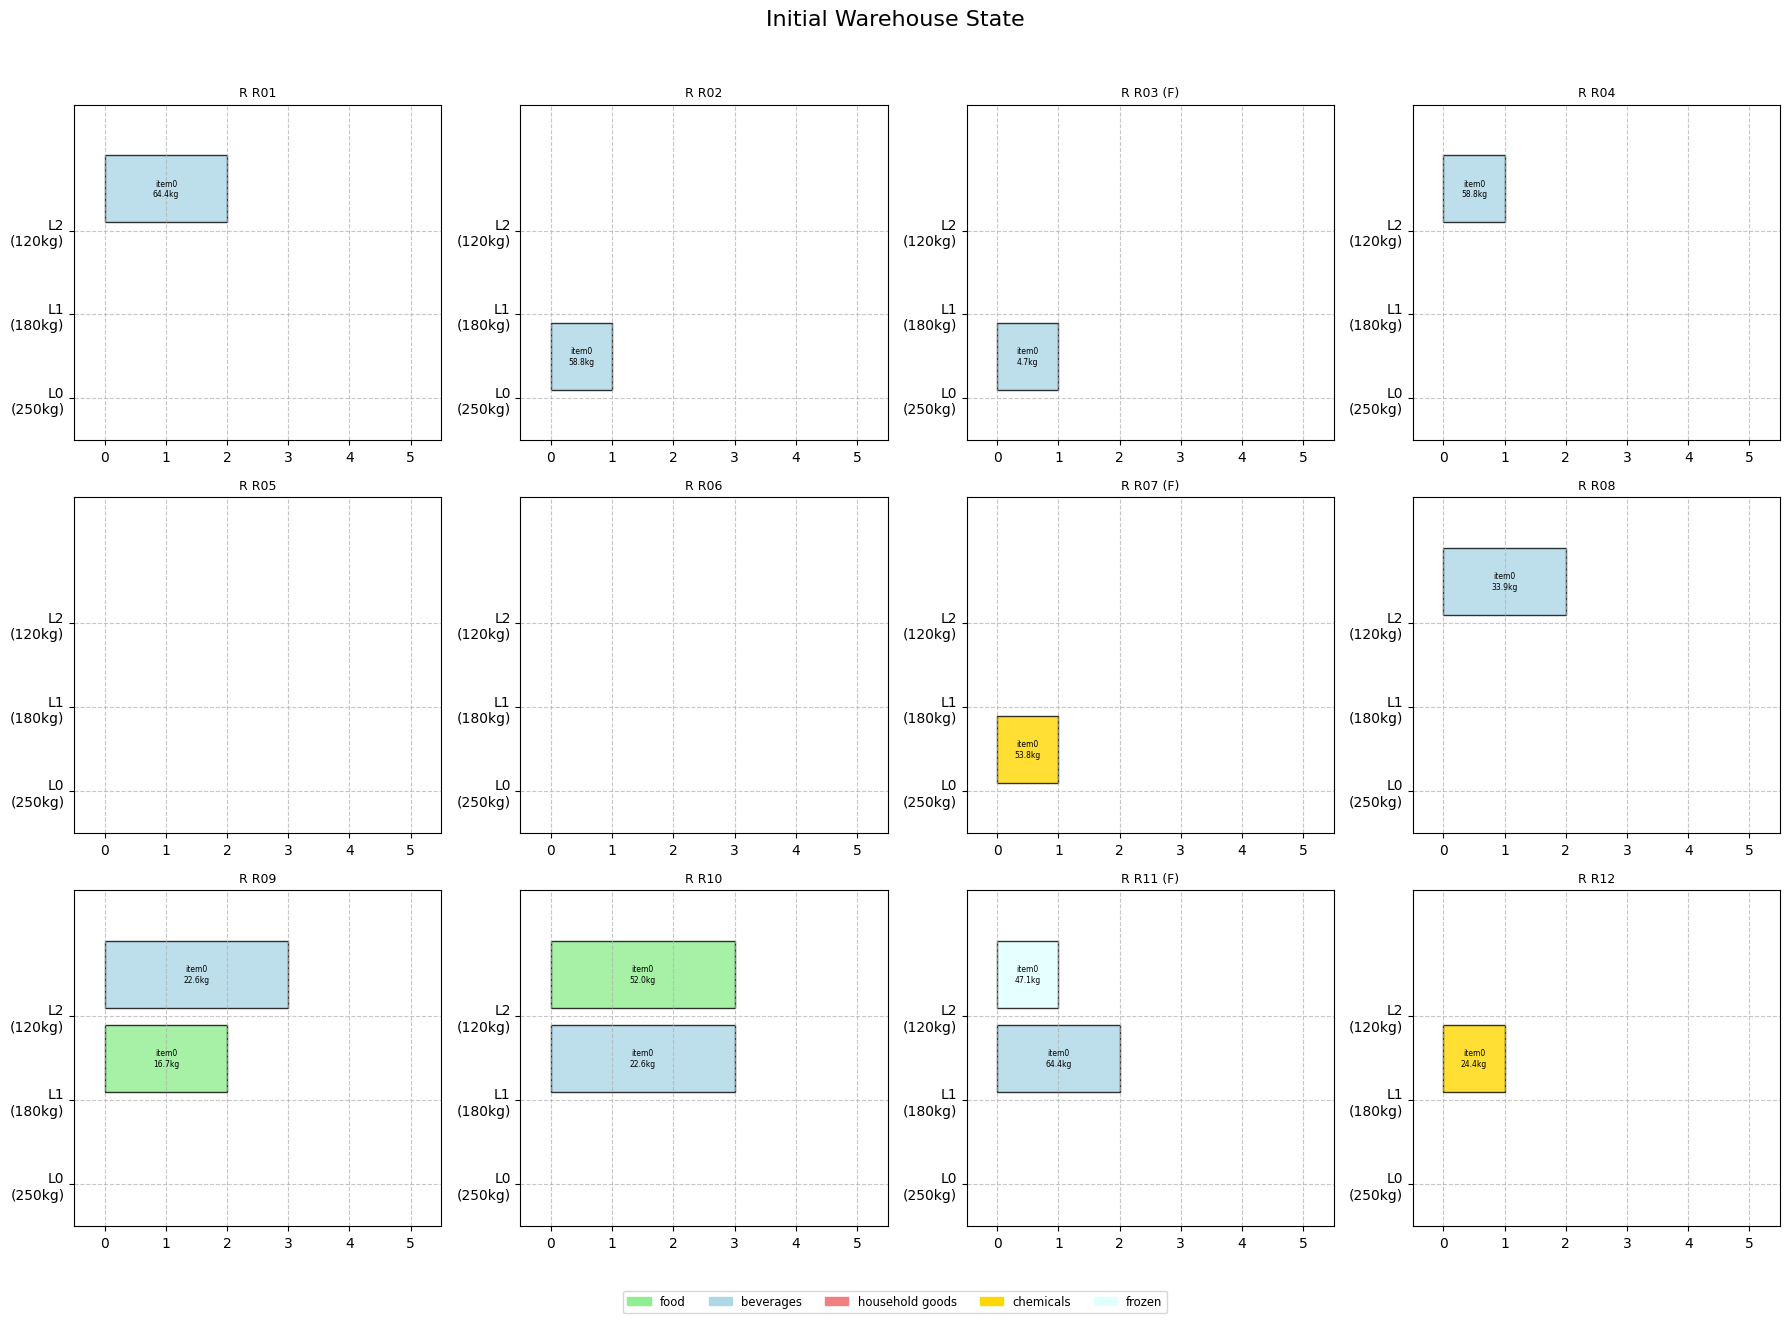



=============== ATTEMPTING INSERTION 1/10 FOR ITEM: item017 ===============

--- Evaluating Placements for: ItemData(item017,'Premium Food Unit',W:61.9,S:3,Fq:1.64) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    3.58 | Category:1.00; Item:1.50; Distance:1.08
R01-L1       |    2.58 | Category:1.00; Item:0.50; Distance:1.08
R01-L2       |    -inf | Shelf:FAIL
R02-L0       |    4.54 | Category:1.60; Item:1.50; Space:0.30; Distance:1.14
R02-L1       |    2.64 | Category:1.00; Item:0.50; Distance:1.14
R02-L2       |    1.14 | Category:1.00; Item:-1.00; Distance:1.14
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -6.88 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:1.62
R03-L2       |   -8.38 | Frozen:-10.00; Category:1.00; Item:-1.00; Dis

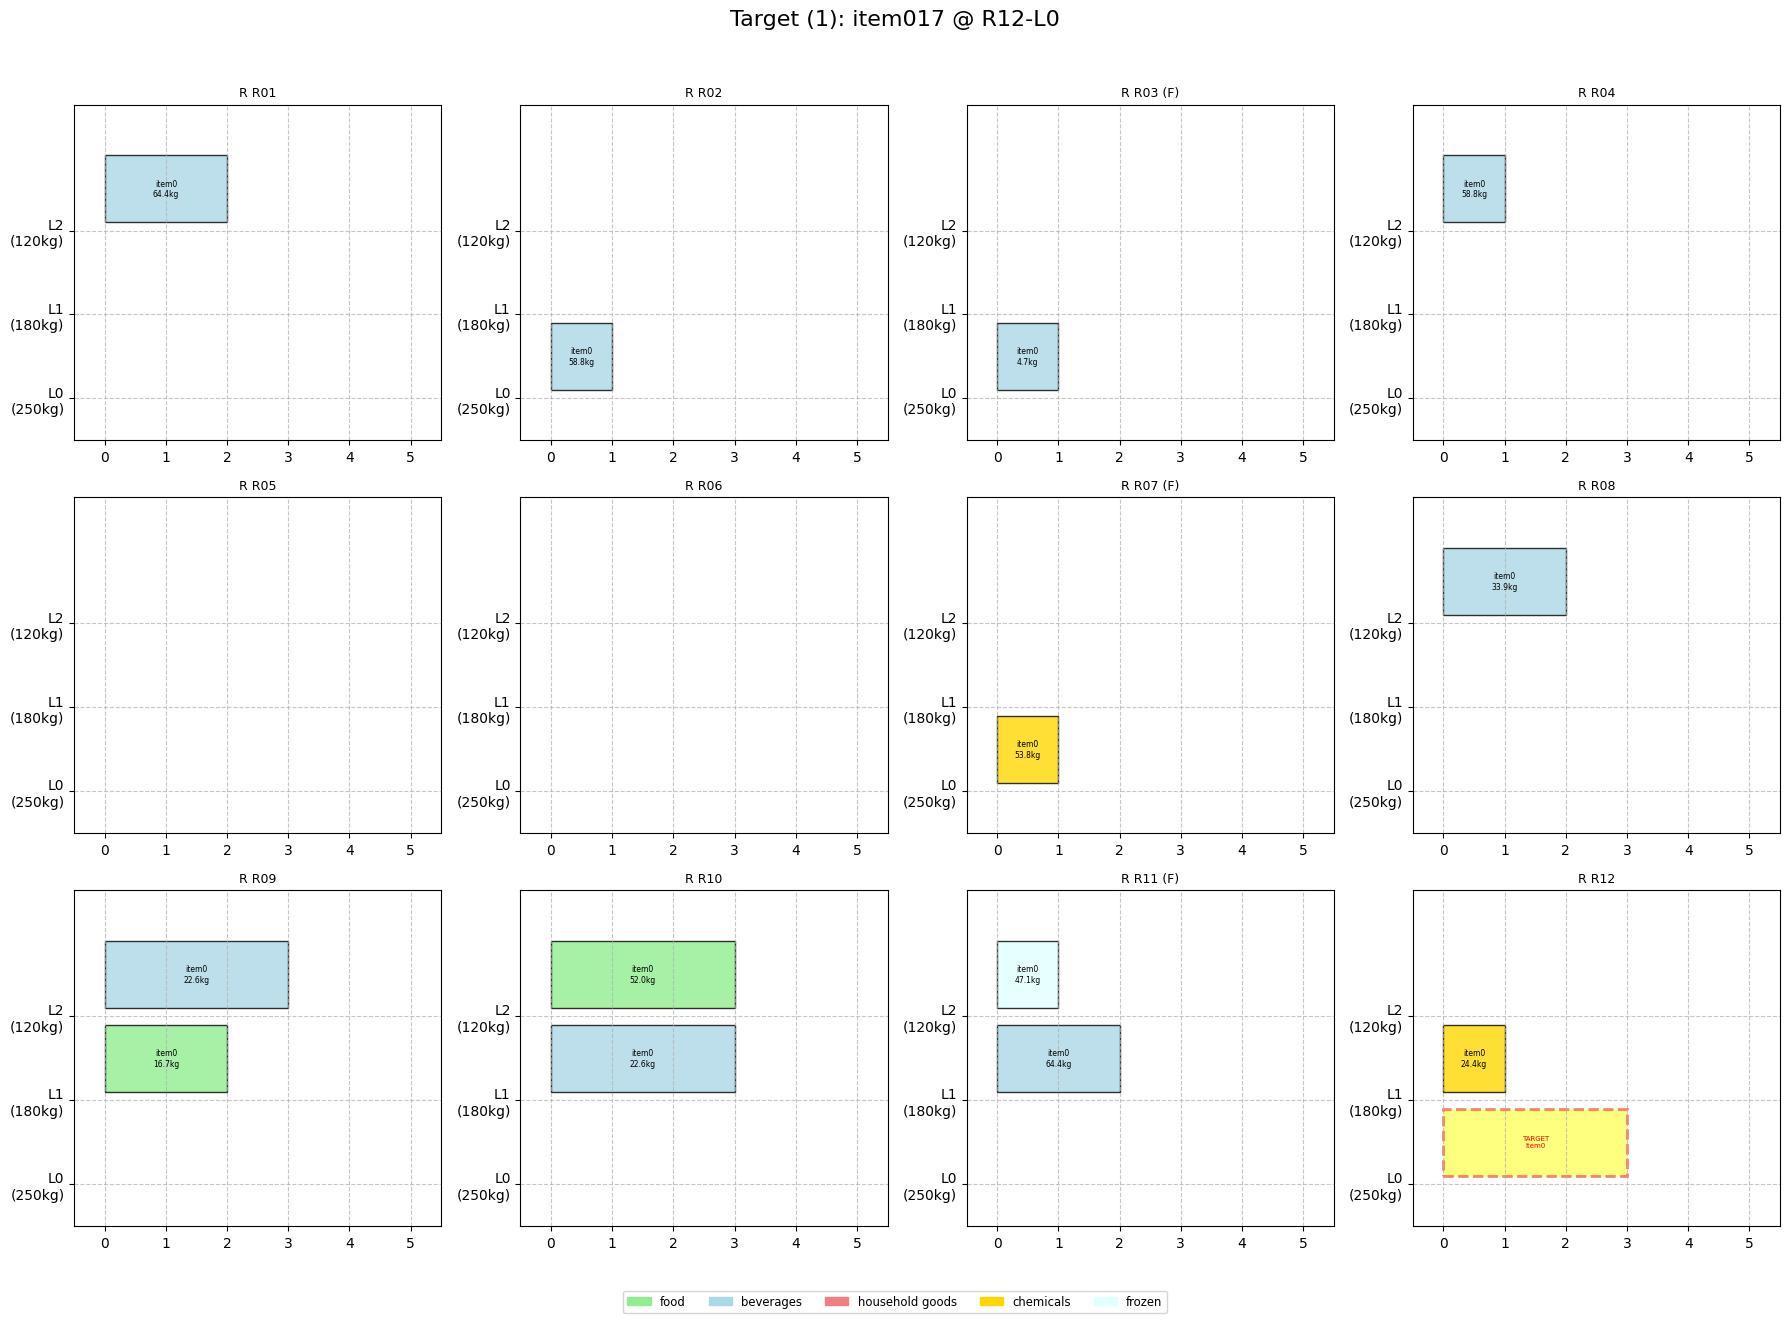


--- Placing item017 at ('R12', 0) ---


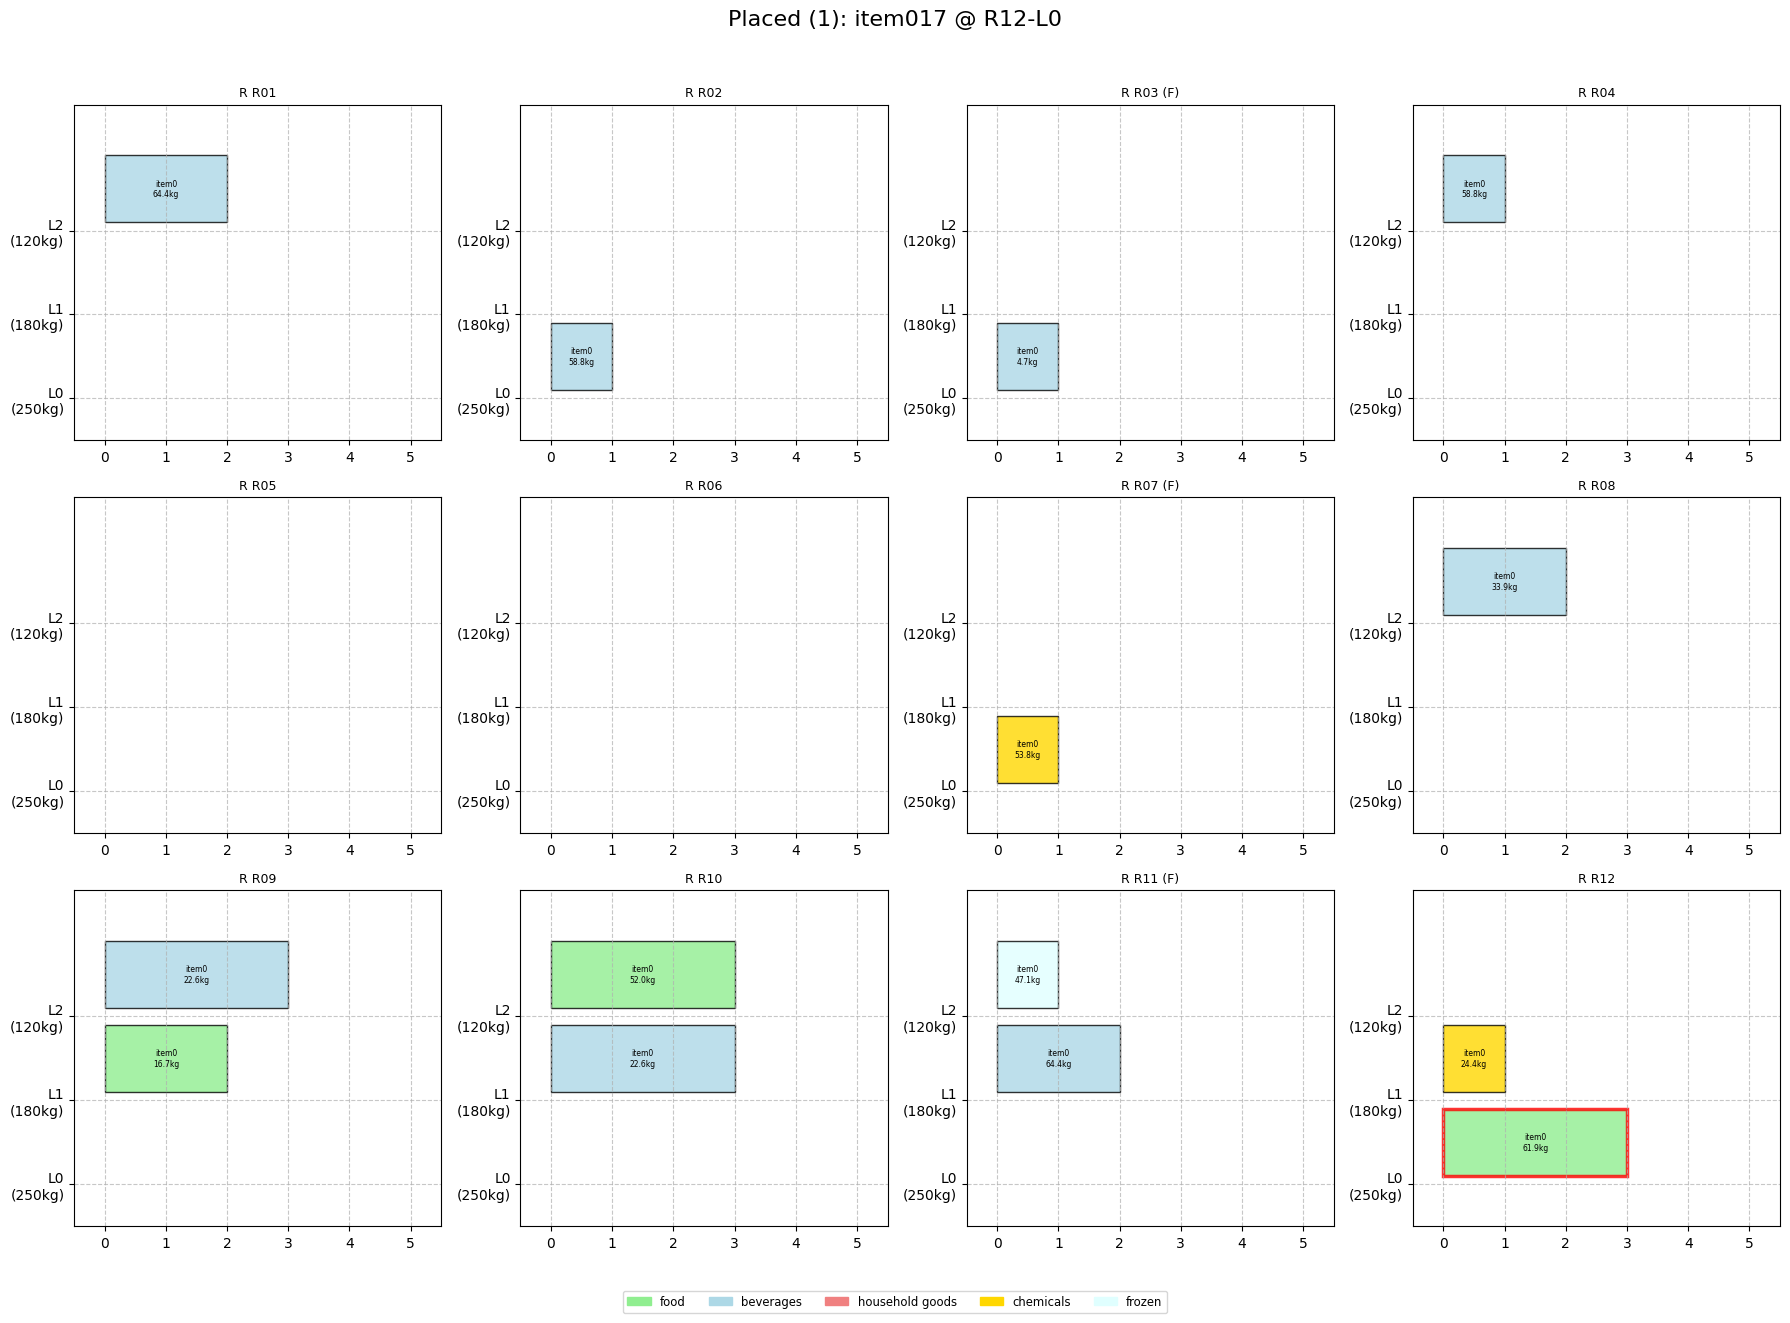



=============== ATTEMPTING INSERTION 2/10 FOR ITEM: item028 ===============

--- Evaluating Placements for: ItemData(item028,'Value Frozen Pack',W:15.4,S:2,Fq:9.44) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    -inf | Frozen:FAIL
R01-L1       |    -inf | Frozen:FAIL
R01-L2       |    -inf | Frozen:FAIL
R02-L0       |    -inf | Frozen:FAIL
R02-L1       |    -inf | Frozen:FAIL
R02-L2       |    -inf | Frozen:FAIL
R03-L0       |    5.20 | Category:0.20; Distance:5.00
R03-L1       |    6.00 | Category:1.00; Distance:5.00
R03-L2       |    6.20 | Category:1.00; Item:0.20; Distance:5.00
R04-L0       |    -inf | Frozen:FAIL
R04-L1       |    -inf | Frozen:FAIL
R04-L2       |    -inf | Frozen:FAIL
R05-L0       |    -inf | Frozen:FAIL
R05-L1       |    

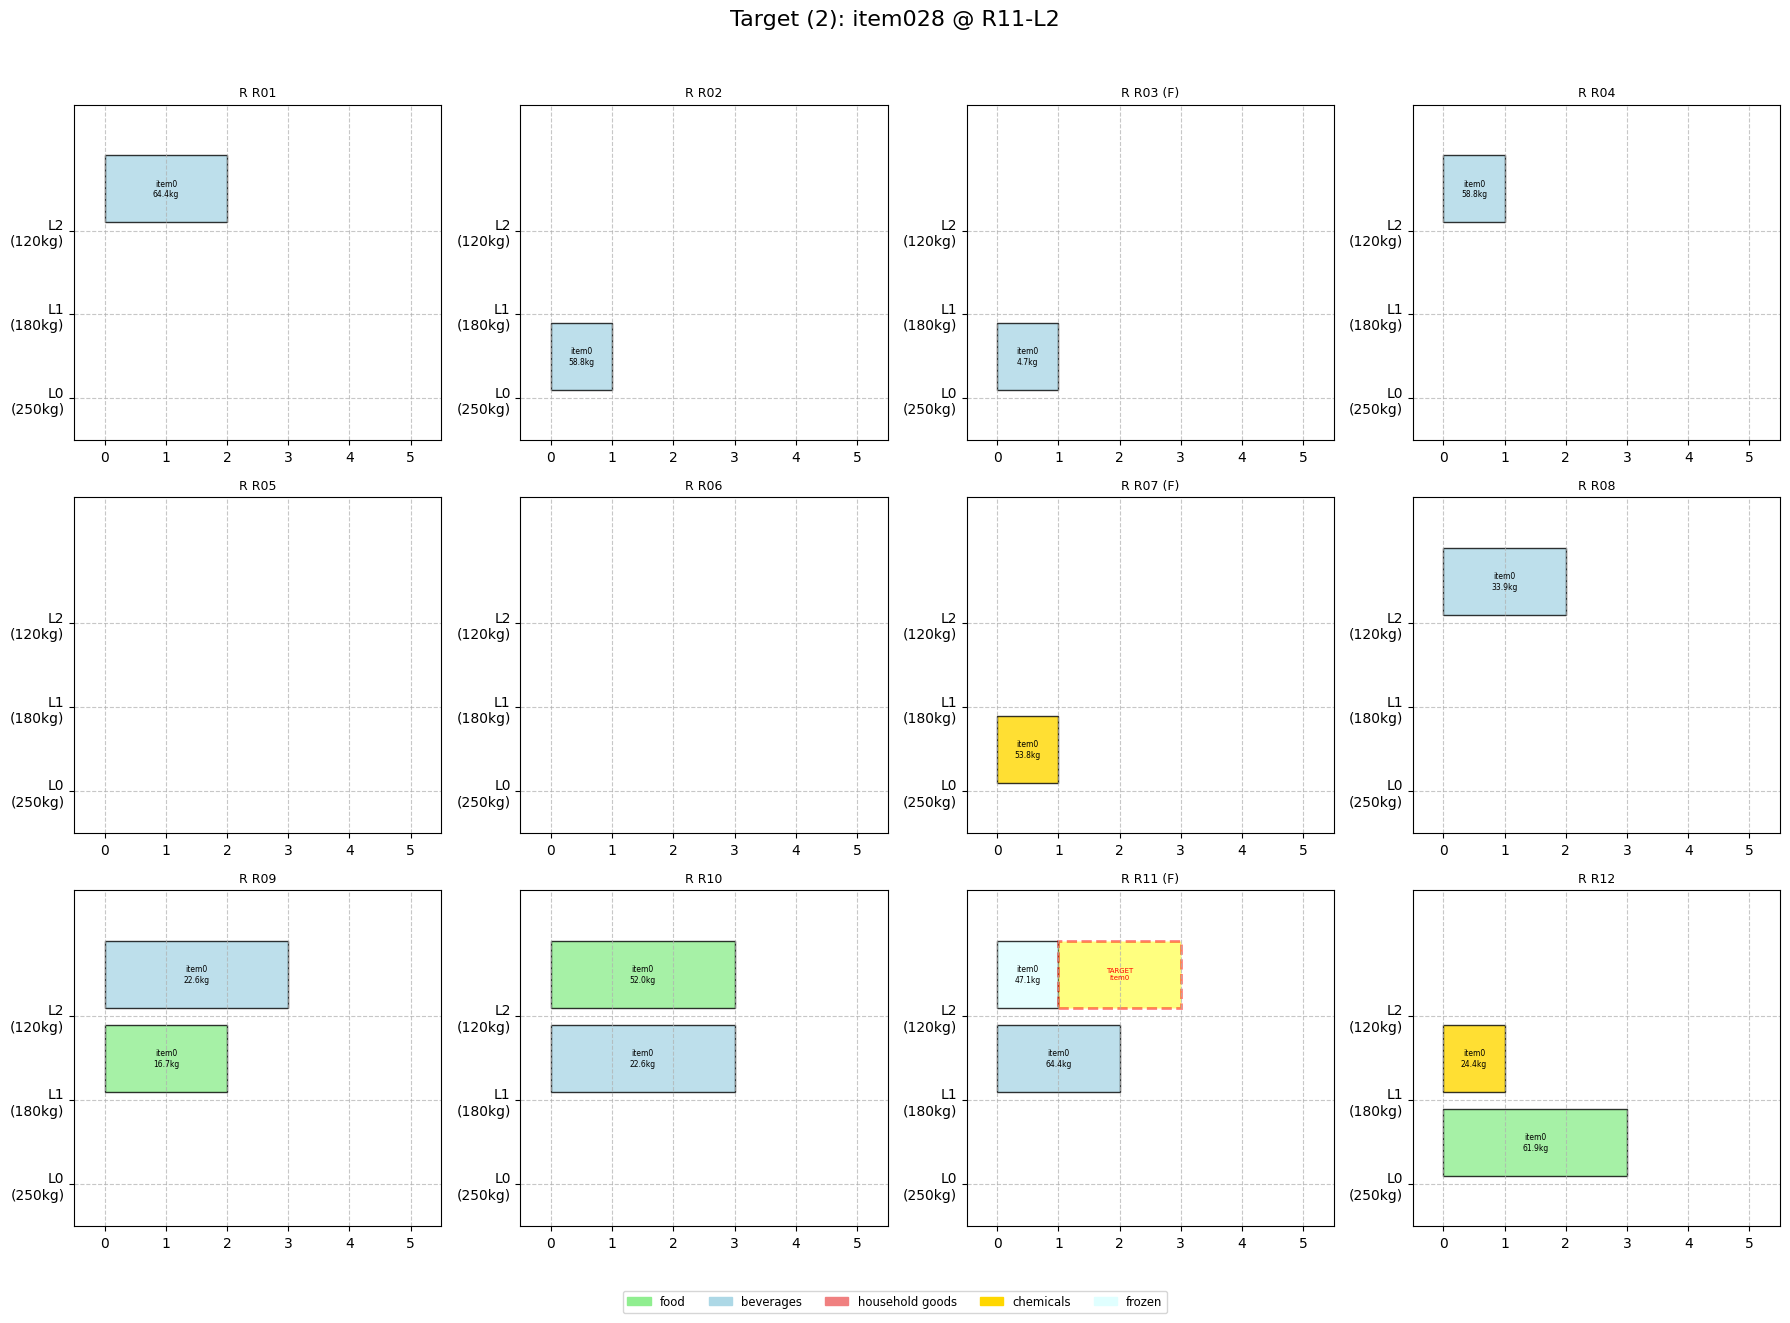


--- Placing item028 at ('R11', 2) ---


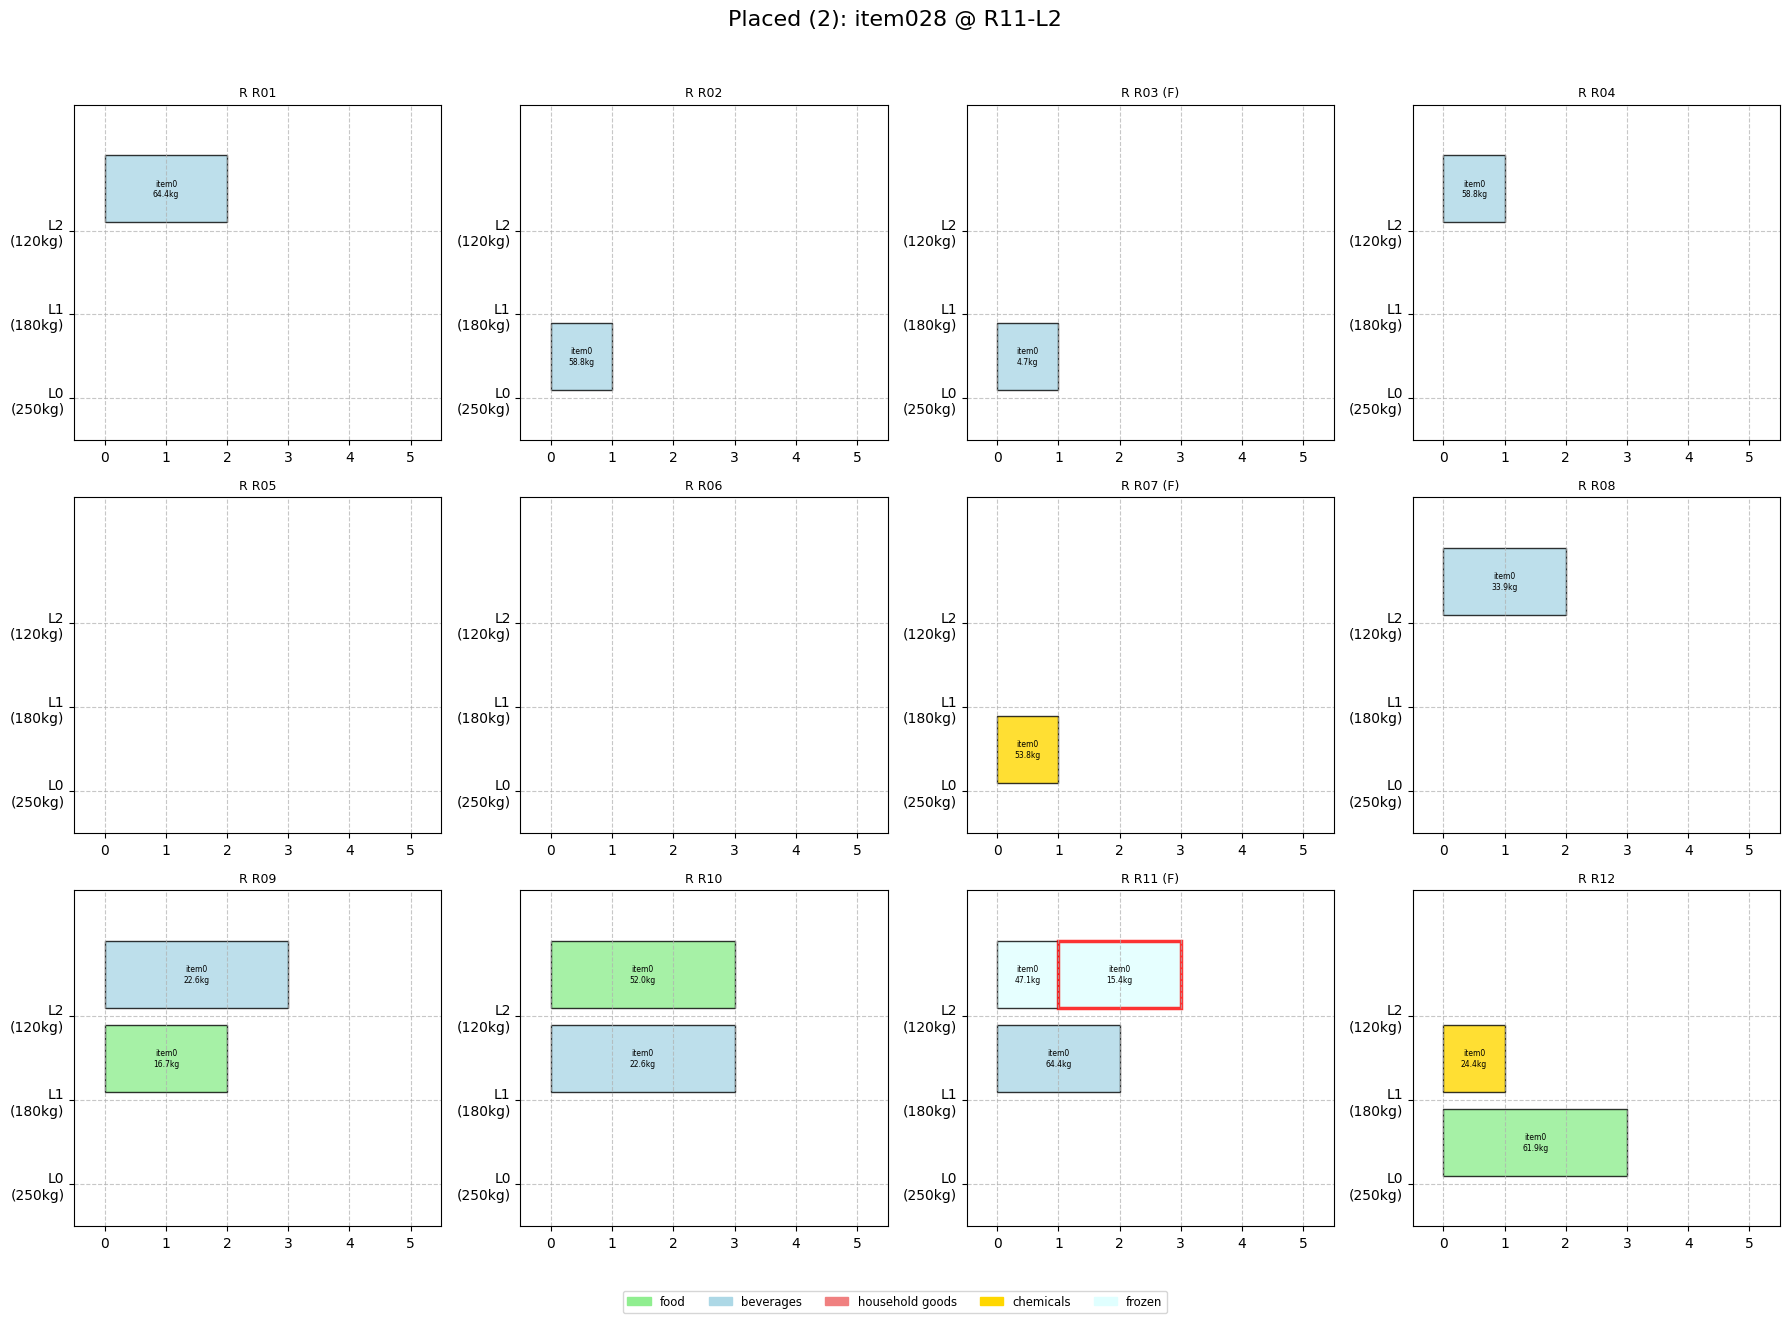



=============== ATTEMPTING INSERTION 3/10 FOR ITEM: item026 ===============

--- Evaluating Placements for: ItemData(item026,'Value Chemicals Pack',W:52.0,S:1,Fq:2.42) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    4.03 | Category:1.00; Item:1.50; Distance:1.53
R01-L1       |    3.03 | Category:1.00; Item:0.50; Distance:1.53
R01-L2       |    0.53 | Item:-1.00; Distance:1.53
R02-L0       |    3.12 | Item:1.50; Distance:1.62
R02-L1       |    3.12 | Category:1.00; Item:0.50; Distance:1.62
R02-L2       |    1.62 | Category:1.00; Item:-1.00; Distance:1.62
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -6.21 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:2.29
R03-L2       |   -7.71 | Frozen:-10.00; Category:1.00; Item:-1.00; Distance:2.2

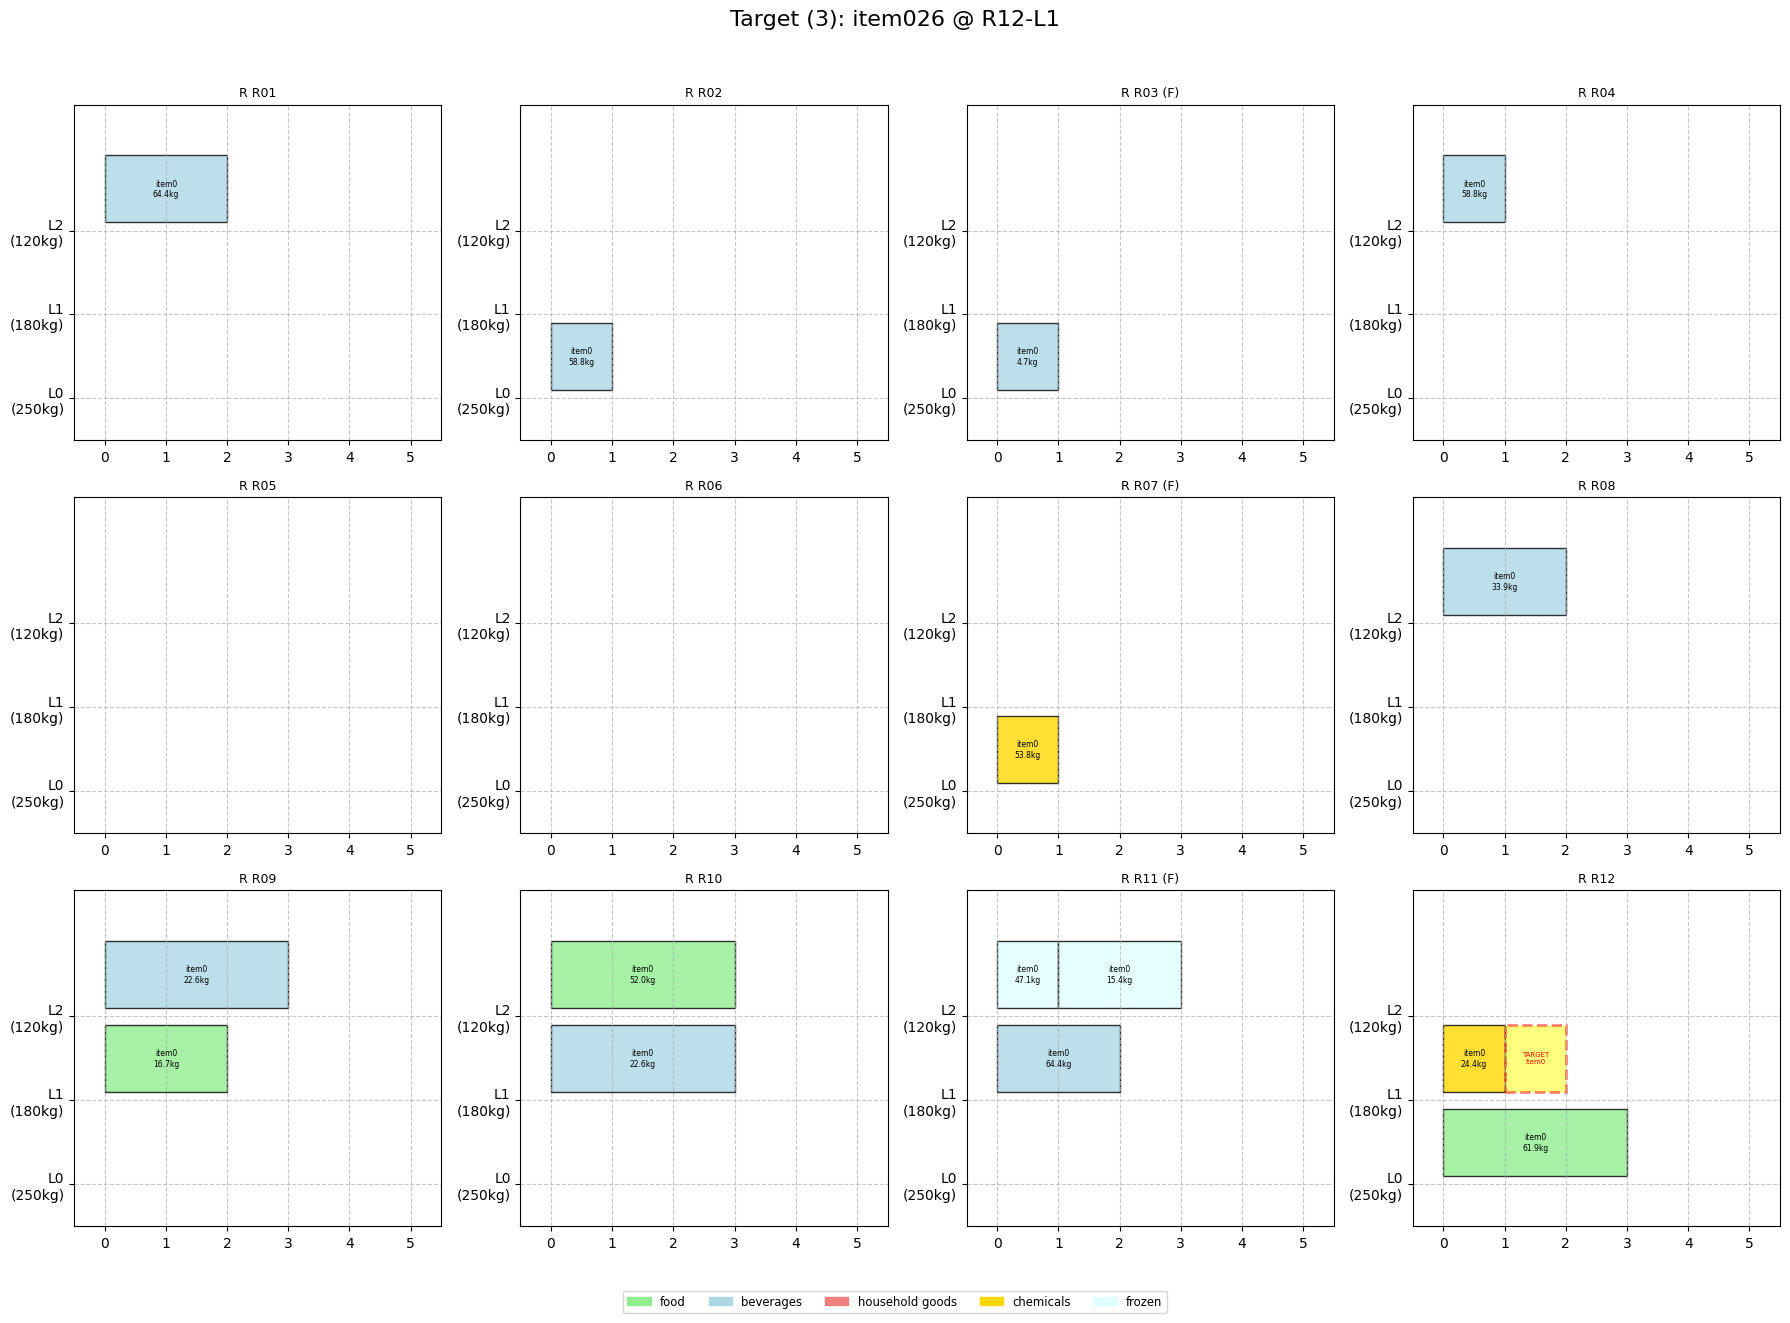


--- Placing item026 at ('R12', 1) ---


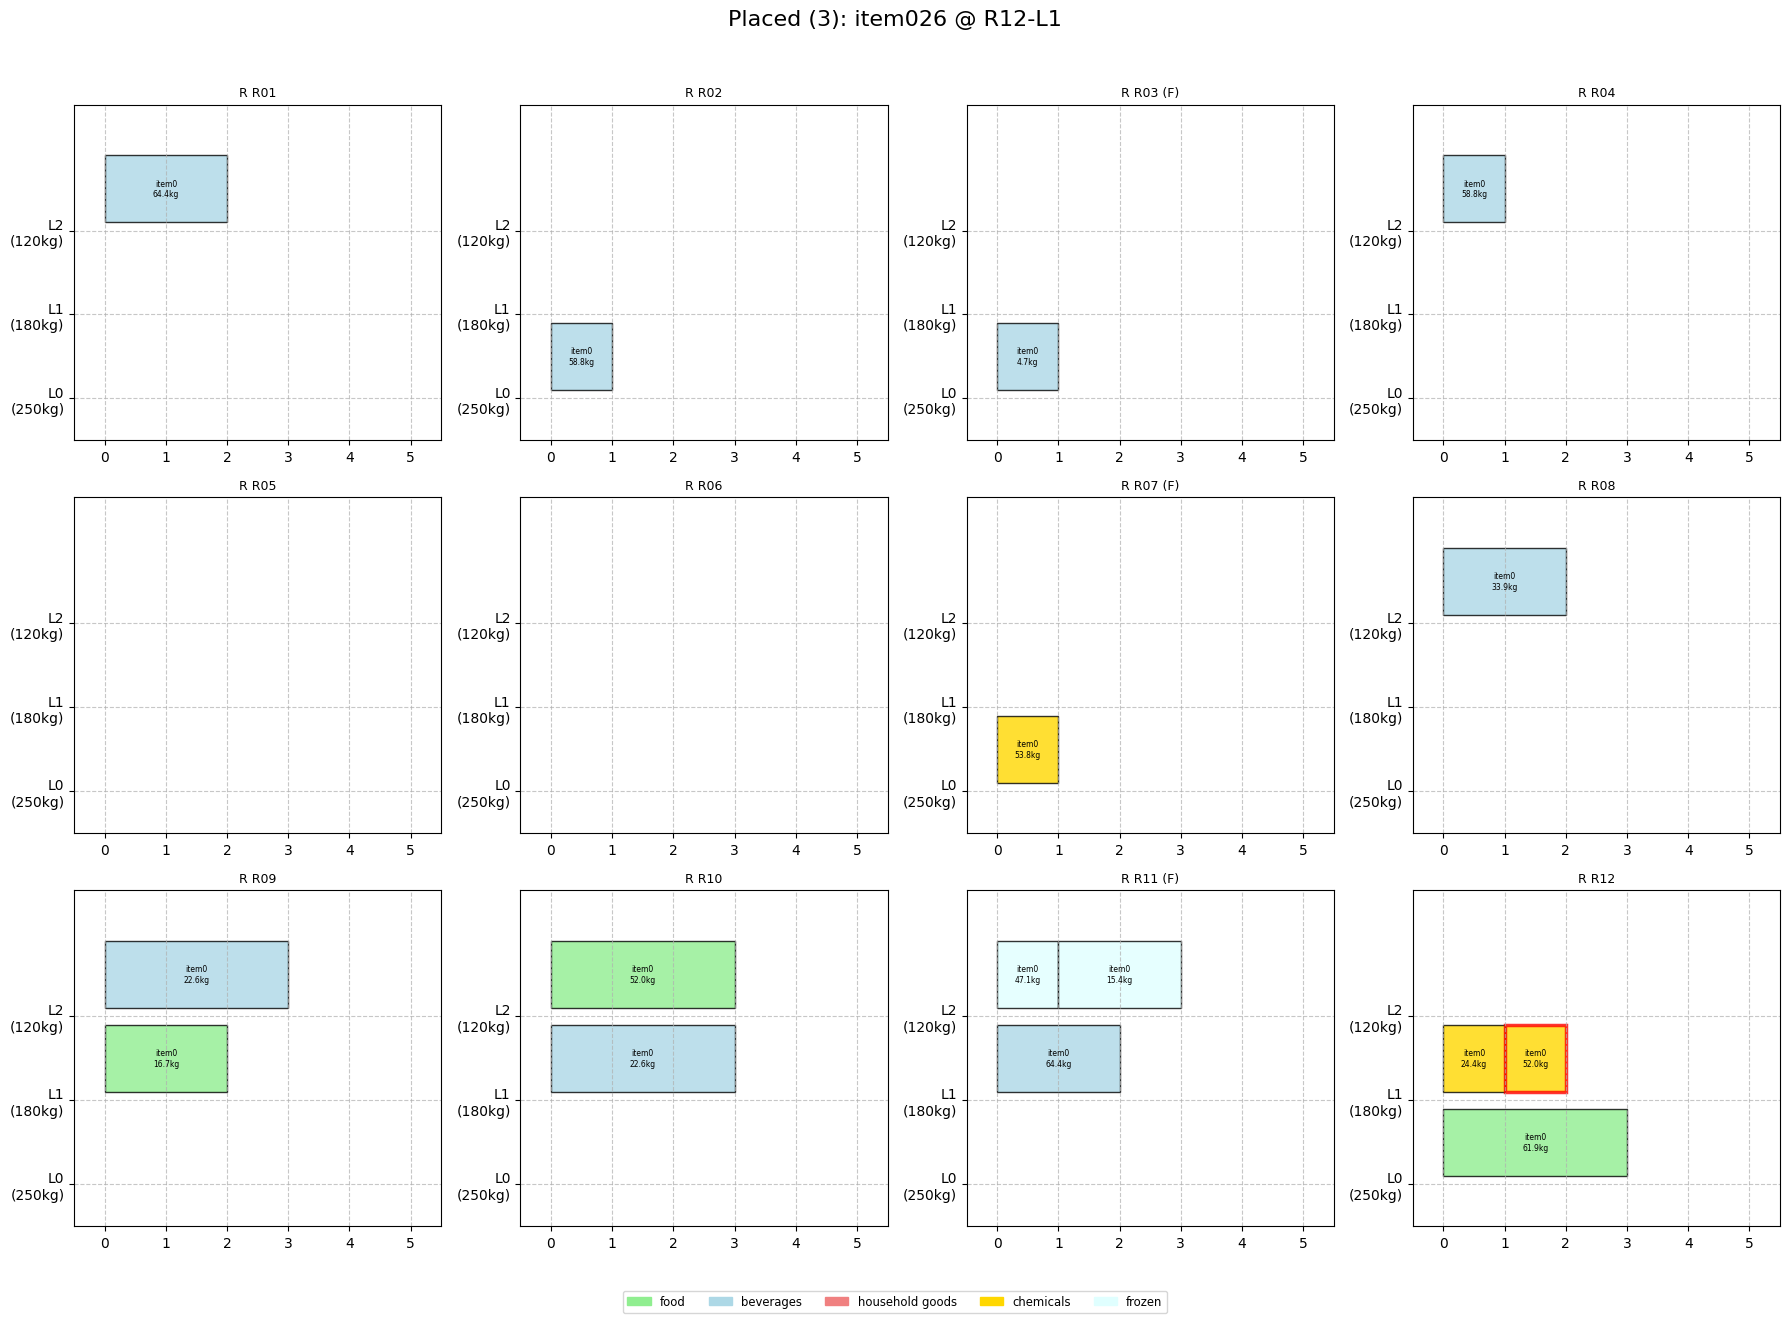



=============== ATTEMPTING INSERTION 4/10 FOR ITEM: item048 ===============

--- Evaluating Placements for: ItemData(item048,'Premium Beverages Box',W:40.6,S:1,Fq:4.36) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    5.17 | Category:1.00; Item:1.50; Distance:2.67
R01-L1       |    4.17 | Category:1.00; Item:0.50; Distance:2.67
R01-L2       |    3.67 | Category:2.00; Item:-1.00; Distance:2.67
R02-L0       |    6.33 | Category:2.00; Item:1.50; Distance:2.83
R02-L1       |    4.33 | Category:1.00; Item:0.50; Distance:2.83
R02-L2       |    2.83 | Category:1.00; Item:-1.00; Distance:2.83
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -4.50 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:4.00
R03-L2       |   -6.00 | Frozen:-10.00; Category

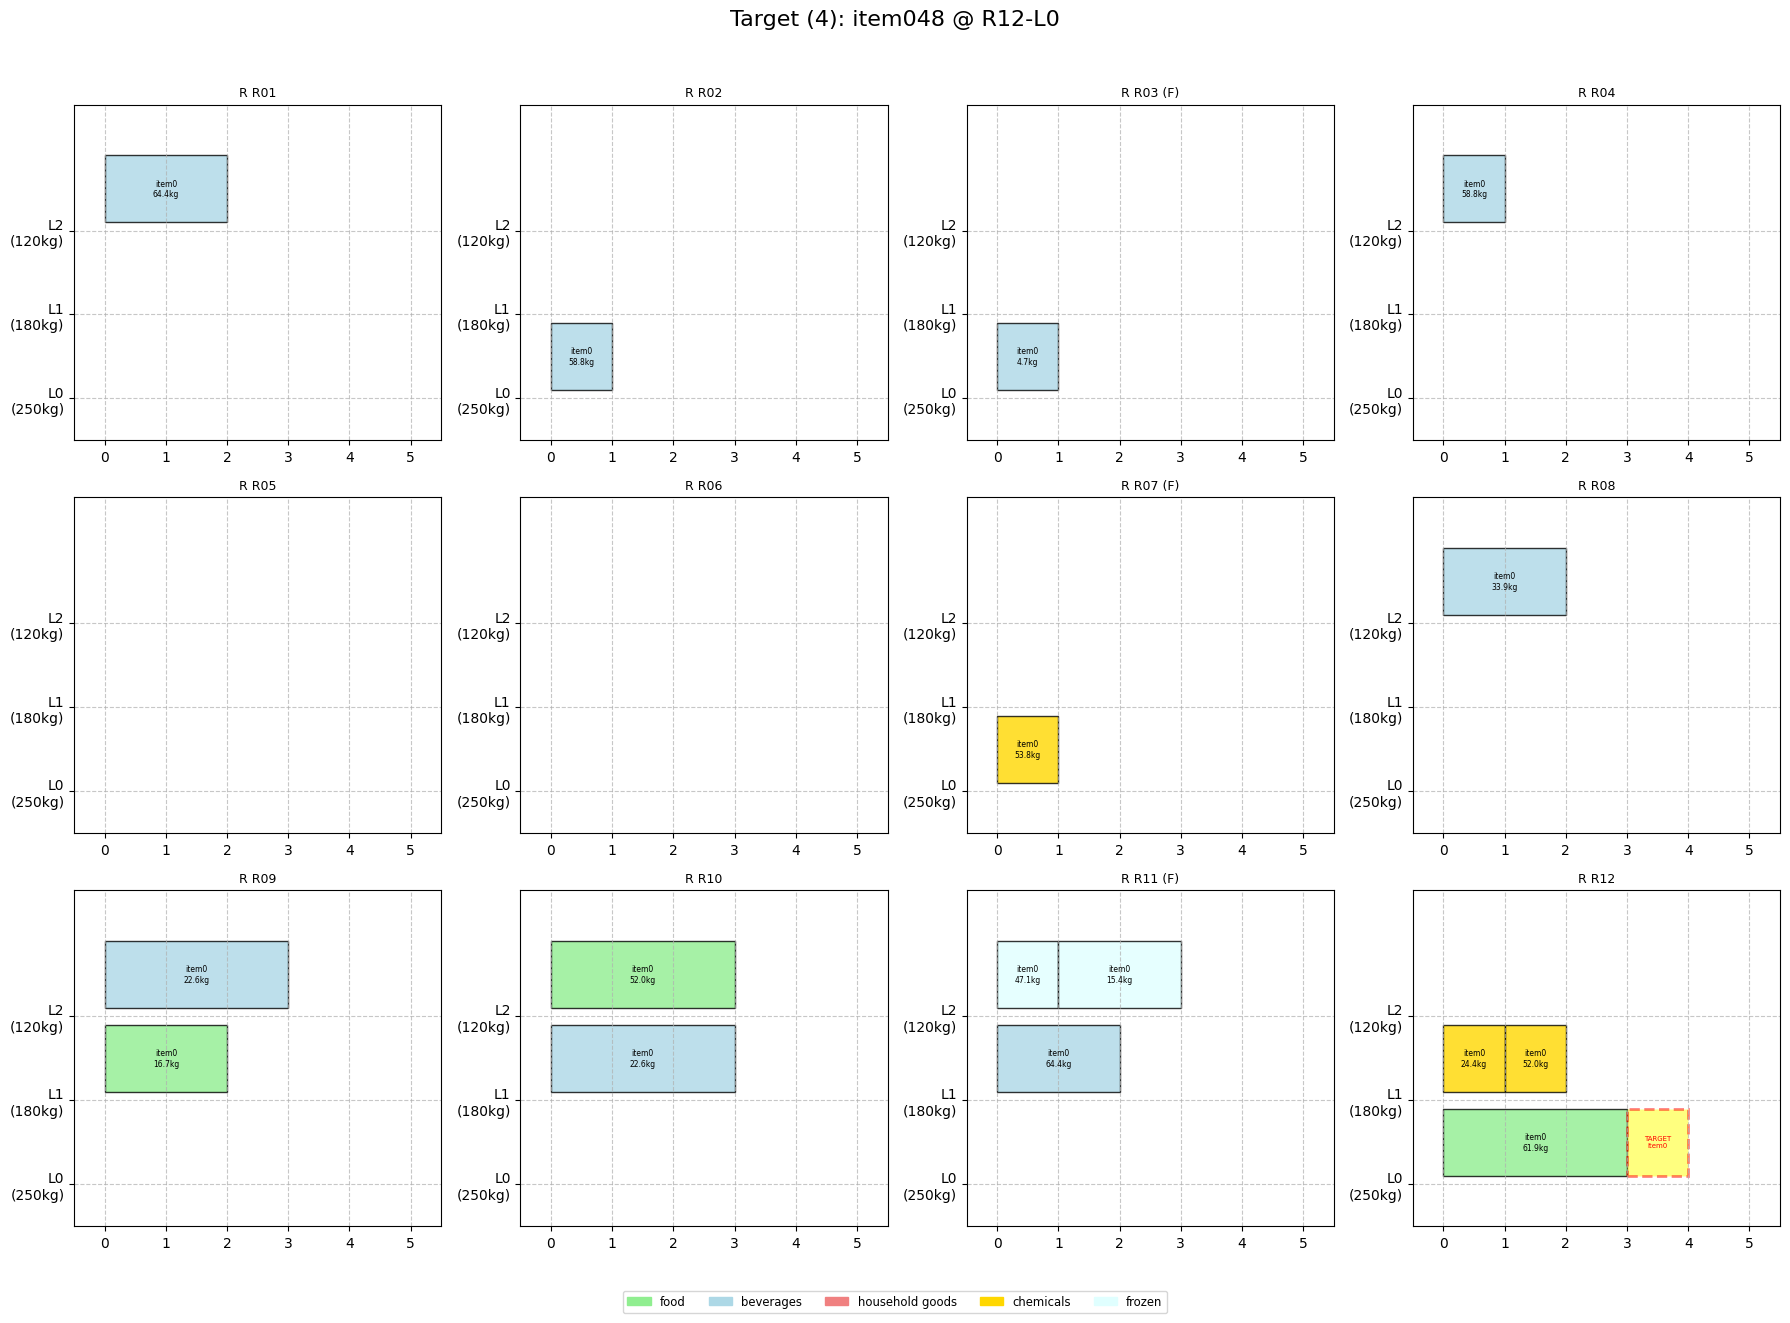


--- Placing item048 at ('R12', 0) ---


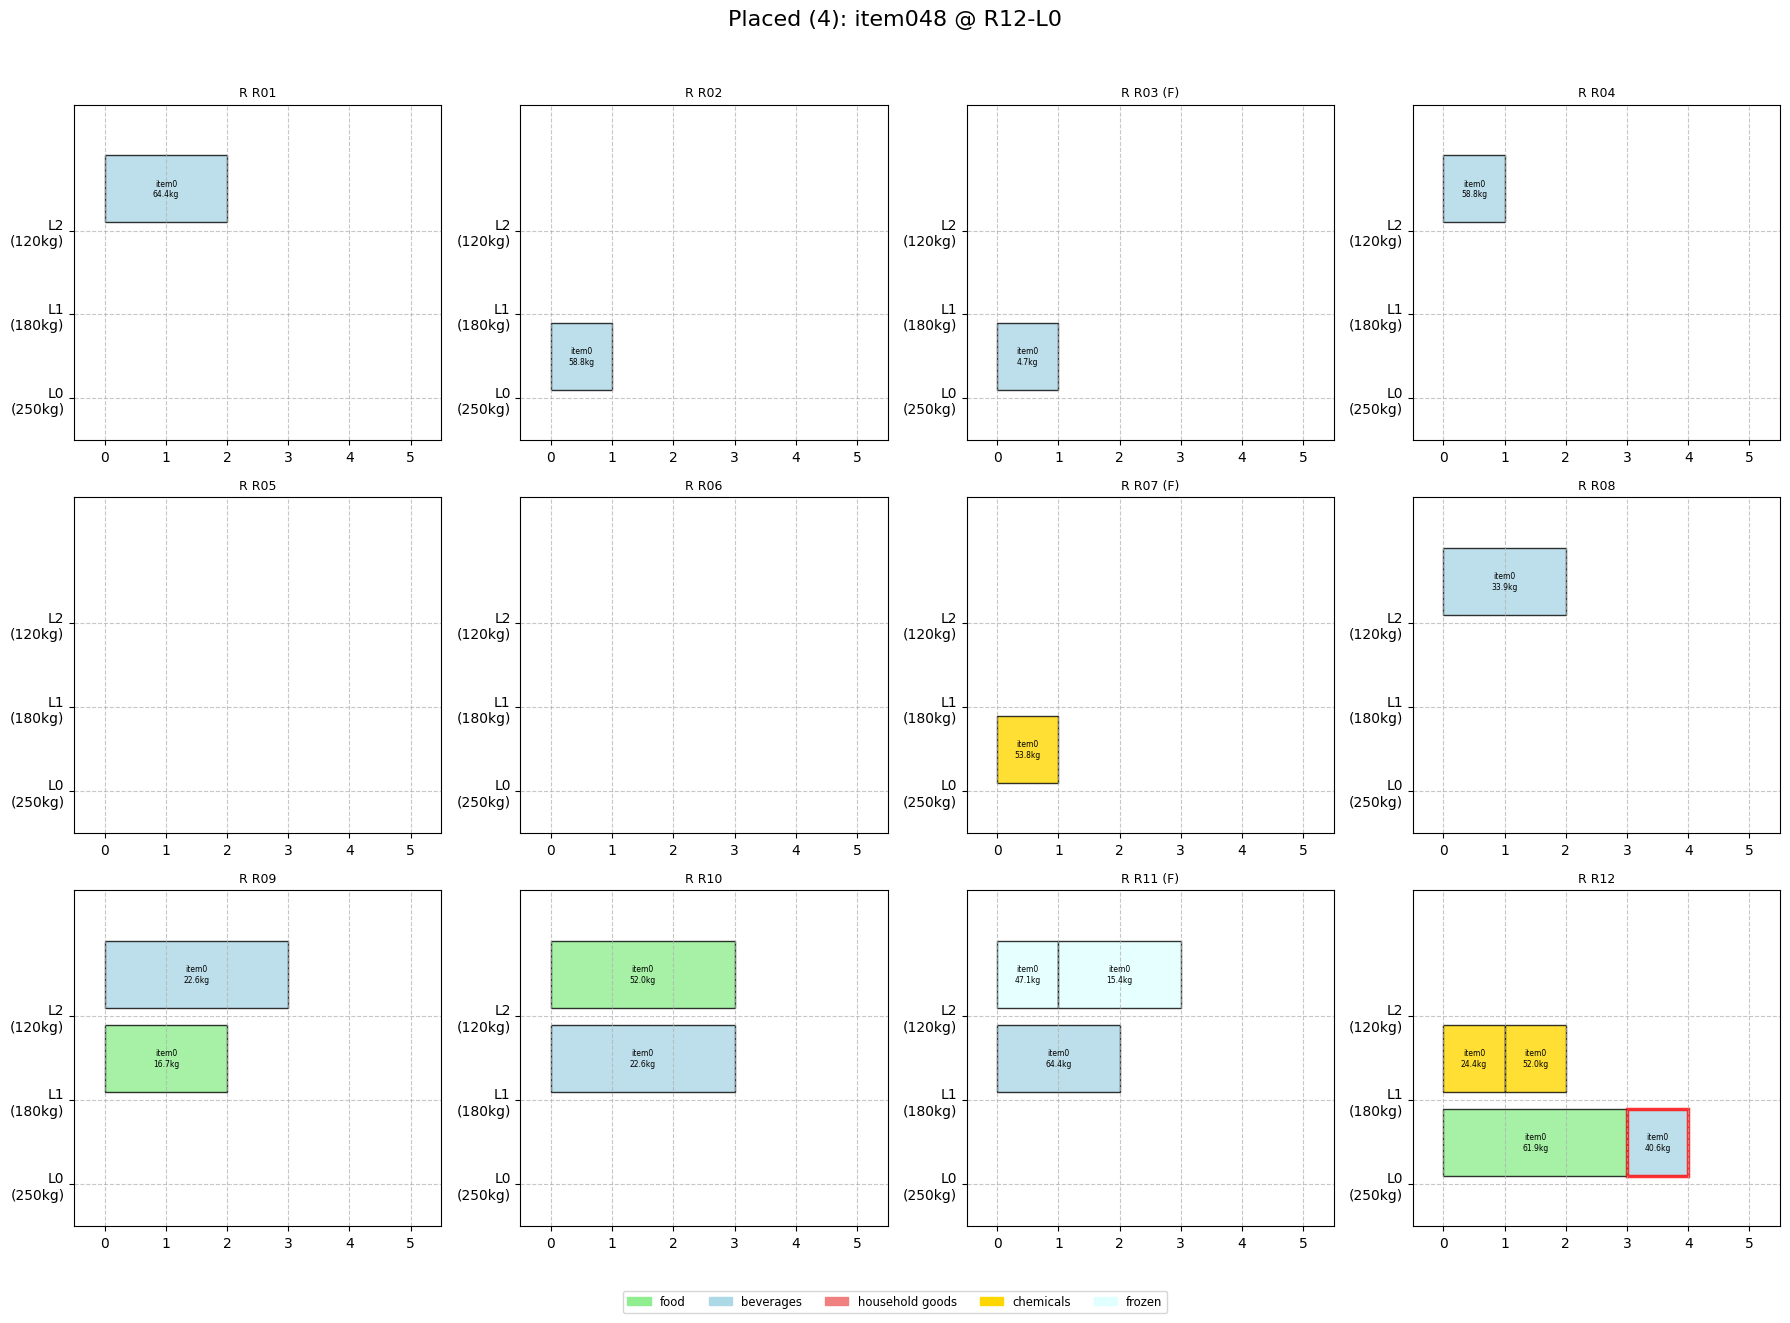



=============== ATTEMPTING INSERTION 5/10 FOR ITEM: item027 ===============

--- Evaluating Placements for: ItemData(item027,'Eco Household goods Unit',W:34.7,S:3,Fq:5.33) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    5.74 | Category:1.00; Item:1.50; Distance:3.24
R01-L1       |    4.74 | Category:1.00; Item:0.50; Distance:3.24
R01-L2       |    3.64 | Category:0.60; Item:-1.00; Space:0.80; Distance:3.24
R02-L0       |    5.83 | Category:0.60; Item:1.50; Space:0.30; Distance:3.43
R02-L1       |    4.93 | Category:1.00; Item:0.50; Distance:3.43
R02-L2       |    3.43 | Category:1.00; Item:-1.00; Distance:3.43
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -3.65 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:4.85
R03-L2       |   -5.1

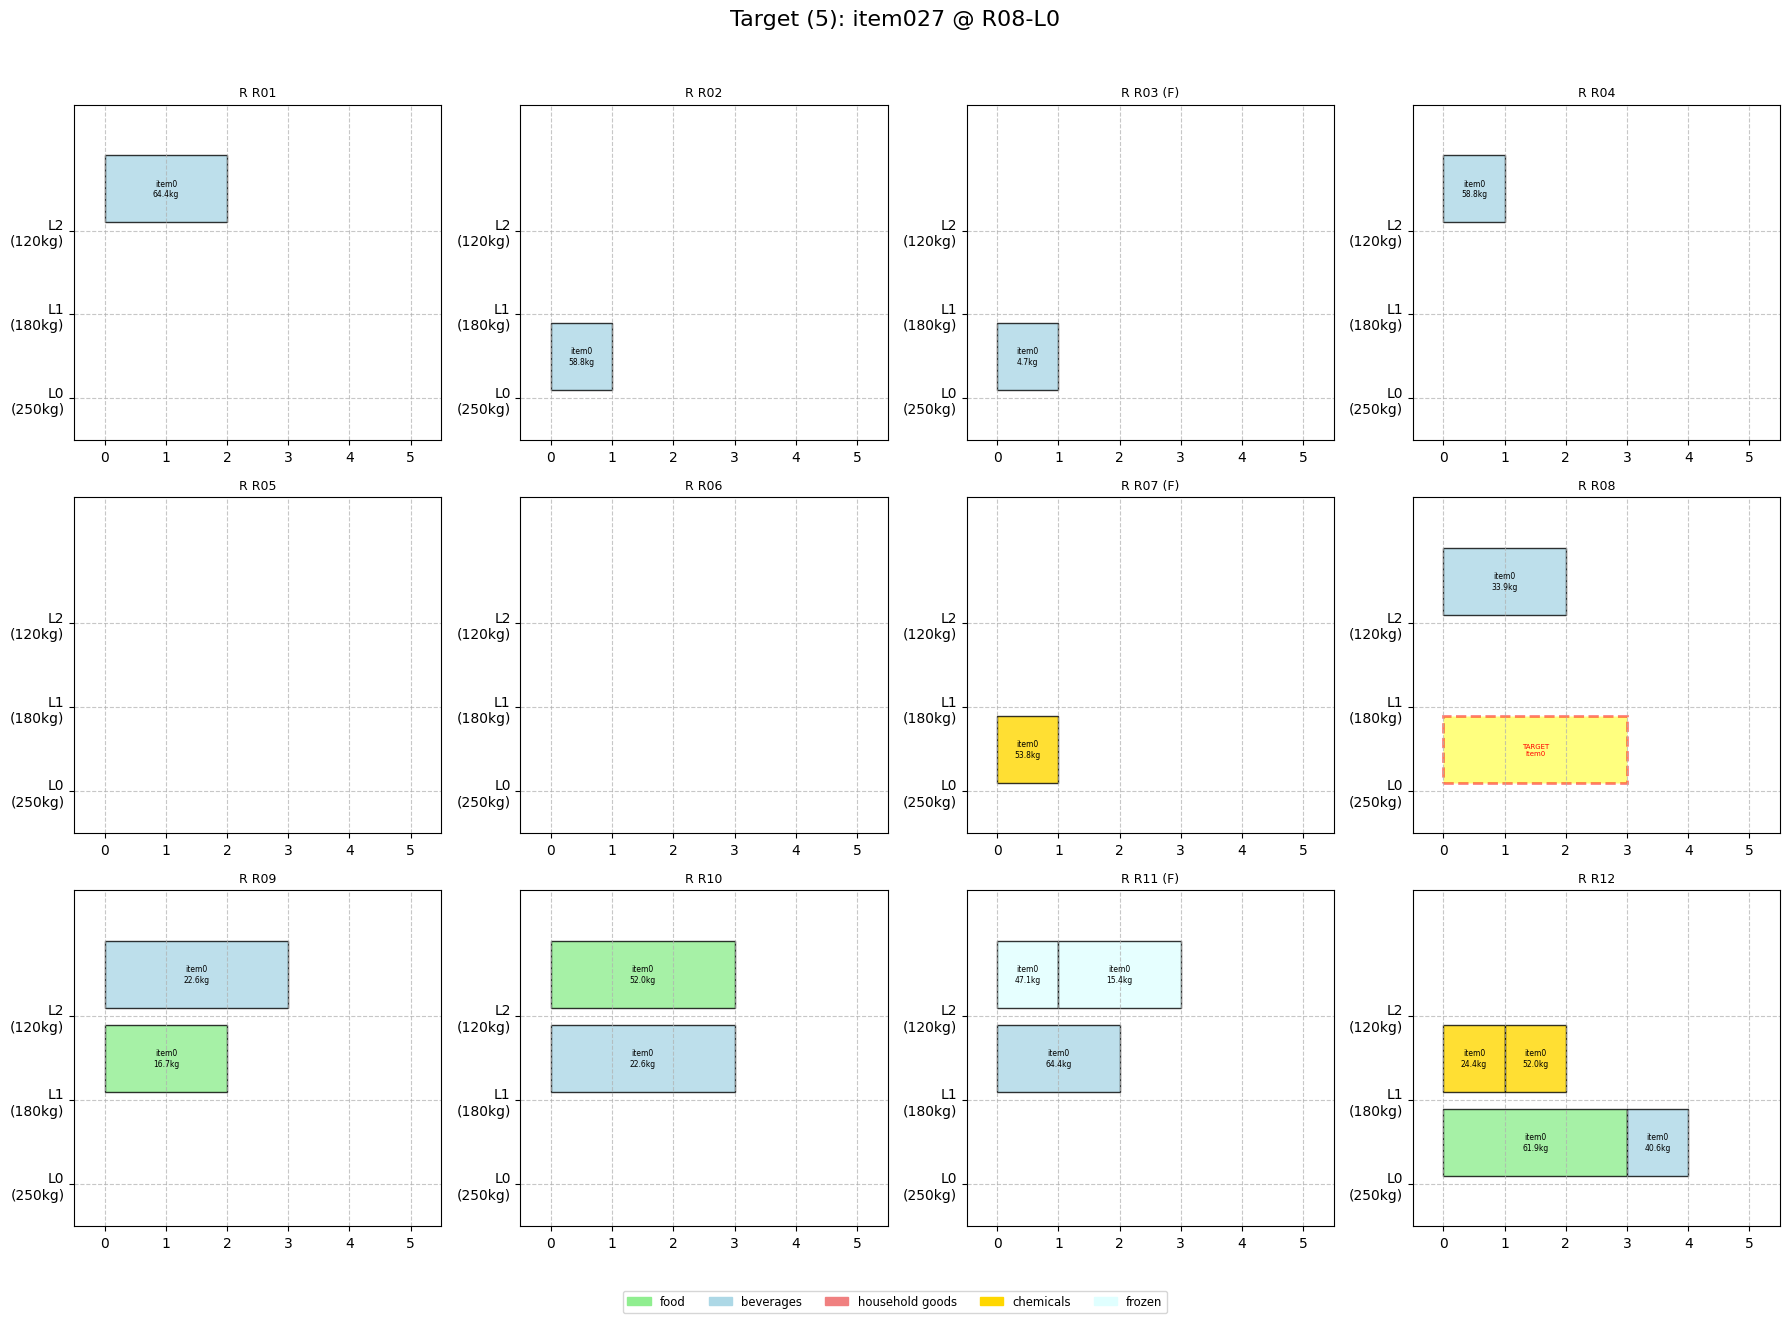


--- Placing item027 at ('R08', 0) ---


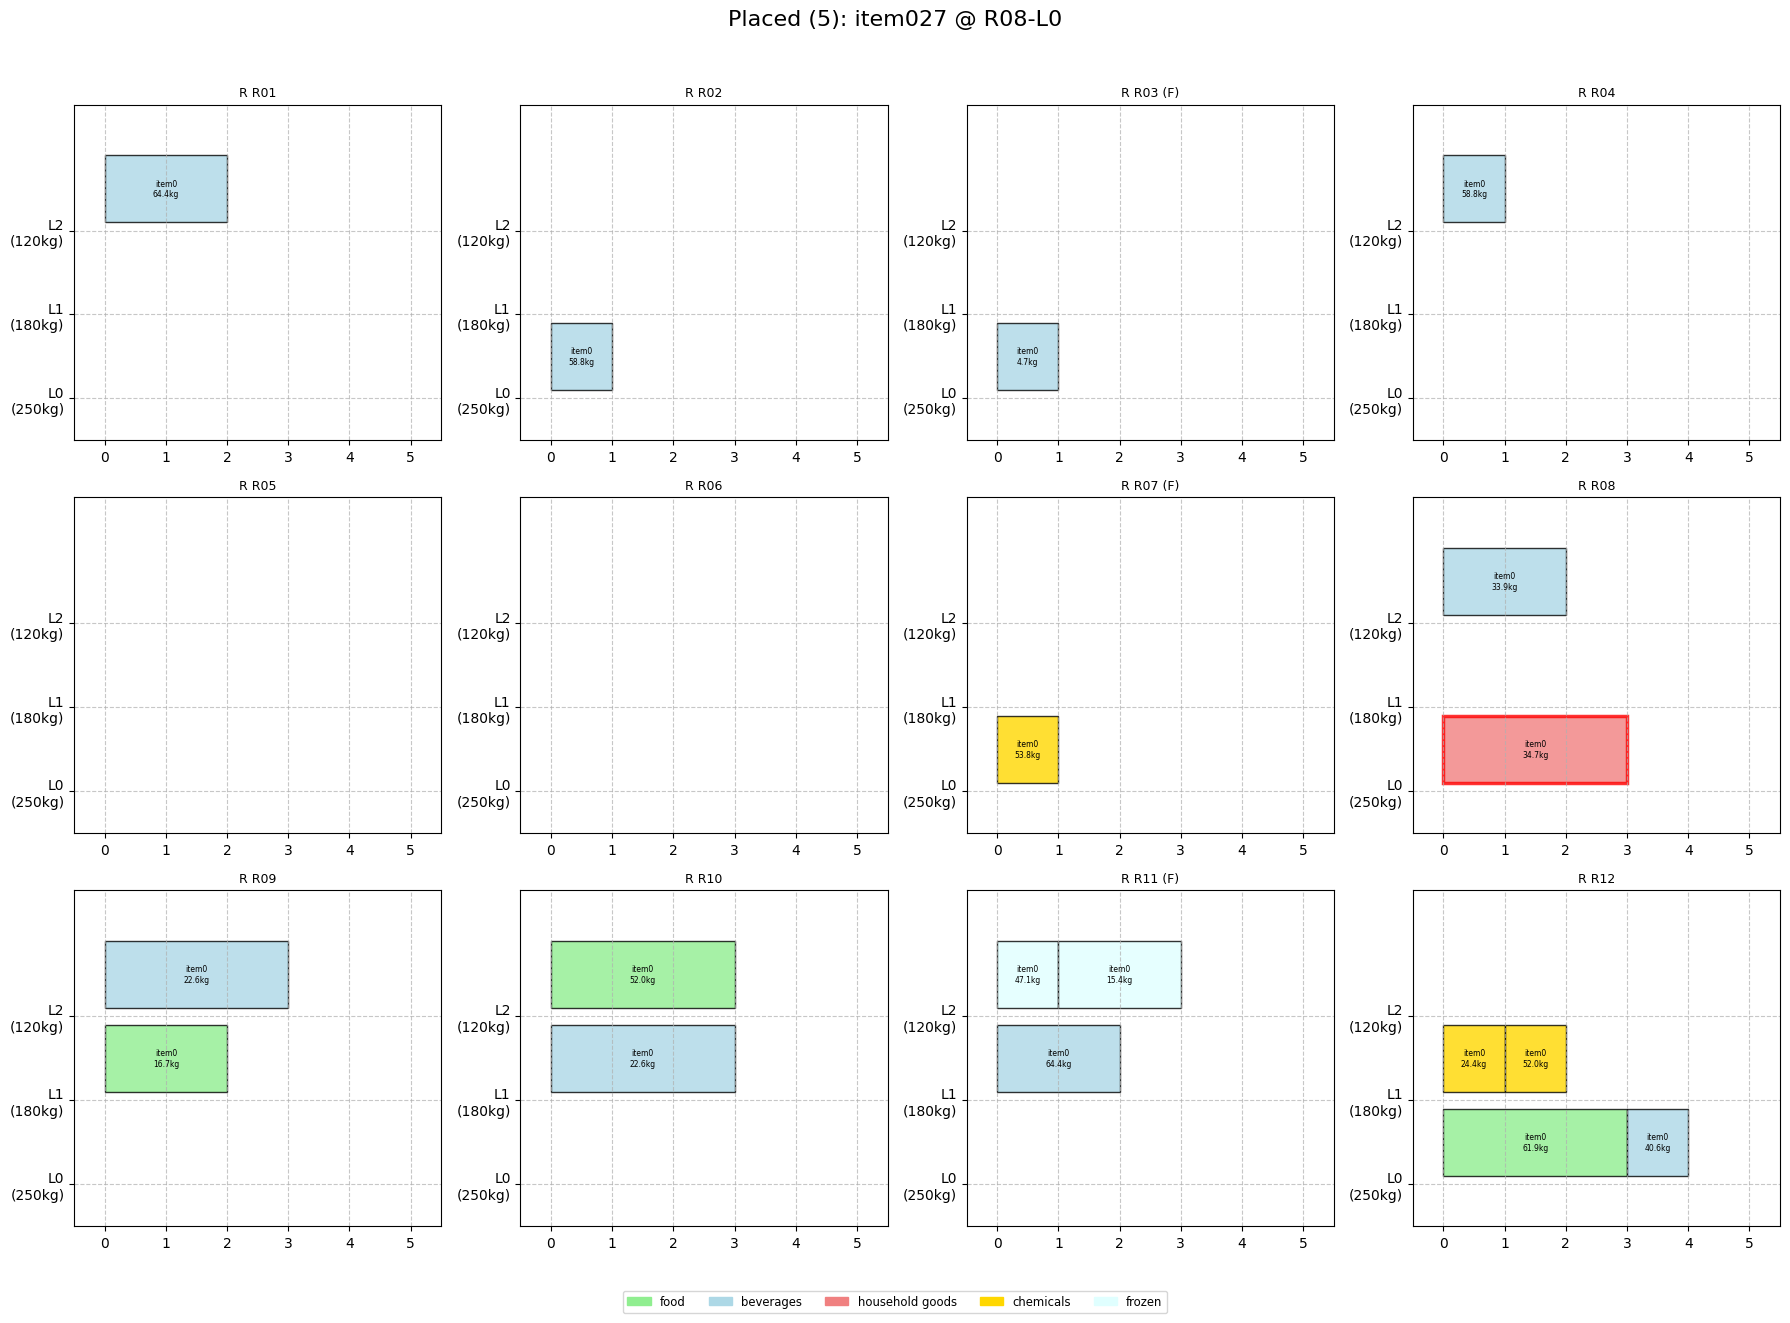



=============== ATTEMPTING INSERTION 6/10 FOR ITEM: item025 ===============

--- Evaluating Placements for: ItemData(item025,'Eco Chemicals Box',W:59.7,S:2,Fq:7.07) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    6.76 | Category:1.00; Item:1.50; Distance:4.26
R01-L1       |    5.76 | Category:1.00; Item:0.50; Distance:4.26
R01-L2       |    -inf | Shelf:FAIL
R02-L0       |    6.01 | Item:1.50; Distance:4.51
R02-L1       |    6.01 | Category:1.00; Item:0.50; Distance:4.51
R02-L2       |    4.51 | Category:1.00; Item:-1.00; Distance:4.51
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -3.50 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:5.00
R03-L2       |   -5.00 | Frozen:-10.00; Category:1.00; Item:-1.00; Distance:5.00
R04-L0       |  

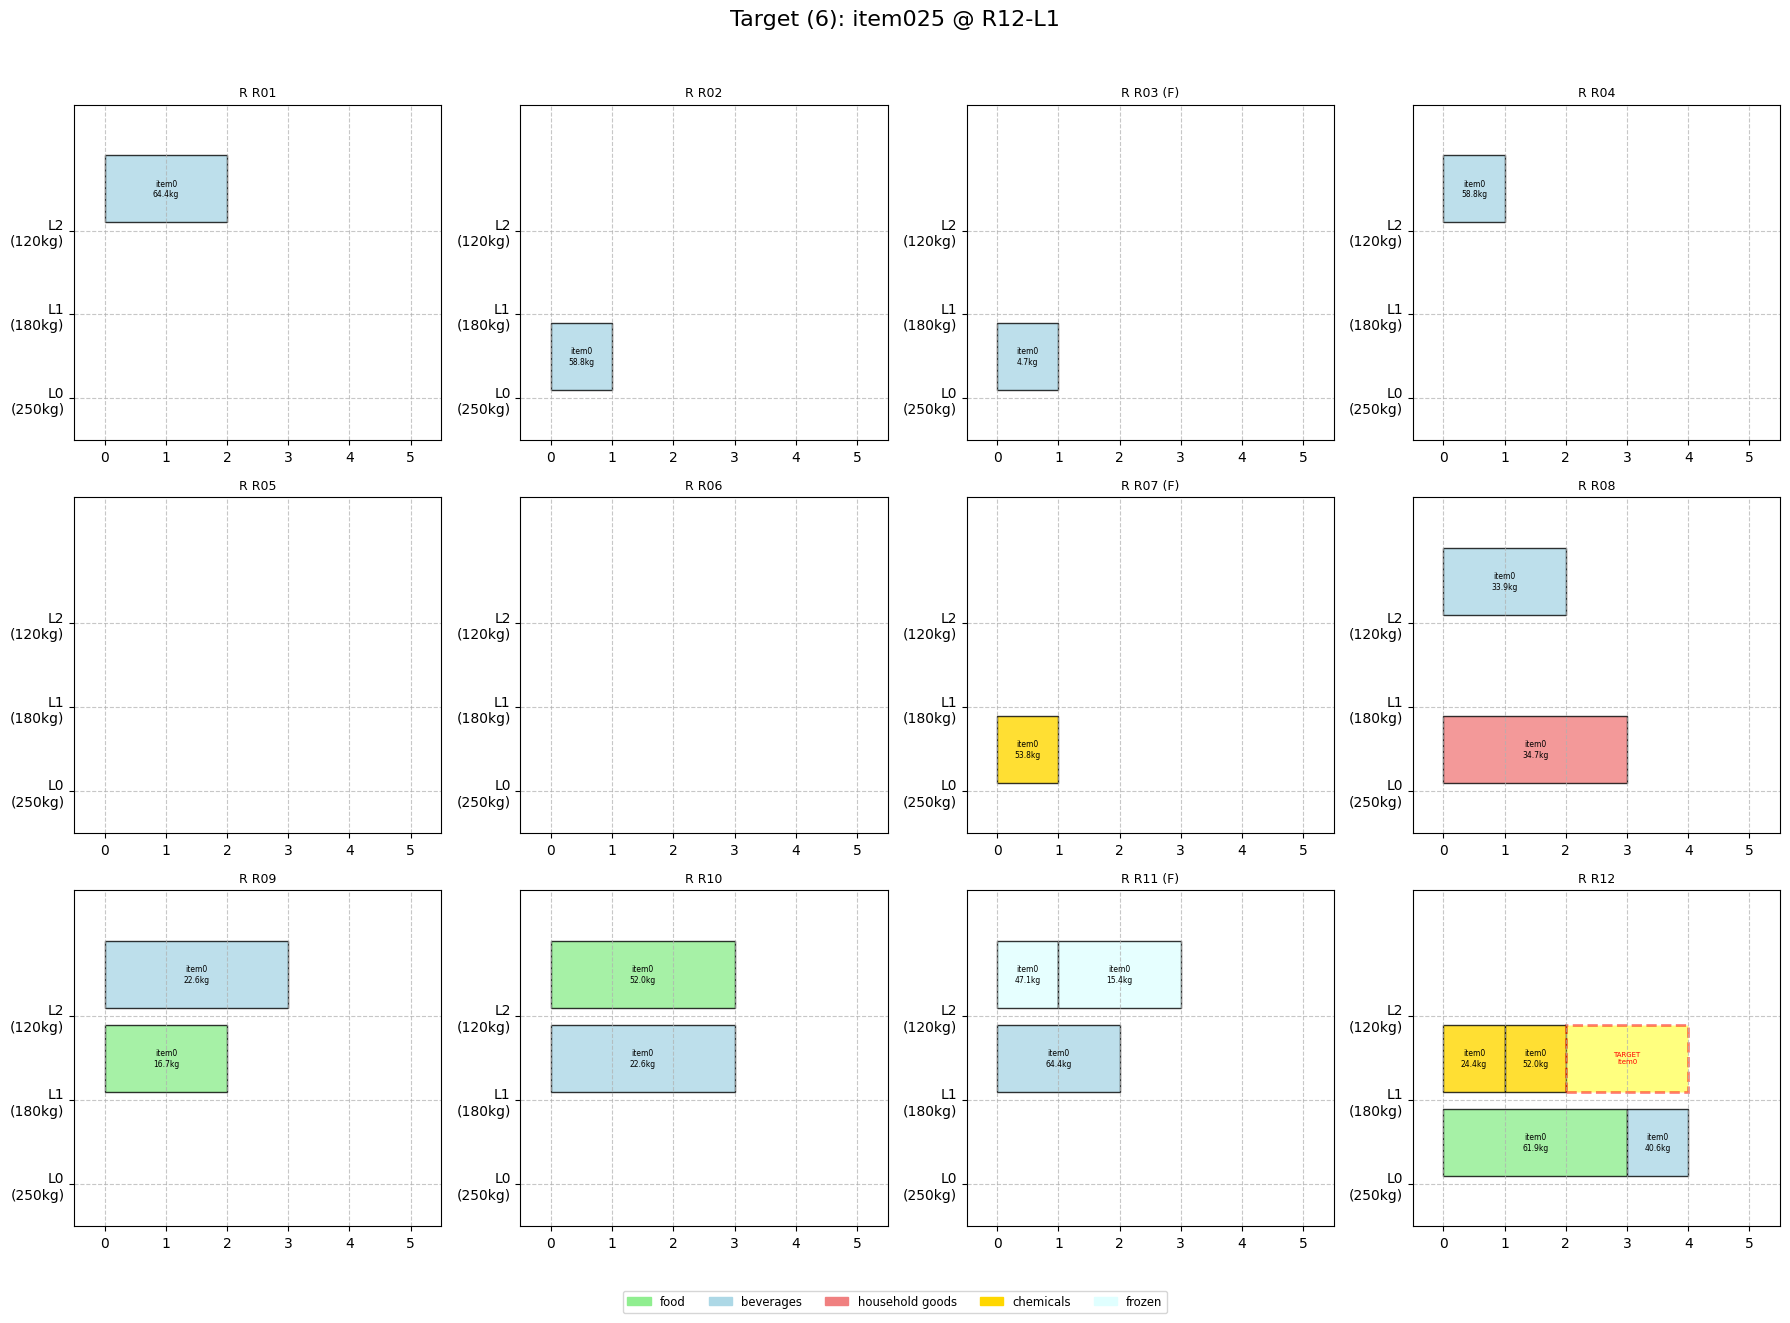


--- Placing item025 at ('R12', 1) ---


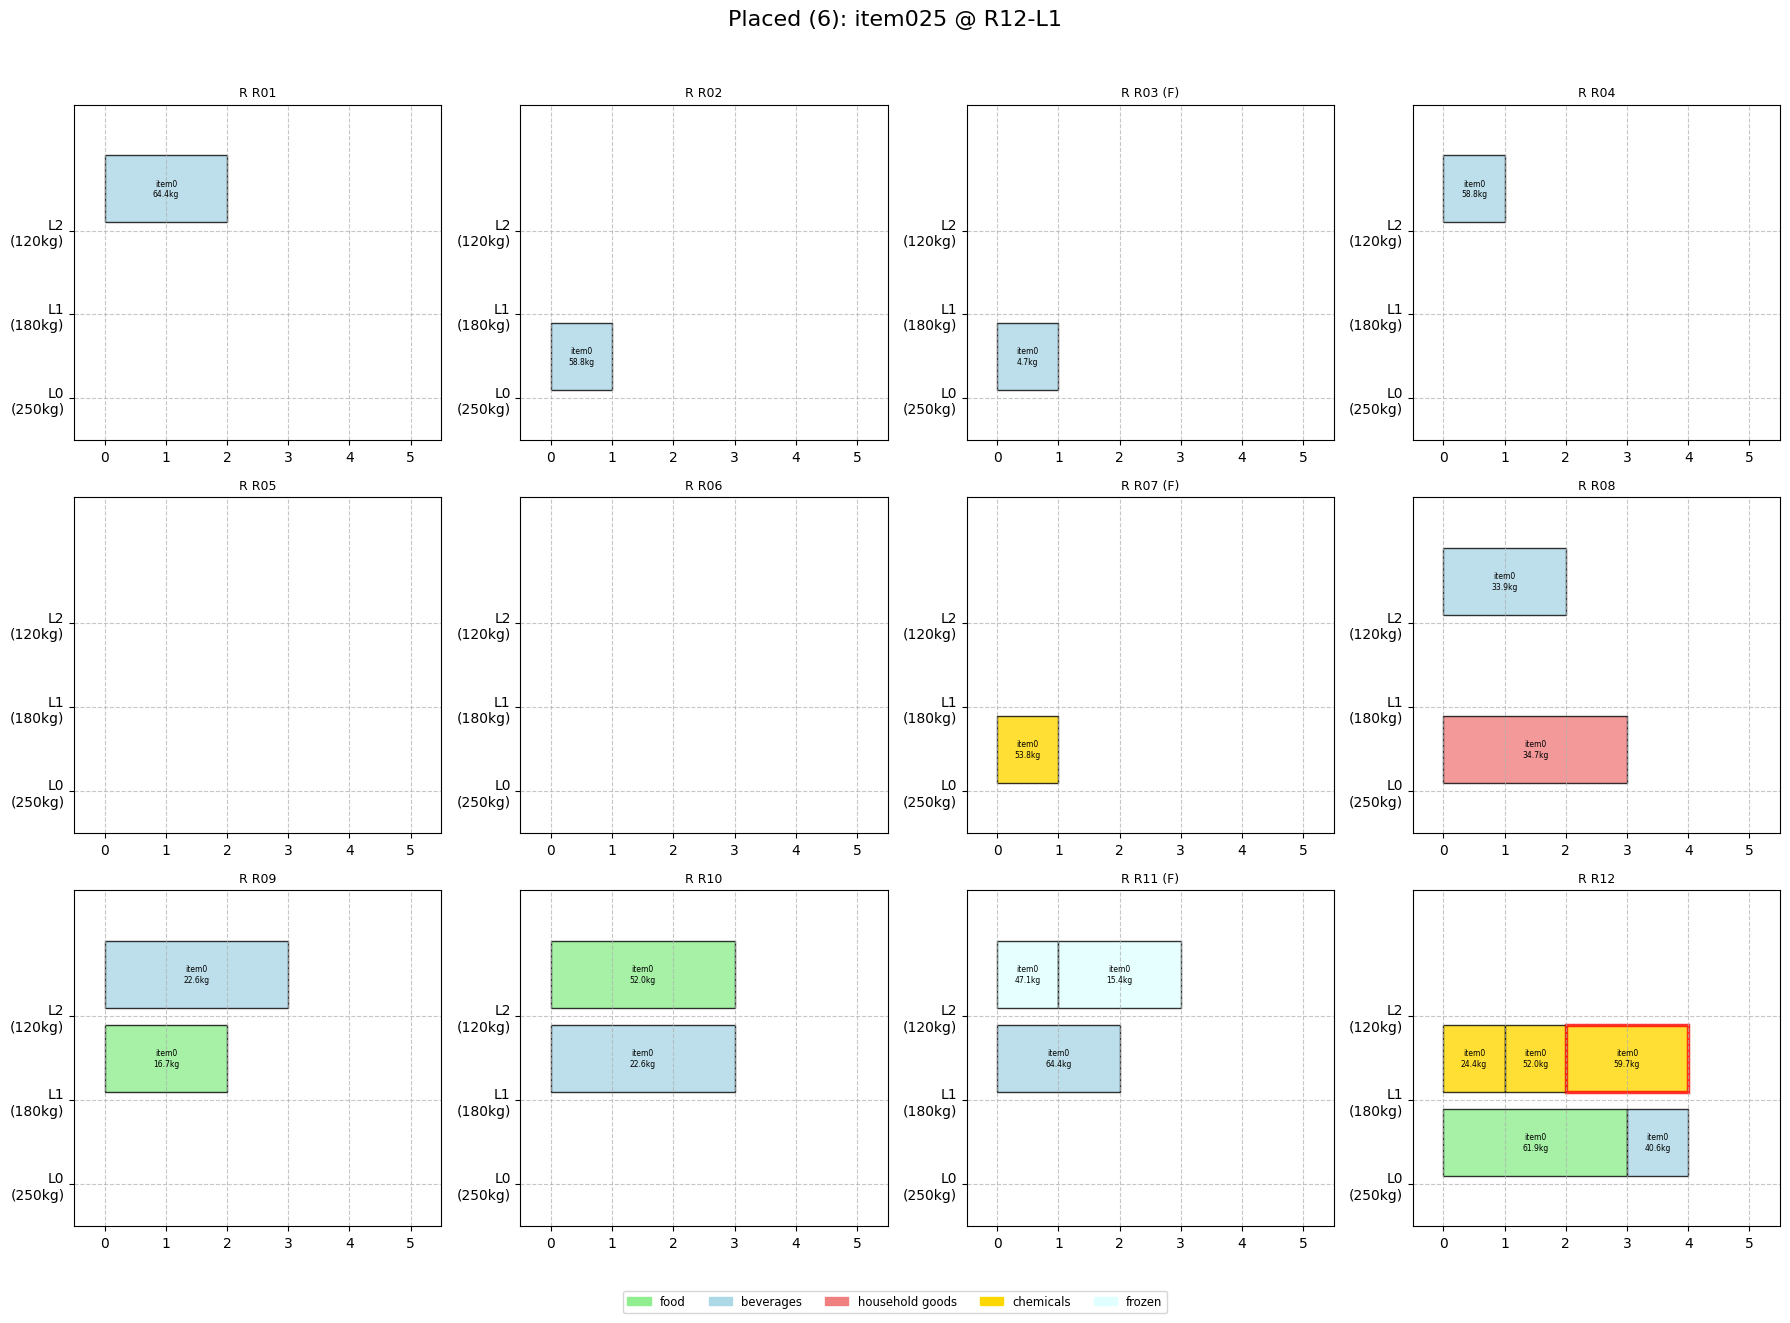



=============== ATTEMPTING INSERTION 7/10 FOR ITEM: item050 ===============

--- Evaluating Placements for: ItemData(item050,'Eco Beverages Box',W:1.2,S:2,Fq:6.83) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    5.12 | Category:1.00; Distance:4.12
R01-L1       |    5.12 | Category:1.00; Distance:4.12
R01-L2       |    6.62 | Category:2.00; Item:0.20; Space:0.30; Distance:4.12
R02-L0       |    6.36 | Category:2.00; Distance:4.36
R02-L1       |    5.36 | Category:1.00; Distance:4.36
R02-L2       |    5.56 | Category:1.00; Item:0.20; Distance:4.36
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -4.00 | Frozen:-10.00; Category:1.00; Distance:5.00
R03-L2       |   -3.80 | Frozen:-10.00; Category:1.00; Item:0.20; Distance:5.00
R04-L0       |    

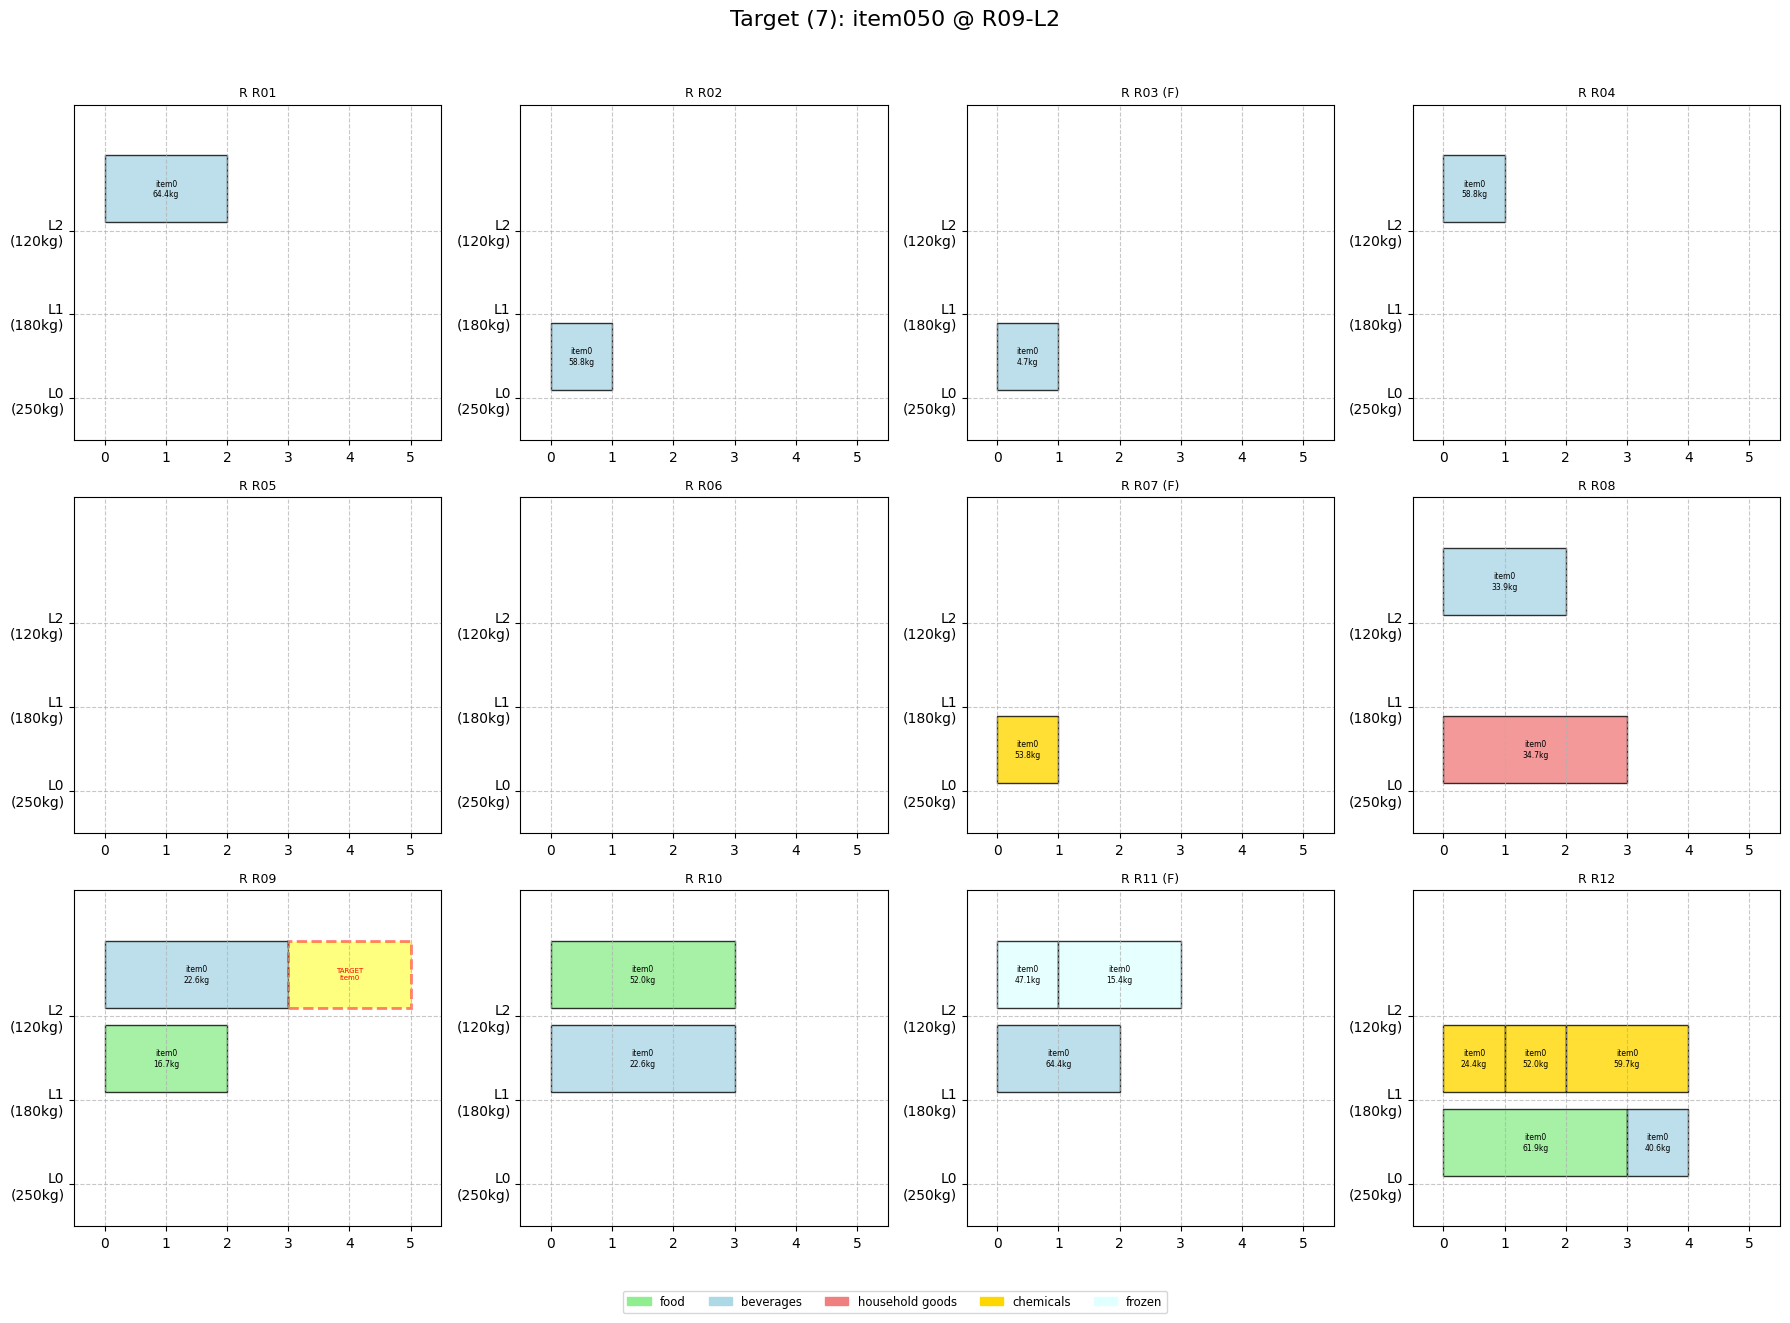


--- Placing item050 at ('R09', 2) ---


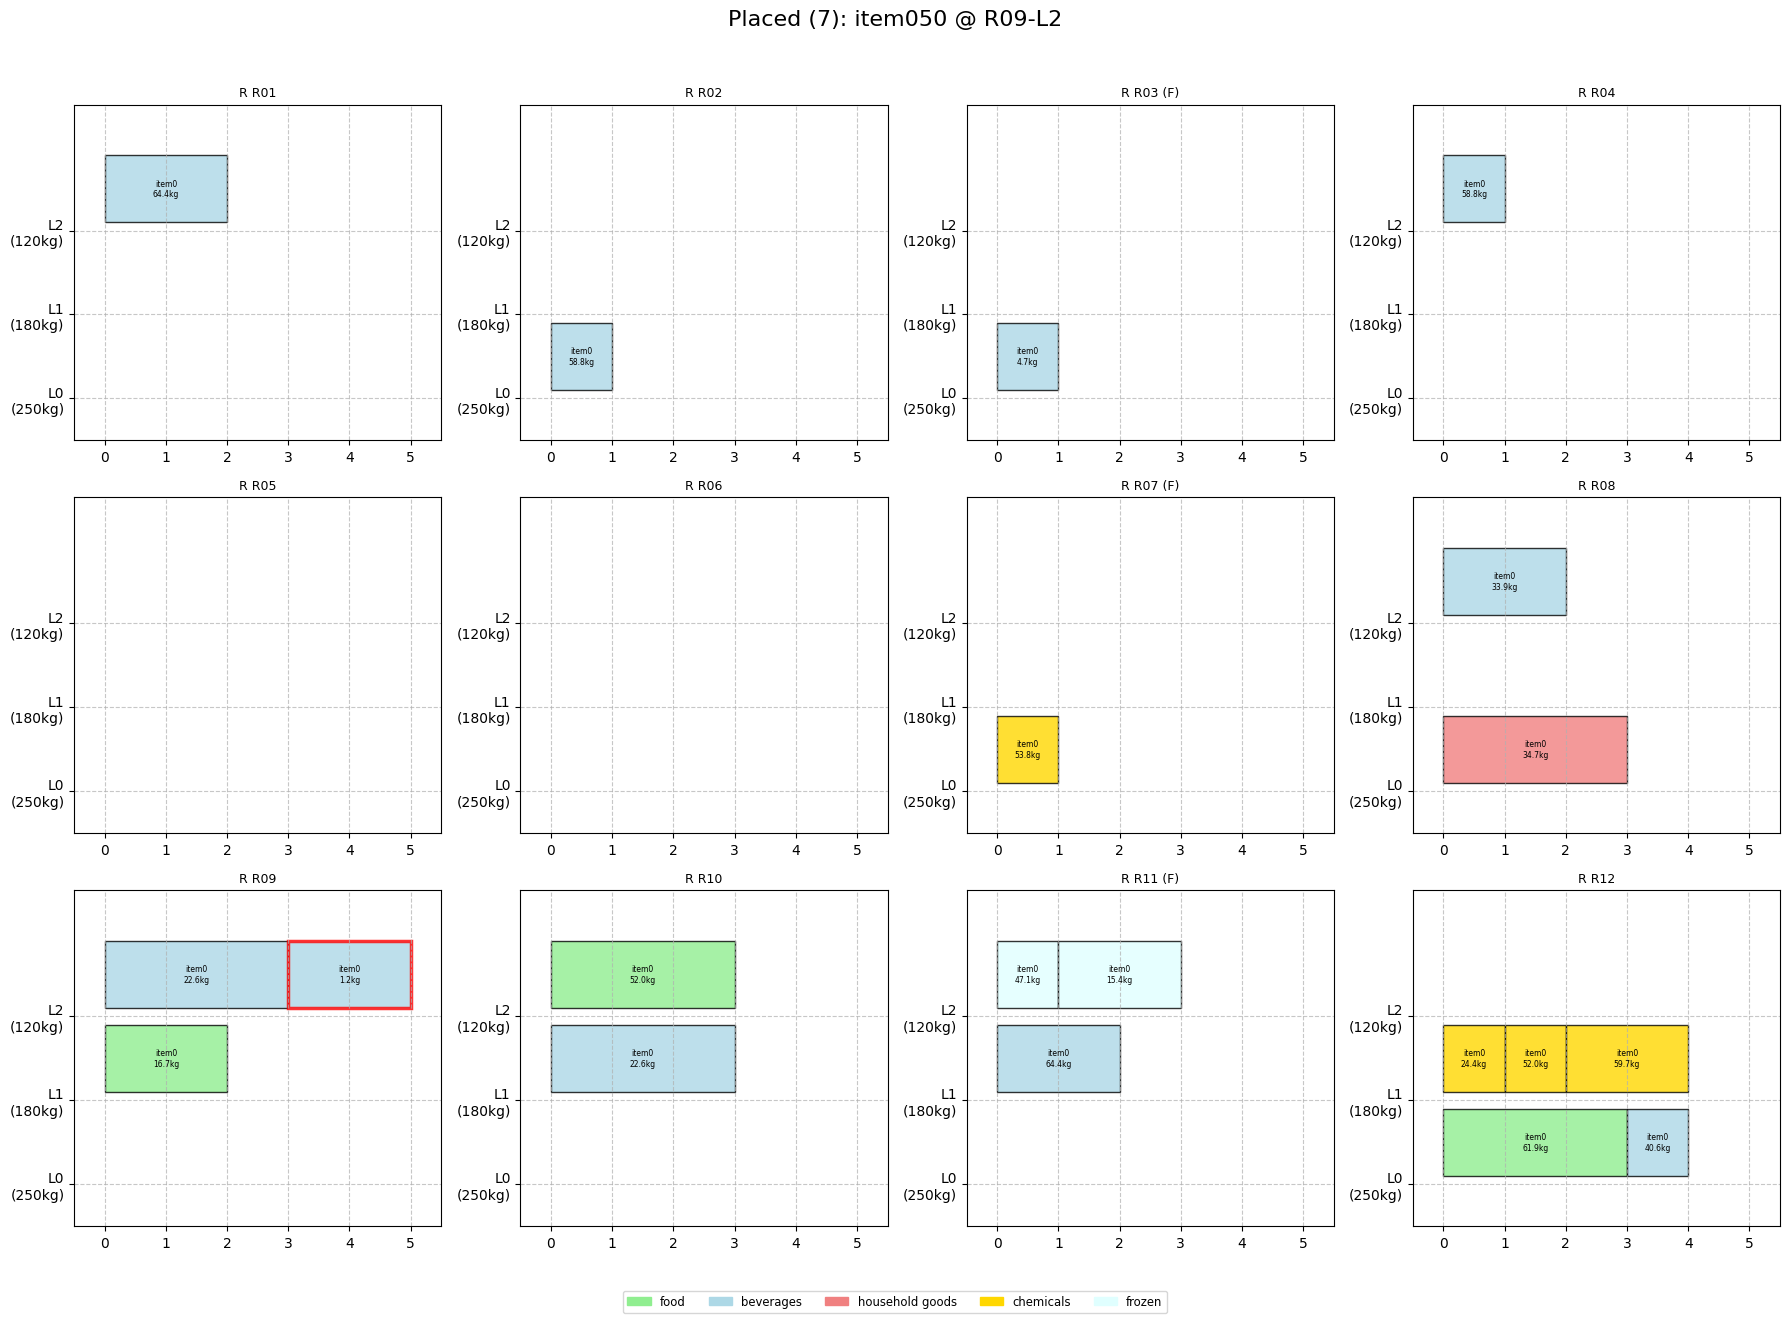



=============== ATTEMPTING INSERTION 8/10 FOR ITEM: item009 ===============

--- Evaluating Placements for: ItemData(item009,'Eco Chemicals Box',W:67.0,S:1,Fq:0.25) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    2.76 | Category:1.00; Item:1.50; Distance:0.26
R01-L1       |    1.76 | Category:1.00; Item:0.50; Distance:0.26
R01-L2       |    -inf | Shelf:FAIL
R02-L0       |    1.78 | Item:1.50; Distance:0.28
R02-L1       |    1.78 | Category:1.00; Item:0.50; Distance:0.28
R02-L2       |    0.28 | Category:1.00; Item:-1.00; Distance:0.28
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -8.11 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:0.39
R03-L2       |   -9.61 | Frozen:-10.00; Category:1.00; Item:-1.00; Distance:0.39
R04-L0       |  

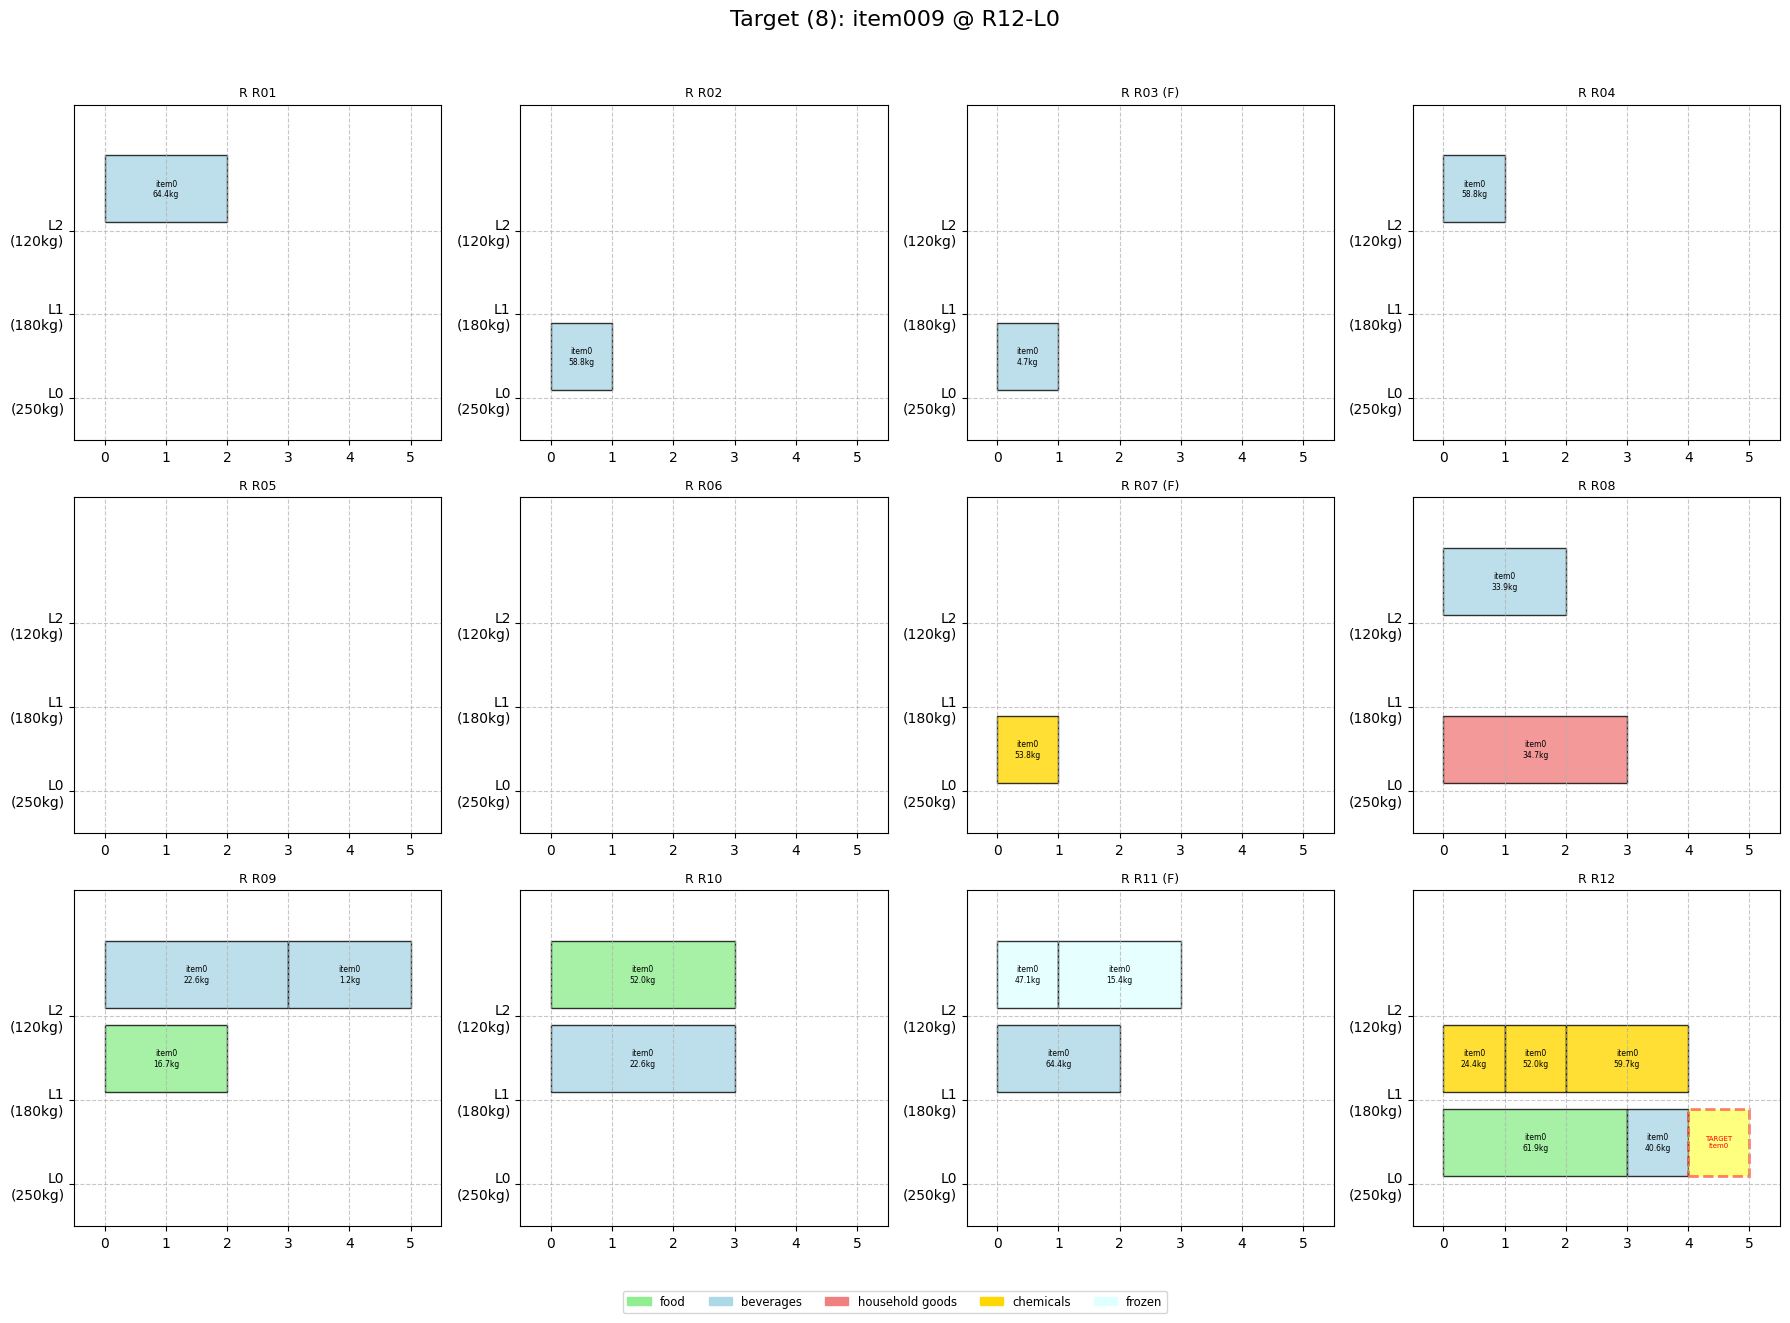


--- Placing item009 at ('R12', 0) ---


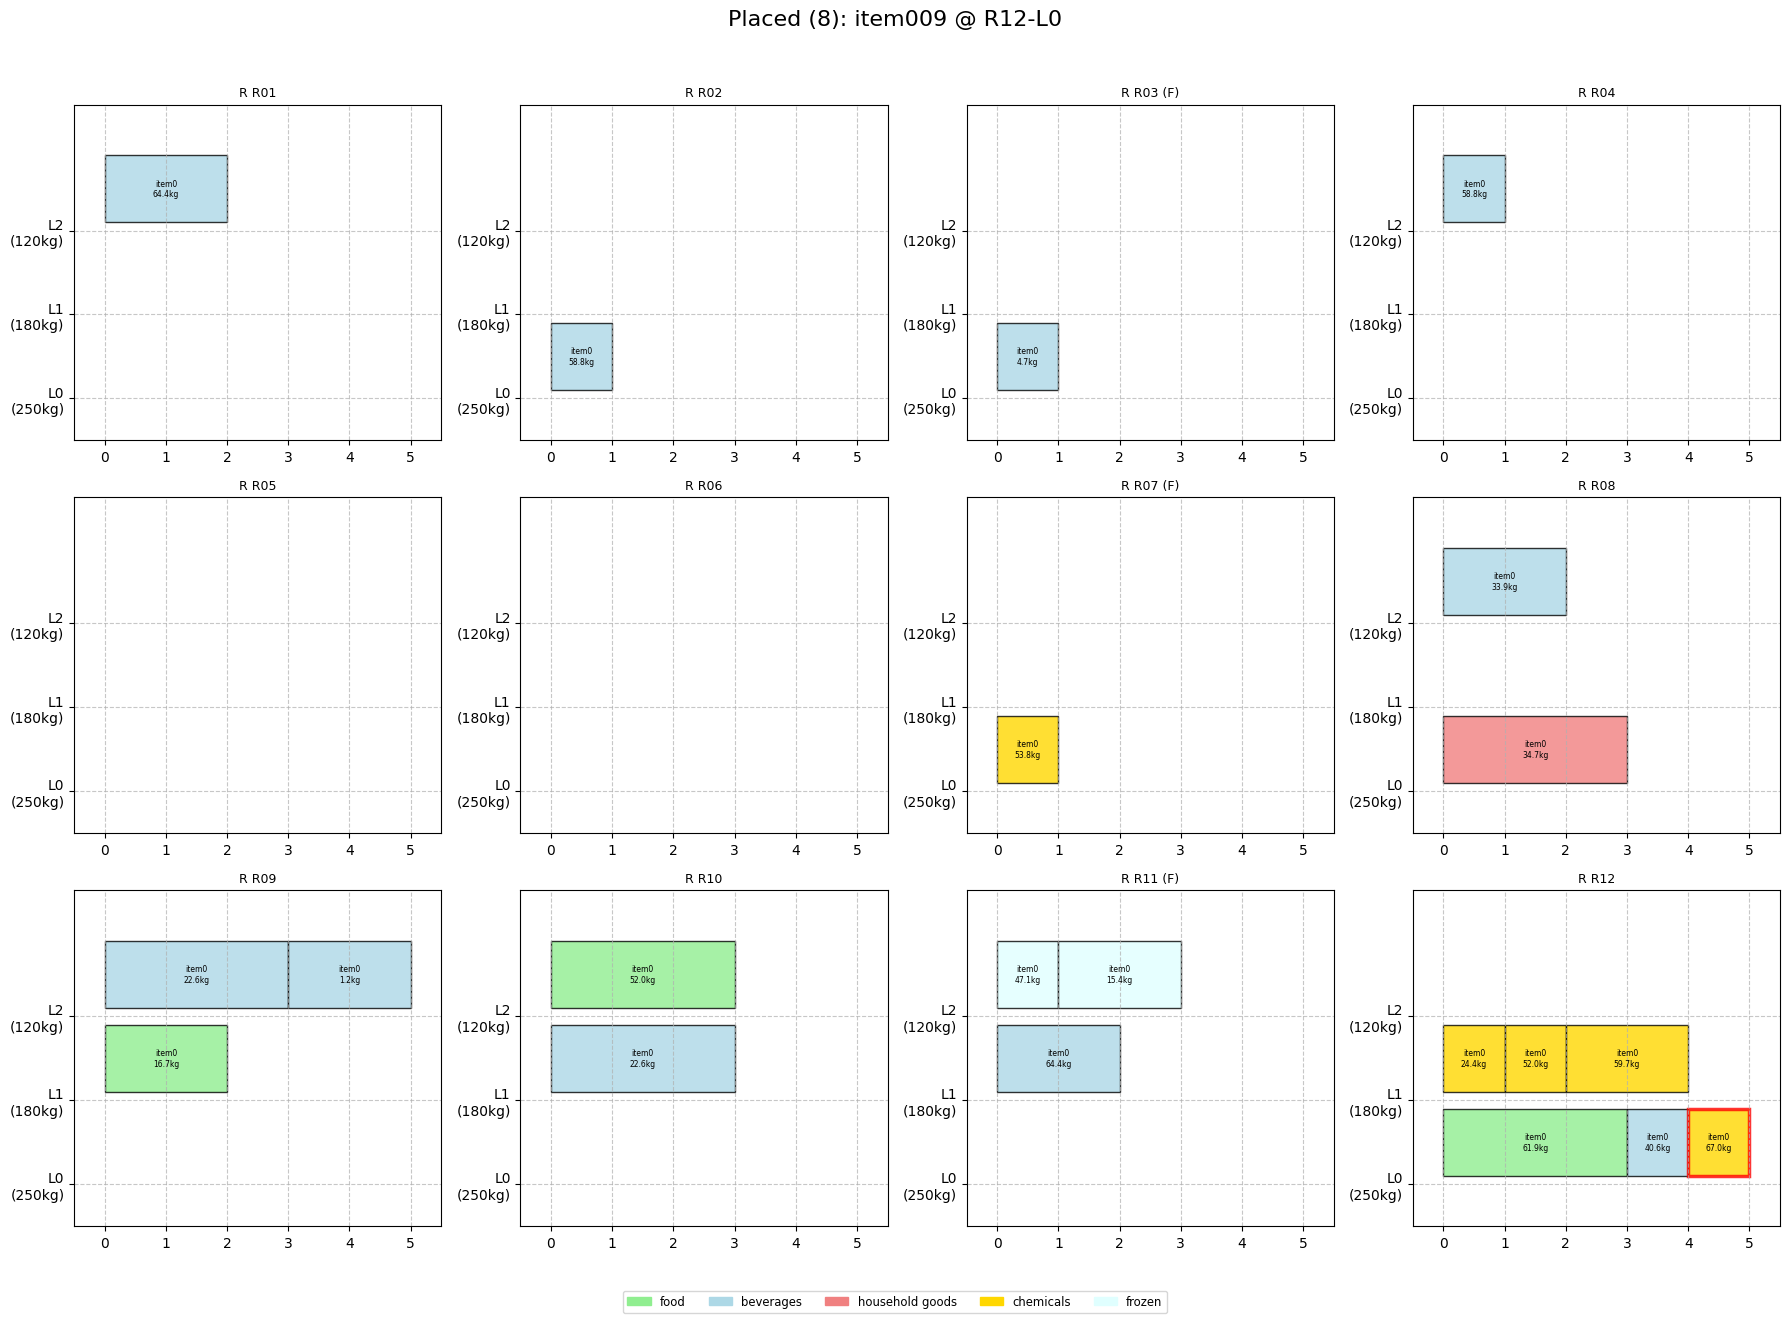



=============== ATTEMPTING INSERTION 9/10 FOR ITEM: item011 ===============

--- Evaluating Placements for: ItemData(item011,'Value Frozen Box',W:12.2,S:2,Fq:2.38) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    -inf | Frozen:FAIL
R01-L1       |    -inf | Frozen:FAIL
R01-L2       |    -inf | Frozen:FAIL
R02-L0       |    -inf | Frozen:FAIL
R02-L1       |    -inf | Frozen:FAIL
R02-L2       |    -inf | Frozen:FAIL
R03-L0       |    2.47 | Category:0.20; Distance:2.27
R03-L1       |    3.27 | Category:1.00; Distance:2.27
R03-L2       |    3.47 | Category:1.00; Item:0.20; Distance:2.27
R04-L0       |    -inf | Frozen:FAIL
R04-L1       |    -inf | Frozen:FAIL
R04-L2       |    -inf | Frozen:FAIL
R05-L0       |    -inf | Frozen:FAIL
R05-L1       |    -

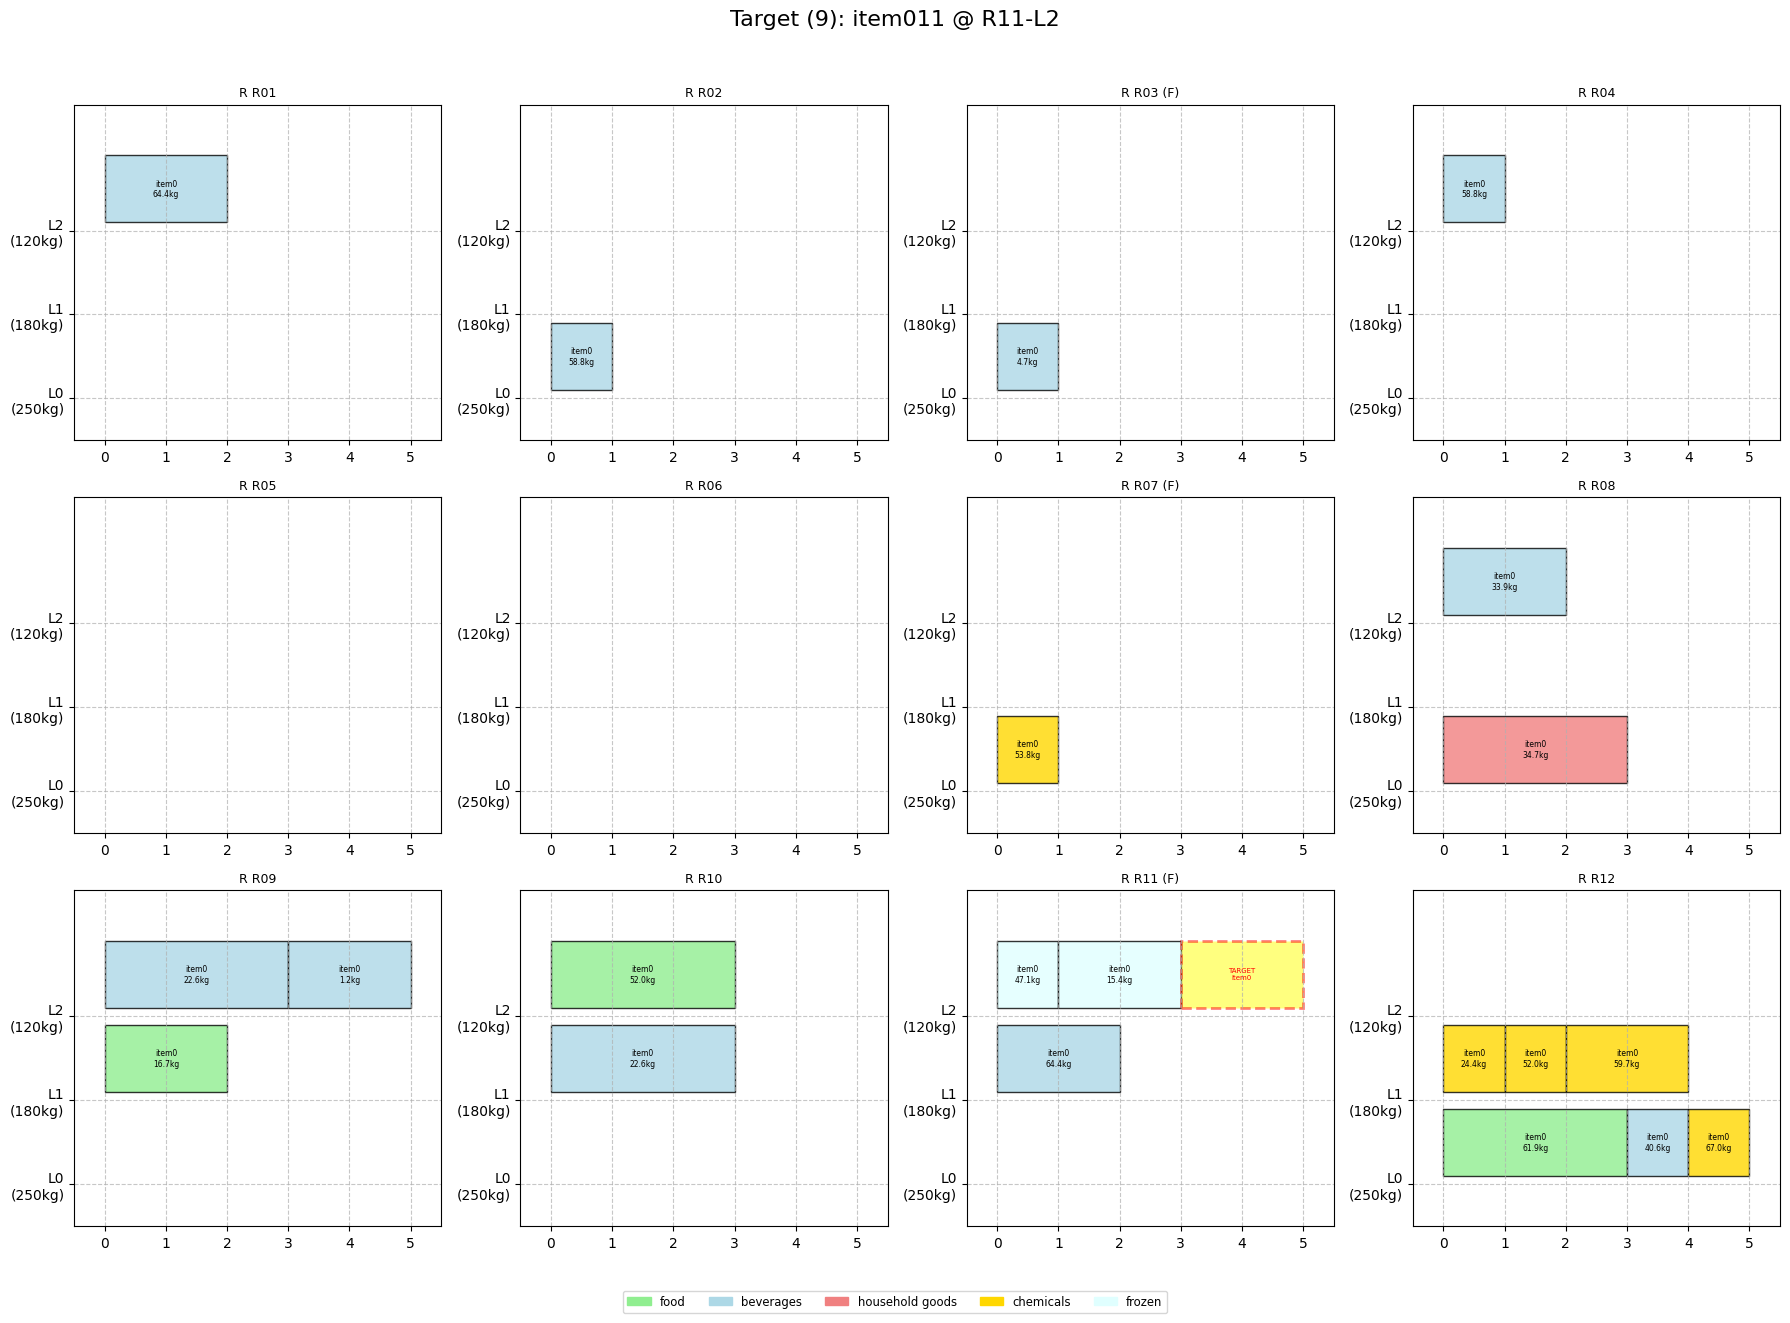


--- Placing item011 at ('R11', 2) ---


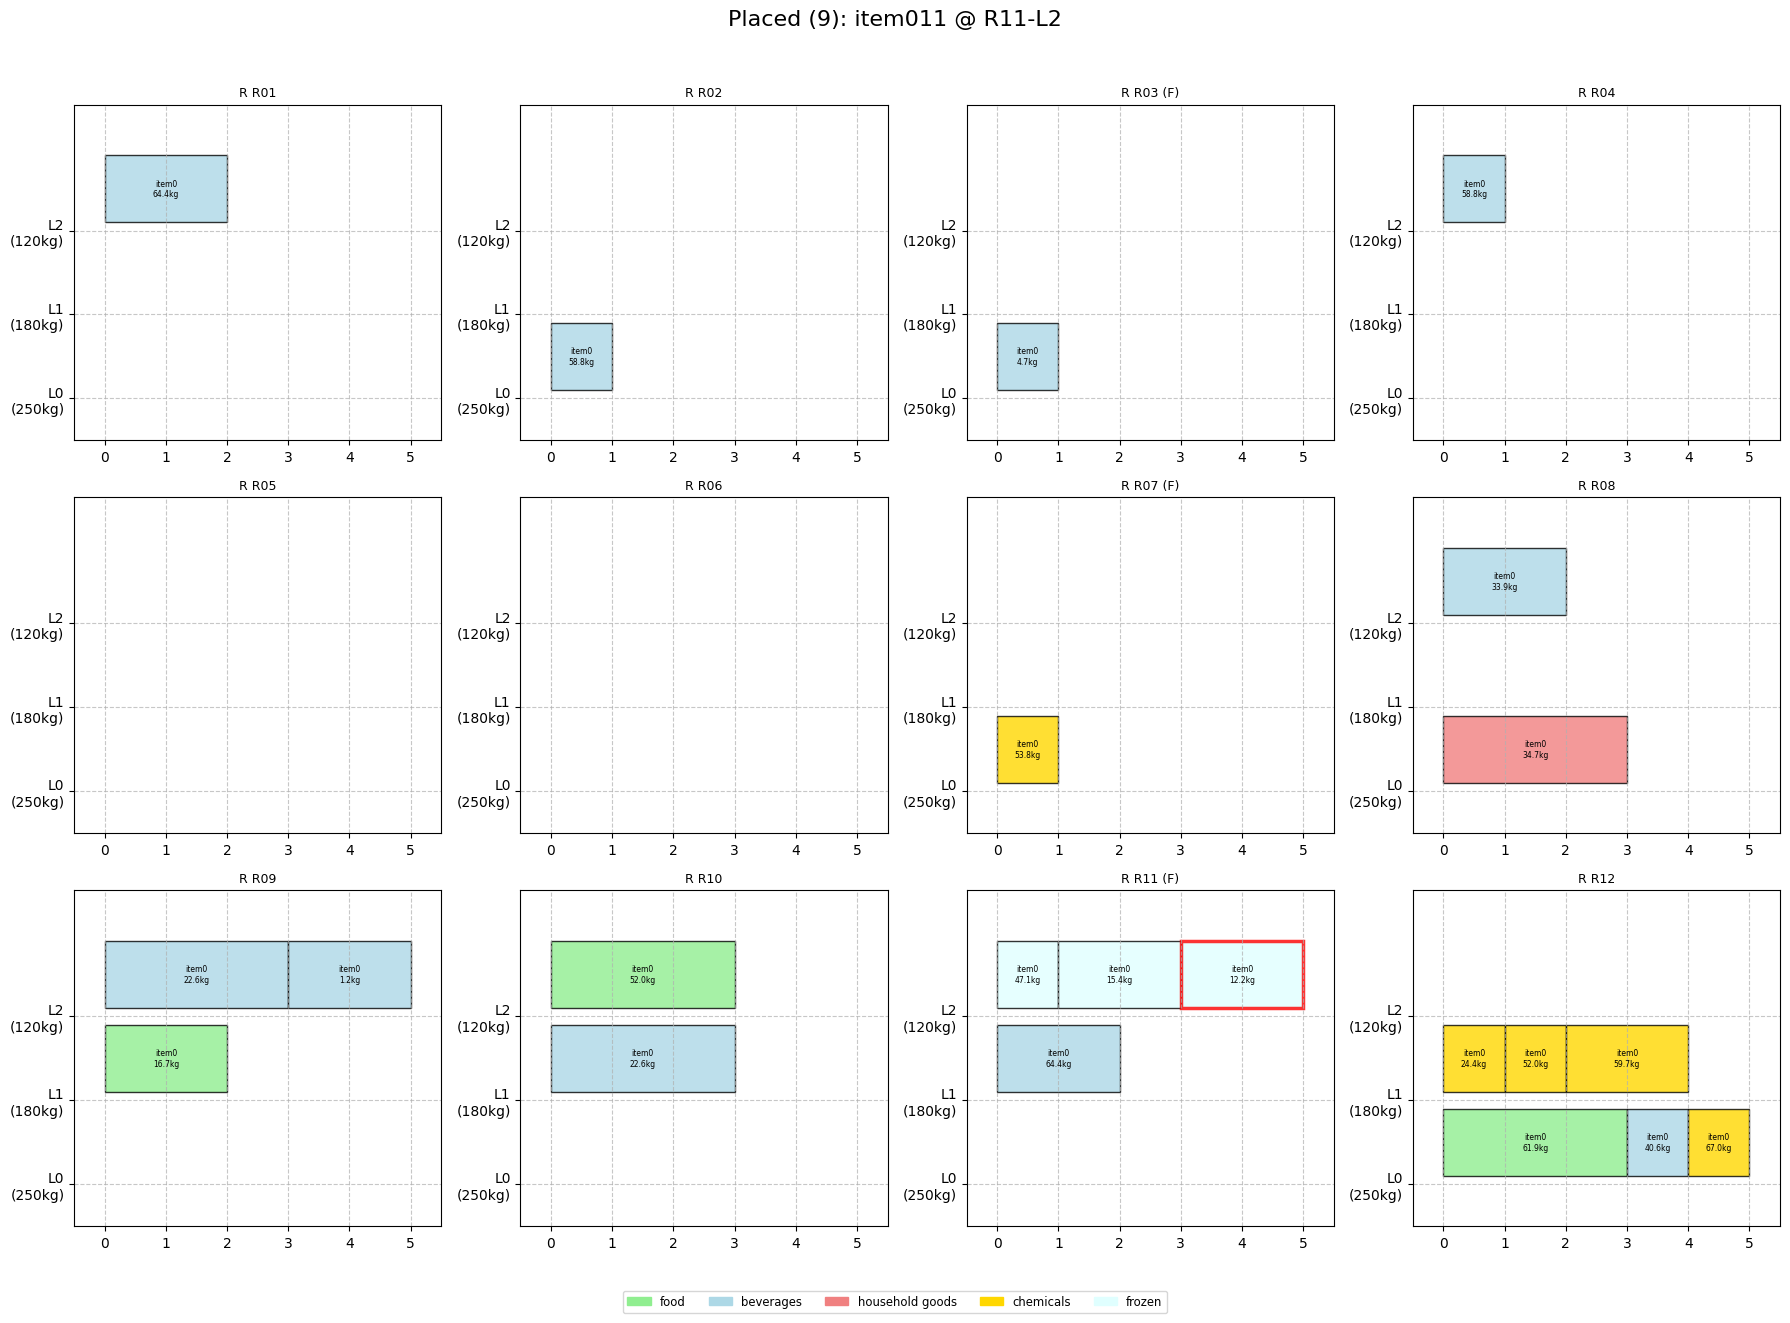



=============== ATTEMPTING INSERTION 10/10 FOR ITEM: item032 ===============

--- Evaluating Placements for: ItemData(item032,'Eco Chemicals Box',W:28.9,S:1,Fq:3.29) ---
------------------------------------------------------------------------------------------
Location     |   Score | Reason/Breakdown                                            
------------------------------------------------------------------------------------------
R01-L0       |    4.54 | Category:1.00; Item:1.50; Distance:2.04
R01-L1       |    3.54 | Category:1.00; Item:0.50; Distance:2.04
R01-L2       |    1.04 | Item:-1.00; Distance:2.04
R02-L0       |    3.67 | Item:1.50; Distance:2.17
R02-L1       |    3.67 | Category:1.00; Item:0.50; Distance:2.17
R02-L2       |    2.17 | Category:1.00; Item:-1.00; Distance:2.17
R03-L0       |    -inf | Frozen:FAIL
R03-L1       |   -5.44 | Frozen:-10.00; Category:1.00; Item:0.50; Distance:3.06
R03-L2       |   -6.94 | Frozen:-10.00; Category:1.00; Item:-1.00; Distance:3.06


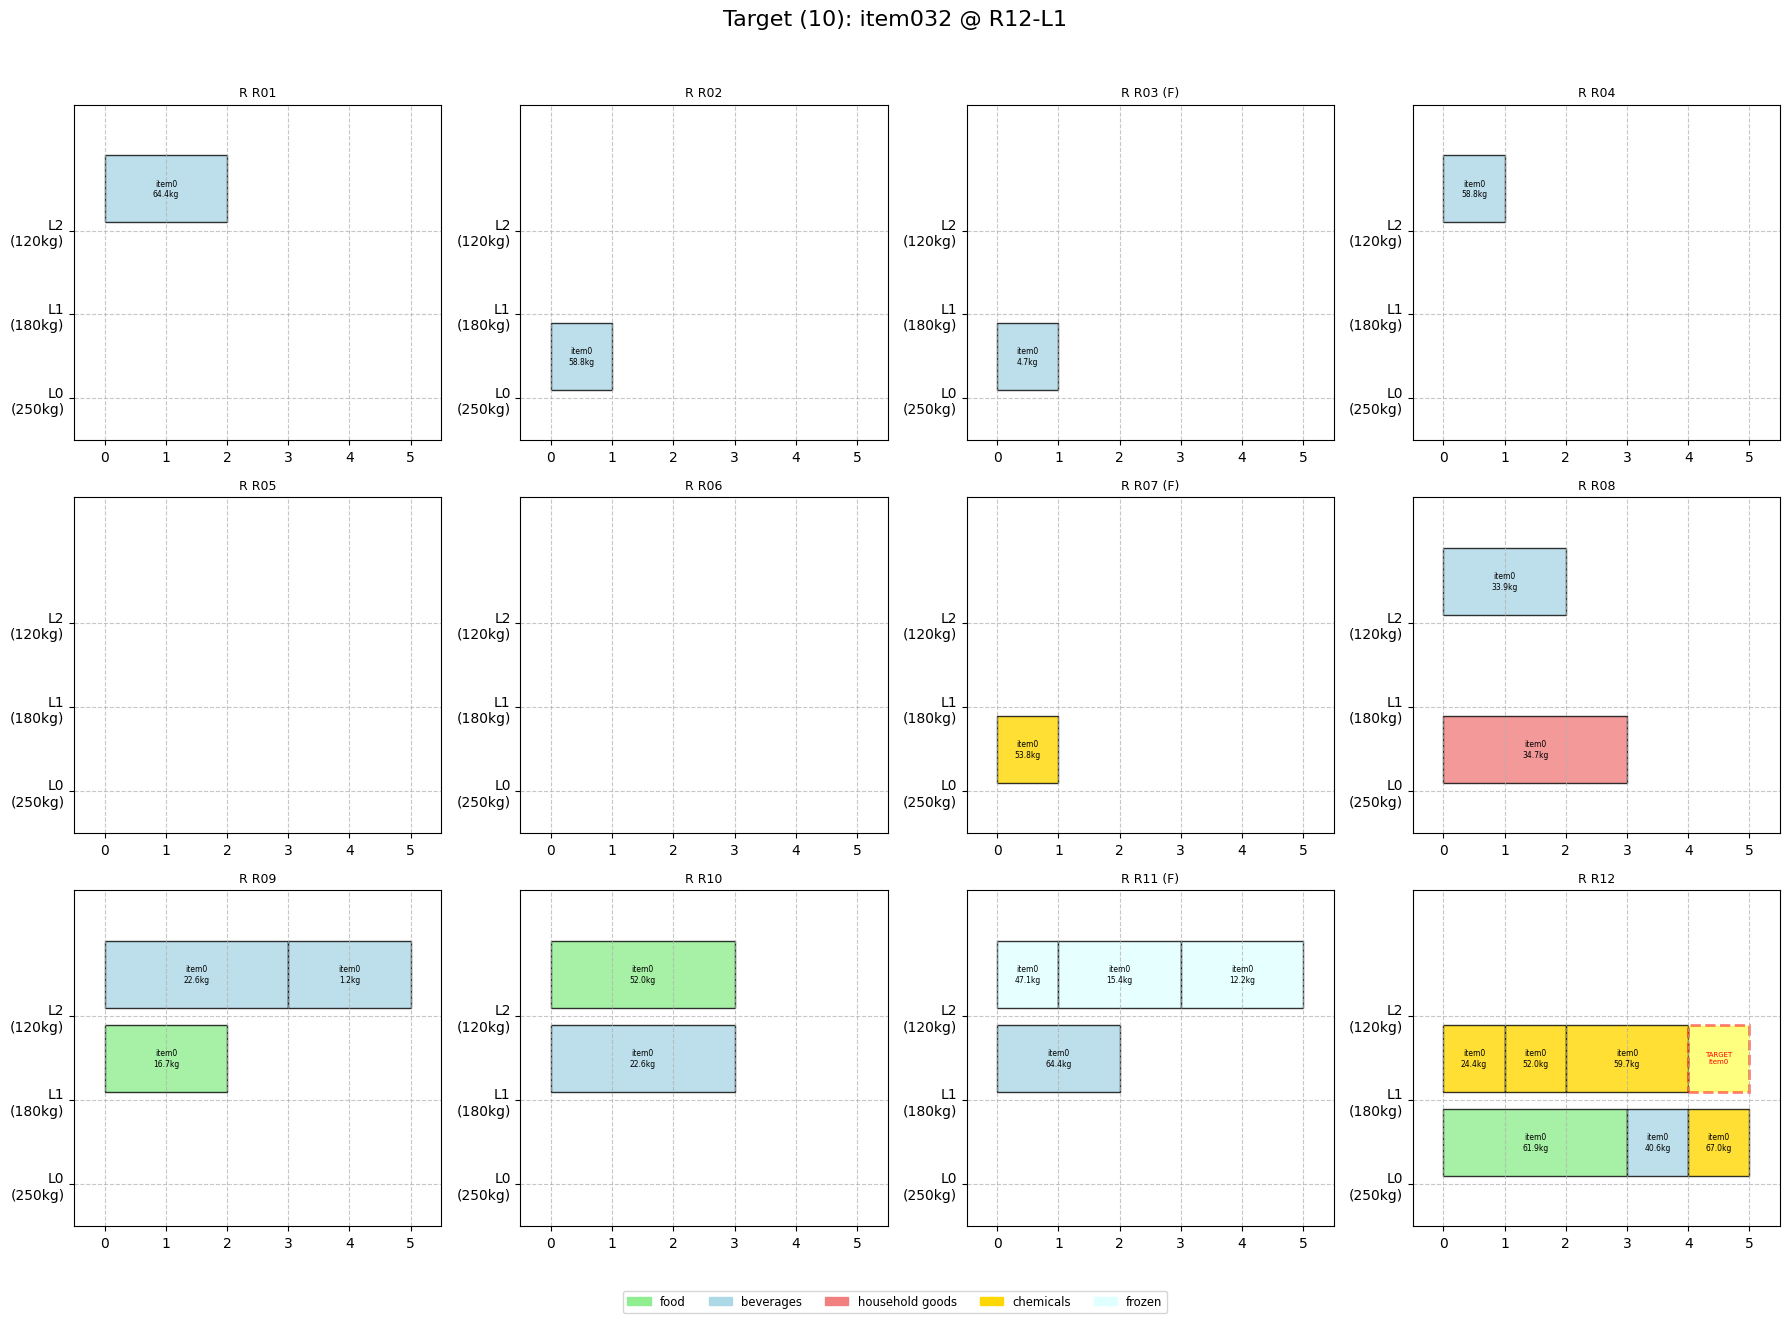


--- Placing item032 at ('R12', 1) ---


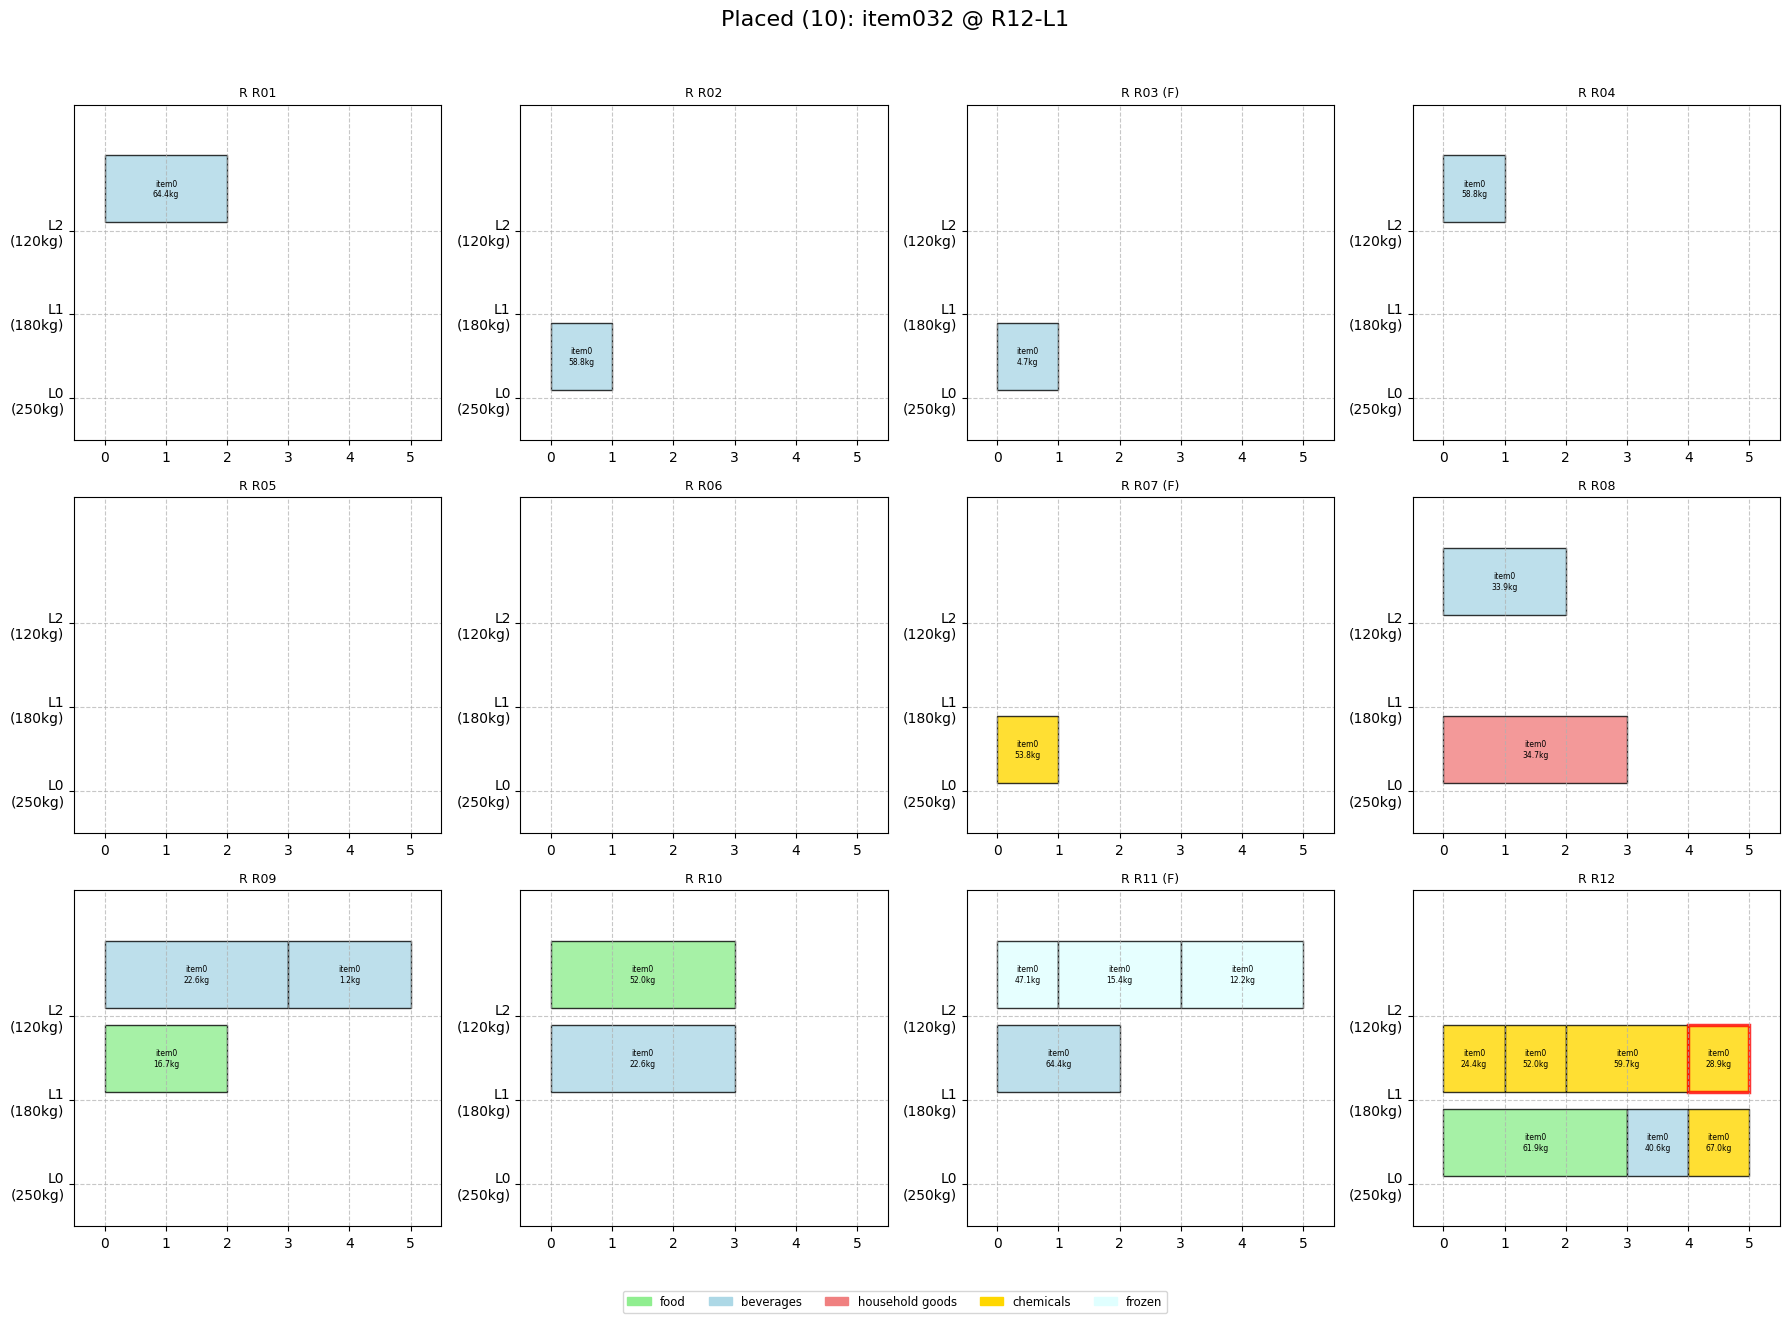


--- Final Warehouse State After All Attempts ---


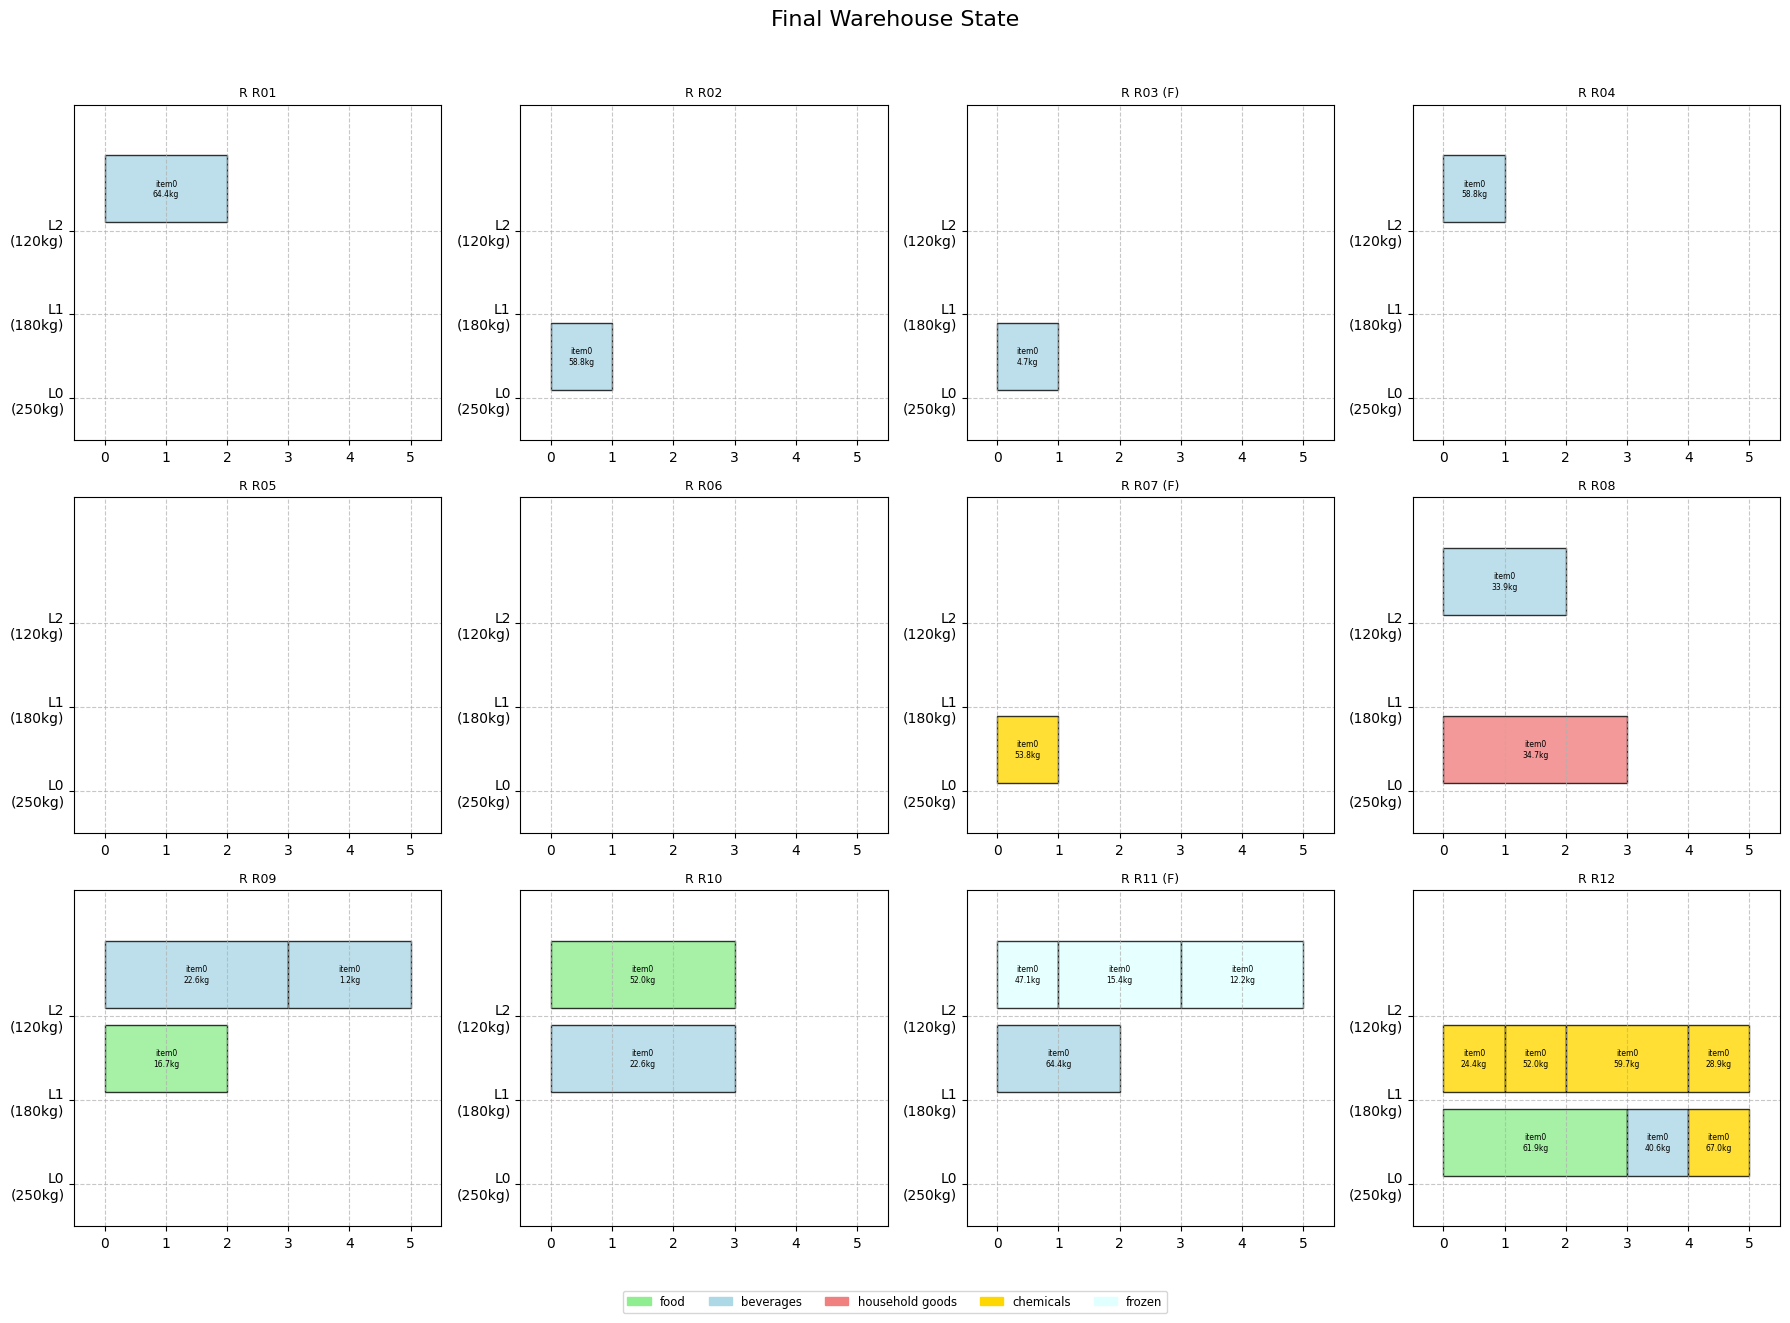



--- SUMMARY OF SUCCESSFUL PLACEMENTS ---
Item ID: item017 (Name: Premium Food Unit) placed at Rack: R12, Shelf: L0 (Score: 6.62)
Item ID: item028 (Name: Value Frozen Pack) placed at Rack: R11, Shelf: L2 (Score: 7.20)
Item ID: item026 (Name: Value Chemicals Pack) placed at Rack: R12, Shelf: L1 (Score: 7.50)
Item ID: item048 (Name: Premium Beverages Box) placed at Rack: R12, Shelf: L0 (Score: 8.40)
Item ID: item027 (Name: Eco Household goods Unit) placed at Rack: R08, Shelf: L0 (Score: 7.50)
Item ID: item025 (Name: Eco Chemicals Box) placed at Rack: R12, Shelf: L1 (Score: 7.80)
Item ID: item050 (Name: Eco Beverages Box) placed at Rack: R09, Shelf: L2 (Score: 8.00)
Item ID: item009 (Name: Eco Chemicals Box) placed at Rack: R12, Shelf: L0 (Score: 3.31)
Item ID: item011 (Name: Value Frozen Box) placed at Rack: R11, Shelf: L2 (Score: 4.56)
Item ID: item032 (Name: Eco Chemicals Box) placed at Rack: R12, Shelf: L1 (Score: 8.30)


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import json
import csv
import random
import math
import pandas as pd

# --- CONFIGURATION & CONSTANTS ---
MAX_SLOTS_PER_SHELF = 5
SHELF_LEVELS = 3
HEAVY_ITEM_THRESHOLD = 20
DISTANCE_BASE_FACTOR = 0.1
FREQUENCY_DISTANCE_MULTIPLIER = 5.0
MAX_DISTANCE_SCORE_CONTRIBUTION = 5.0

COMPATIBILITY_MATRIX = {
    'food':           {'food': 1.0, 'beverages': 0.8, 'household goods': 0.2, 'chemicals': 0.0, 'frozen': 0.1},
    'beverages':      {'food': 0.8, 'beverages': 1.0, 'household goods': 0.3, 'chemicals': 0.0, 'frozen': 0.1},
    'household goods':{'food': 0.2, 'beverages': 0.3, 'household goods': 1.0, 'chemicals': 0.1, 'frozen': 0.05},
    'chemicals':      {'food': 0.0, 'beverages': 0.0, 'household goods': 0.1, 'chemicals': 1.0, 'frozen': 0.0},
    'frozen':         {'food': 0.1, 'beverages': 0.1, 'household goods': 0.05, 'chemicals': 0.0, 'frozen': 1.0},
}
CATEGORY_COLORS = {
    'food': 'lightgreen', 'beverages': 'lightblue', 'household goods': 'lightcoral',
    'chemicals': 'gold', 'frozen': 'lightcyan', 'default': 'lightgrey'
}

ENTRANCE_COORDS_MAIN = None
ENTRANCE_COORDS_FROZEN = None
MAX_WEIGHT_PER_SHELF_LEVEL = None
SHELF_MAX_HEIGHT_PER_LEVEL = None

# --- DATA GENERATION FUNCTIONS ---
def generate_dummy_item_csv(filename="dummy_items.csv", num_items=30):
    categories = list(COMPATIBILITY_MATRIX.keys())
    items_data = []
    for i in range(num_items):
        item_id = f"item{str(i+1).zfill(3)}"
        category = random.choice(categories)
        name = f"{random.choice(['Premium', 'Value', 'Eco'])} {category.capitalize()} {random.choice(['Pack', 'Unit', 'Box'])}"
        weight = round(random.uniform(1, 75), 1)
        slots = random.randint(1, 3)
        retrieval_counter = random.randint(0, 100)
        insertion_counter = random.randint(1, 20)
        items_data.append([item_id, name, weight, category, slots, retrieval_counter, insertion_counter])
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'name', 'weight', 'category', 'slots_required', 'retrieval_counter', 'insertion_counter'])
        writer.writerows(items_data)
    print(f"Generated {filename} with {len(items_data)} items (incl. counters).")

def generate_dummy_rack_layout_csv(filename="dummy_rack_layout.csv", rack_ids=None, item_ids_for_layout=None):
    if rack_ids is None: rack_ids = [f"R{str(i+1).zfill(2)}" for i in range(8)]
    if item_ids_for_layout is None:
        try: temp_df = pd.read_csv("dummy_items.csv"); item_ids_for_layout = list(temp_df['id'])
        except: item_ids_for_layout = [f"item{str(i+1).zfill(3)}" for i in range(30)]
    layout_data = []; item_slots_map = {}
    try: df_items = pd.read_csv("dummy_items.csv"); item_slots_map = dict(zip(df_items['id'], df_items['slots_required']))
    except: pass
    for rack_id in rack_ids:
        for shelf_level in range(SHELF_LEVELS):
            num_items_on_shelf = random.randint(0,1)
            current_slots, items_placed = 0,0
            shuffled_items = random.sample(item_ids_for_layout, len(item_ids_for_layout))
            for item_id in shuffled_items:
                if items_placed >= num_items_on_shelf: break
                slots_needed = item_slots_map.get(item_id, random.randint(1,2))
                if current_slots + slots_needed <= MAX_SLOTS_PER_SHELF:
                    layout_data.append([rack_id, shelf_level, item_id])
                    current_slots += slots_needed; items_placed +=1
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile); writer.writerow(['rack_id', 'shelf_level', 'item_id']); writer.writerows(layout_data)
    print(f"Generated {filename} with initial layout.")


# --- HELPER FUNCTIONS ---
def euclidean_distance(p1, p2):
    if p1 is None or p2 is None: return float('inf')
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- CLASSES (ItemPlacementData, ShelfState, RackState, WarehousePlacementSystem as provided before) ---
class ItemPlacementData:
    def __init__(self, item_id, name, weight, category, slots_required, retrieval_counter=0, insertion_counter=1):
        self.item_id = item_id
        self.name = name
        self.weight = float(weight)
        self.category = category
        self.slots_required = int(slots_required)
        self.retrieval_counter = int(retrieval_counter)
        self.insertion_counter = max(1, int(insertion_counter))
        self.is_frozen = (category == 'frozen')

    @property
    def frequency_metric(self):
        return self.retrieval_counter / self.insertion_counter

    def __repr__(self):
        return f"ItemData({self.item_id},'{self.name}',W:{self.weight},S:{self.slots_required},Fq:{self.frequency_metric:.2f})"

class ShelfState:
    def __init__(self, shelf_level_index, max_slots=MAX_SLOTS_PER_SHELF):
        self.shelf_level_index = shelf_level_index
        self.max_slots = max_slots
        self.items_on_shelf = []
        self.occupied_slots = 0
        self.current_weight_on_shelf = 0.0

    @property
    def available_slots(self):
        return self.max_slots - self.occupied_slots

    def can_add_item(self, item_data: ItemPlacementData, max_weight_for_this_level: float):
        if self.available_slots < item_data.slots_required:
            return False, "slot_capacity"
        if self.current_weight_on_shelf + item_data.weight > max_weight_for_this_level:
            return False, "weight_limit"
        return True, "ok"

    def add_item(self, item_data: ItemPlacementData, max_weight_for_this_level: float):
        can_add_flag, _ = self.can_add_item(item_data, max_weight_for_this_level)
        if can_add_flag:
            self.items_on_shelf.append(item_data)
            self.occupied_slots += item_data.slots_required
            self.current_weight_on_shelf += item_data.weight
            return True
        return False

    def __repr__(self):
        return f"ShelfState(L{self.shelf_level_index},{self.occupied_slots}/{self.max_slots}s,{self.current_weight_on_shelf:.1f}kg)"

class RackState:
    def __init__(self, rack_id_str, is_rack_frozen=False, rack_center_coords=None):
        self.rack_id_str = rack_id_str
        self.is_rack_frozen = is_rack_frozen
        self.rack_center_coords = tuple(rack_center_coords) if rack_center_coords else (0,0)
        self.shelf_states = [ShelfState(shelf_level_index=i) for i in range(SHELF_LEVELS)]

    def get_shelf_state(self, shelf_level_index):
        return self.shelf_states[shelf_level_index] if 0 <= shelf_level_index < SHELF_LEVELS else None

    def __repr__(self):
        return f"RackState({self.rack_id_str},Frozen:{self.is_rack_frozen},Center:{self.rack_center_coords})"

class WarehousePlacementSystem:
    def __init__(self, facts_json_file="facts.json"):
        self.rack_states_map = {}
        self.item_database = {}
        self.main_entrance_coords = None
        self.frozen_区域_entrance_coords = None
        self.max_weight_config_per_level = None
        self.shelf_max_height_config_per_level = None
        self._load_configuration_from_facts(facts_json_file)

    def _load_configuration_from_facts(self, facts_json_file):
        global ENTRANCE_COORDS_MAIN, ENTRANCE_COORDS_FROZEN, MAX_WEIGHT_PER_SHELF_LEVEL, SHELF_MAX_HEIGHT_PER_LEVEL
        try:
            with open(facts_json_file, 'r') as f: facts_data = json.load(f)
            self.main_entrance_coords = ENTRANCE_COORDS_MAIN = tuple(facts_data["entrance_coords"])
            self.frozen_区域_entrance_coords = ENTRANCE_COORDS_FROZEN = tuple(facts_data["frozen_entrance_coords"])
            self.max_weight_config_per_level = MAX_WEIGHT_PER_SHELF_LEVEL = facts_data["max_weight_per_level"]
            self.shelf_max_height_config_per_level = SHELF_MAX_HEIGHT_PER_LEVEL = facts_data["shelfs_max_height"]
            for rack_id_str, info in facts_data.get("racks_info", {}).items():
                self.rack_states_map[rack_id_str] = RackState(rack_id_str, info.get("is_frozen",False), info.get("center_coords"))
        except Exception as e:
            print(f"FATAL: Error loading configuration from '{facts_json_file}': {e}.")
            exit()

    def load_item_properties_from_csv(self, items_csv_file="dummy_items.csv"):
        try:
            df = pd.read_csv(items_csv_file)
            for _, row in df.iterrows():
                self.item_database[row['id']] = {
                    'name':row['name'],'weight':float(row['weight']), 'category':row['category'],
                    'slots_required':int(row['slots_required']), 
                    'retrieval_counter':int(row['retrieval_counter']),
                    'insertion_counter':int(row['insertion_counter'])
                }
        except Exception as e:
            print(f"Error loading item properties from '{items_csv_file}': {e}")

    def _get_item_placement_data_by_id(self, item_id_str: str) -> ItemPlacementData | None:
        properties = self.item_database.get(item_id_str)
        if properties: return ItemPlacementData(item_id_str, **properties)
        return None

    def initialize_layout_from_csv(self, layout_csv_file="dummy_rack_layout.csv"):
        if not self.max_weight_config_per_level: return
        try:
            df = pd.read_csv(layout_csv_file); items_added_count = 0
            for _, row in df.iterrows():
                rack_id_str, shelf_level_idx, item_id_str = row['rack_id'], int(row['shelf_level']), row['item_id']
                if rack_id_str in self.rack_states_map:
                    rack_state = self.rack_states_map[rack_id_str]
                    shelf_state = rack_state.get_shelf_state(shelf_level_idx)
                    if shelf_state:
                        item_data = self._get_item_placement_data_by_id(item_id_str)
                        if item_data:
                            is_valid_frozen_placement = not (item_data.is_frozen and not rack_state.is_rack_frozen) and \
                                           not (not item_data.is_frozen and rack_state.is_rack_frozen and shelf_state.items_on_shelf)
                            if is_valid_frozen_placement and shelf_state.add_item(item_data, self.max_weight_config_per_level[shelf_level_idx]):
                                items_added_count += 1
        except Exception as e:
            print(f"Error initializing layout from '{layout_csv_file}': {e}")


    def evaluate_potential_placement(self, item_to_place: ItemPlacementData, rack: RackState, shelf: ShelfState):
        score_components = {
            "base": 0.0, "slot_capacity_fail": 0.0, "shelf_weight_limit_fail": 0.0,
            "frozen_mismatch_penalty": 0.0, "category_compatibility_score": 0.0, "item_weight_placement_score": 0.0,
            "space_utilization_bonus": 0.0, "distance_frequency_bonus": 0.0
        }
        current_total_soft_score = 0

        can_add, reason_fail = shelf.can_add_item(item_to_place, self.max_weight_config_per_level[shelf.shelf_level_index])
        if not can_add:
            if reason_fail == "slot_capacity": score_components["slot_capacity_fail"] = -float('inf')
            elif reason_fail == "weight_limit": score_components["shelf_weight_limit_fail"] = -float('inf')
            return -float('inf'), score_components

        if item_to_place.is_frozen and not rack.is_rack_frozen:
            score_components["frozen_mismatch_penalty"] = -float('inf'); return -float('inf'), score_components
        if not item_to_place.is_frozen and rack.is_rack_frozen and shelf.items_on_shelf:
            score_components["frozen_mismatch_penalty"] = -float('inf'); return -float('inf'), score_components
        elif not item_to_place.is_frozen and rack.is_rack_frozen and not shelf.items_on_shelf:
             score_components["frozen_mismatch_penalty"] = -10.0

        cat_compat_val = sum(COMPATIBILITY_MATRIX.get(item_to_place.category,{}).get(ex.category,0.0) for ex in shelf.items_on_shelf)
        cat_compat_val = (cat_compat_val/len(shelf.items_on_shelf))*2.0 if shelf.items_on_shelf else 1.0
        score_components["category_compatibility_score"] = cat_compat_val; current_total_soft_score += cat_compat_val

        item_w_place_val = 0
        if item_to_place.weight > HEAVY_ITEM_THRESHOLD:
            if shelf.shelf_level_index == 0: item_w_place_val = 1.5
            elif shelf.shelf_level_index == 1: item_w_place_val = 0.5
            else: item_w_place_val = -1.0
        else:
            if shelf.shelf_level_index == 2: item_w_place_val = 0.2
        score_components["item_weight_placement_score"] = item_w_place_val; current_total_soft_score += item_w_place_val
        
        new_occupancy = (shelf.occupied_slots + item_to_place.slots_required) / shelf.max_slots
        space_util_val = 0.3 if new_occupancy > 0.75 else 0
        if new_occupancy == 1.0: space_util_val += 0.5
        score_components["space_utilization_bonus"] = space_util_val; current_total_soft_score += space_util_val
        
        relevant_entrance = self.frozen_区域_entrance_coords if rack.is_rack_frozen else self.main_entrance_coords
        dist_freq_val = 0
        if relevant_entrance and rack.rack_center_coords != (0,0):
            distance = euclidean_distance(rack.rack_center_coords, relevant_entrance)
            distance = max(distance, 0.1)
            base_dist_val = (1 / distance) * (1 / DISTANCE_BASE_FACTOR)
            freq_mult = 1.0 + (item_to_place.frequency_metric * FREQUENCY_DISTANCE_MULTIPLIER)
            dist_freq_val = base_dist_val * freq_mult
            dist_freq_val = min(dist_freq_val, MAX_DISTANCE_SCORE_CONTRIBUTION)
        score_components["distance_frequency_bonus"] = dist_freq_val; current_total_soft_score += dist_freq_val
        
        final_calculated_score = score_components["base"] + \
                      (score_components["frozen_mismatch_penalty"] if score_components["frozen_mismatch_penalty"] != -float('inf') else 0) + \
                      current_total_soft_score
        return final_calculated_score, score_components

    def find_best_placement_for_item(self, item_id_to_place: str):
        item_data_to_place = self._get_item_placement_data_by_id(item_id_to_place)
        if not item_data_to_place:
            print(f"Cannot analyze {item_id_to_place}: not in DB.")
            return None, -float('inf'), {}
        all_evaluated_options = []
        print(f"\n--- Evaluating Placements for: {item_data_to_place} ---")
        print("-" * 90)
        print(f"{'Location':<12} | {'Score':>7} | {'Reason/Breakdown':<60}")
        print("-" * 90)
        for rack_id, current_rack_state in self.rack_states_map.items():
            for shelf_level_idx in range(SHELF_LEVELS):
                current_shelf_state = current_rack_state.get_shelf_state(shelf_level_idx)
                calculated_score, score_details_dict = self.evaluate_potential_placement(item_data_to_place, current_rack_state, current_shelf_state)
                option_id_str = f"{rack_id}-L{shelf_level_idx}"
                all_evaluated_options.append({
                    "score_value": calculated_score,
                    "placement_location_tuple": (rack_id, shelf_level_idx),
                    "placement_location_str": option_id_str,
                    "score_breakdown_dict": score_details_dict
                })
                bd_parts = []
                for comp, val in score_details_dict.items():
                    if val == -float('inf'): bd_parts.append(f"{comp.split('_')[0].capitalize()}:FAIL")
                    elif val != 0.0: bd_parts.append(f"{comp.split('_')[0].capitalize()}:{val:.2f}")
                print(f"{option_id_str:<12} | {calculated_score:7.2f} | {'; '.join(bd_parts)}")
        print("-" * 90)

        valid_options = [opt for opt in all_evaluated_options if opt["score_value"] > -float('inf')]
        if not valid_options:
            print(f"NO VALID SPOT FOUND for {item_data_to_place.item_id}. Top reasons for failure:")
            fail_reasons = {}
            for spot_eval in all_evaluated_options:
                for comp, val in spot_eval["score_breakdown_dict"].items():
                    if val == -float('inf'):
                        reason_key = comp.replace("_fail","").replace("_penalty","").replace("_mismatch","").replace("_", " ")
                        fail_reasons[reason_key] = fail_reasons.get(reason_key, 0) + 1
            for reason, count in sorted(fail_reasons.items(), key=lambda item: item[1], reverse=True):
                print(f"  - {reason.capitalize()} failed at {count} locations.")
            return None, -float('inf'), fail_reasons
            
        valid_options.sort(key=lambda x:x["score_value"], reverse=True)
        chosen_best_option = valid_options[0]
        print(f"\nSELECTED BEST: {chosen_best_option['placement_location_str']} | Score: {chosen_best_option['score_value']:.2f}")
        print("  Best Spot Breakdown:")
        for comp, val in chosen_best_option['score_breakdown_dict'].items():
            if val != 0.0 and val != -float('inf'): print(f"    - {comp.split('_')[0].capitalize()}: {val:.2f}")
        return chosen_best_option['placement_location_tuple'], chosen_best_option['score_value'], chosen_best_option['score_breakdown_dict']

    def execute_item_placement(self, item_id_to_place: str, placement_location_tuple: tuple):
        if not placement_location_tuple or not self.max_weight_config_per_level: return False
        item_data = self._get_item_placement_data_by_id(item_id_to_place)
        if not item_data: return False
        rack_id_str, shelf_level_idx = placement_location_tuple
        if rack_id_str in self.rack_states_map:
            target_rack_state = self.rack_states_map[rack_id_str]
            target_shelf_state = target_rack_state.get_shelf_state(shelf_level_idx)
            if target_shelf_state and target_shelf_state.add_item(item_data, self.max_weight_config_per_level[shelf_level_idx]):
                return True
        return False

    def visualize_current_state(self, title_str="Warehouse State", item_id_to_highlight=None, rack_id_to_highlight=None, shelf_level_to_highlight=None):
        num_racks_to_show = len(self.rack_states_map)
        if num_racks_to_show == 0: print("No racks to visualize."); return
        plot_cols = 4; plot_rows = (num_racks_to_show + plot_cols - 1) // plot_cols
        fig_obj, axes_array = plt.subplots(plot_rows, plot_cols, figsize=(plot_cols * 4.5, plot_rows * 4.5), squeeze=False)
        flat_axes = axes_array.flatten()
        sorted_rack_ids = sorted(self.rack_states_map.keys())
        
        if not self.max_weight_config_per_level or len(self.max_weight_config_per_level) < SHELF_LEVELS:
            shelf_labels = [f"L{j}\n(?kg)" for j in range(SHELF_LEVELS)]
        else:
            shelf_labels = [f"L{j}\n({self.max_weight_config_per_level[j]}kg)" for j in range(SHELF_LEVELS)]

        # Define i here to handle case of zero racks gracefully for the loop below
        i = -1 
        for i, current_rack_id in enumerate(sorted_rack_ids):
            ax_current = flat_axes[i]; current_rack_obj = self.rack_states_map[current_rack_id]
            ax_current.set_xlim(-0.5, MAX_SLOTS_PER_SHELF + 0.5); ax_current.set_ylim(-0.5, SHELF_LEVELS -0.5 +1)
            ax_current.set_xticks(range(MAX_SLOTS_PER_SHELF + 1)); ax_current.set_yticks(range(SHELF_LEVELS))
            ax_current.set_yticklabels(shelf_labels);
            ax_current.grid(True, linestyle='--', alpha=0.7)
            plot_title = f"R {current_rack_obj.rack_id_str}{' (F)' if current_rack_obj.is_rack_frozen else ''}"
            ax_current.set_title(plot_title, fontsize=9)

            for shelf_idx, current_shelf_obj in enumerate(current_rack_obj.shelf_states):
                x_offset = 0
                for item_obj_on_shelf in current_shelf_obj.items_on_shelf:
                    item_disp_width, item_disp_height = item_obj_on_shelf.slots_required, 0.8
                    item_color = CATEGORY_COLORS.get(item_obj_on_shelf.category, CATEGORY_COLORS['default'])
                    is_highlighted_item = (item_obj_on_shelf.item_id ==item_id_to_highlight and \
                                           current_rack_obj.rack_id_str ==rack_id_to_highlight and \
                                           current_shelf_obj.shelf_level_index ==shelf_level_to_highlight)
                    edge_color_val, line_width_val = ('red',2.5) if is_highlighted_item else ('black',1)
                    
                    item_rect = patches.Rectangle((x_offset, shelf_idx+(1-item_disp_height)/2), item_disp_width, item_disp_height, 
                                                  fc=item_color, ec=edge_color_val, lw=line_width_val, alpha=0.8, label=f"_{item_obj_on_shelf.category}")
                    ax_current.add_patch(item_rect)
                    ax_current.text(x_offset+item_disp_width/2, shelf_idx+0.5, f"{item_obj_on_shelf.item_id[:5]}\n{item_obj_on_shelf.weight}kg", 
                                    ha='center', va='center', fontsize=5.5, color='black')
                    x_offset += item_disp_width
            
            if item_id_to_highlight and rack_id_to_highlight == current_rack_obj.rack_id_str and shelf_level_to_highlight is not None:
                target_shelf_state = current_rack_obj.get_shelf_state(shelf_level_to_highlight)
                is_item_already_on_shelf = any(it.item_id == item_id_to_highlight for it in target_shelf_state.items_on_shelf) if target_shelf_state else False
                if not is_item_already_on_shelf:
                    target_item_data = self._get_item_placement_data_by_id(item_id_to_highlight)
                    if target_item_data and target_shelf_state and self.max_weight_config_per_level:
                        can_place_target, _ = target_shelf_state.can_add_item(target_item_data, self.max_weight_config_per_level[shelf_level_to_highlight])
                        if can_place_target:
                            target_rect = patches.Rectangle((target_shelf_state.occupied_slots, shelf_level_to_highlight+(1-0.8)/2),
                                                            target_item_data.slots_required, 0.8, 
                                                            fc='yellow', ec='red', lw=2, alpha=0.5, ls='--')
                            ax_current.add_patch(target_rect)
                            ax_current.text(target_shelf_state.occupied_slots+target_item_data.slots_required/2, shelf_level_to_highlight+0.5,
                                            f"TARGET\n{target_item_data.item_id[:5]}", ha='center', va='center', fontsize=5, color='red')
        
        if i >= 0 : # Check if the loop ran at least once
             for j_ax in range(i + 1, len(flat_axes)): fig_obj.delaxes(flat_axes[j_ax])
        
        legend_elements = [patches.Patch(color=c, label=cat) for cat, c in CATEGORY_COLORS.items() if cat != 'default']
        fig_obj.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, 0.01), fontsize='small')
        fig_obj.suptitle(title_str, fontsize=16); plt.tight_layout(rect=[0, 0.05, 1, 0.96]);
        plt.show()


# --- MAIN EXECUTION ---
if __name__ == "__main__":
    print("--- Generating Dummy Data ---")
    # generate_dummy_item_csv ensures 'slots_required' is in the header
    generate_dummy_item_csv("dummy_items.csv", num_items=50)
    try:
        with open("facts.json", 'r') as f: facts_content = json.load(f)
        rack_ids_from_facts = list(facts_content.get("racks_info", {}).keys())
        item_ids_for_layout_gen = list(pd.read_csv("dummy_items.csv")['id'])
    except Exception as e:
        print(f"Error reading facts/items for layout gen: {e}")
        rack_ids_from_facts = [f"R{str(i+1).zfill(2)}" for i in range(12)]
        item_ids_for_layout_gen = [f"item{str(i+1).zfill(3)}" for i in range(50)]
    generate_dummy_rack_layout_csv("dummy_rack_layout.csv", rack_ids=rack_ids_from_facts, item_ids_for_layout=item_ids_for_layout_gen[:15])
    print("-" * 30)

    placement_system = WarehousePlacementSystem(facts_json_file="facts.json")
    placement_system.load_item_properties_from_csv("dummy_items.csv")
    placement_system.initialize_layout_from_csv("dummy_rack_layout.csv")

    print("\n--- Initial Warehouse State ---")
    placement_system.visualize_current_state("Initial Warehouse State")

    all_item_ids_in_db = list(placement_system.item_database.keys())
    placed_item_ids = set()
    for rack_state in placement_system.rack_states_map.values():
        for shelf_state in rack_state.shelf_states:
            for item_in_shelf in shelf_state.items_on_shelf: placed_item_ids.add(item_in_shelf.item_id)
    
    items_to_attempt_placement = [id_val for id_val in all_item_ids_in_db if id_val not in placed_item_ids]
    random.shuffle(items_to_attempt_placement)
    items_to_insert_list = items_to_attempt_placement[:10]

    if not items_to_insert_list:
        print("No new items from DB to insert.")

    successful_placements_summary = [] # MODIFICATION: Initialize list to store results

    for i, item_id_to_add in enumerate(items_to_insert_list):
        print(f"\n\n{'='*15} ATTEMPTING INSERTION {i+1}/{len(items_to_insert_list)} FOR ITEM: {item_id_to_add} {'='*15}")
        item_details = placement_system._get_item_placement_data_by_id(item_id_to_add)
        if not item_details:
            print(f"Item {item_id_to_add} details not found. Skipping.")
            continue
        
        best_spot_tuple, best_score, _ = placement_system.find_best_placement_for_item(item_id_to_add)
        
        if best_spot_tuple:
            # MODIFICATION: Store successful placement
            successful_placements_summary.append({
                "item_id": item_details.item_id,
                "item_name": item_details.name, # Store item object or relevant details
                "rack_id": best_spot_tuple[0],
                "shelf_level": best_spot_tuple[1],
                "score": best_score
            })

            wh_copy_viz = copy.deepcopy(placement_system)
            wh_copy_viz.visualize_current_state(
                f"Target ({i+1}): {item_details.item_id} @ {best_spot_tuple[0]}-L{best_spot_tuple[1]}",
                item_id_to_highlight=item_id_to_add, rack_id_to_highlight=best_spot_tuple[0], shelf_level_to_highlight=best_spot_tuple[1]
            )
            
            print(f"\n--- Placing {item_id_to_add} at {best_spot_tuple} ---")
            if placement_system.execute_item_placement(item_id_to_add, best_spot_tuple):
                placement_system.visualize_current_state(
                    f"Placed ({i+1}): {item_details.item_id} @ {best_spot_tuple[0]}-L{best_spot_tuple[1]}",
                    item_id_to_highlight=item_id_to_add, rack_id_to_highlight=best_spot_tuple[0], shelf_level_to_highlight=best_spot_tuple[1]
                )
                if item_id_to_add in placement_system.item_database:
                    placement_system.item_database[item_id_to_add]['insertion_counter'] +=1
            else:
                print(f"Placement failed for {item_id_to_add} despite a spot being found.")
                # MODIFICATION: Remove from summary if placement execution failed
                successful_placements_summary = [p for p in successful_placements_summary if p["item_id"] != item_id_to_add]
        else:
            print(f"===> No suitable spot found for item {item_id_to_add}. Item not placed. <===")
            placement_system.visualize_current_state(f"No spot for {item_id_to_add} ({i+1}) - Warehouse State")
        
        # Removed input for batch processing, can be added back if step-by-step is needed
        # if i < len(items_to_insert_list) - 1:
        #      input(f"Press Enter to attempt placing the next item ({len(items_to_insert_list) - 1 - i} remaining)...")

    print("\n--- Final Warehouse State After All Attempts ---")
    placement_system.visualize_current_state("Final Warehouse State")

    # MODIFICATION: Print the summary of successful placements
    print("\n\n--- SUMMARY OF SUCCESSFUL PLACEMENTS ---")
    if successful_placements_summary:
        for placement in successful_placements_summary:
            print(f"Item ID: {placement['item_id']} (Name: {placement['item_name']}) placed at Rack: {placement['rack_id']}, Shelf: L{placement['shelf_level']} (Score: {placement['score']:.2f})")
    else:
        print("No items were successfully placed during this simulation.")

## Simmulated Annealing

--- Generating Dummy Data ---
Generated dummy_items.csv with 50 items (incl. counters).
Generated dummy_rack_layout.csv with initial layout.
------------------------------

--- Initial Warehouse State ---


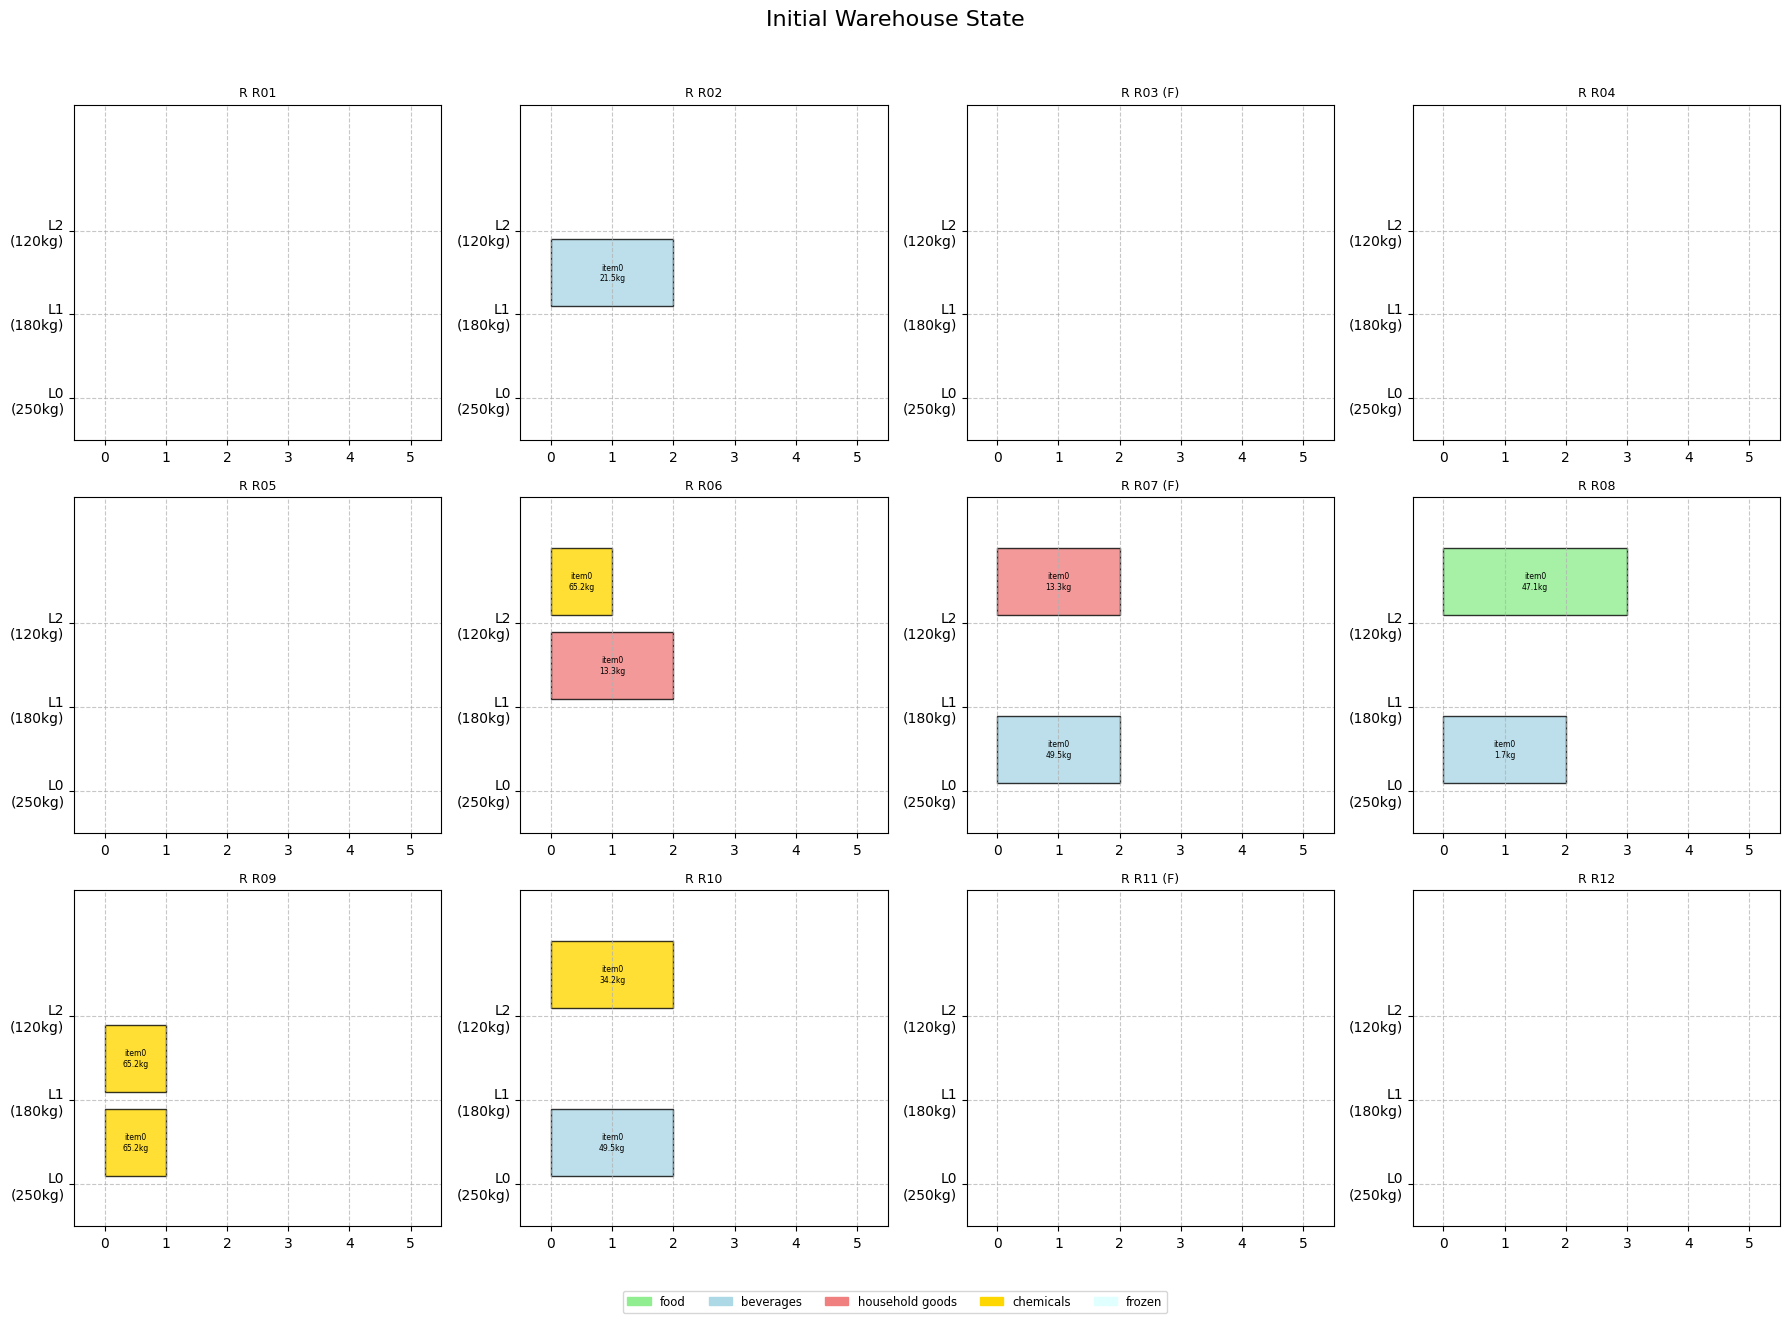



=============== SA ATTEMPTING INSERTION 1/10 FOR ITEM: item042 ===============
  SA for item042: Initial random choice ('R09', 1), Cost: -4.61
  SA for item042: Best placement ('R12', 0), Score: 7.50 (Cost: -7.50)


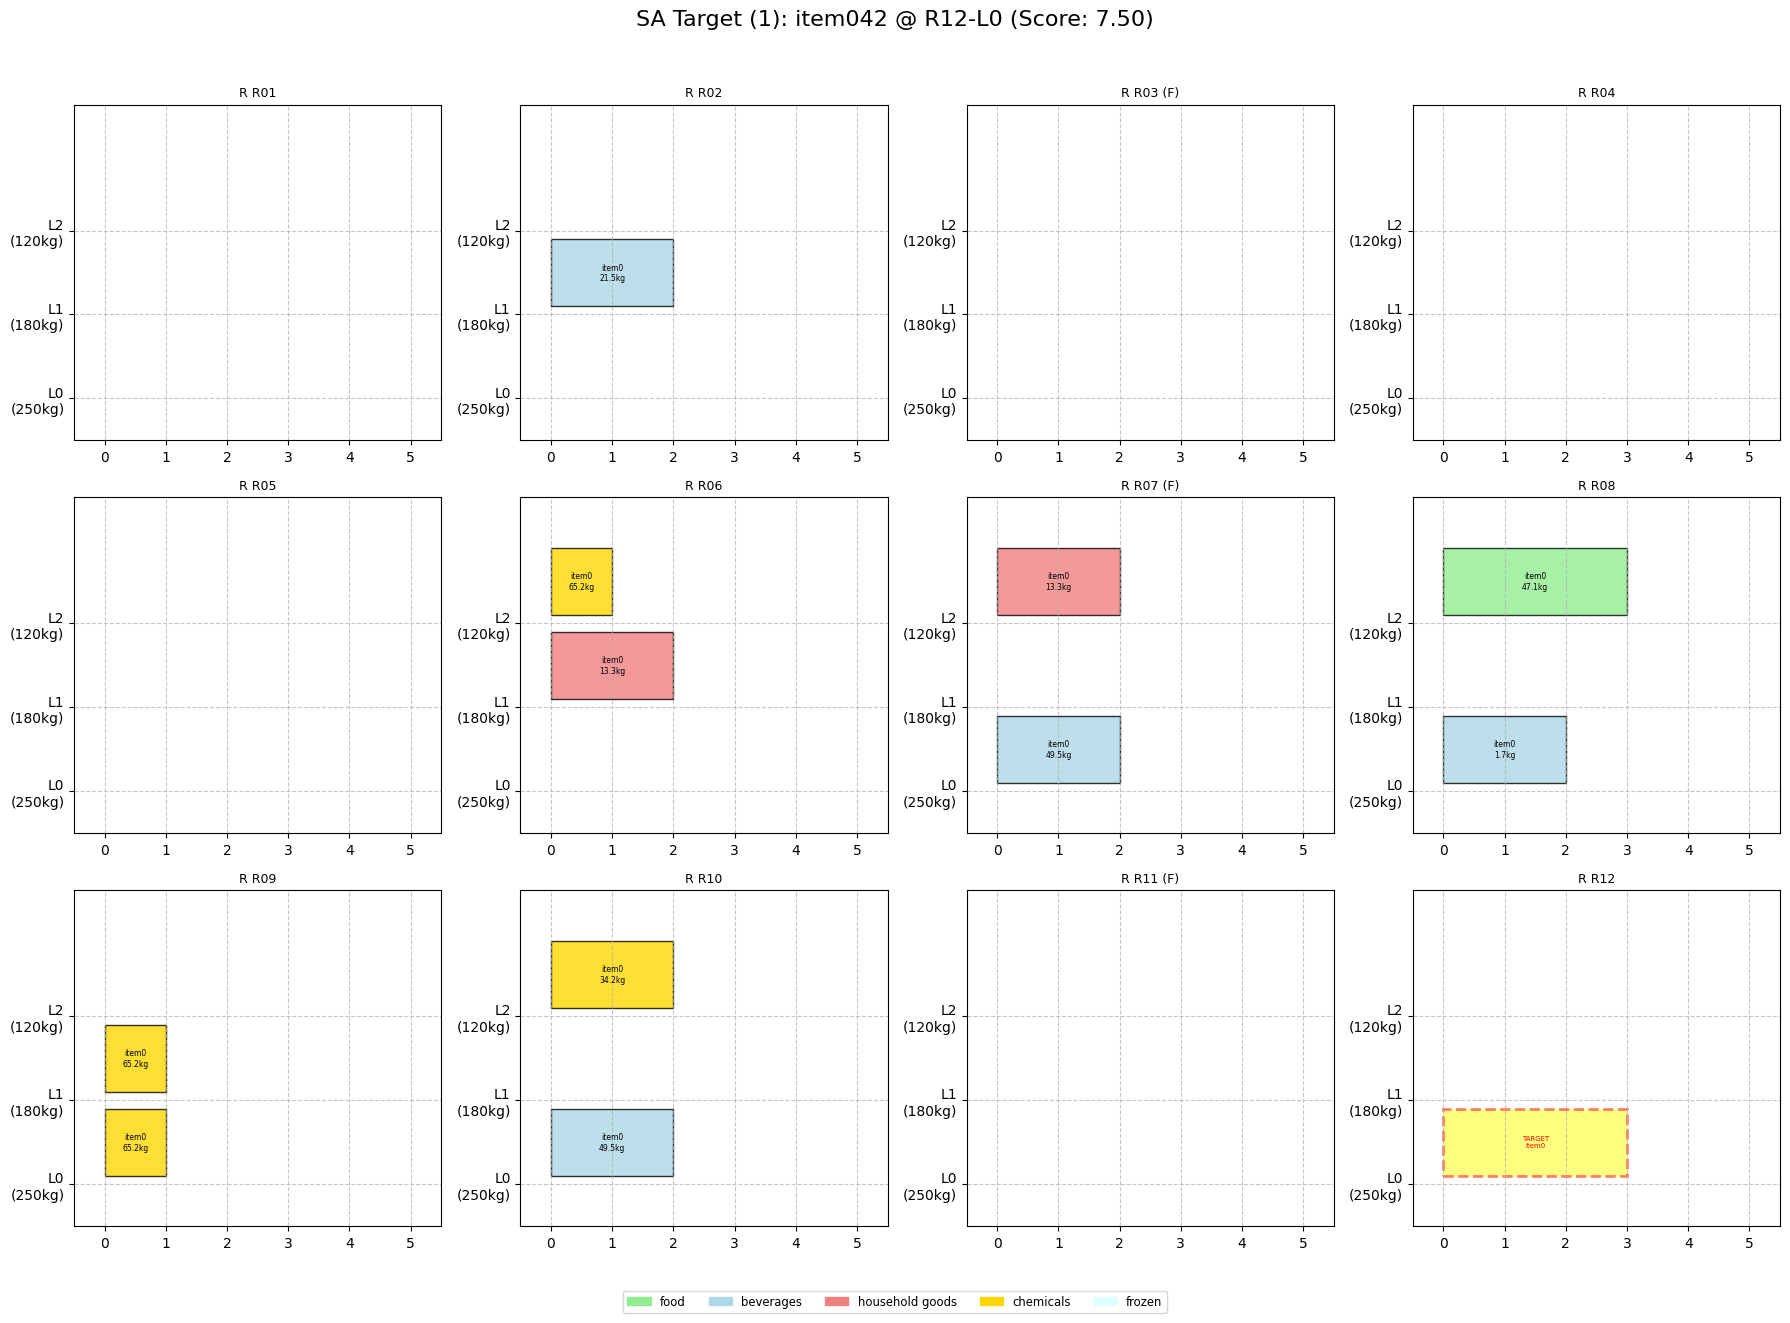


--- SA Placing item042 at ('R12', 0) ---


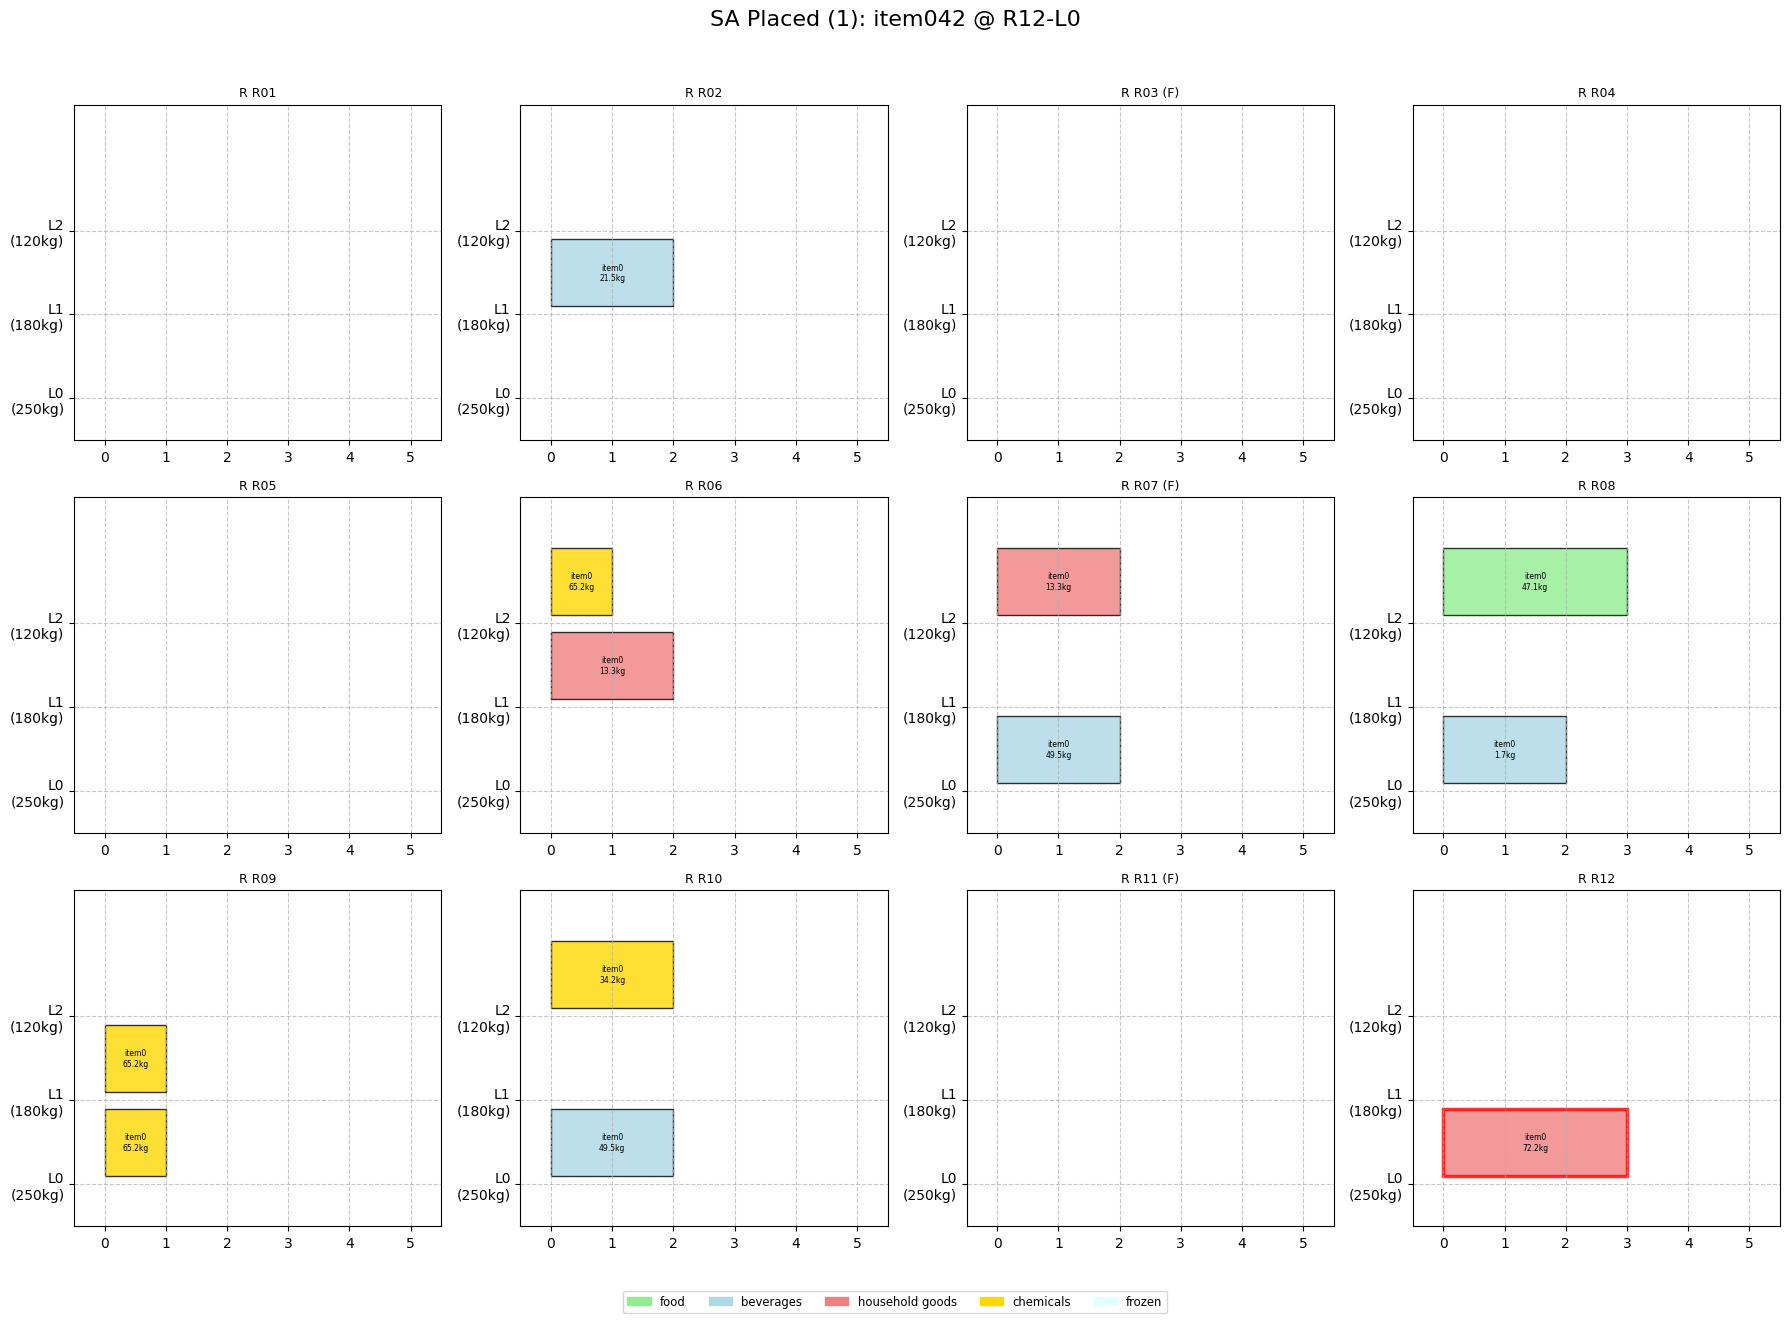



=============== SA ATTEMPTING INSERTION 2/10 FOR ITEM: item010 ===============
  SA for item010: Initial random choice ('R04', 0), Cost: -3.22
  SA for item010: Best placement ('R12', 0), Score: 4.87 (Cost: -4.87)


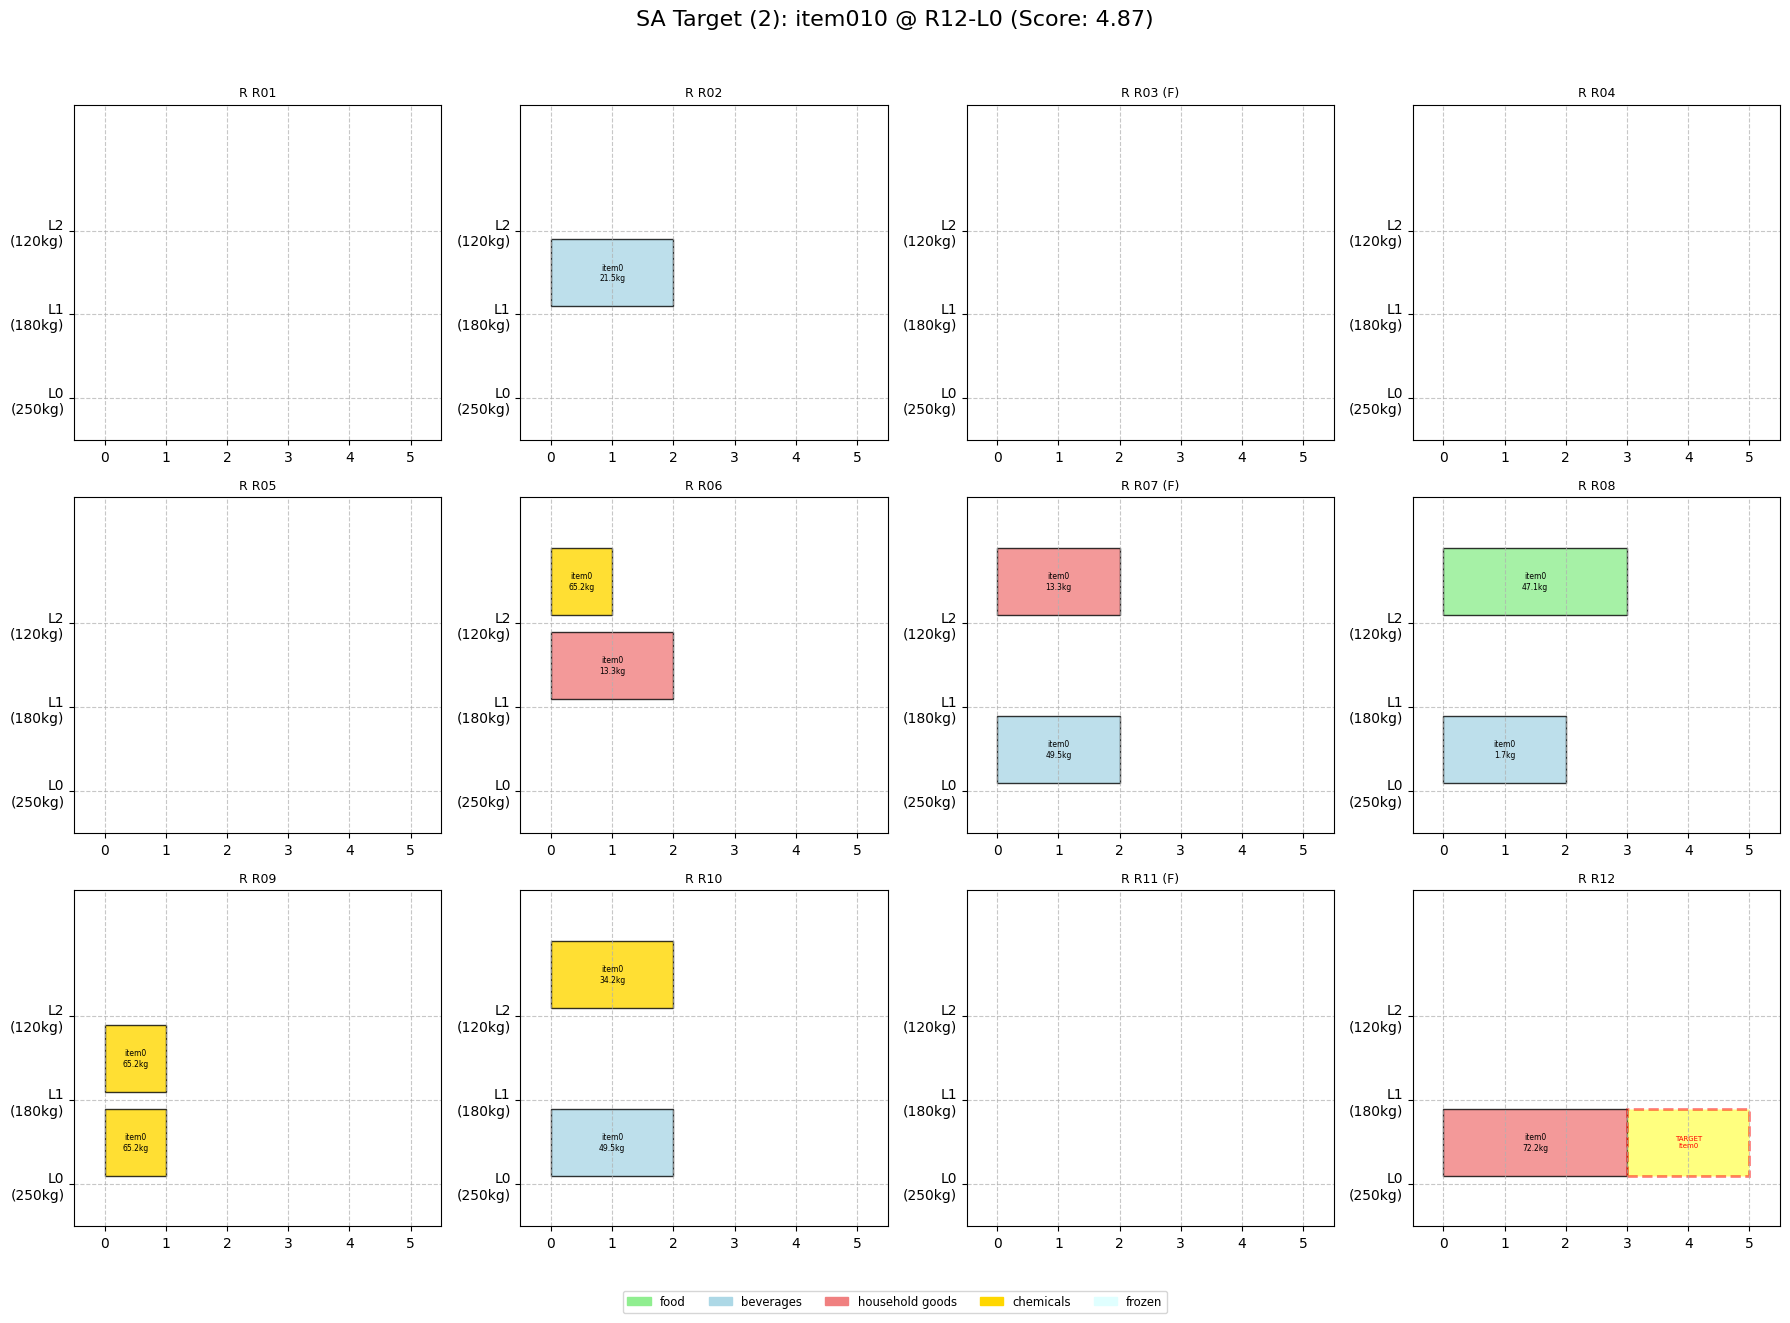


--- SA Placing item010 at ('R12', 0) ---


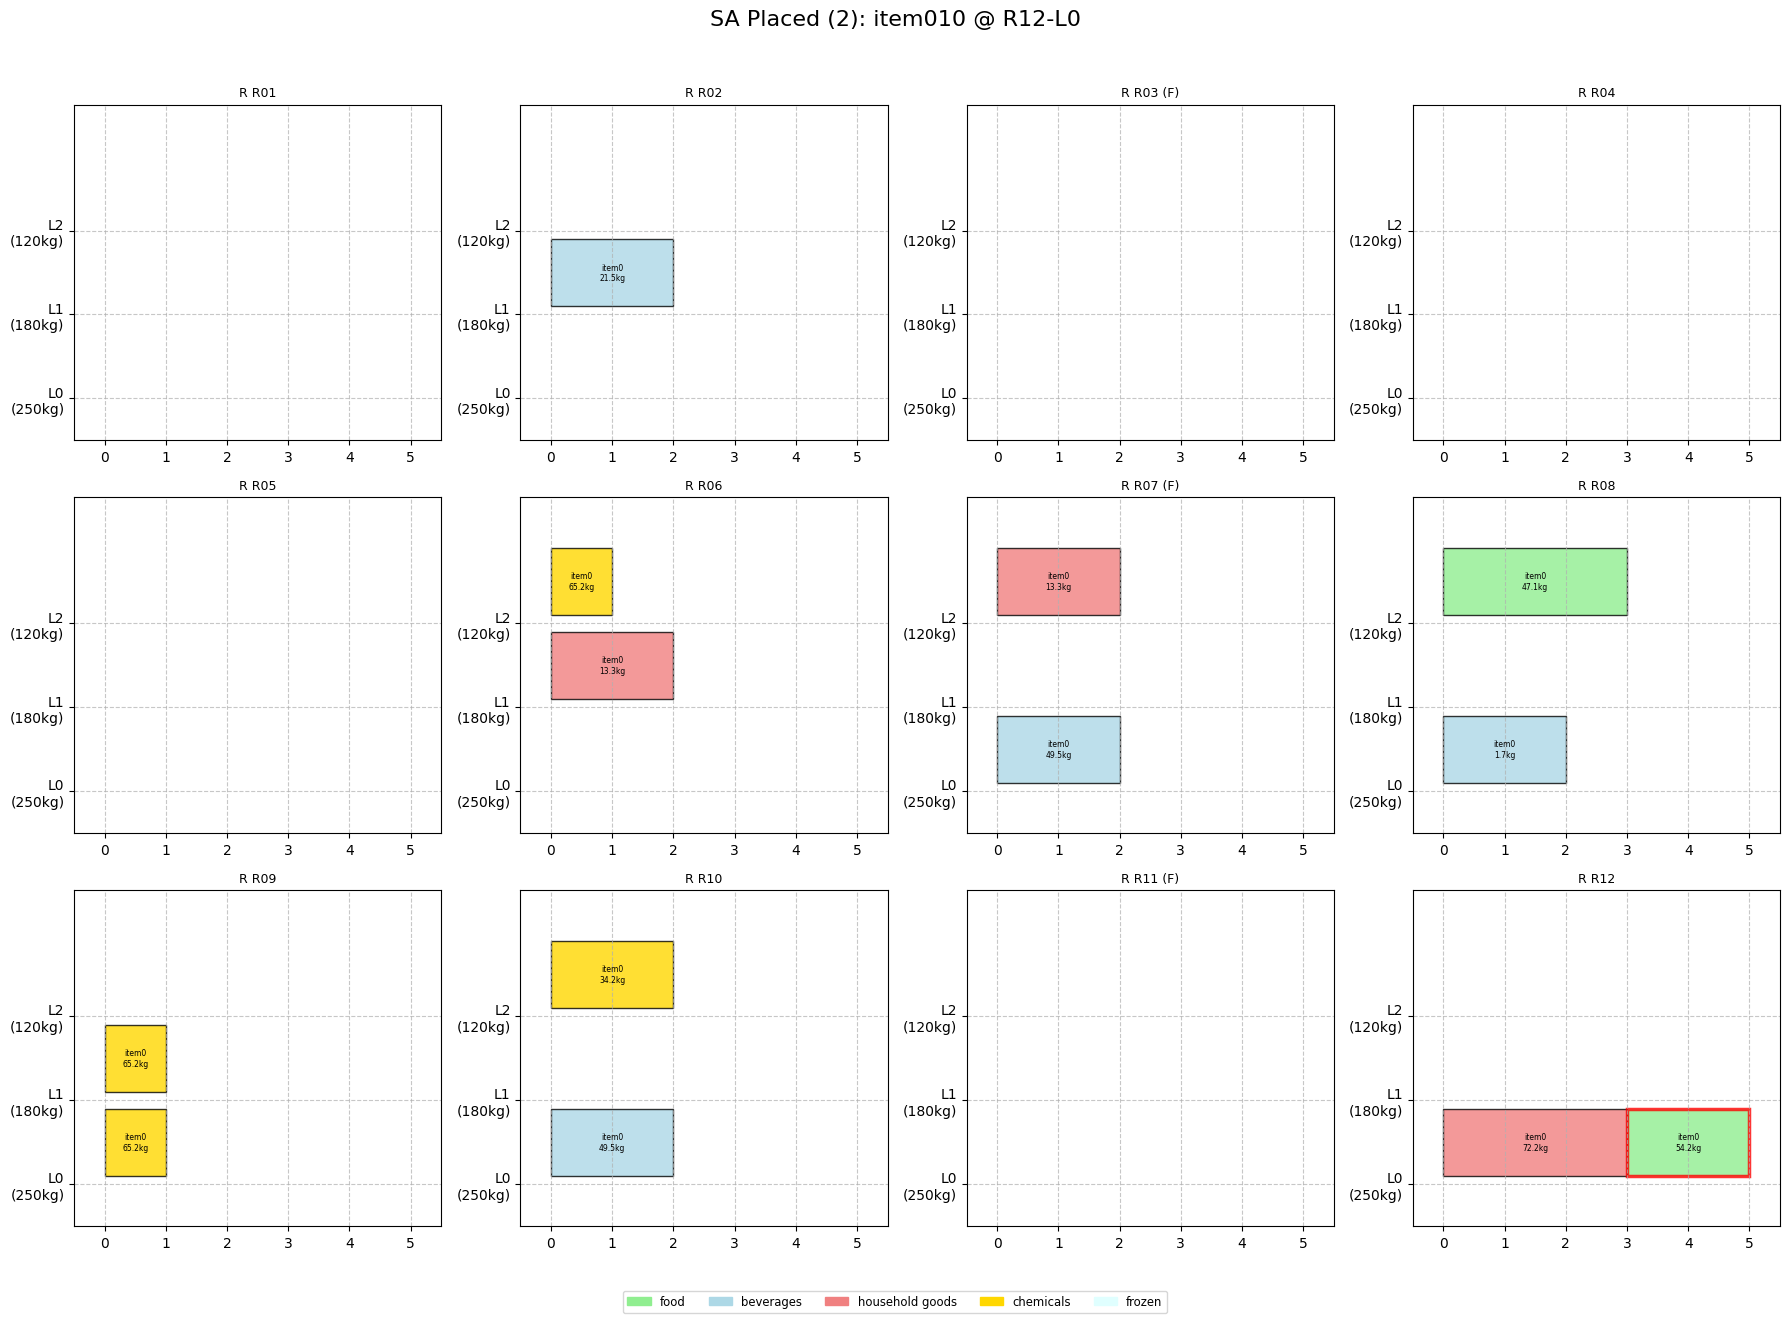



=============== SA ATTEMPTING INSERTION 3/10 FOR ITEM: item045 ===============
  SA for item045: Initial random choice ('R10', 2), Cost: -4.80
  SA for item045: Best placement ('R10', 0), Score: 8.90 (Cost: -8.90)


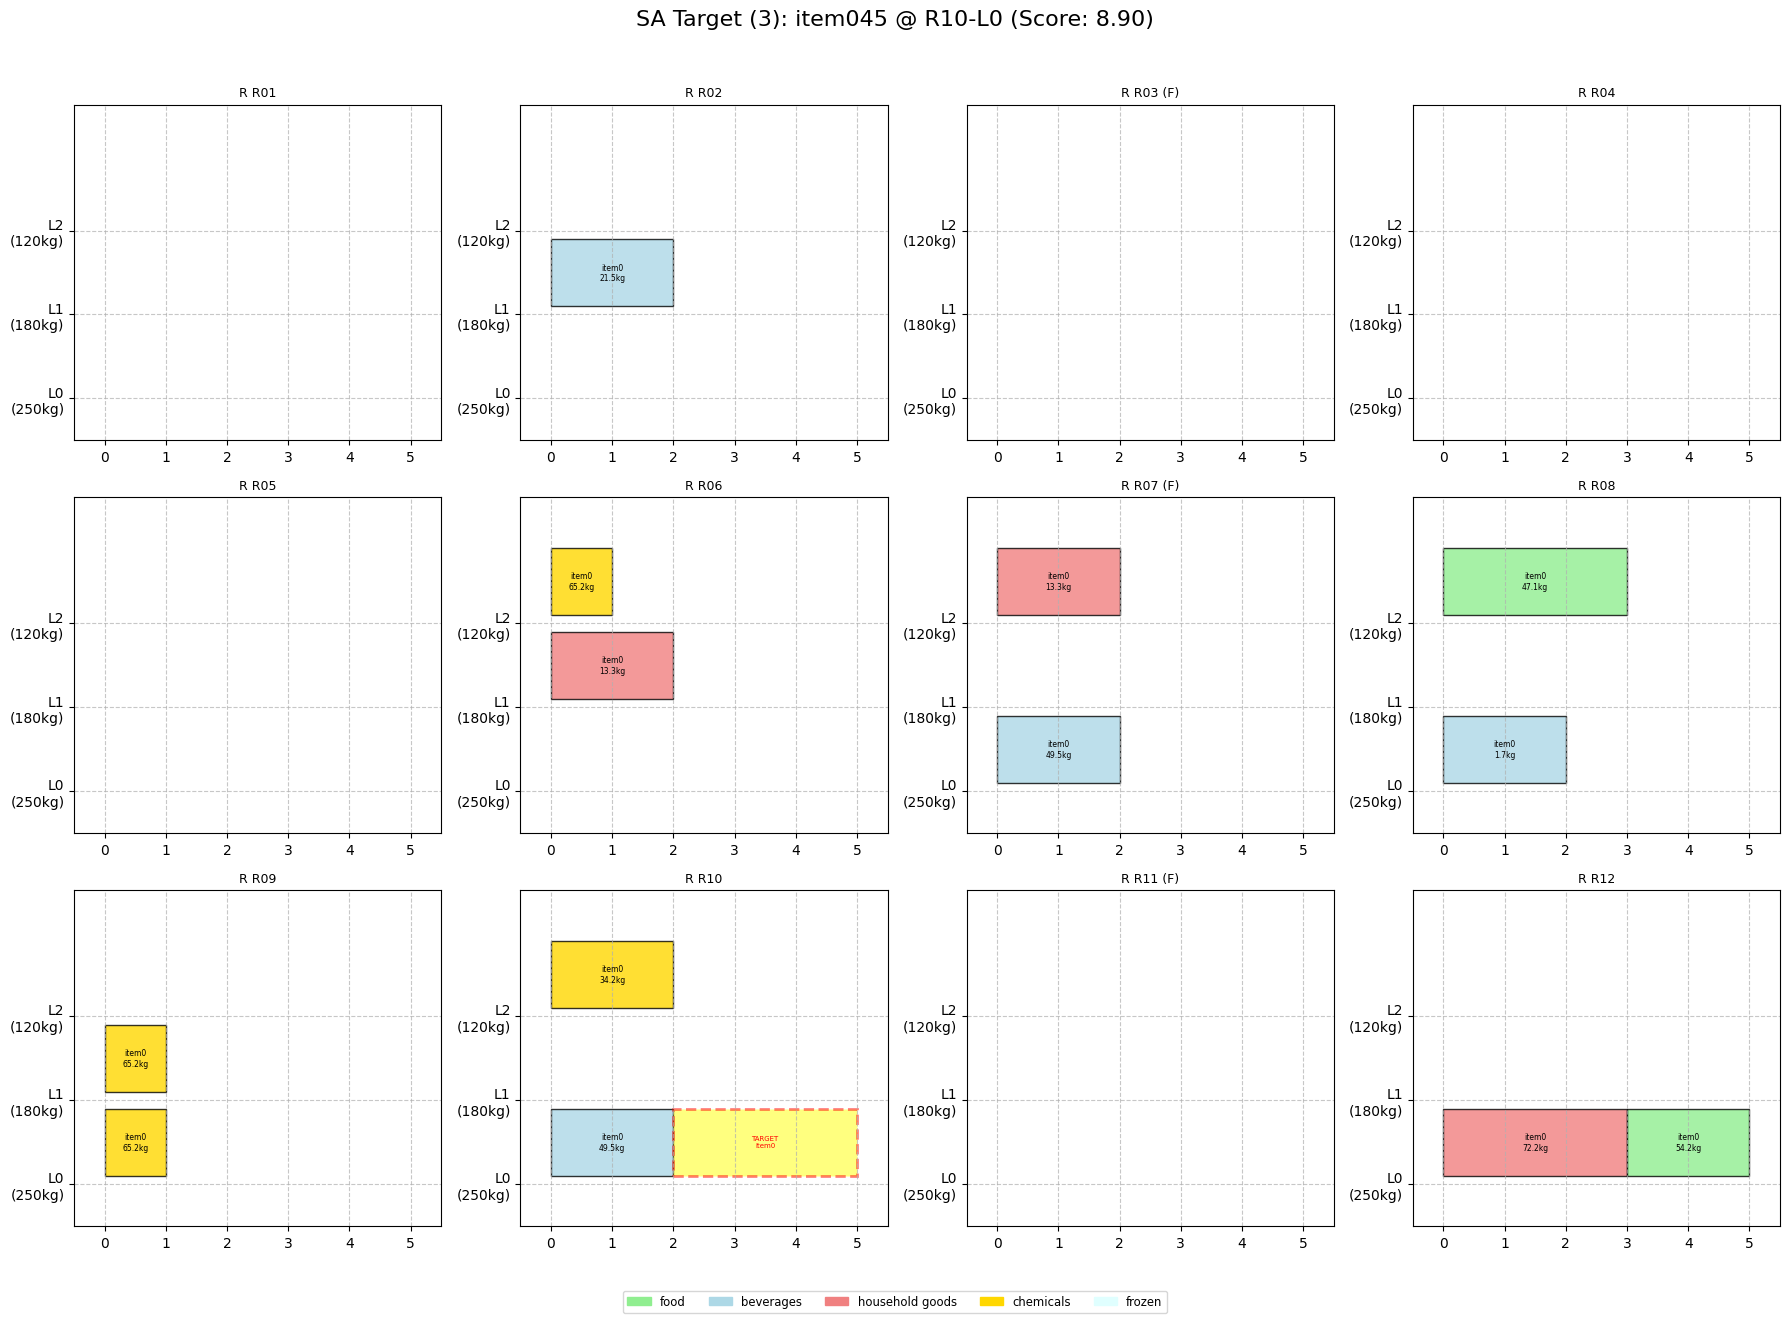


--- SA Placing item045 at ('R10', 0) ---


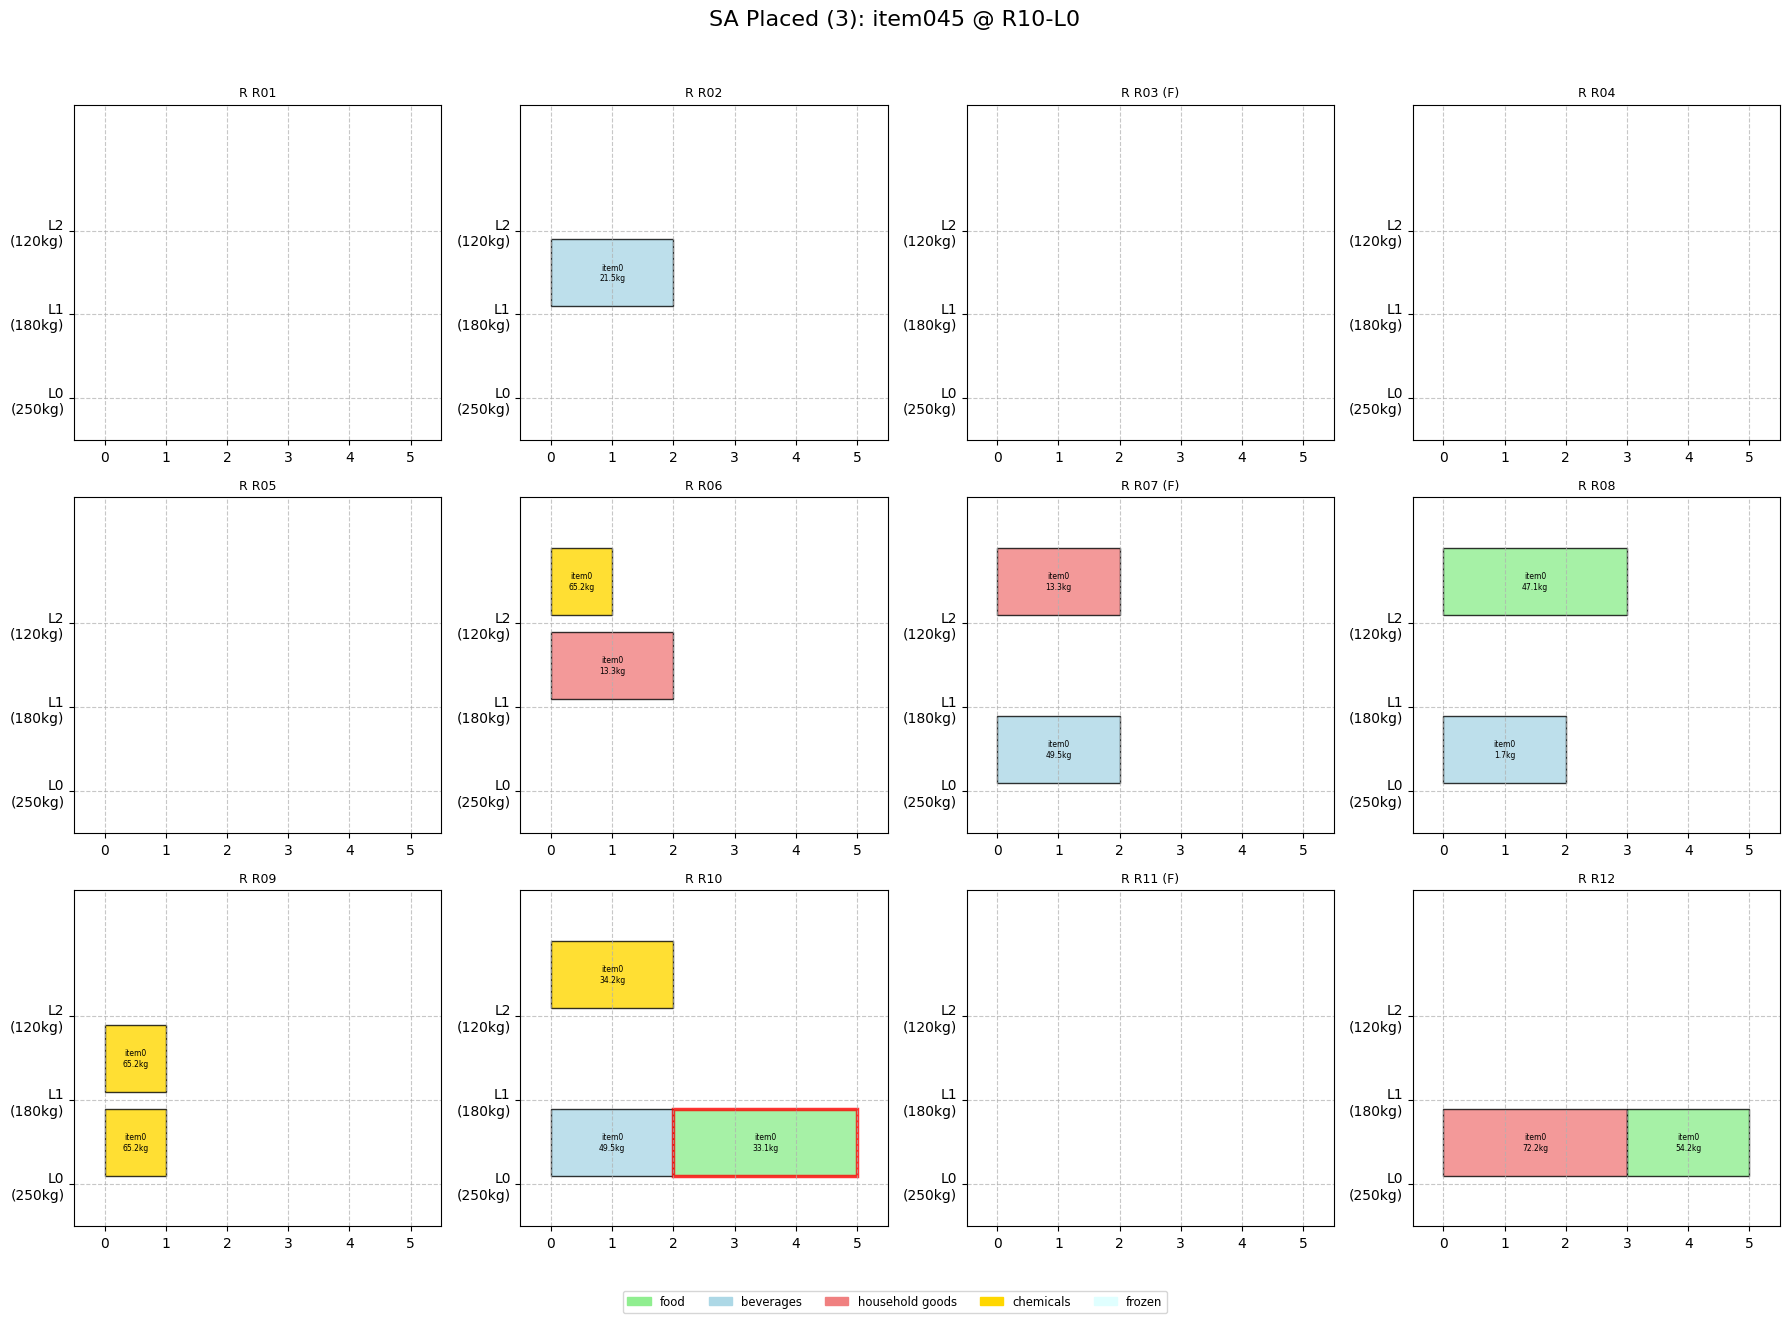



=============== SA ATTEMPTING INSERTION 4/10 FOR ITEM: item025 ===============
  SA for item025: Initial random choice ('R03', 0), Cost: 2.50
  SA for item025: Best placement ('R08', 0), Score: 8.90 (Cost: -8.90)


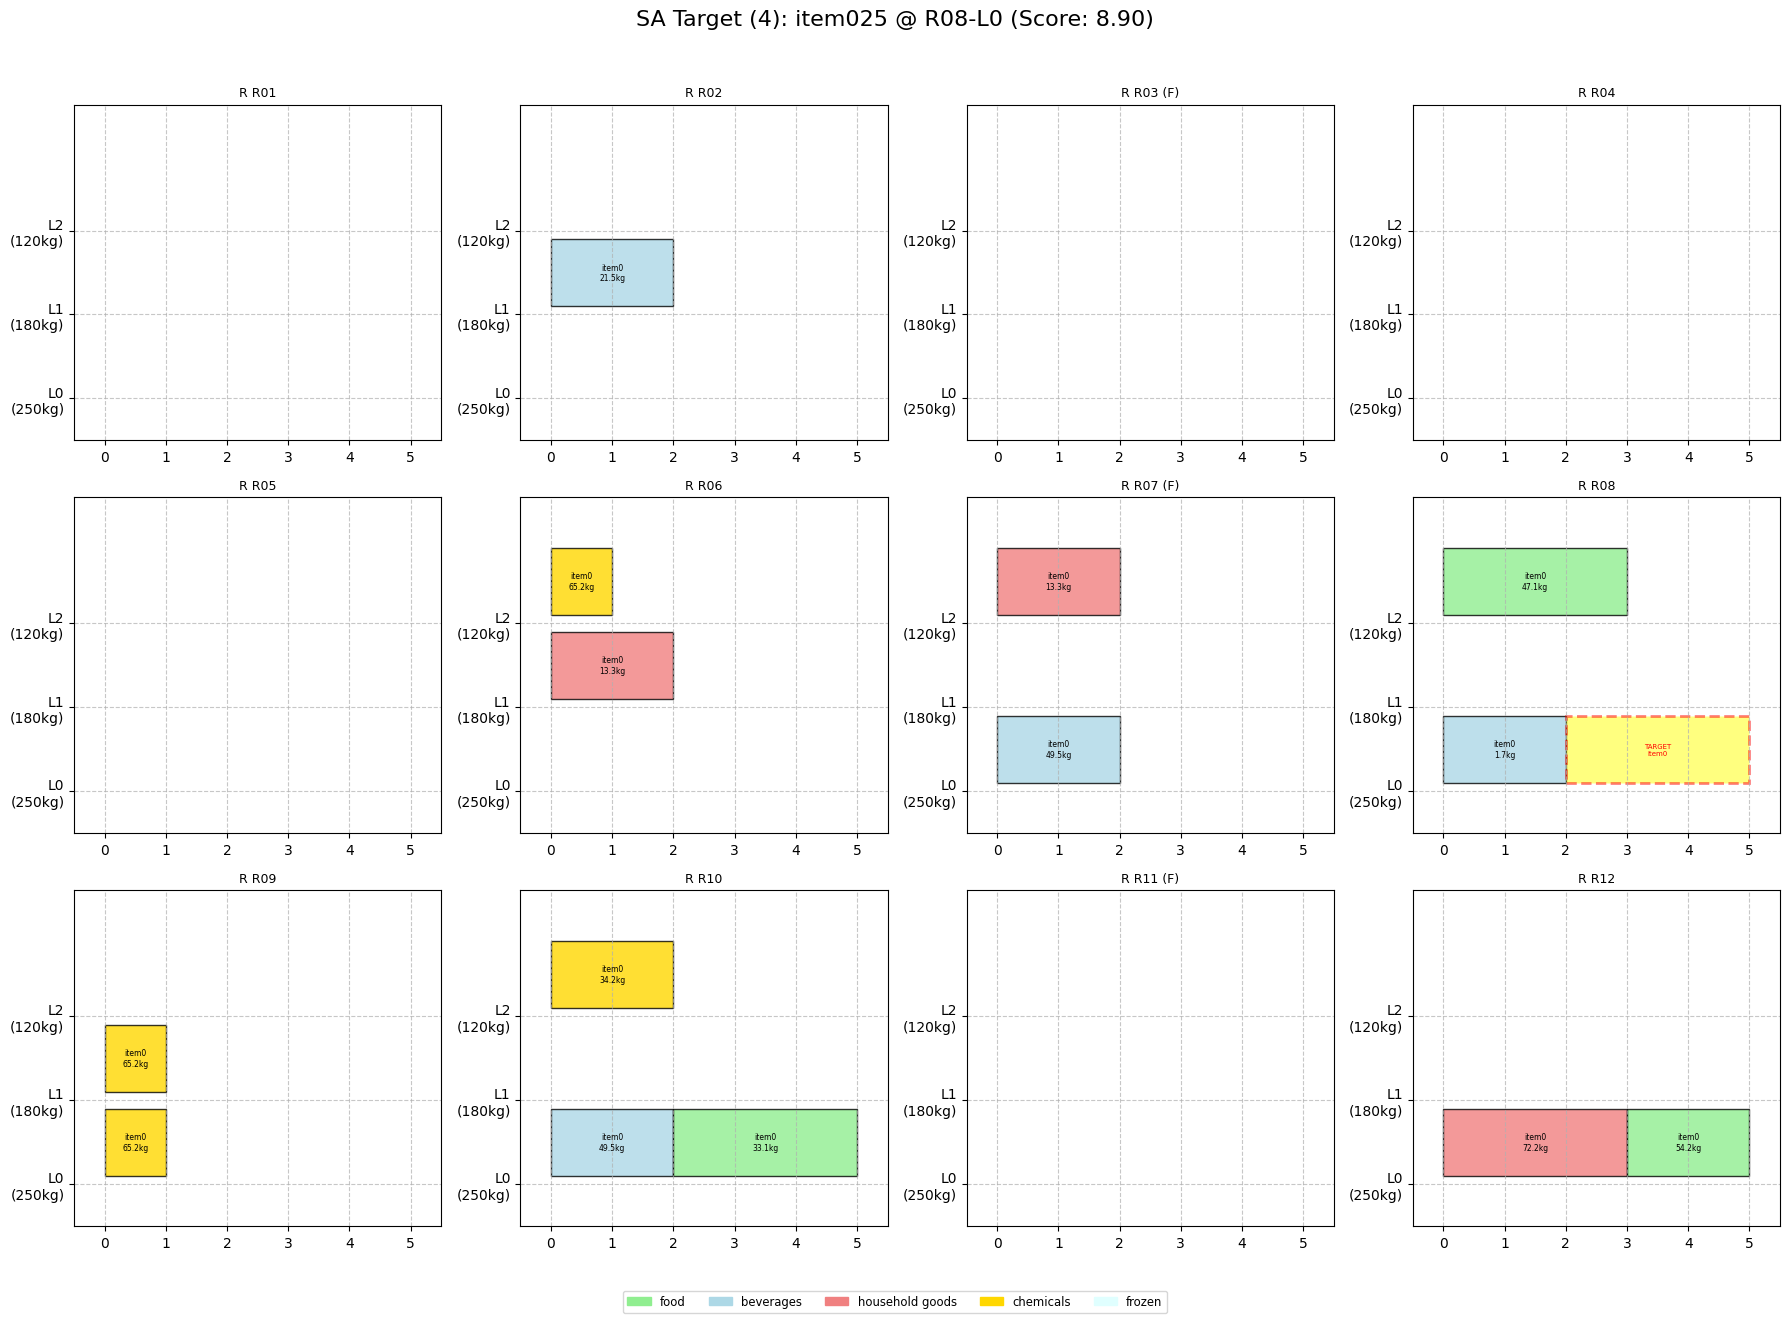


--- SA Placing item025 at ('R08', 0) ---


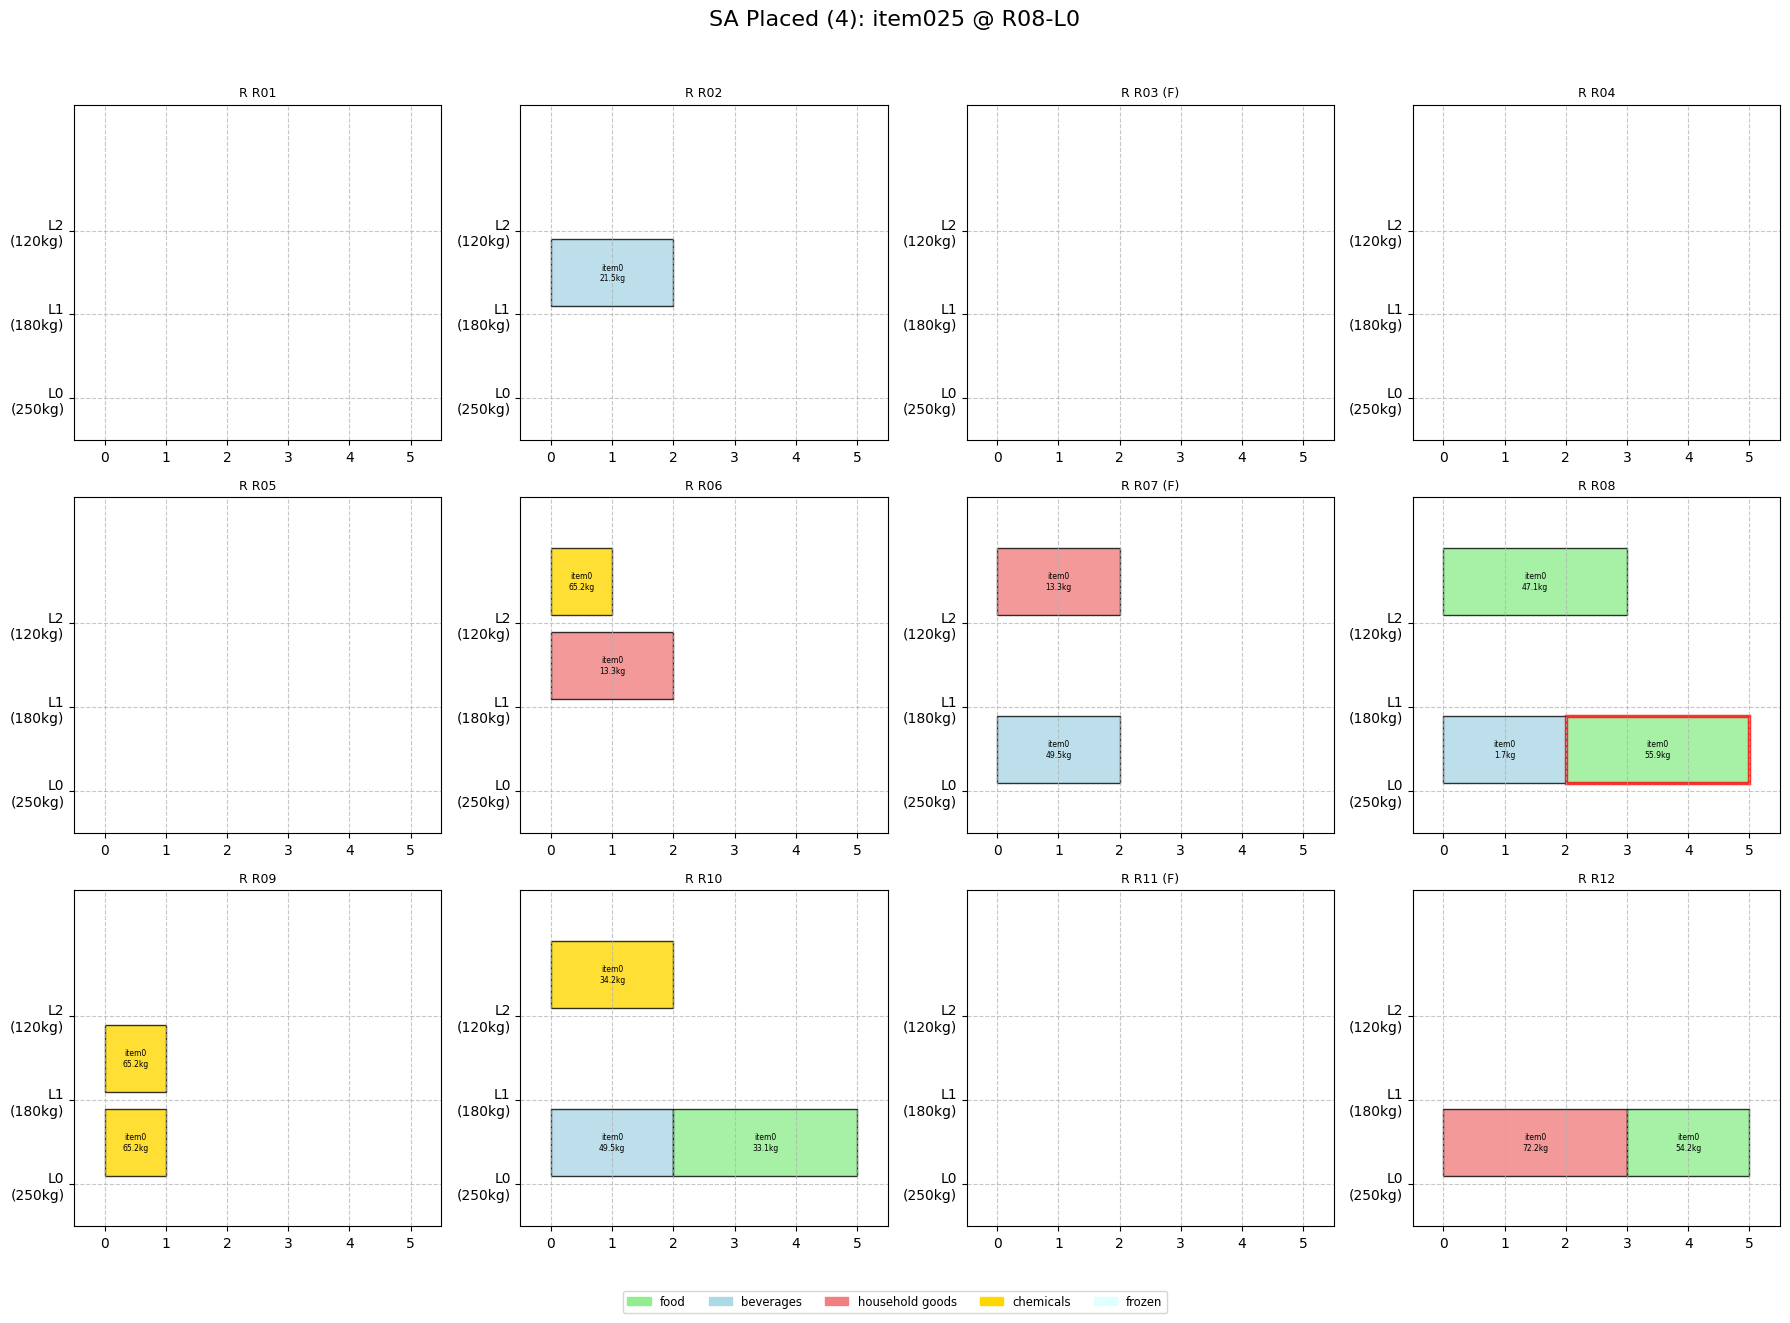



=============== SA ATTEMPTING INSERTION 5/10 FOR ITEM: item013 ===============
  SA for item013: Initial random choice ('R07', 1), Cost: -6.00
  SA for item013: Best placement ('R03', 2), Score: 6.20 (Cost: -6.20)


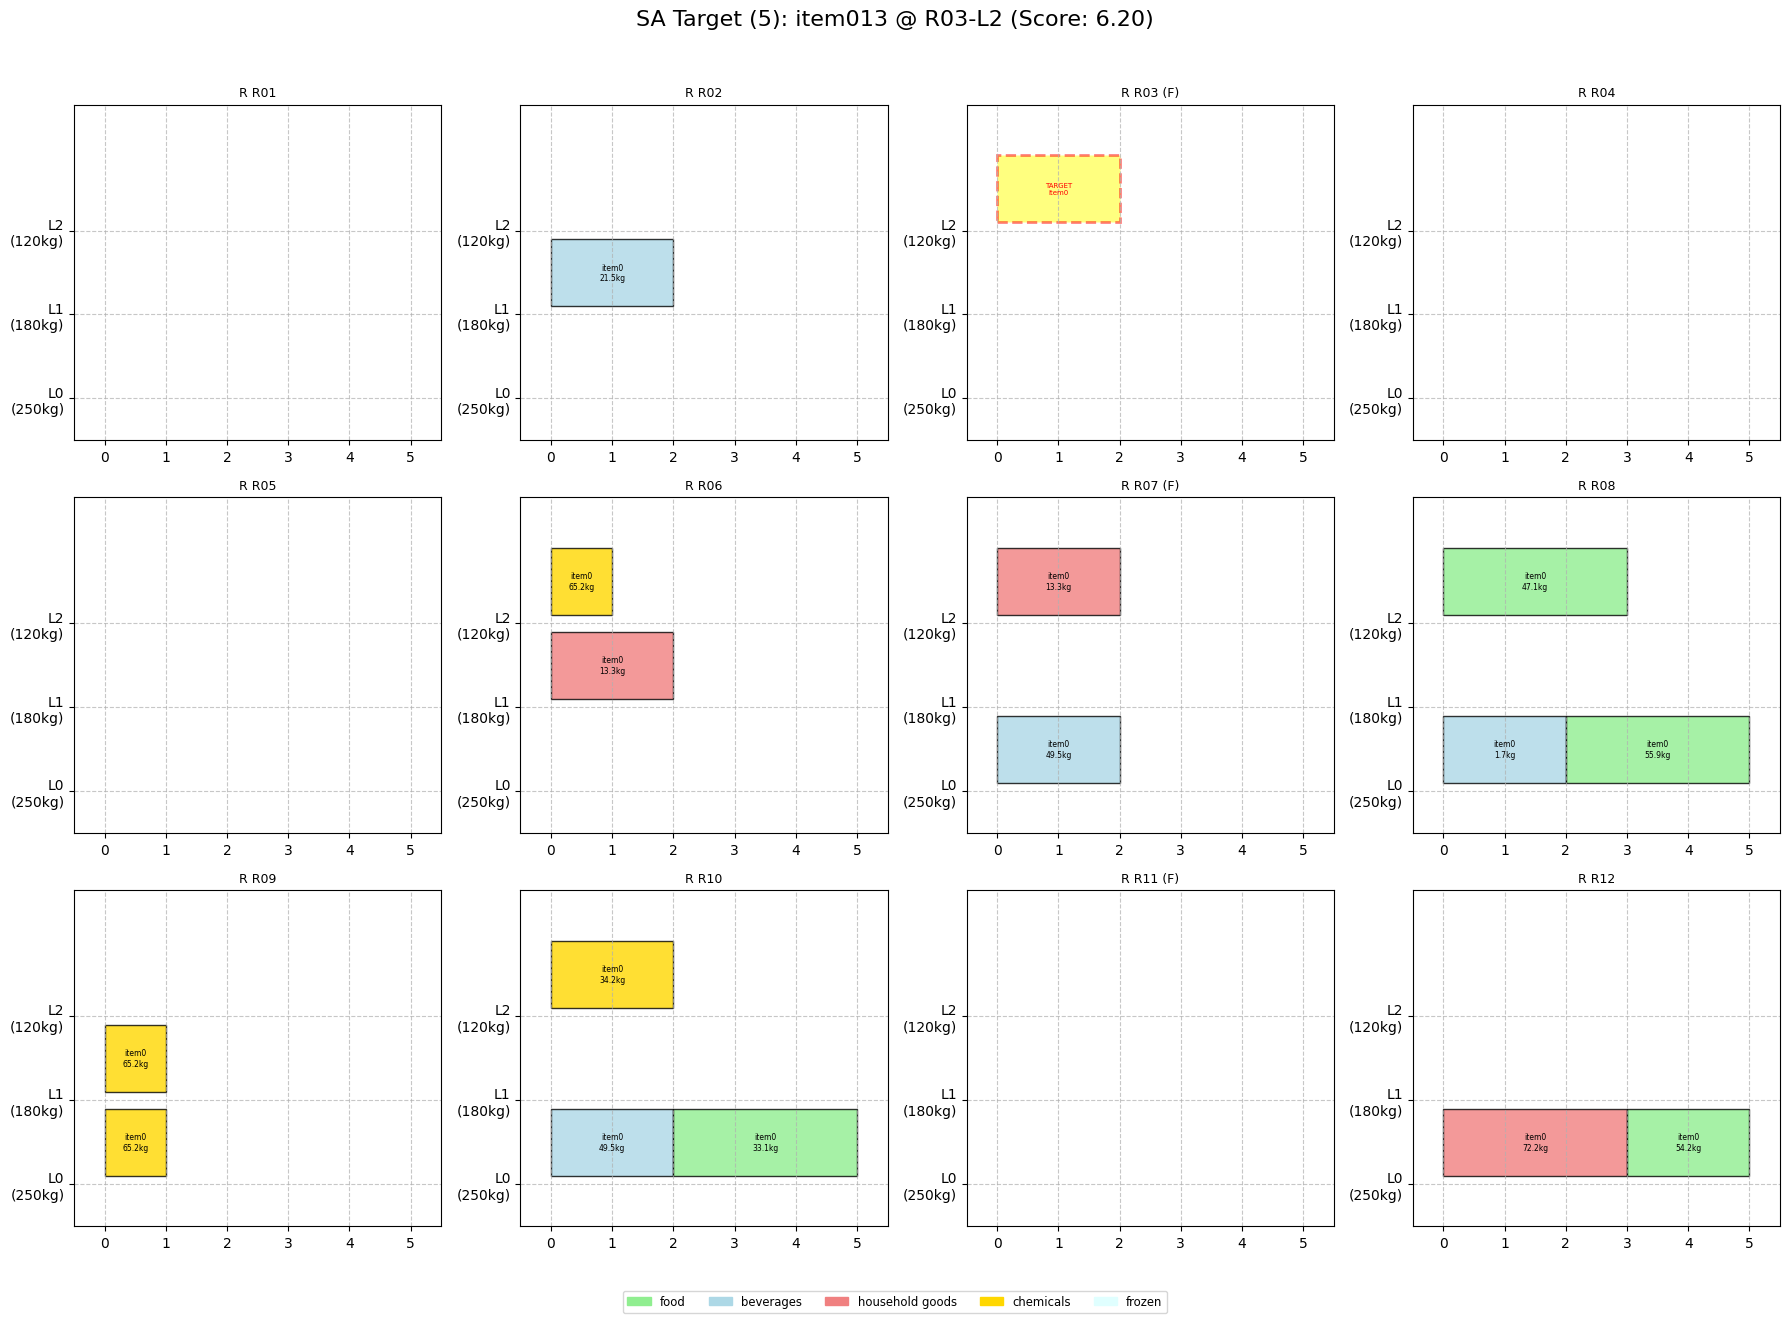


--- SA Placing item013 at ('R03', 2) ---


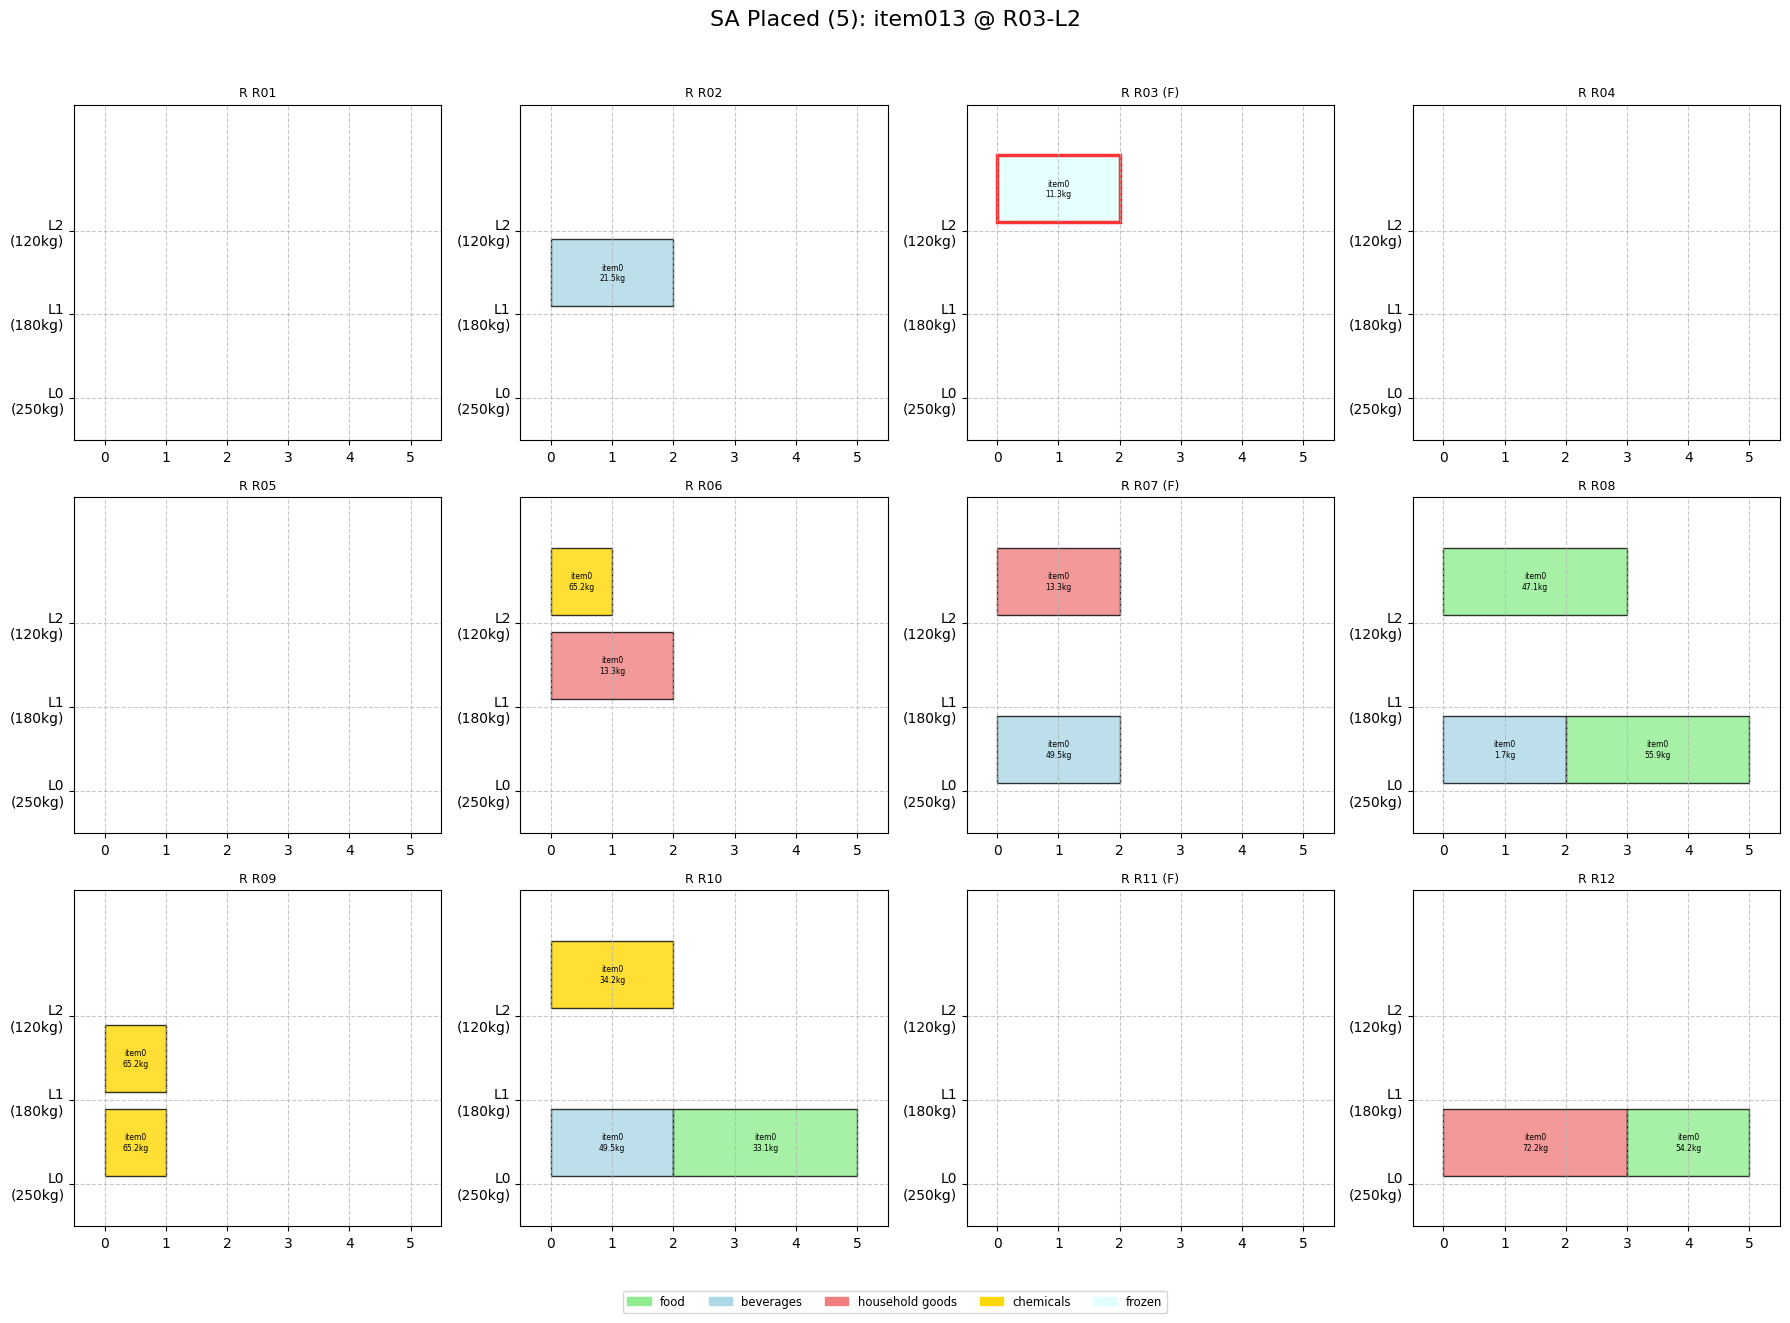



=============== SA ATTEMPTING INSERTION 6/10 FOR ITEM: item043 ===============
  SA for item043: Initial random choice ('R01', 0), Cost: -4.99
  SA for item043: Best placement ('R09', 0), Score: 6.70 (Cost: -6.70)


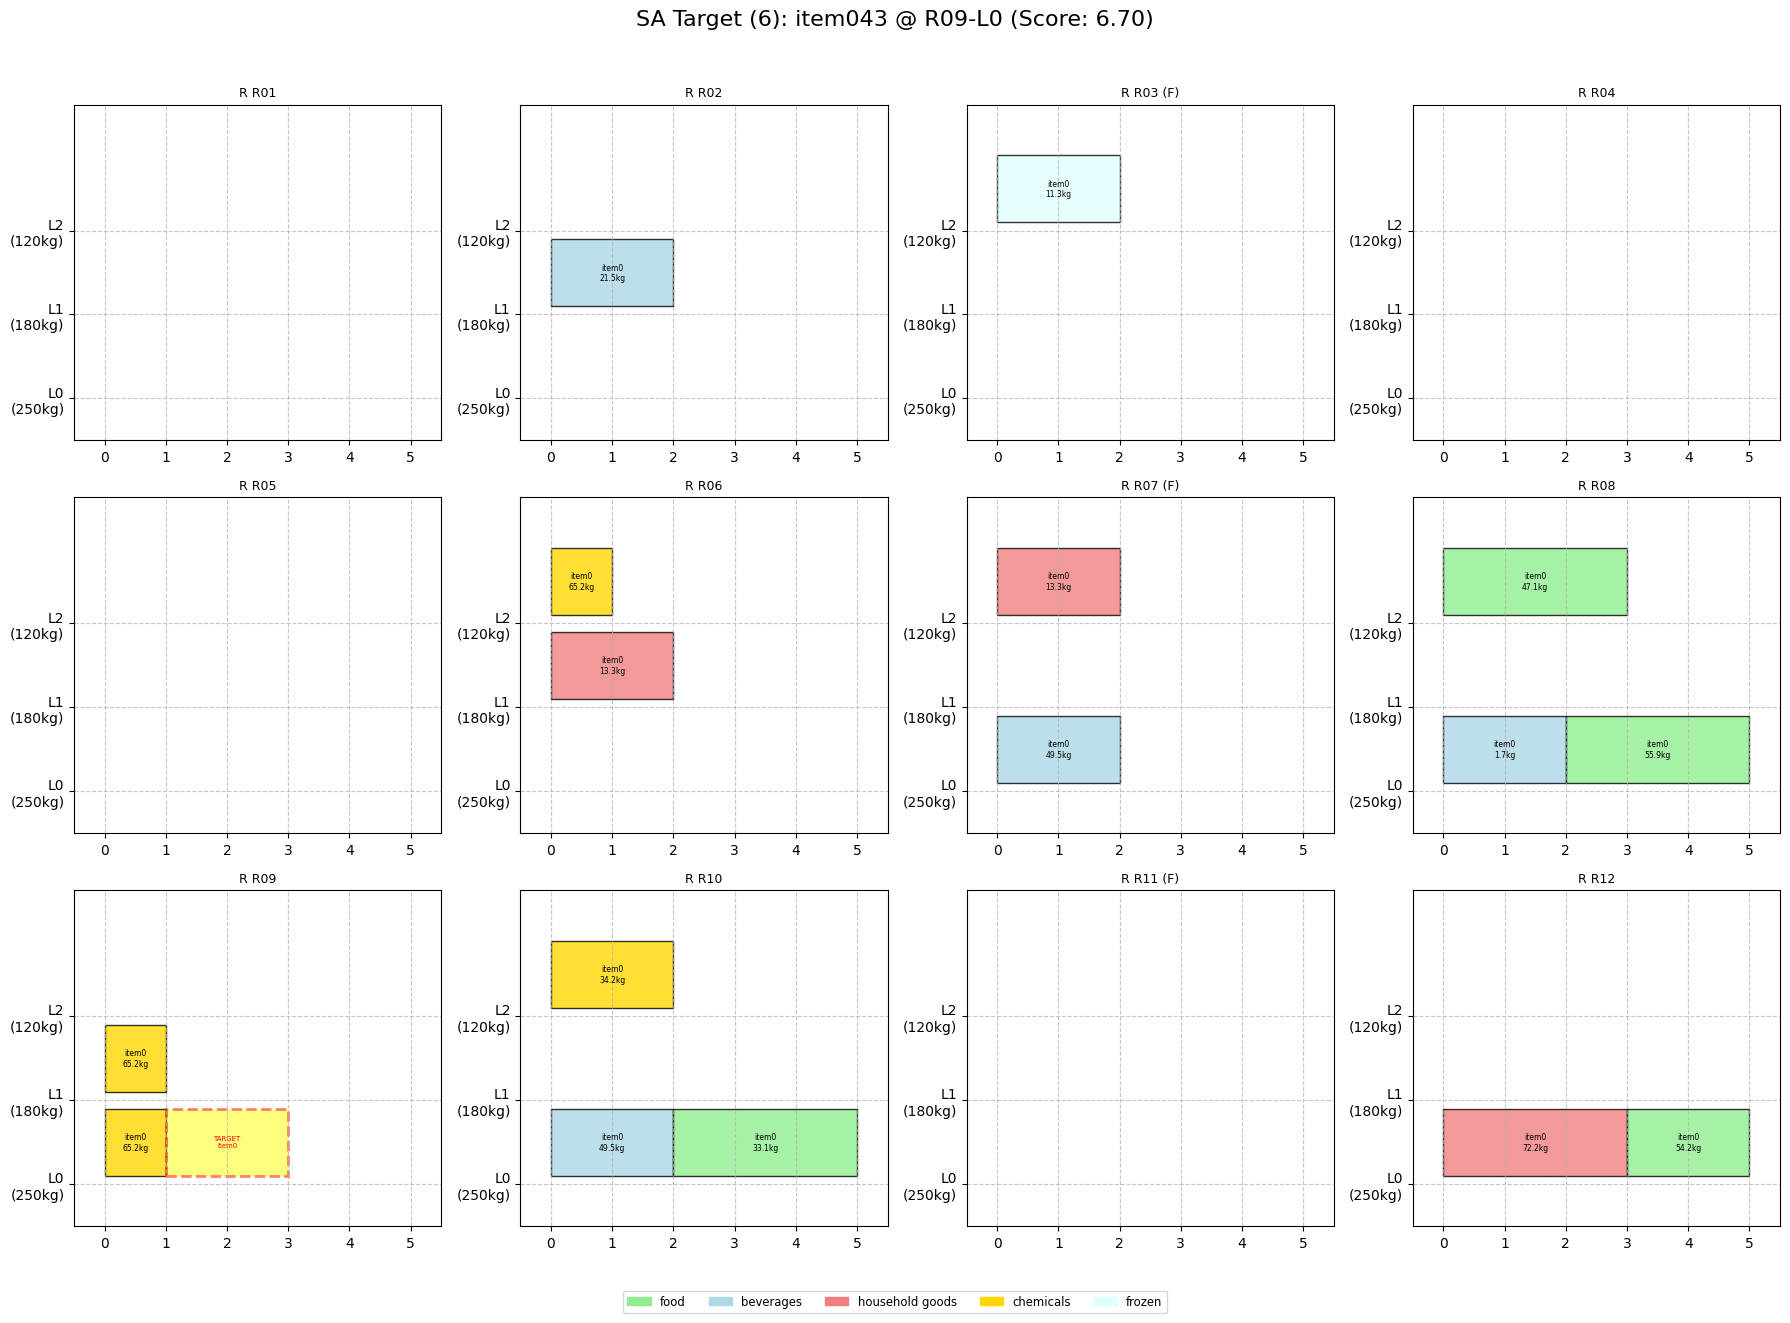


--- SA Placing item043 at ('R09', 0) ---


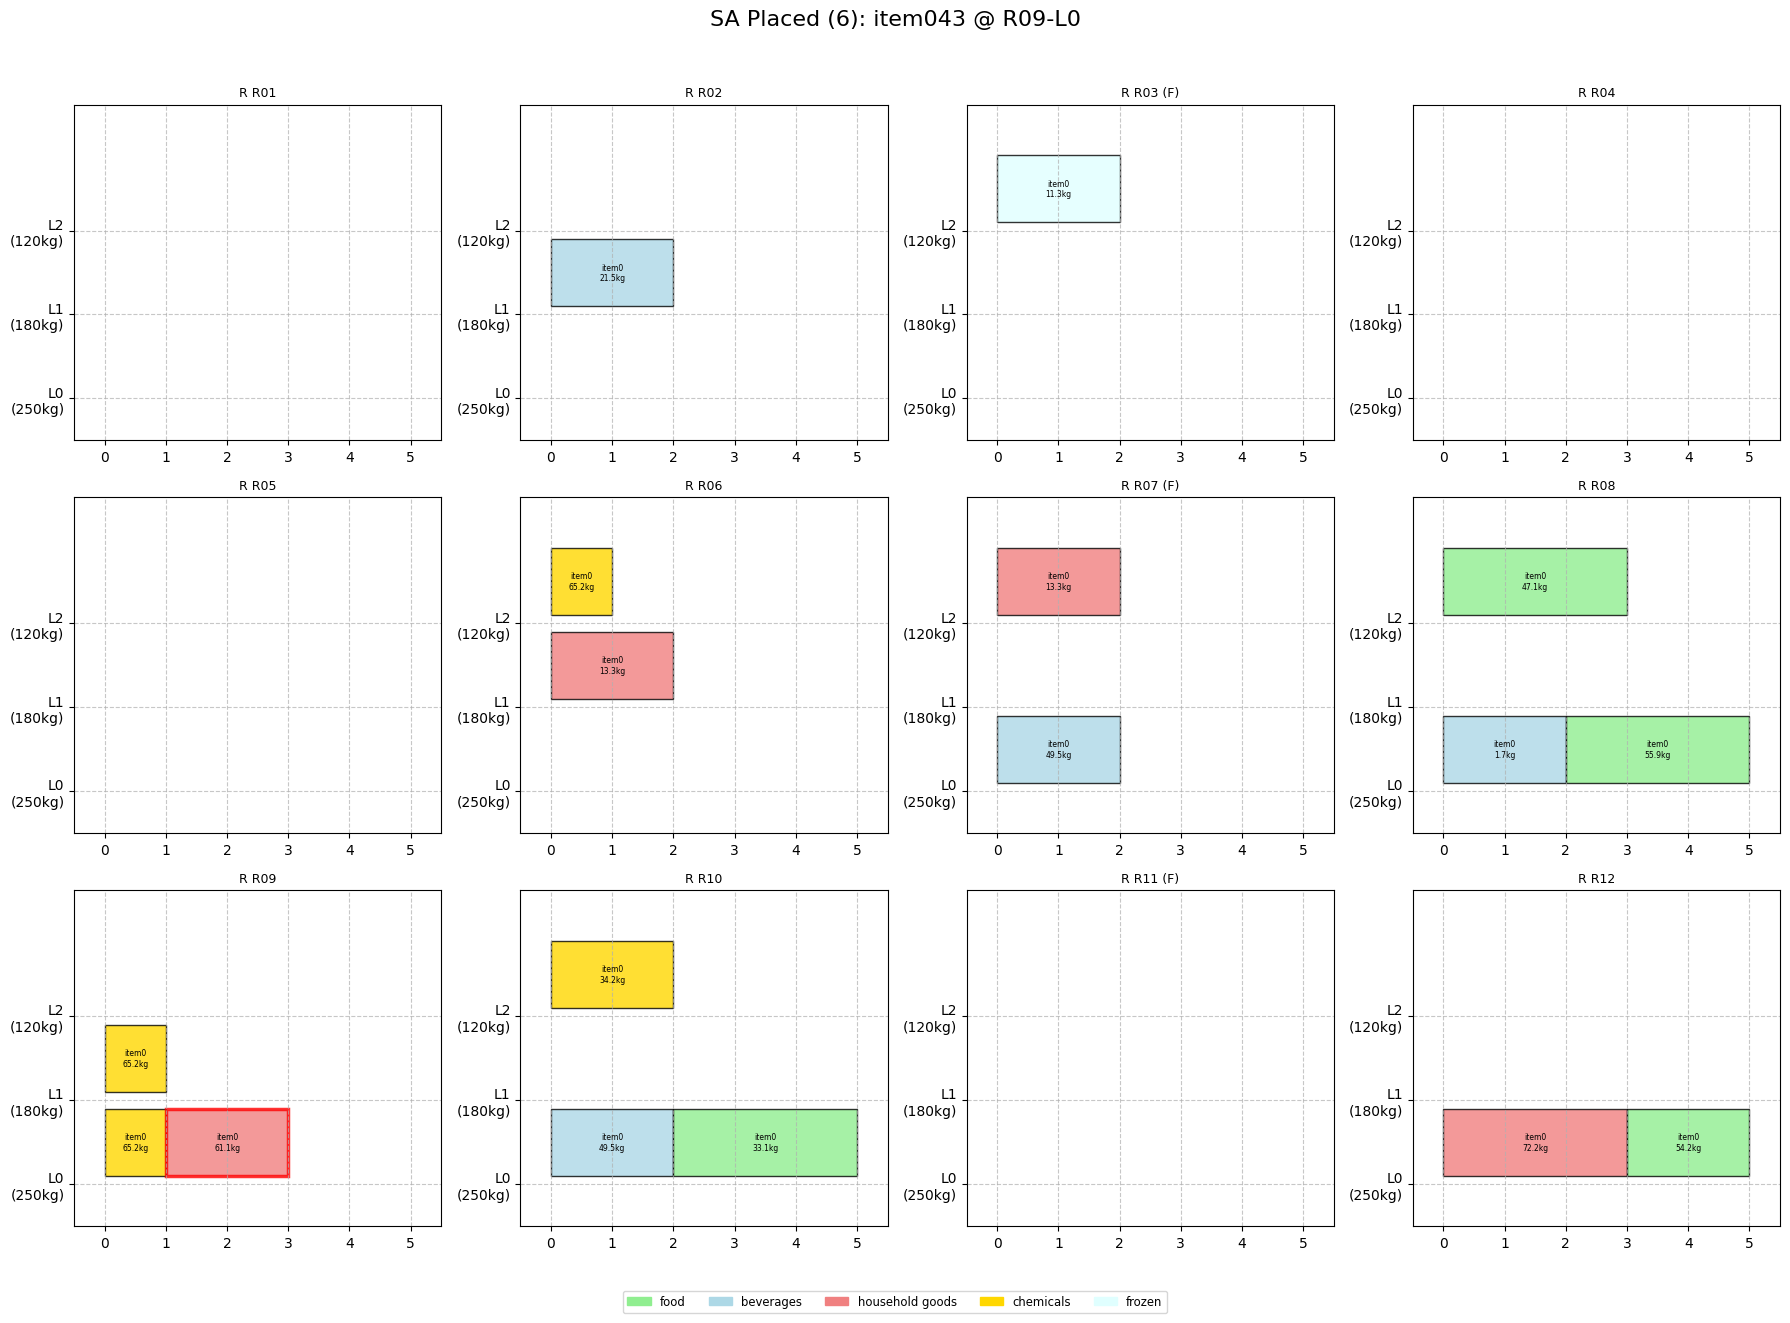



=============== SA ATTEMPTING INSERTION 7/10 FOR ITEM: item037 ===============
  SA for item037: Initial random choice ('R12', 2), Cost: -5.00
  SA for item037: Best placement ('R09', 0), Score: 6.53 (Cost: -6.53)


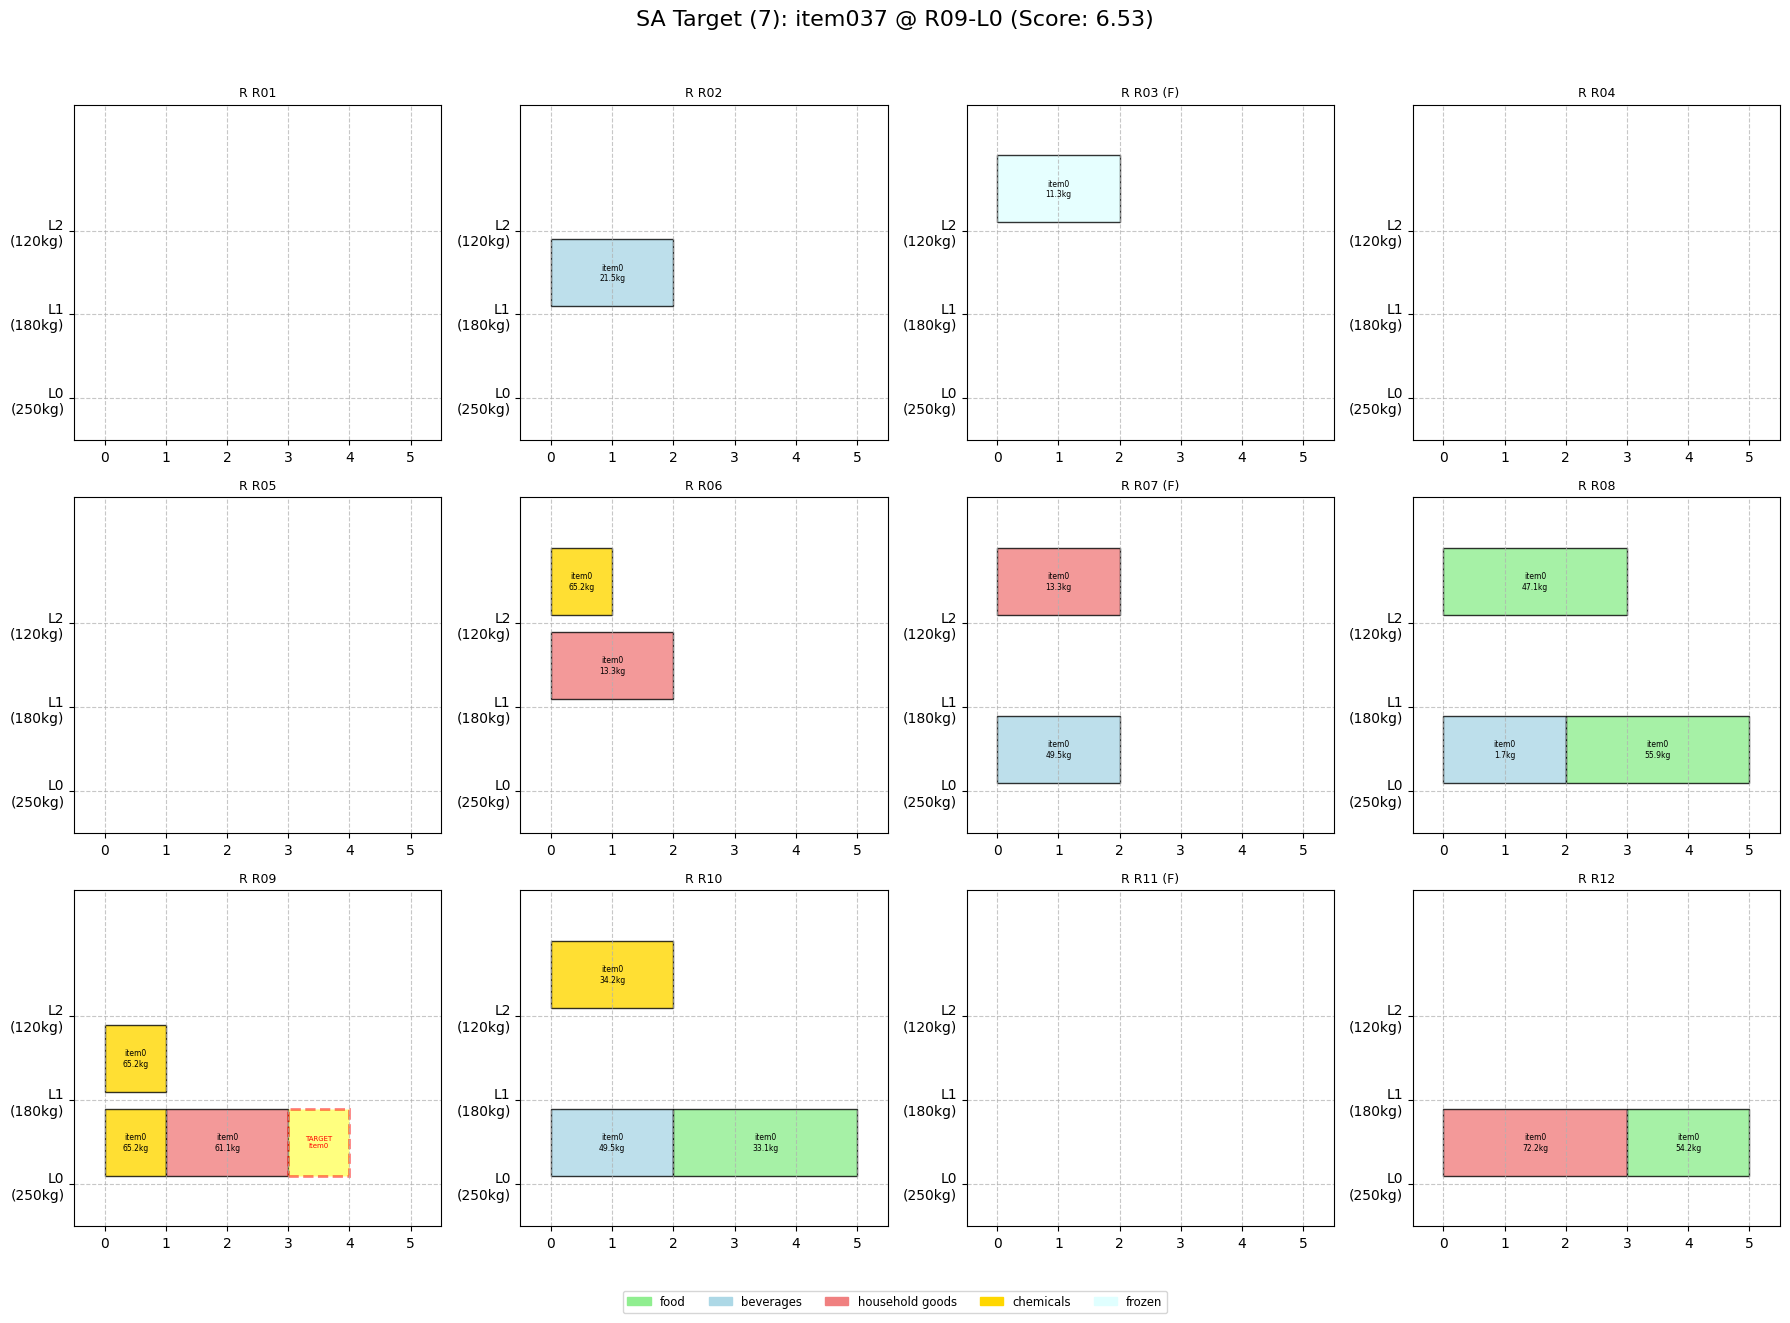


--- SA Placing item037 at ('R09', 0) ---


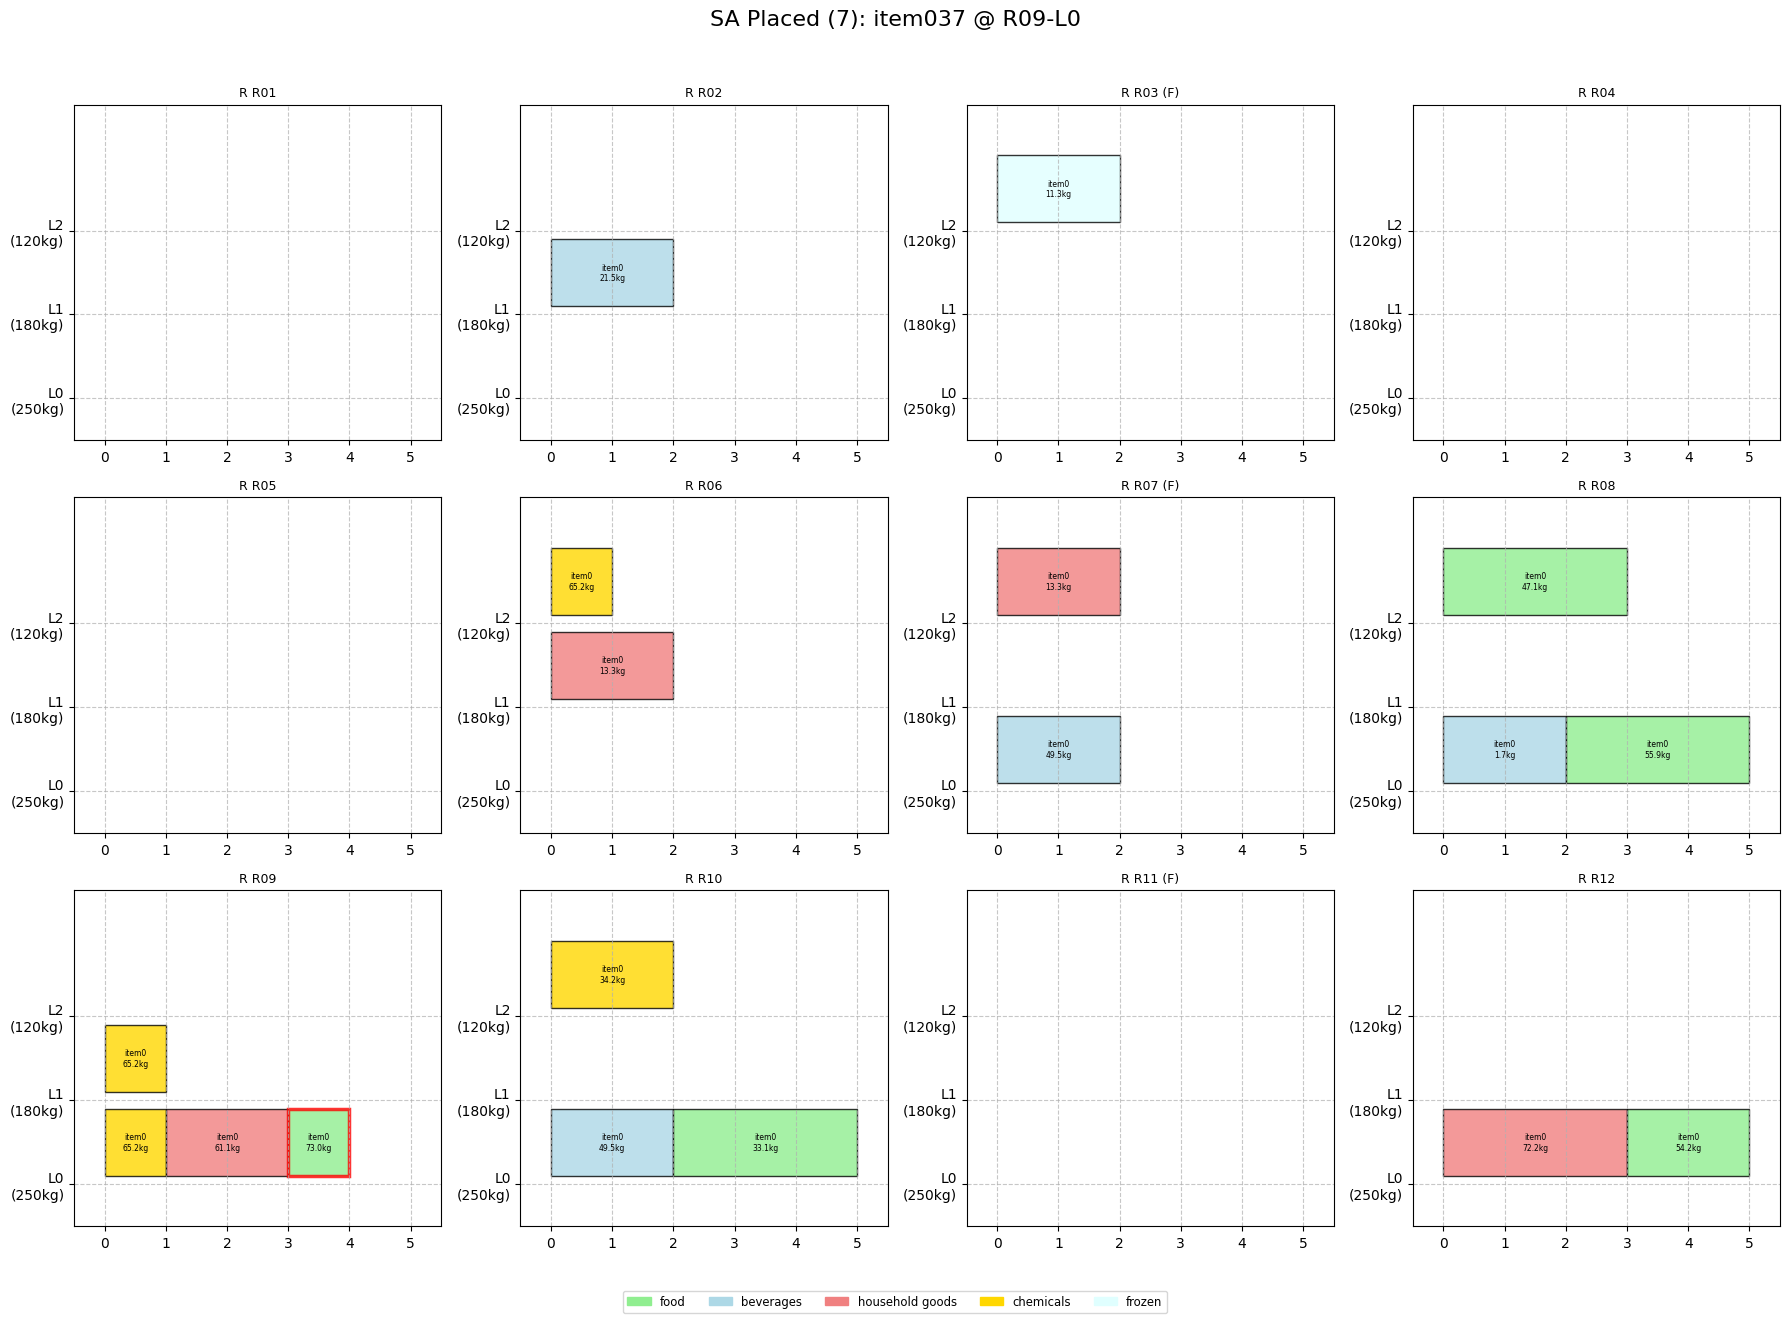



=============== SA ATTEMPTING INSERTION 8/10 FOR ITEM: item027 ===============
  SA for item027: Initial random choice ('R01', 2), Cost: -6.20
  SA for item027: Best placement ('R08', 2), Score: 7.60 (Cost: -7.60)


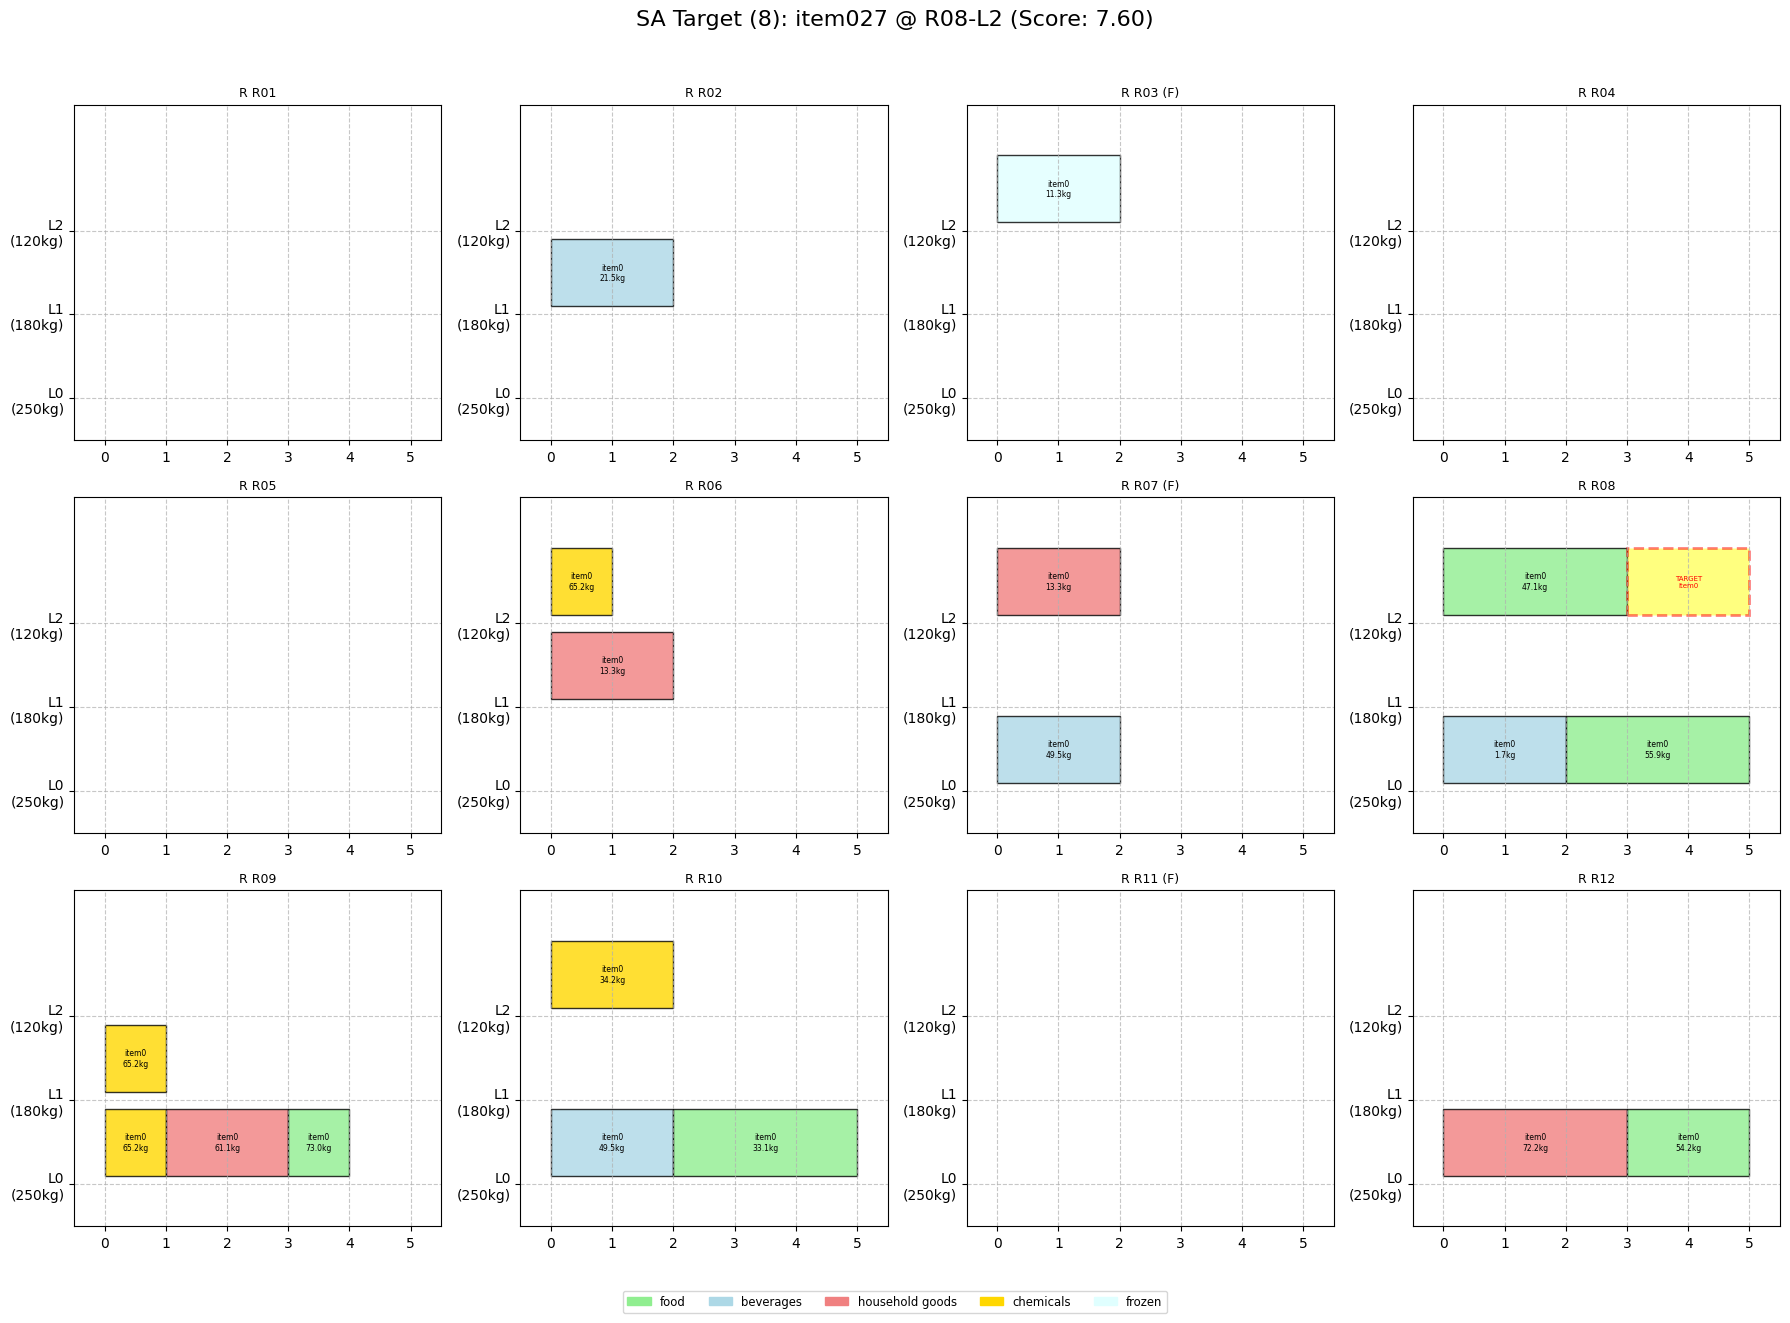


--- SA Placing item027 at ('R08', 2) ---


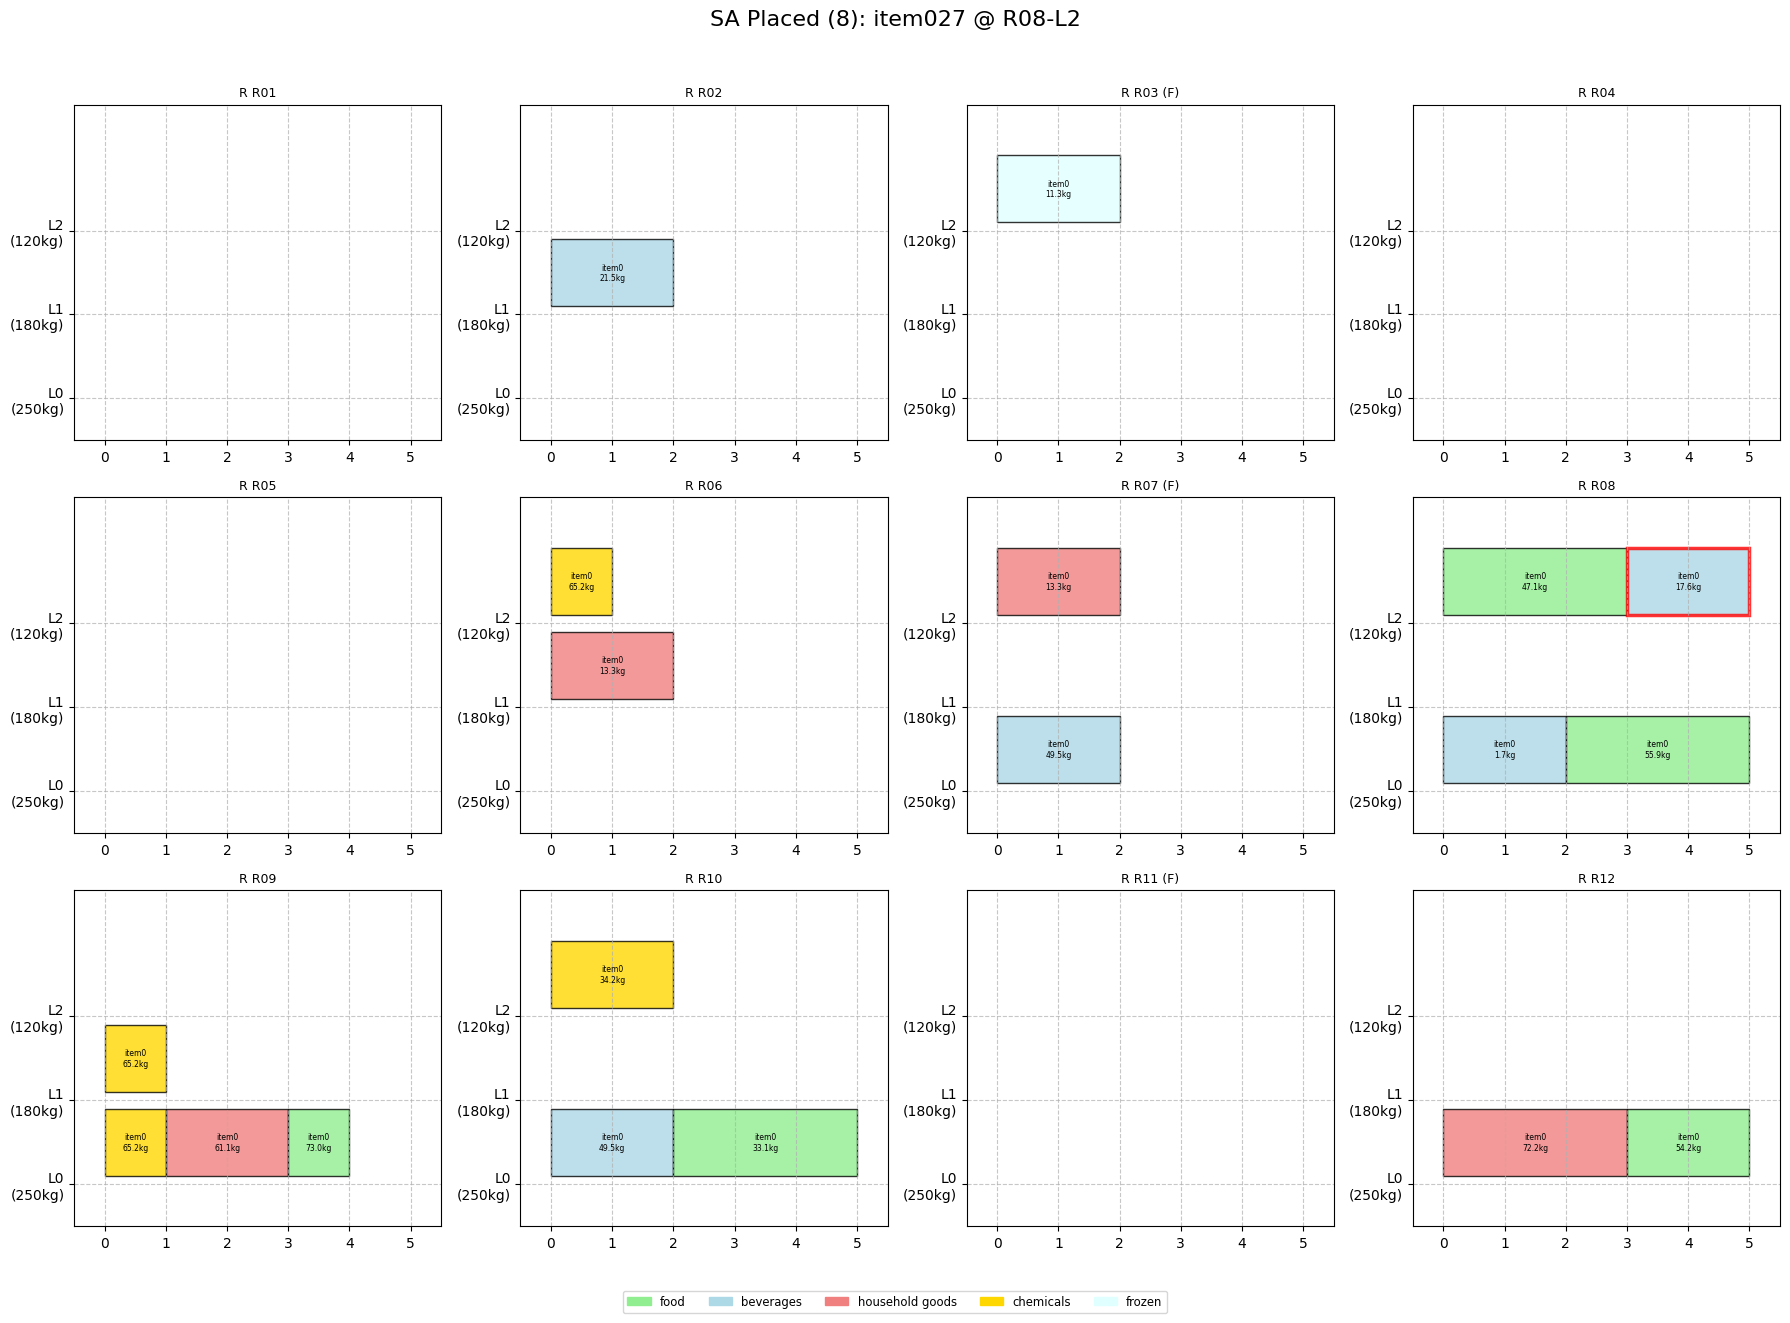



=============== SA ATTEMPTING INSERTION 9/10 FOR ITEM: item044 ===============
  SA for item044: Initial random choice ('R02', 2), Cost: -1.53
  SA for item044: Best placement ('R12', 1), Score: 6.50 (Cost: -6.50)


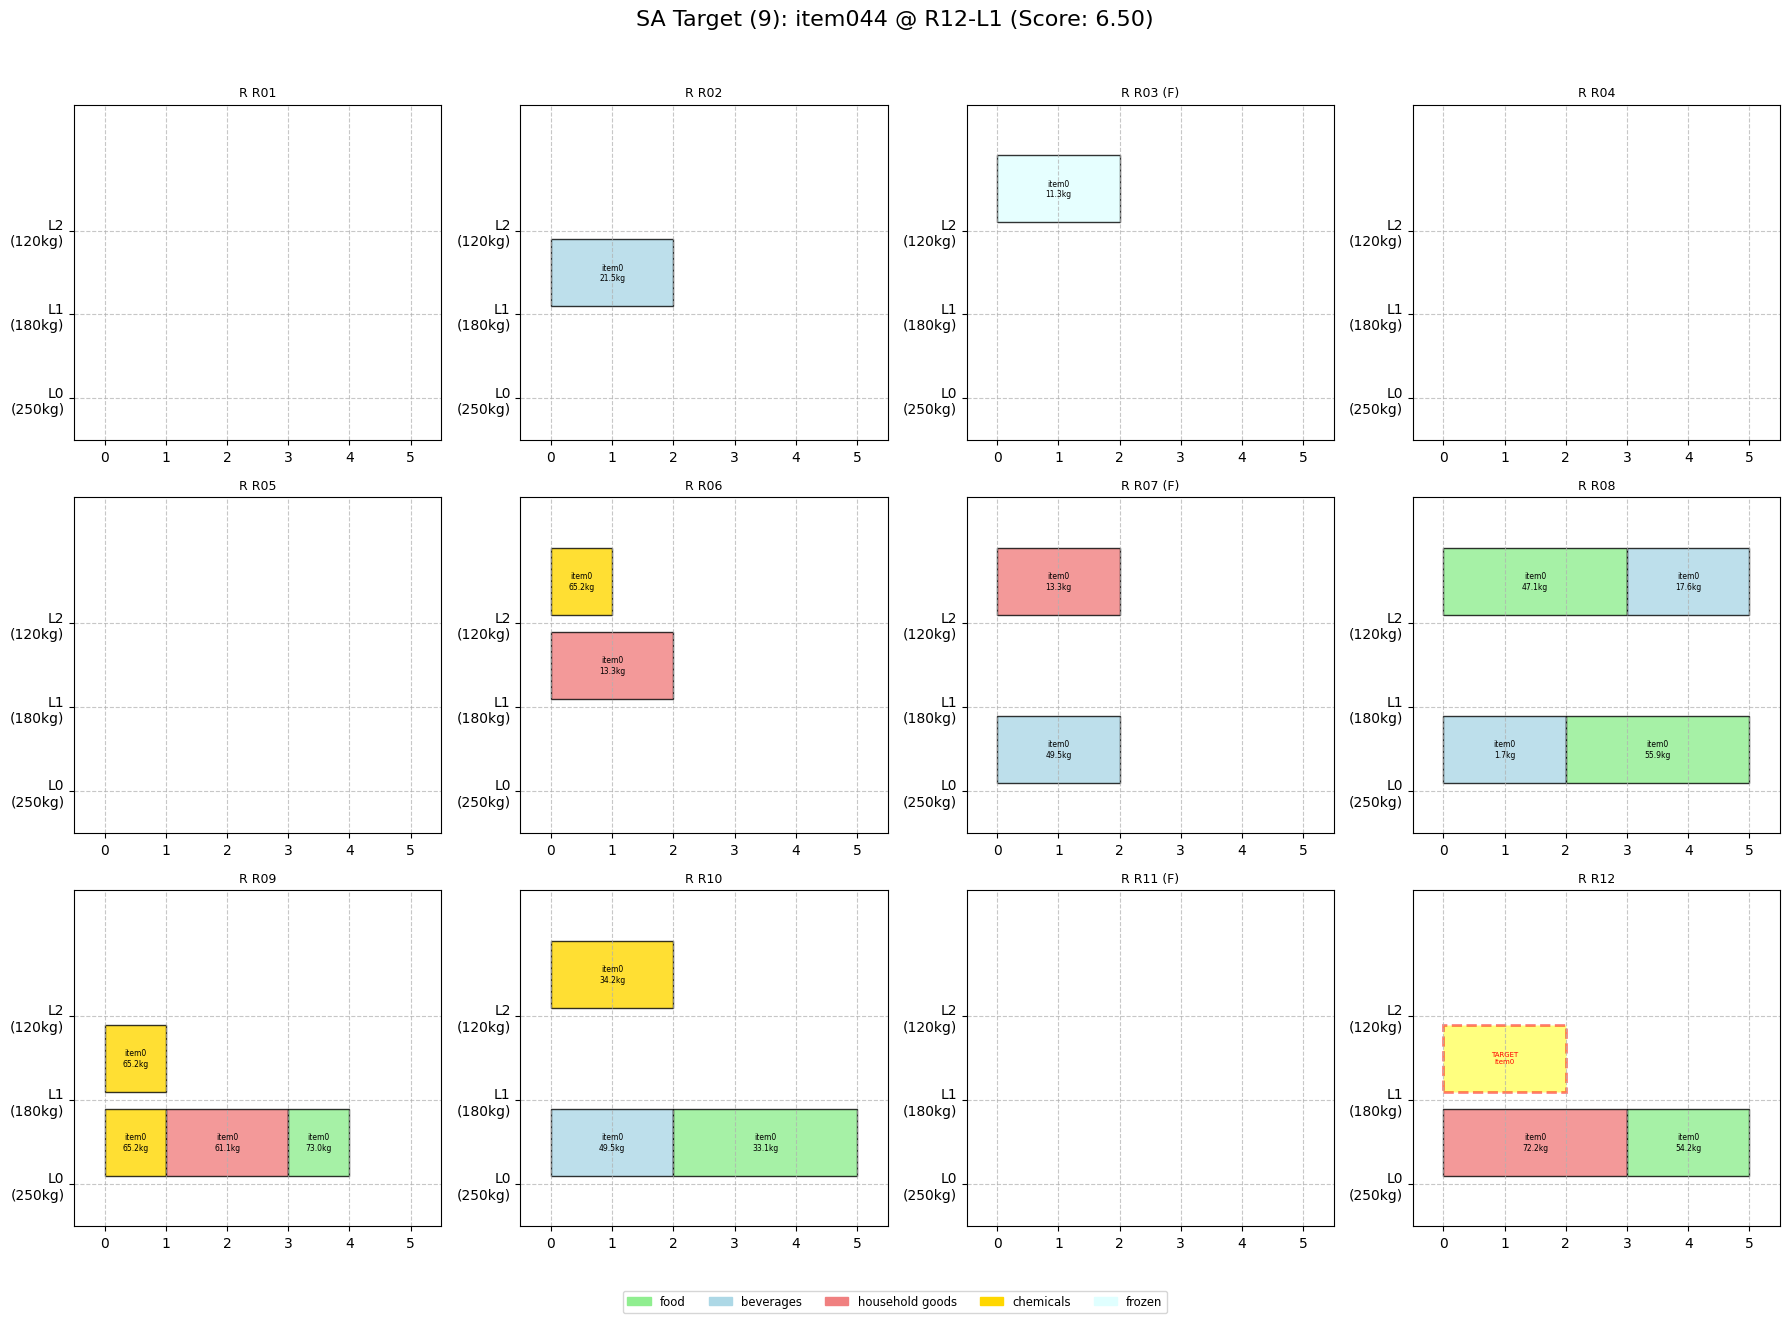


--- SA Placing item044 at ('R12', 1) ---


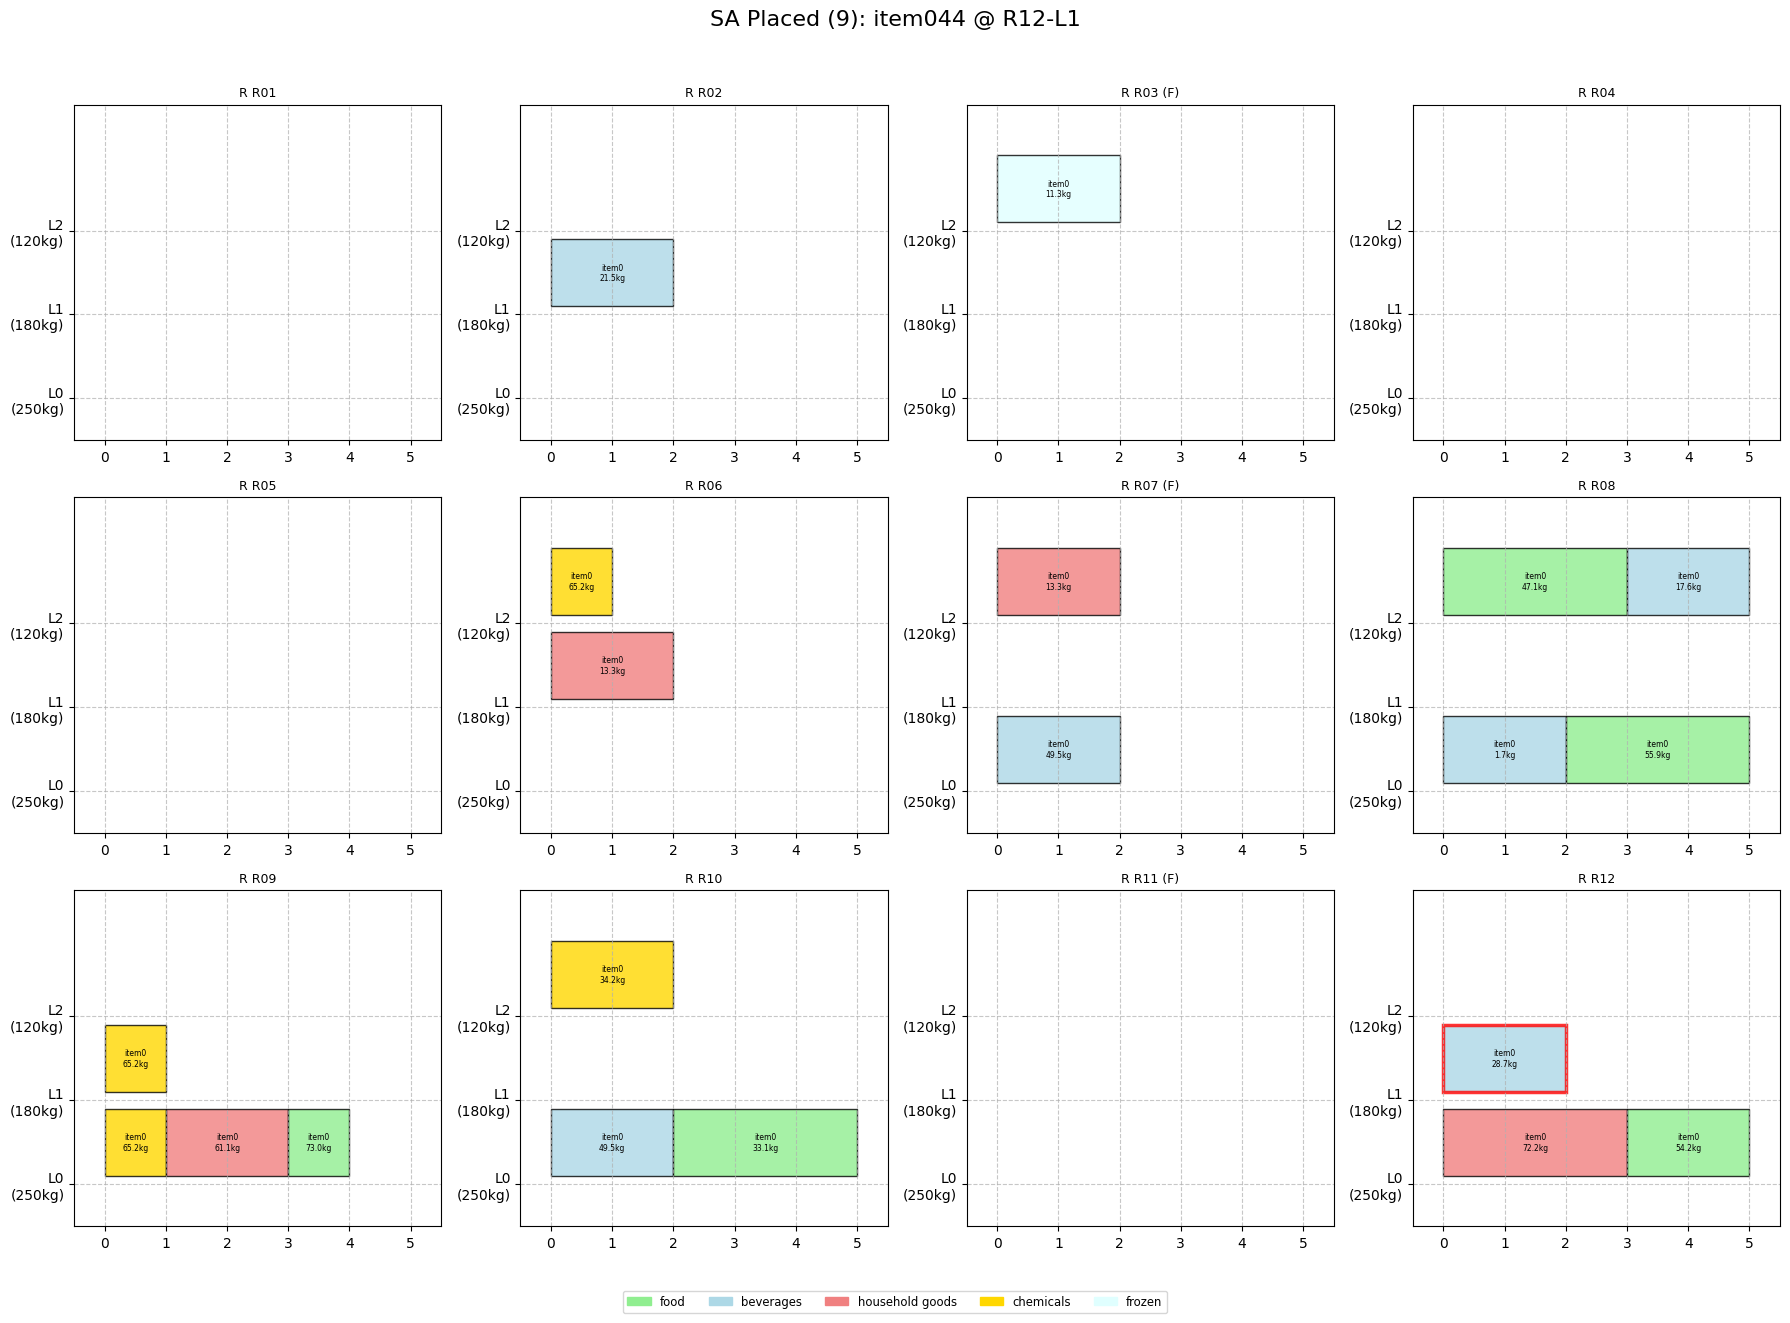



=============== SA ATTEMPTING INSERTION 10/10 FOR ITEM: item049 ===============
  SA for item049: Initial random choice ('R04', 1), Cost: -4.63
  SA for item049: Best placement ('R09', 1), Score: 7.80 (Cost: -7.80)


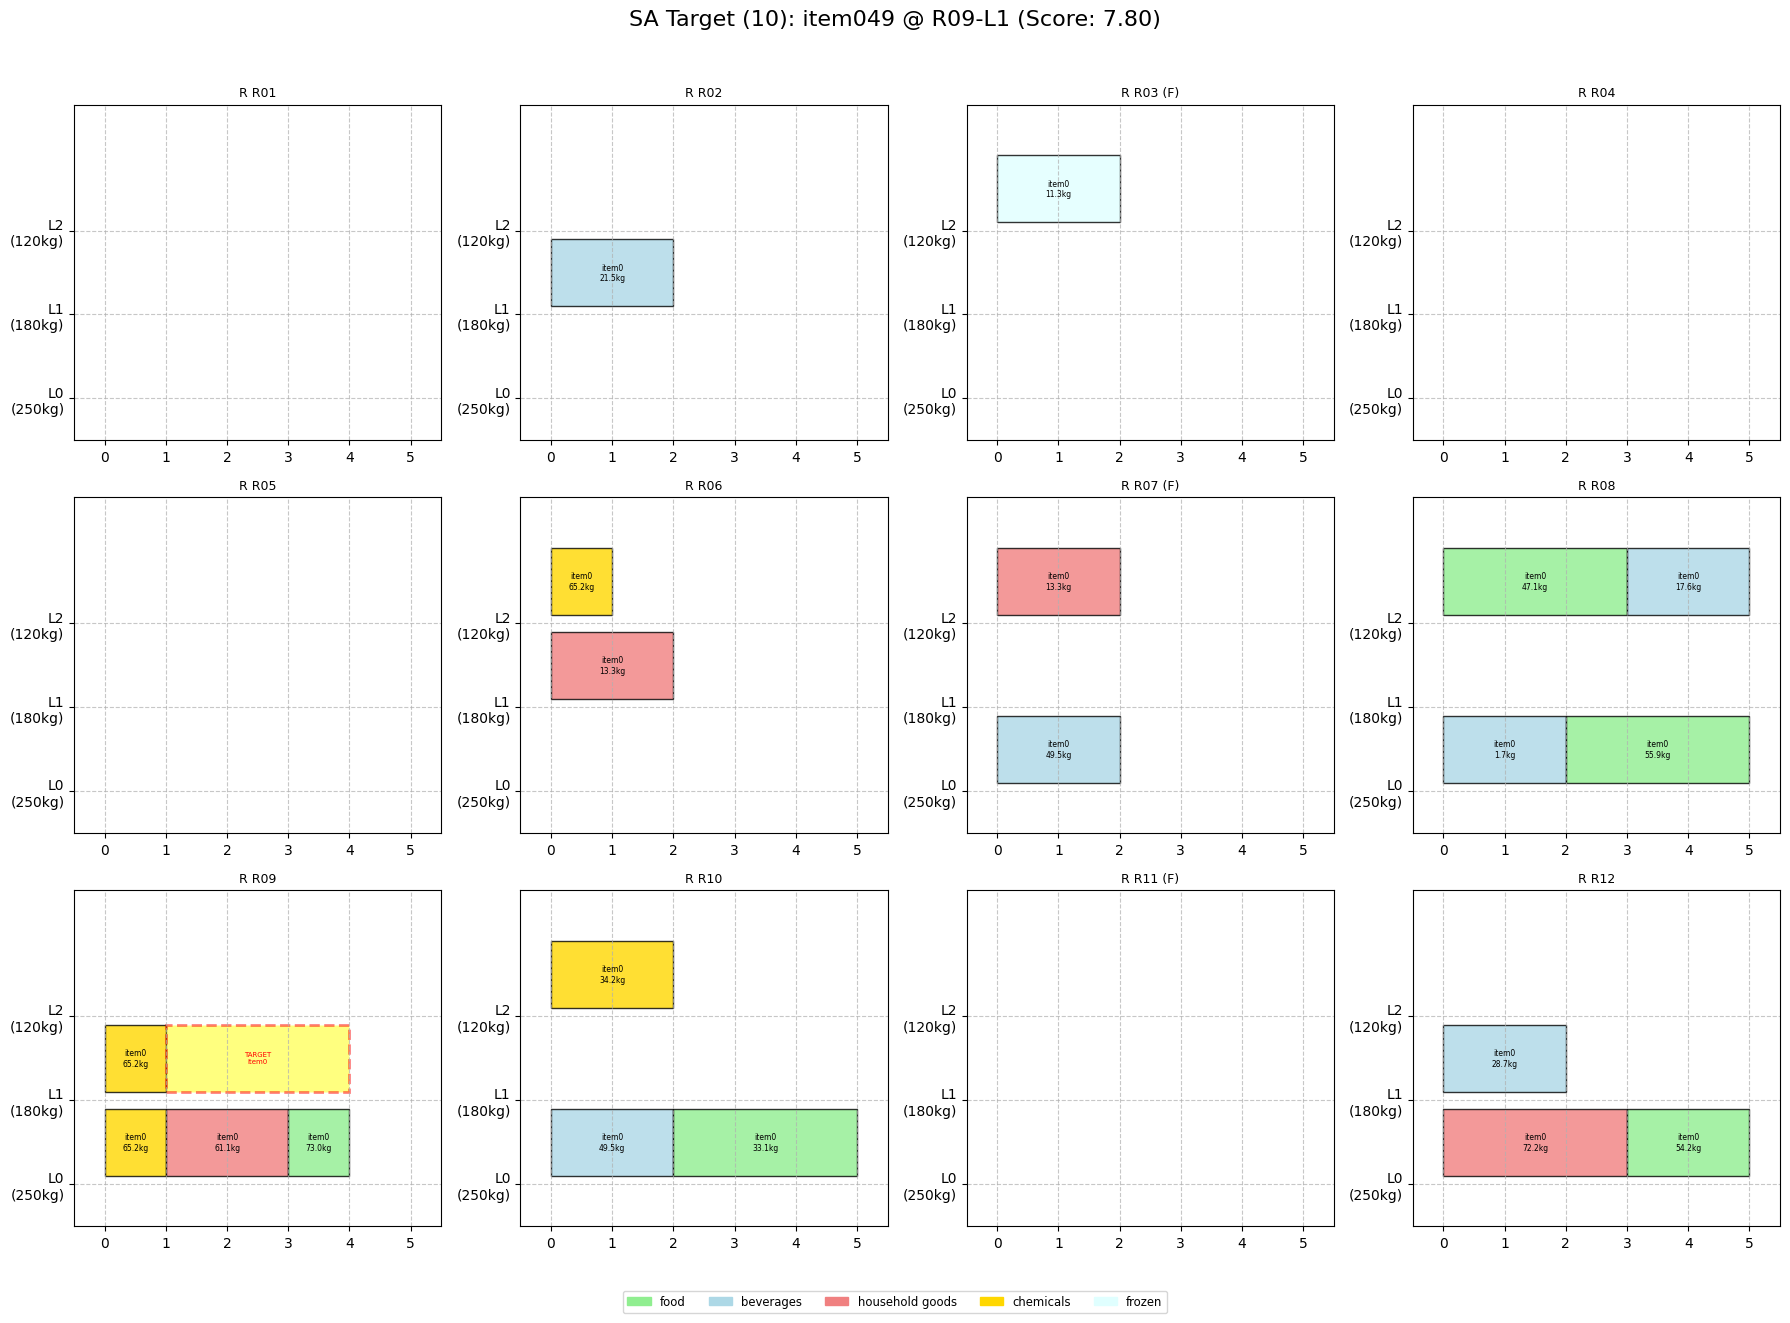


--- SA Placing item049 at ('R09', 1) ---


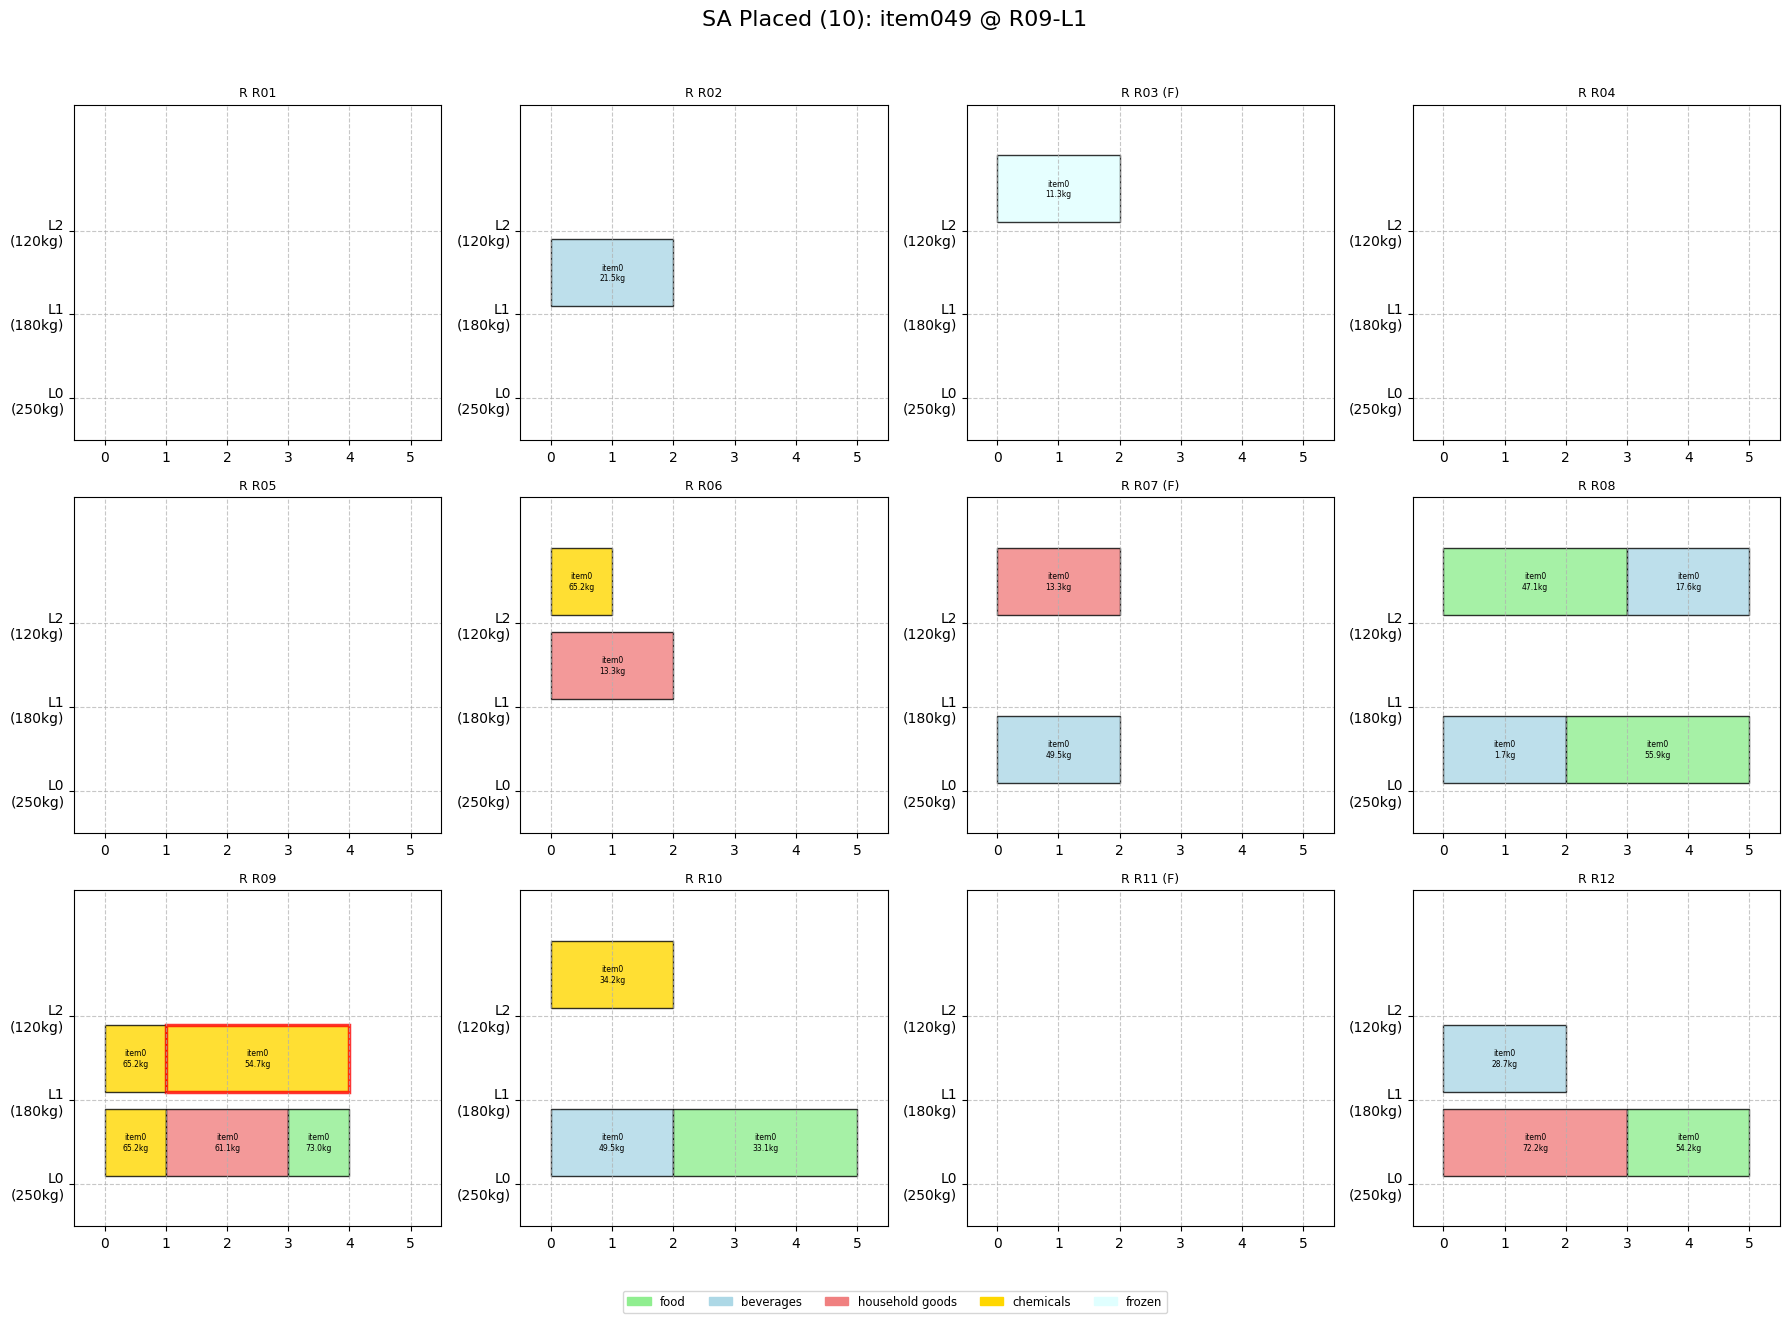


--- Final Warehouse State After All SA Attempts ---


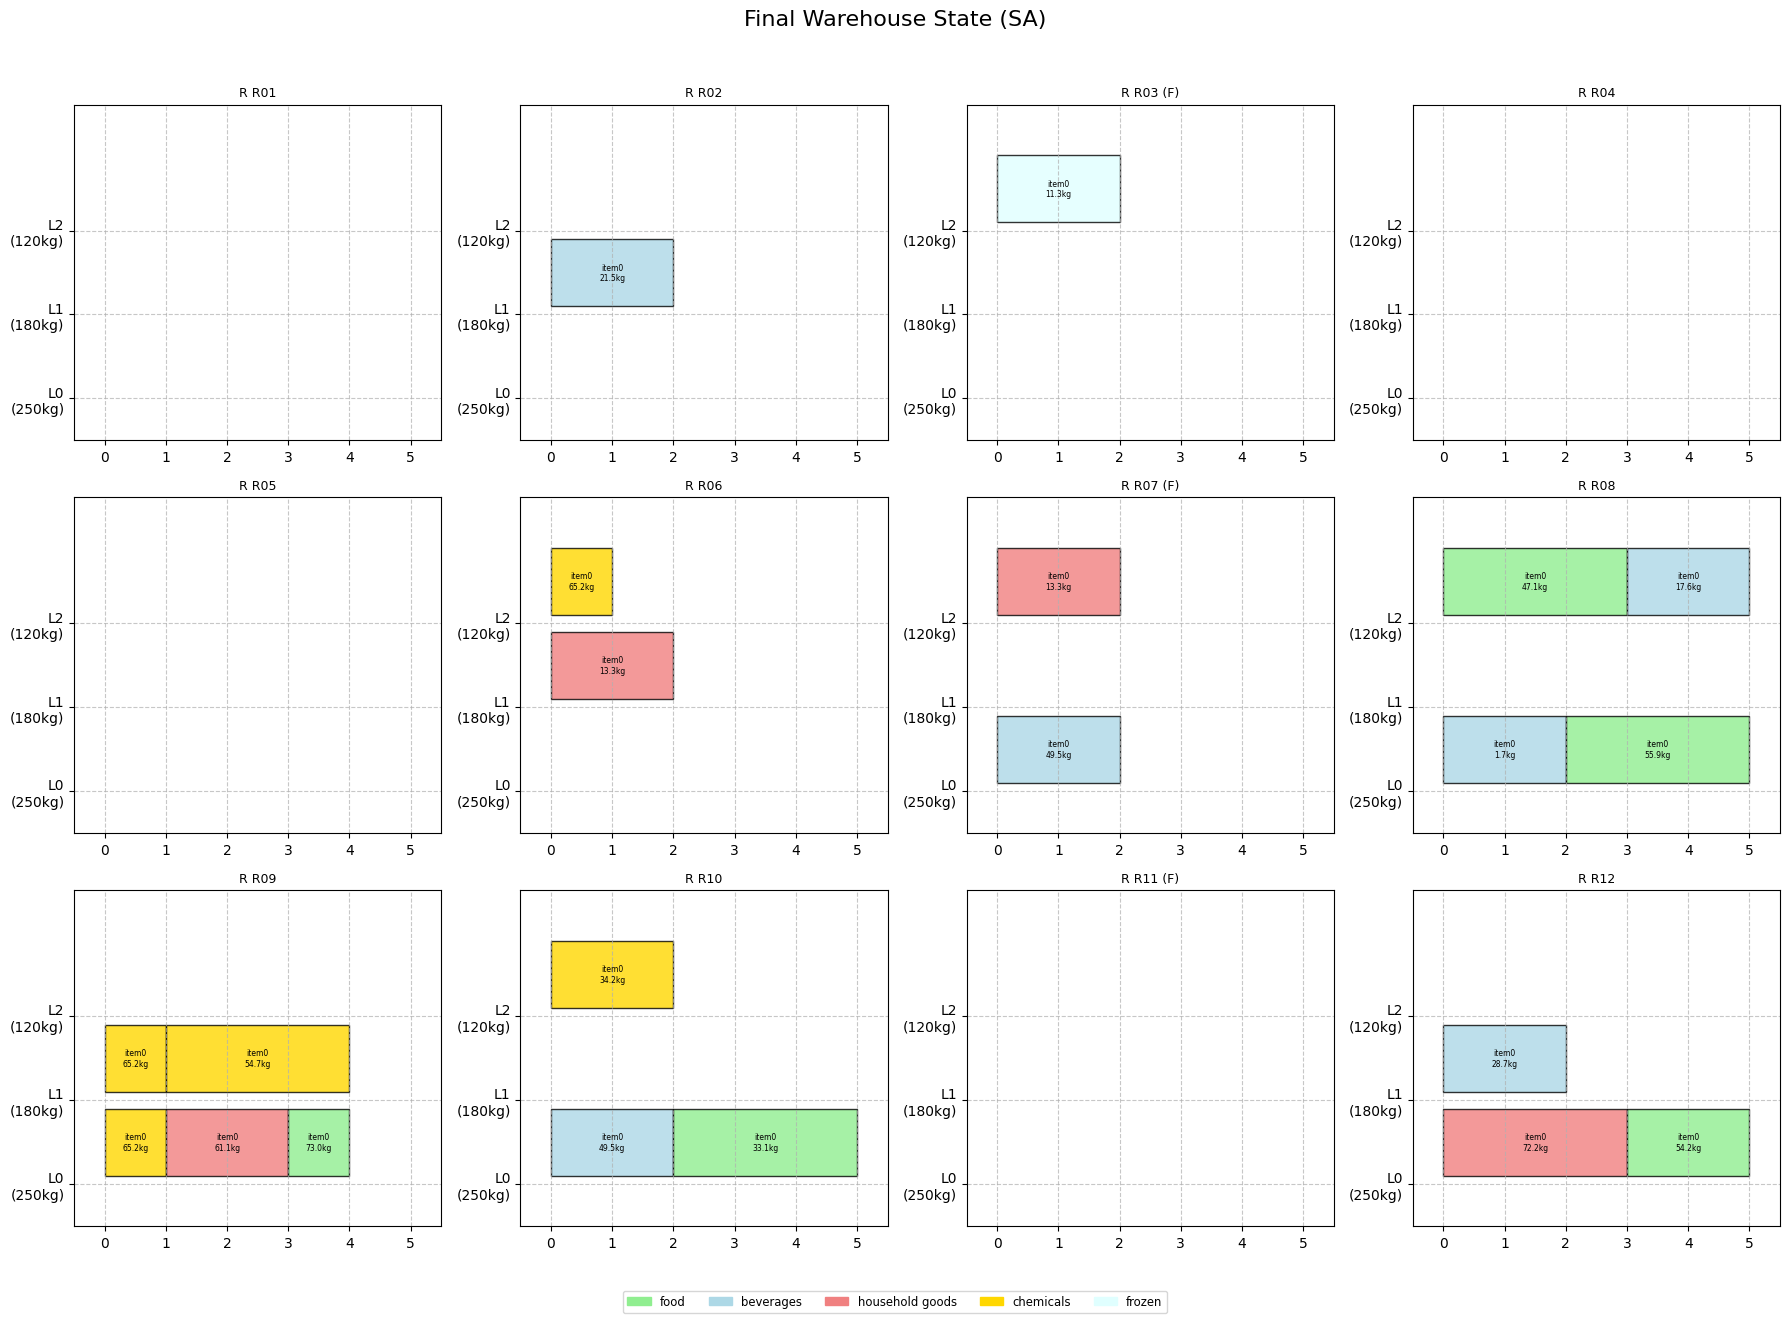



--- SUMMARY OF SA SUCCESSFUL PLACEMENTS ---
Item ID: item042 (Name: Premium Household goods Box) placed at Rack: R12, Shelf: L0 (SA Score: 7.50)
Item ID: item010 (Name: Value Food Unit) placed at Rack: R12, Shelf: L0 (SA Score: 4.87)
Item ID: item045 (Name: Value Food Box) placed at Rack: R10, Shelf: L0 (SA Score: 8.90)
Item ID: item025 (Name: Eco Food Box) placed at Rack: R08, Shelf: L0 (SA Score: 8.90)
Item ID: item013 (Name: Value Frozen Unit) placed at Rack: R03, Shelf: L2 (SA Score: 6.20)
Item ID: item043 (Name: Premium Household goods Unit) placed at Rack: R09, Shelf: L0 (SA Score: 6.70)
Item ID: item037 (Name: Value Food Unit) placed at Rack: R09, Shelf: L0 (SA Score: 6.53)
Item ID: item027 (Name: Eco Beverages Box) placed at Rack: R08, Shelf: L2 (SA Score: 7.60)
Item ID: item044 (Name: Eco Beverages Pack) placed at Rack: R12, Shelf: L1 (SA Score: 6.50)
Item ID: item049 (Name: Premium Chemicals Unit) placed at Rack: R09, Shelf: L1 (SA Score: 7.80)


In [ ]:
# # THIS IS A CONCEPTUAL ADAPTATION AND MAY NOT BE OPTIMAL OR TRULY "SA" FOR INSERTION

# class ProblemForItemInsertion: # New wrapper
#     def __init__(self, warehouse_system: WarehousePlacementSystem, item_to_insert: ItemPlacementData):
#         self.warehouse = warehouse_system
#         self.item_to_insert = item_to_insert
#         self.all_possible_shelves = [] # (rack_id, shelf_level_idx)
#         for r_id, rack in self.warehouse.rack_states_map.items():
#             for s_lvl in range(SHELF_LEVELS):
#                 shelf = rack.get_shelf_state(s_lvl)
#                 # Check basic capacity for the item (slots, weight)
#                 # This pre-filters to make SA's job slightly more focused
#                 can_add, _ = shelf.can_add_item(self.item_to_insert, self.warehouse.max_weight_config_per_level[s_lvl])
#                 if can_add:
#                      # Also check frozen compatibility here as a hard pre-filter
#                     is_frozen_compatible = not (self.item_to_insert.is_frozen and not rack.is_rack_frozen) and \
#                                           not (not self.item_to_insert.is_frozen and rack.is_rack_frozen and shelf.items_on_shelf)
#                     if is_frozen_compatible:
#                         self.all_possible_shelves.append((r_id, s_lvl))
#         if not self.all_possible_shelves:
#             print(f"Warning: No shelves initially seem viable for {self.item_to_insert.item_id} (slots/weight/frozen basic check).")


#     def generate_initial_state(self):
#         # Initial state is a randomly chosen valid shelf for THIS item
#         if not self.all_possible_shelves:
#             return None # No possible placement
#         return random.choice(self.all_possible_shelves) # e.g., ('R01', 0)

#     def evaluate(self, placement_tuple): # placement_tuple is (rack_id, shelf_level_idx)
#         # Evaluate placing self.item_to_insert at placement_tuple
#         if placement_tuple is None:
#             return float('inf'), {} # High cost if no placement

#         rack_id, shelf_level_idx = placement_tuple
#         rack = self.warehouse.rack_states_map.get(rack_id)
#         if not rack: return float('inf'), {}
#         shelf = rack.get_shelf_state(shelf_level_idx)
#         if not shelf: return float('inf'), {}

#         placement_score, breakdown = self.warehouse.evaluate_potential_placement(self.item_to_insert, rack, shelf)
        
#         if placement_score == -float('inf'):
#             return float('inf'), breakdown # SA minimizes cost, so -inf score is +inf cost
        
#         # SA minimizes cost, our score maximizes goodness. So, cost = -score.
#         # Add a large constant to ensure cost is mostly positive if scores are small,
#         # or handle negative costs appropriately in acceptance probability.
#         # For simplicity, let's just use -score.
#         return -placement_score, breakdown

#     def generate_neighbor(self, current_placement_tuple):
#         # Pick a *different* random valid shelf for THIS item
#         if not self.all_possible_shelves:
#             return None
        
#         if current_placement_tuple is None and self.all_possible_shelves: # If current couldn't be placed, try any
#              return random.choice(self.all_possible_shelves)

#         # Try to find a different one
#         potential_neighbors = [p for p in self.all_possible_shelves if p != current_placement_tuple]
#         if not potential_neighbors: # Only one possible shelf, or no shelves
#             return current_placement_tuple # Or None if no self.all_possible_shelves
            
#         return random.choice(potential_neighbors)


# def run_sa_for_single_item_insertion(problem_inserter: ProblemForItemInsertion, initial_temp, cooling_rate, iterations):
#     current_placement = problem_inserter.generate_initial_state()
#     if current_placement is None:
#         print(f"No initial valid placement found for item {problem_inserter.item_to_insert.item_id} via SA problem setup.")
#         return None, float('inf'), {}

#     current_cost, _ = problem_inserter.evaluate(current_placement)
    
#     best_placement = current_placement
#     best_cost = current_cost
    
#     cost_history_sa_item = [current_cost]

#     print(f"  SA for {problem_inserter.item_to_insert.item_id}: Initial random choice {current_placement}, Cost: {current_cost:.2f}")

#     for i in range(iterations):
#         temp = initial_temp * (cooling_rate ** i)
#         if temp < 1e-3: # Adjusted stopping condition for cost
#             break
            
#         neighbor_placement = problem_inserter.generate_neighbor(current_placement)
#         if neighbor_placement is None: # Should not happen if all_possible_shelves is populated
#             continue

#         neighbor_cost, _ = problem_inserter.evaluate(neighbor_placement)
        
#         if neighbor_cost < current_cost or \
#            (current_cost != float('inf') and temp > 0 and random.random() < math.exp((current_cost - neighbor_cost) / temp)):
#             current_placement = neighbor_placement
#             current_cost = neighbor_cost
            
#             if neighbor_cost < best_cost:
#                 best_placement = neighbor_placement
#                 best_cost = neighbor_cost
        
#         cost_history_sa_item.append(current_cost)
#         # if i % (iterations//10) == 0:
#         #     print(f"    SA Iter {i}: Item {problem_inserter.item_to_insert.item_id}, CurrentCost {-current_cost:.2f}, BestCost {-best_cost:.2f}, Temp {temp:.2f}")
            
#     final_score, final_breakdown = problem_inserter.evaluate(best_placement) # Get score & breakdown of best
#     print(f"  SA for {problem_inserter.item_to_insert.item_id}: Best placement {best_placement}, Score: {-best_cost:.2f} (Cost: {best_cost:.2f})")
#     return best_placement, -best_cost, final_breakdown # Return score (not cost)

# # --- MAIN EXECUTION MODIFIED TO USE THIS SA APPROACH ---
# if __name__ == "__main__":
#     # --- Data Generation and Warehouse Setup (Same as your Steepest Ascent main) ---
#     # (generate_dummy_item_csv, generate_dummy_rack_layout_csv)
#     # (Initialize WarehousePlacementSystem: placement_system)
#     # (Load items, initialize layout)
#     # (Visualize initial state)
#     # (Select items_to_insert_list)

#     print("--- Generating Dummy Data ---")
#     generate_dummy_item_csv("dummy_items.csv", num_items=50)
#     try:
#         with open("facts.json", 'r') as f: facts_content = json.load(f)
#         rack_ids_from_facts = list(facts_content.get("racks_info", {}).keys())
#         item_ids_for_layout_gen = list(pd.read_csv("dummy_items.csv")['id'])
#     except Exception as e:
#         rack_ids_from_facts = [f"R{str(i+1).zfill(2)}" for i in range(12)]
#         item_ids_for_layout_gen = [f"item{str(i+1).zfill(3)}" for i in range(50)]
#     generate_dummy_rack_layout_csv("dummy_rack_layout.csv", rack_ids=rack_ids_from_facts, item_ids_for_layout=item_ids_for_layout_gen[:15])
#     print("-" * 30)

#     placement_system = WarehousePlacementSystem(facts_json_file="facts.json")
#     placement_system.load_item_properties_from_csv("dummy_items.csv")
#     placement_system.initialize_layout_from_csv("dummy_rack_layout.csv")

#     print("\n--- Initial Warehouse State ---")
#     placement_system.visualize_current_state("Initial Warehouse State")

#     all_item_ids_in_db = list(placement_system.item_database.keys())
#     placed_item_ids = set()
#     for rack_state in placement_system.rack_states_map.values():
#         for shelf_state in rack_state.shelf_states:
#             for item_in_shelf in shelf_state.items_on_shelf: placed_item_ids.add(item_in_shelf.item_id)
    
#     items_to_attempt_placement = [id_val for id_val in all_item_ids_in_db if id_val not in placed_item_ids]
#     random.shuffle(items_to_attempt_placement)
#     items_to_insert_list = items_to_attempt_placement[:10]

#     if not items_to_insert_list:
#         print("No new items from DB to insert.")

#     successful_placements_summary_sa = []

#     for i, item_id_to_add in enumerate(items_to_insert_list):
#         print(f"\n\n{'='*15} SA ATTEMPTING INSERTION {i+1}/{len(items_to_insert_list)} FOR ITEM: {item_id_to_add} {'='*15}")
#         item_details_for_sa = placement_system._get_item_placement_data_by_id(item_id_to_add)
#         if not item_details_for_sa:
#             print(f"Item {item_id_to_add} details not found. Skipping.")
#             continue
        
#         # Create a problem instance for inserting THIS specific item
#         # The warehouse_system state is captured at this moment
#         current_warehouse_state_for_sa = copy.deepcopy(placement_system) # SA might explore, don't modify original yet
        
#         item_insertion_problem = ProblemForItemInsertion(current_warehouse_state_for_sa, item_details_for_sa)

#         if not item_insertion_problem.all_possible_shelves:
#              print(f"===> No viable shelves for item {item_id_to_add} (basic checks failed). Item not placed. <===")
#              # Optionally visualize current state
#              placement_system.visualize_current_state(f"No viable shelves for {item_id_to_add} ({i+1})")
#              continue


#         # Run SA to find the best placement for THIS item
#         # SA Parameters for single item placement - might need different tuning
#         sa_initial_temp = 100  # Lower temp as the search space (number of shelves) is small
#         sa_cooling_rate = 0.95 
#         sa_iterations = 200    # Fewer iterations might be sufficient

#         chosen_placement_tuple, chosen_score, _ = run_sa_for_single_item_insertion(
#             item_insertion_problem, 
#             initial_temp=sa_initial_temp, 
#             cooling_rate=sa_cooling_rate, 
#             iterations=sa_iterations
#         )
        
#         if chosen_placement_tuple and chosen_score > -float('inf'): # Check for valid score
#             successful_placements_summary_sa.append({
#                 "item_id": item_details_for_sa.item_id,
#                 "item_name": item_details_for_sa.name,
#                 "rack_id": chosen_placement_tuple[0],
#                 "shelf_level": chosen_placement_tuple[1],
#                 "score": chosen_score
#             })

#             # Visualize target on a non-modified copy of the *original* placement_system
#             wh_copy_viz = copy.deepcopy(placement_system)
#             wh_copy_viz.visualize_current_state(
#                 f"SA Target ({i+1}): {item_details_for_sa.item_id} @ {chosen_placement_tuple[0]}-L{chosen_placement_tuple[1]} (Score: {chosen_score:.2f})",
#                 item_id_to_highlight=item_id_to_add, rack_id_to_highlight=chosen_placement_tuple[0], shelf_level_to_highlight=chosen_placement_tuple[1]
#             )
            
#             print(f"\n--- SA Placing {item_id_to_add} at {chosen_placement_tuple} ---")
#             # Execute placement on the *original* placement_system
#             if placement_system.execute_item_placement(item_id_to_add, chosen_placement_tuple):
#                 placement_system.visualize_current_state(
#                     f"SA Placed ({i+1}): {item_details_for_sa.item_id} @ {chosen_placement_tuple[0]}-L{chosen_placement_tuple[1]}",
#                     item_id_to_highlight=item_id_to_add, rack_id_to_highlight=chosen_placement_tuple[0], shelf_level_to_highlight=chosen_placement_tuple[1]
#                 )
#                 if item_id_to_add in placement_system.item_database:
#                     placement_system.item_database[item_id_to_add]['insertion_counter'] +=1
#             else:
#                 print(f"SA Placement execution failed for {item_id_to_add} despite a spot being found.")
#                 successful_placements_summary_sa = [p for p in successful_placements_summary_sa if p["item_id"] != item_id_to_add]
#         else:
#             print(f"===> SA found no suitable spot for item {item_id_to_add}. Item not placed. <===")
#             placement_system.visualize_current_state(f"SA: No spot for {item_id_to_add} ({i+1})")
        
#     print("\n--- Final Warehouse State After All SA Attempts ---")
#     placement_system.visualize_current_state("Final Warehouse State (SA)")

#     print("\n\n--- SUMMARY OF SA SUCCESSFUL PLACEMENTS ---")
#     if successful_placements_summary_sa:
#         for placement in successful_placements_summary_sa:
#             print(f"Item ID: {placement['item_id']} (Name: {placement['item_name']}) placed at Rack: {placement['rack_id']}, Shelf: L{placement['shelf_level']} (SA Score: {placement['score']:.2f})")
#     else:
#         print("No items were successfully placed by SA during this simulation.")

# Path Finding

## Greedy


--- Operation 1/10 ---
Selected Start: N7-16, Selected Goal: N17-12

Running Greedy Best-First Search...
✅ Greedy Path: N7-16 -> N8-16 -> N9-16 -> N10-16 -> N11-16 -> N12-16 -> N13-17 -> N14-17 -> N15-17 -> N16-17 -> N17-17 -> N18-20 -> N18-19 -> N18-18 -> N17-15 -> N18-16 -> N18-15 -> N18-14 -> N17-13 -> N17-12
   Path Length: 19 edges, Nodes in Closed Set: 34


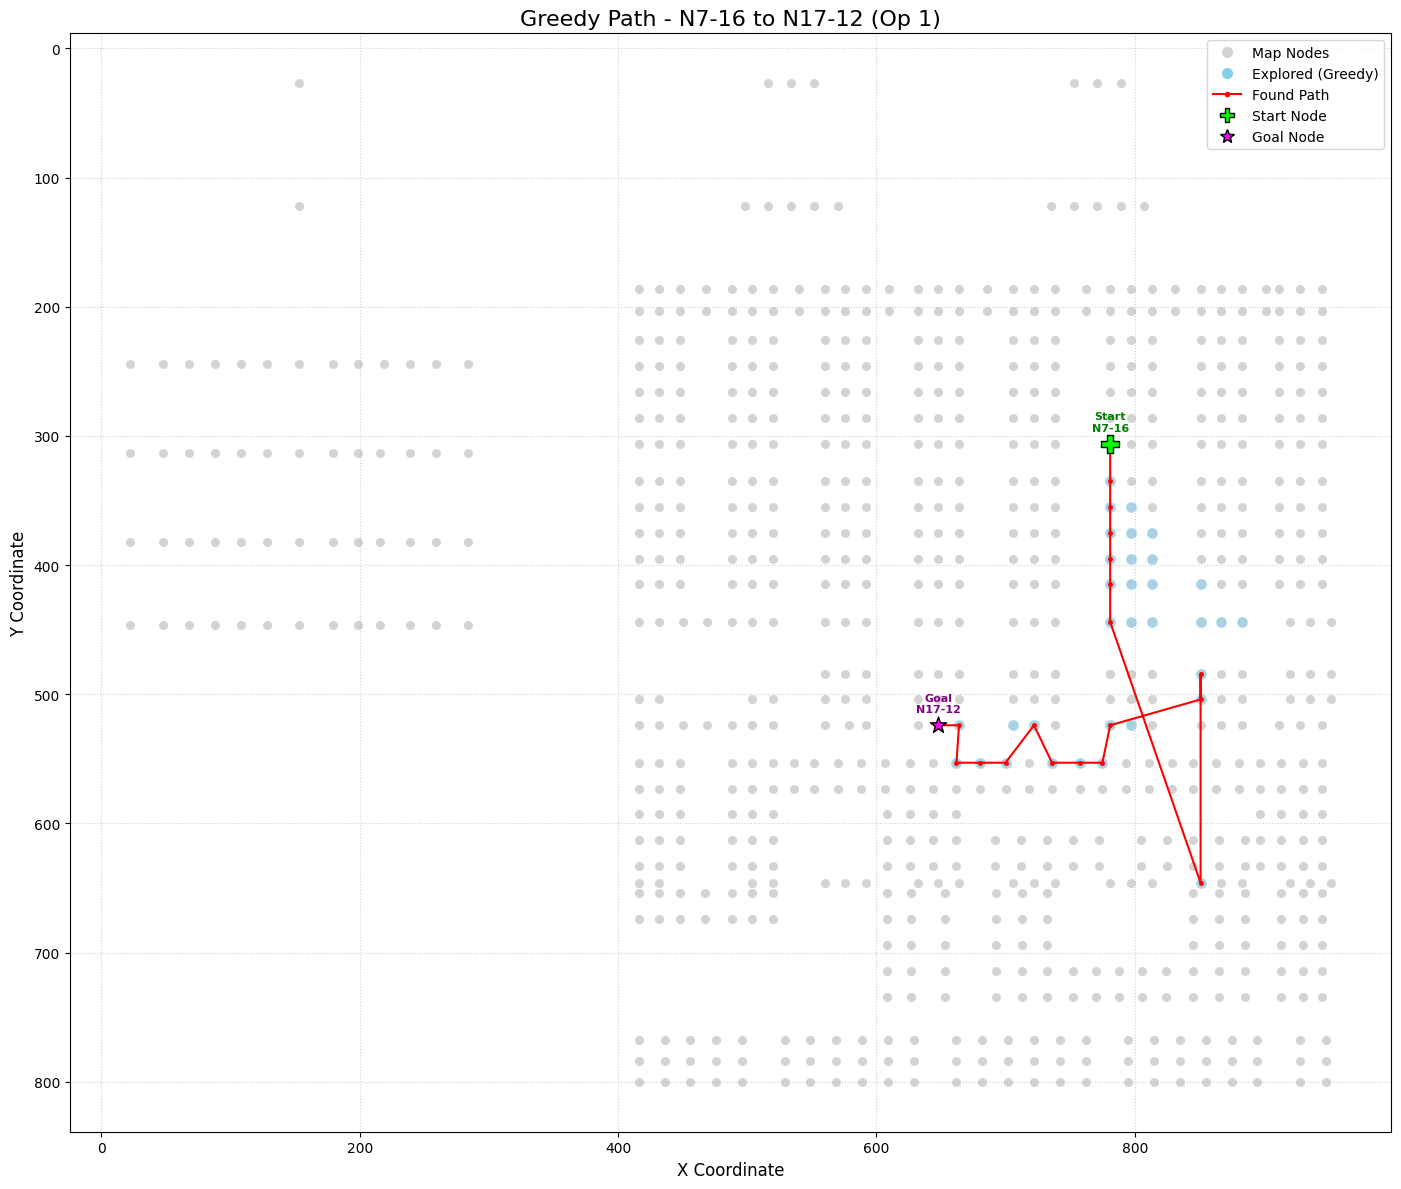


--- Operation 2/10 ---
Selected Start: N29-23, Selected Goal: N25-7

Running Greedy Best-First Search...
❌ Greedy: No path found.
No path to plot for 'Greedy - No Path - N29-23 to N25-7 (Op 2)'. Start/Goal will still be shown if valid.


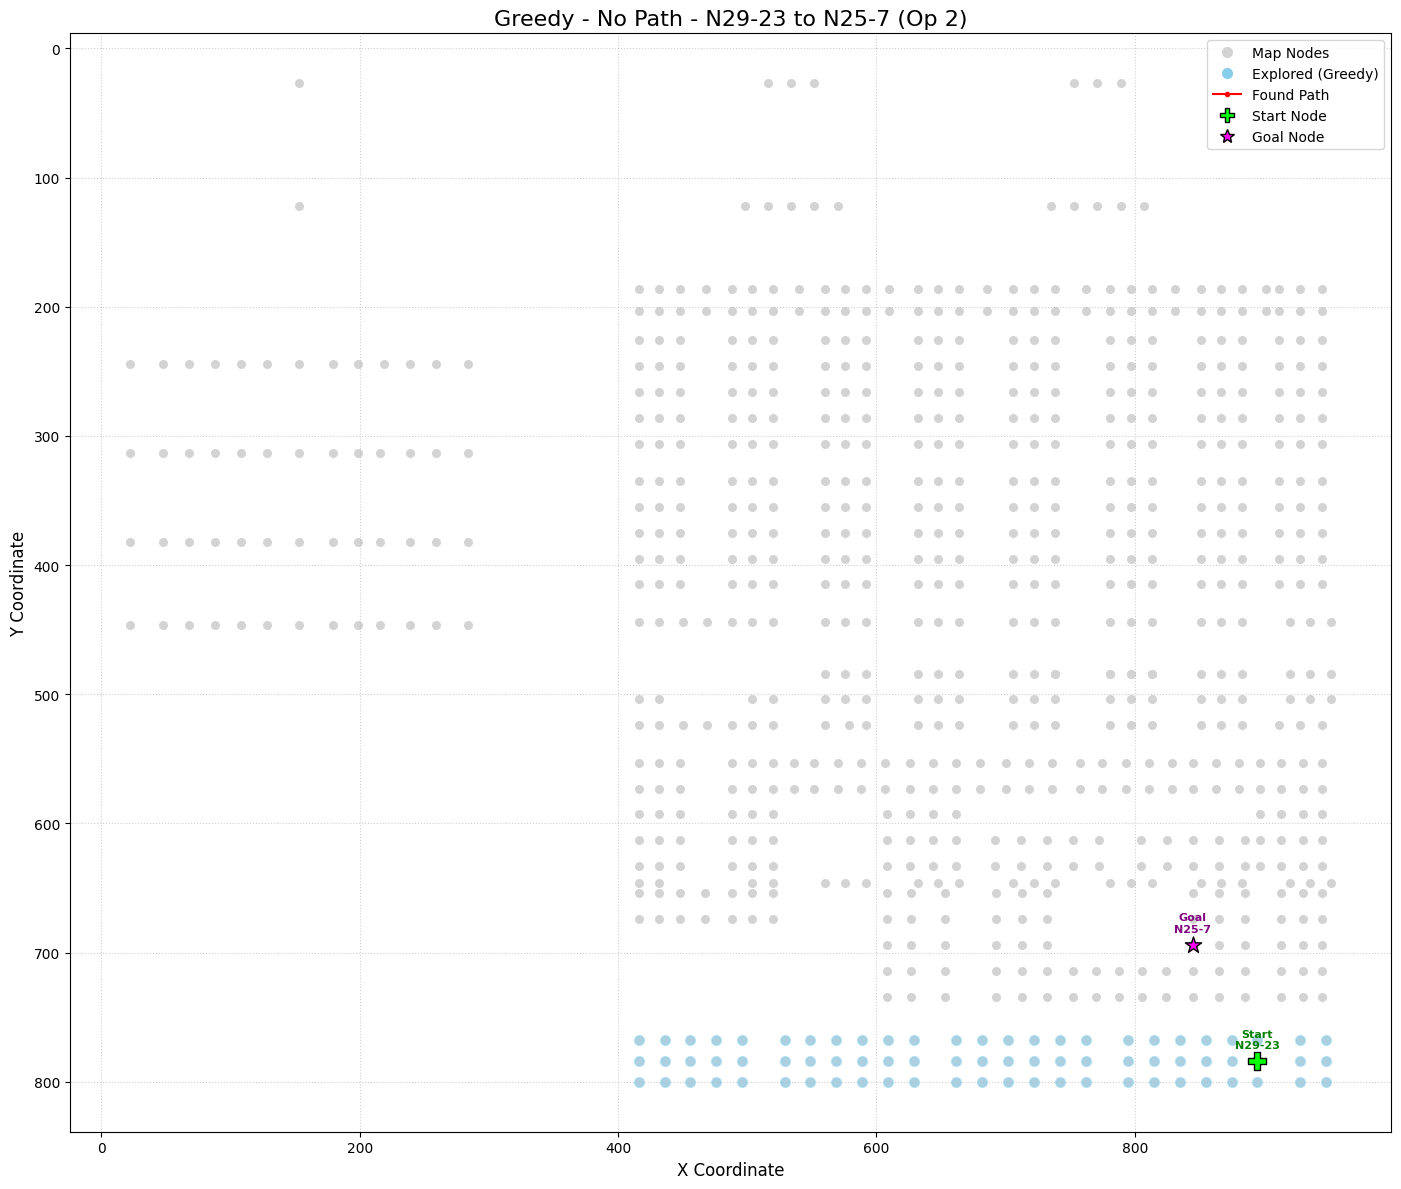


--- Operation 3/10 ---
Selected Start: N17-21, Selected Goal: C2-2

Running Greedy Best-First Search...
❌ Greedy: No path found.
No path to plot for 'Greedy - No Path - N17-21 to C2-2 (Op 3)'. Start/Goal will still be shown if valid.


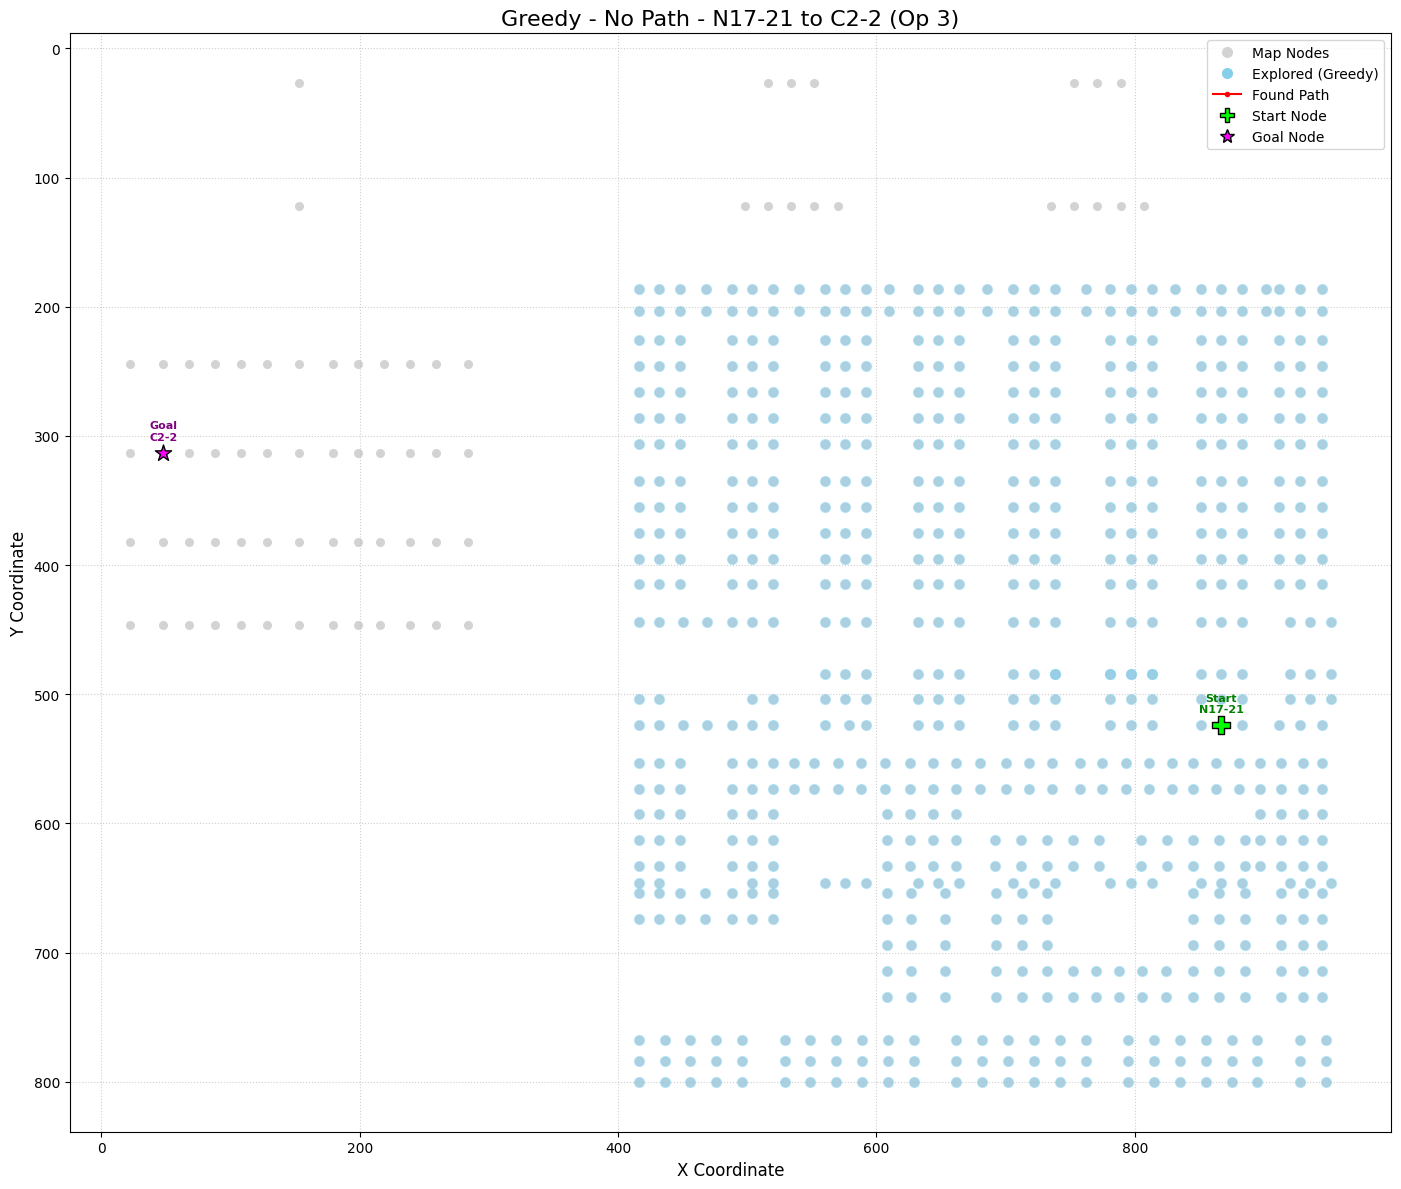


--- Operation 4/10 ---
Selected Start: N29-24, Selected Goal: E1-6

Running Greedy Best-First Search...
❌ Greedy: No path found.
No path to plot for 'Greedy - No Path - N29-24 to E1-6 (Op 4)'. Start/Goal will still be shown if valid.


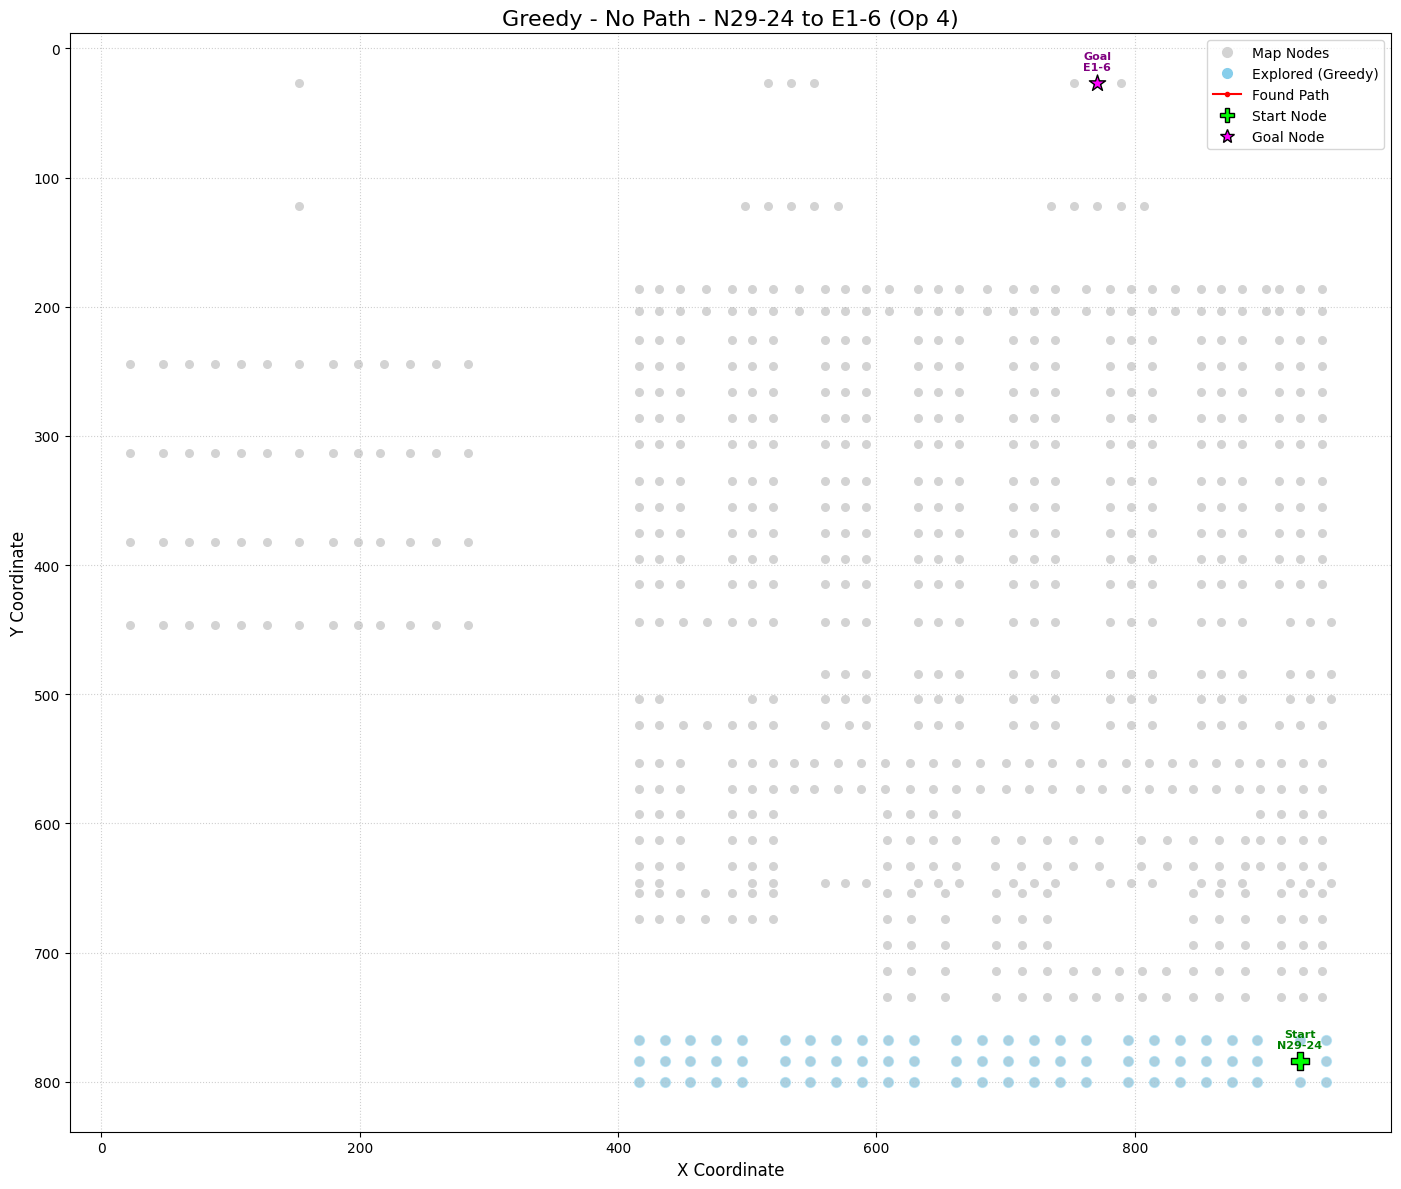


--- Operation 5/10 ---
Selected Start: N1-10, Selected Goal: N14-16

Running Greedy Best-First Search...
✅ Greedy Path: N1-10 -> N2-11 -> N3-9 -> N4-9 -> N5-9 -> N6-9 -> N7-9 -> N8-9 -> N9-9 -> N10-9 -> N11-9 -> N12-9 -> N13-10 -> N14-10 -> N15-10 -> N16-10 -> N17-10 -> N18-10 -> N19-11 -> N20-8 -> N21-9 -> N20-10 -> N19-14 -> N19-15 -> N19-16 -> N19-17 -> N18-18 -> N17-16 -> N16-16 -> N15-16 -> N14-16
   Path Length: 30 edges, Nodes in Closed Set: 192


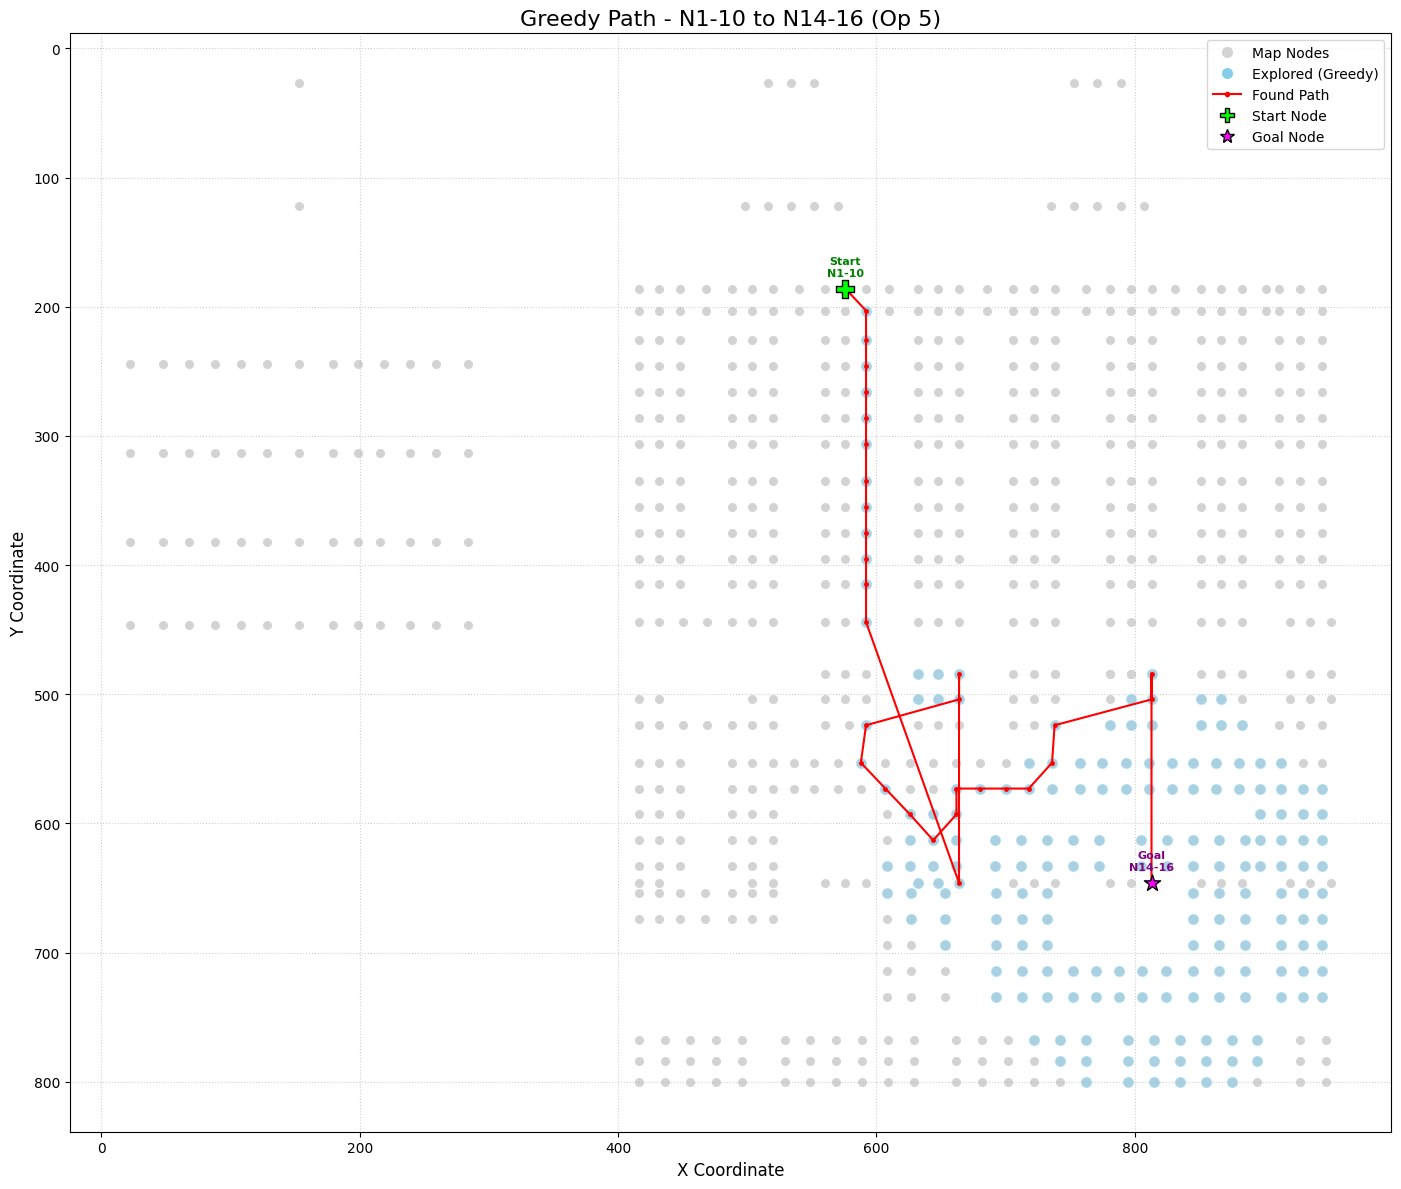


--- Operation 6/10 ---
Selected Start: N17-25, Selected Goal: N5-19

Running Greedy Best-First Search...
✅ Greedy Path: N17-25 -> N17-24 -> N18-28 -> N19-29 -> N20-12 -> N21-21 -> N21-20 -> N21-19 -> N21-18 -> N21-17 -> N21-16 -> N21-15 -> N21-14 -> N21-13 -> N21-12 -> N21-11 -> N21-10 -> N20-10 -> N19-14 -> N18-15 -> N18-16 -> N17-15 -> N18-18 -> N18-19 -> N18-20 -> N17-18 -> N16-17 -> N15-17 -> N14-17 -> N13-18 -> N12-19 -> N11-19 -> N10-19 -> N9-19 -> N8-19 -> N7-19 -> N6-19 -> N5-19
   Path Length: 37 edges, Nodes in Closed Set: 135


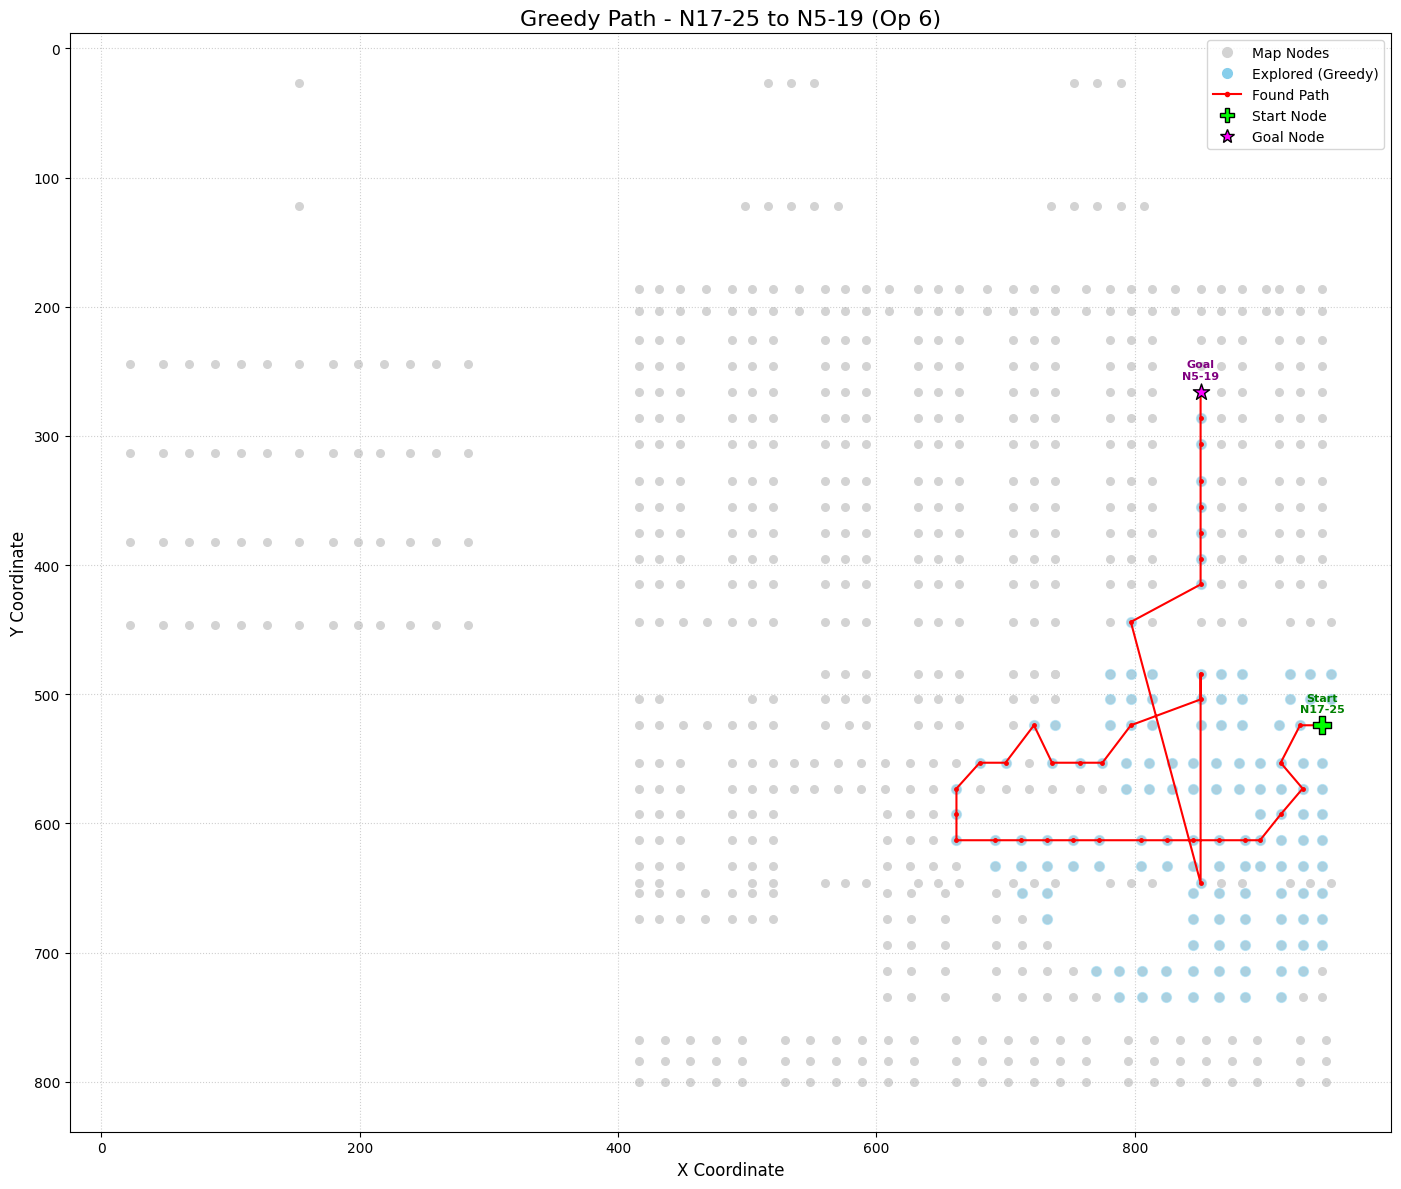


--- Operation 7/10 ---
Selected Start: N26-1, Selected Goal: N13-2

Running Greedy Best-First Search...
✅ Greedy Path: N26-1 -> N25-1 -> N24-8 -> N23-8 -> N22-7 -> N21-7 -> N20-7 -> N19-11 -> N18-10 -> N17-9 -> N16-8 -> N15-8 -> N14-8 -> N13-8 -> N12-8 -> N11-7 -> N10-7 -> N9-7 -> N8-7 -> N7-7 -> N6-7 -> N5-7 -> N4-7 -> N3-7 -> N4-6 -> N5-5 -> N6-4 -> N7-4 -> N8-4 -> N9-4 -> N10-4 -> N11-4 -> N12-4 -> N13-5 -> N13-4 -> N13-3 -> N13-2
   Path Length: 36 edges, Nodes in Closed Set: 179


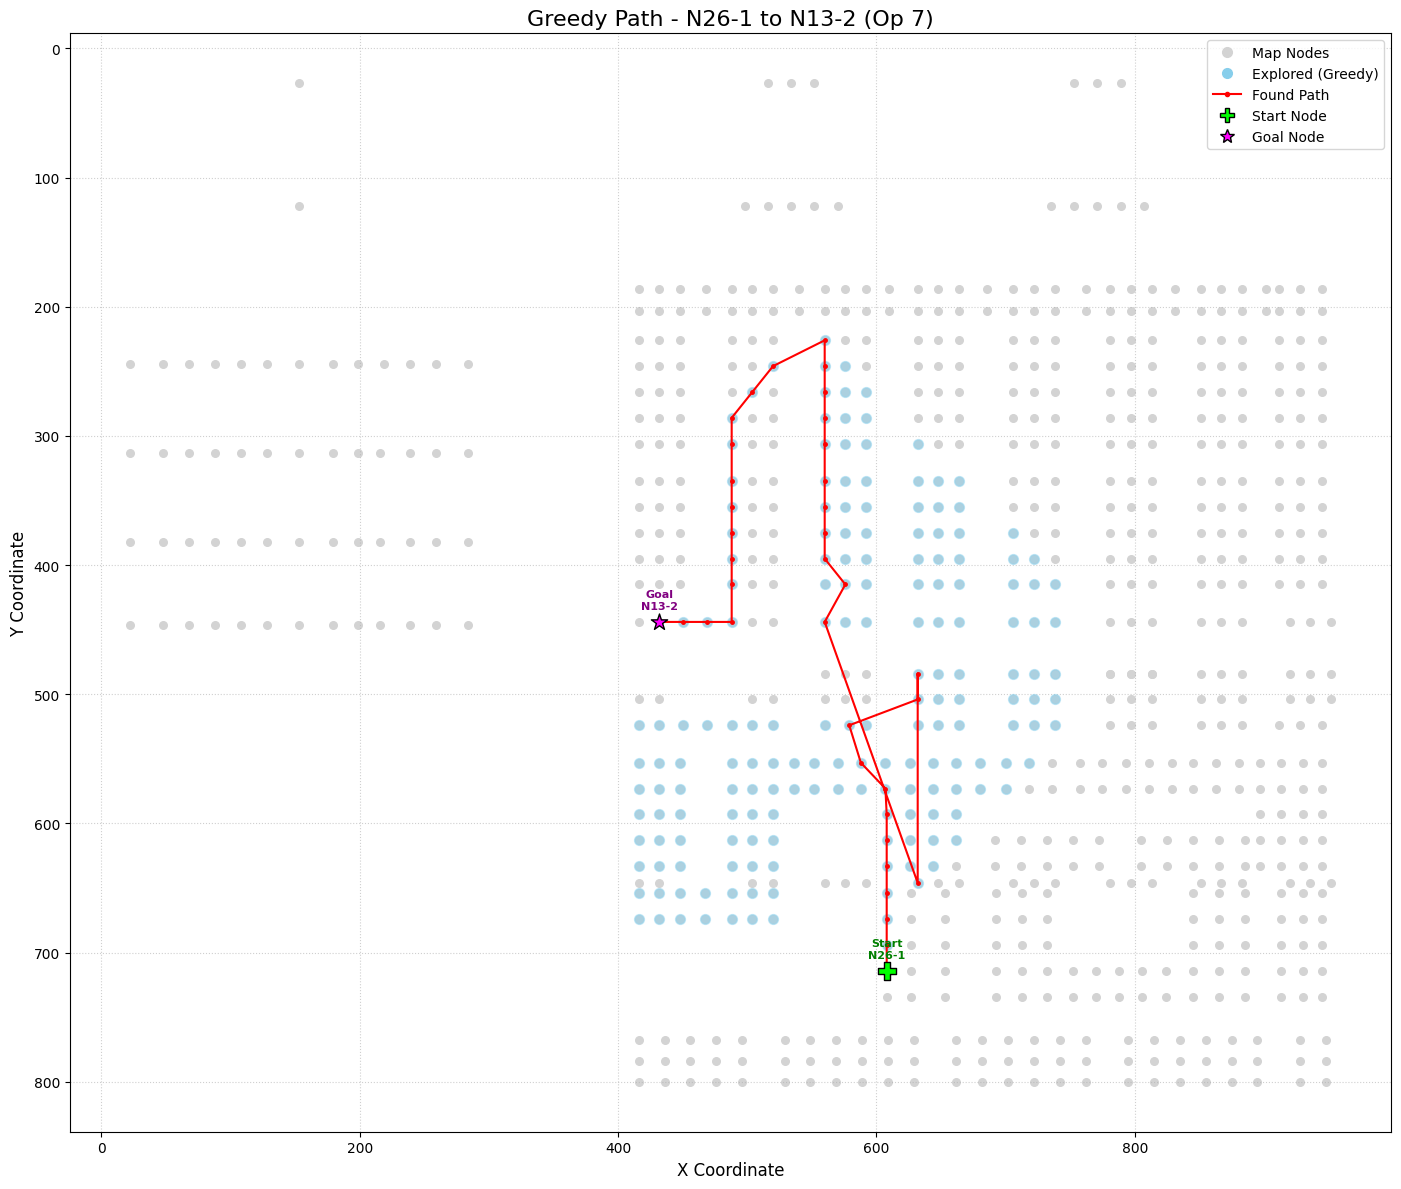


--- Operation 8/10 ---
Selected Start: N27-3, Selected Goal: N10-11

Running Greedy Best-First Search...
✅ Greedy Path: N27-3 -> N26-3 -> N25-3 -> N24-10 -> N23-10 -> N22-9 -> N21-9 -> N20-9 -> N19-13 -> N18-12 -> N18-11 -> N18-10 -> N17-10 -> N16-9 -> N15-9 -> N14-9 -> N13-10 -> N12-10 -> N11-11 -> N10-11
   Path Length: 19 edges, Nodes in Closed Set: 59


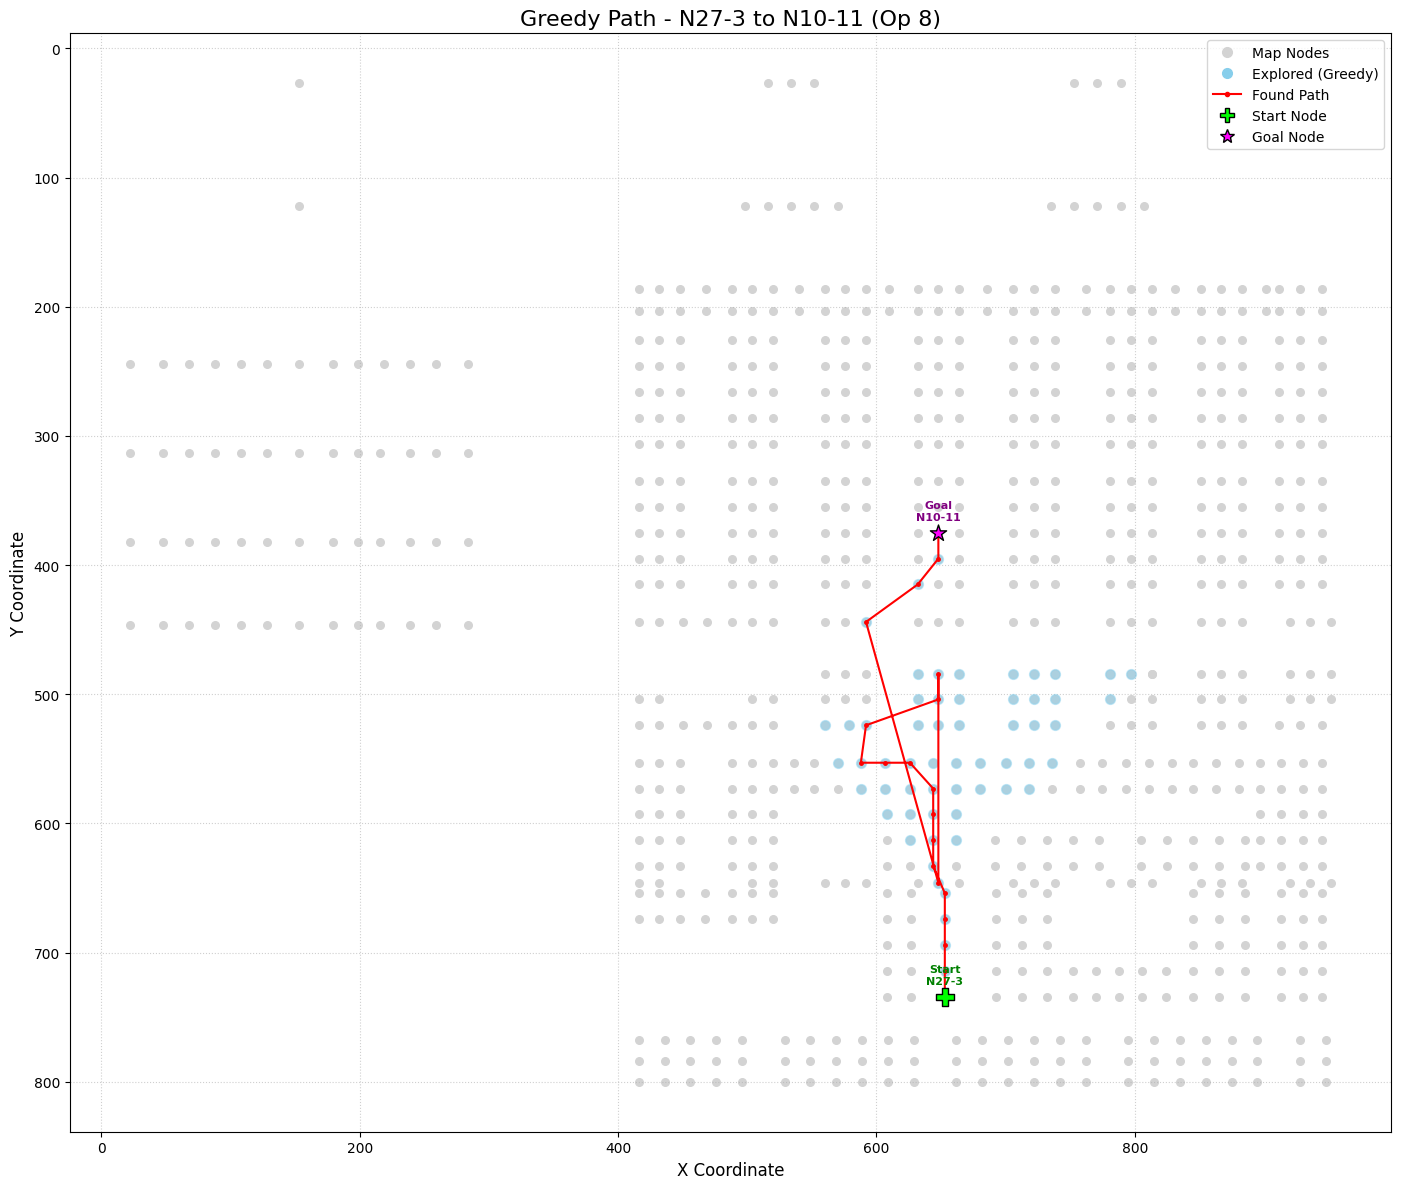


--- Operation 9/10 ---
Selected Start: N1-29, Selected Goal: N2-26

Running Greedy Best-First Search...
✅ Greedy Path: N1-29 -> N2-28 -> N2-27 -> N2-26
   Path Length: 3 edges, Nodes in Closed Set: 3


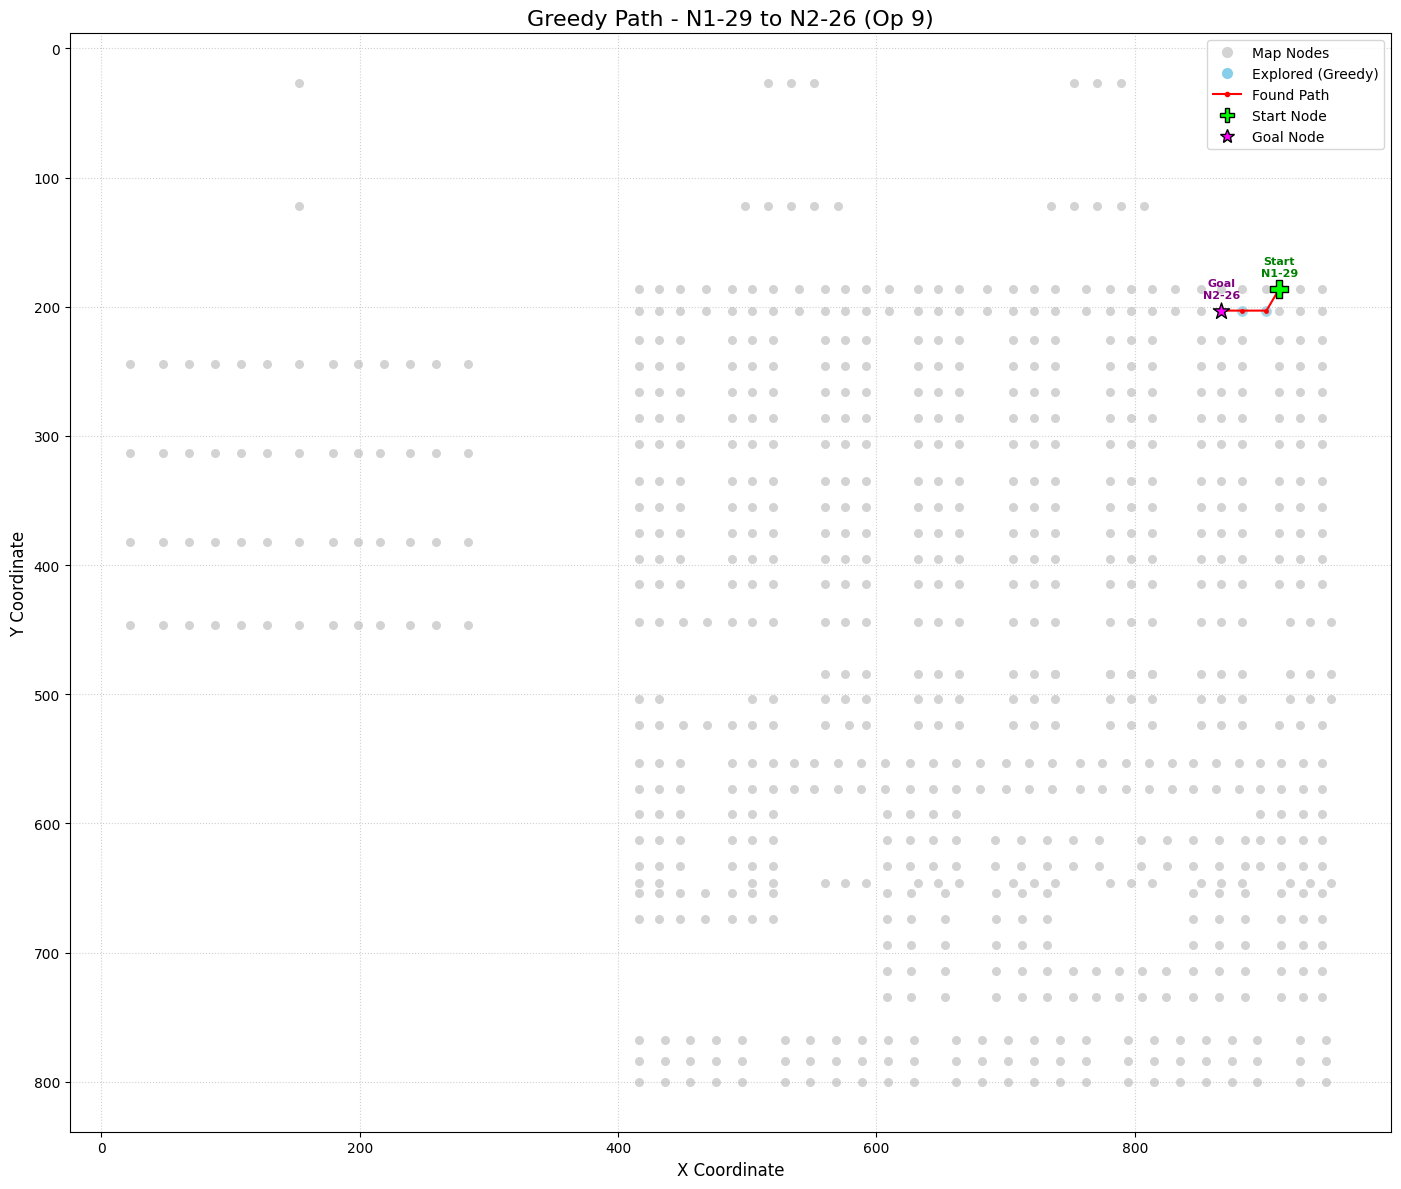


--- Operation 10/10 ---
Selected Start: N3-3, Selected Goal: N13-20

Running Greedy Best-First Search...
✅ Greedy Path: N3-3 -> N4-3 -> N5-3 -> N6-3 -> N7-3 -> N8-3 -> N9-3 -> N10-3 -> N11-3 -> N12-3 -> N13-3 -> N13-4 -> N13-5 -> N13-6 -> N14-4 -> N15-4 -> N15-5 -> N15-6 -> N16-7 -> N17-7 -> N17-8 -> N16-9 -> N17-10 -> N18-10 -> N18-11 -> N18-12 -> N17-12 -> N18-14 -> N18-15 -> N18-16 -> N17-15 -> N18-18 -> N18-19 -> N18-20 -> N17-18 -> N16-17 -> N15-17 -> N14-17 -> N13-18 -> N12-19 -> N13-20
   Path Length: 40 edges, Nodes in Closed Set: 140


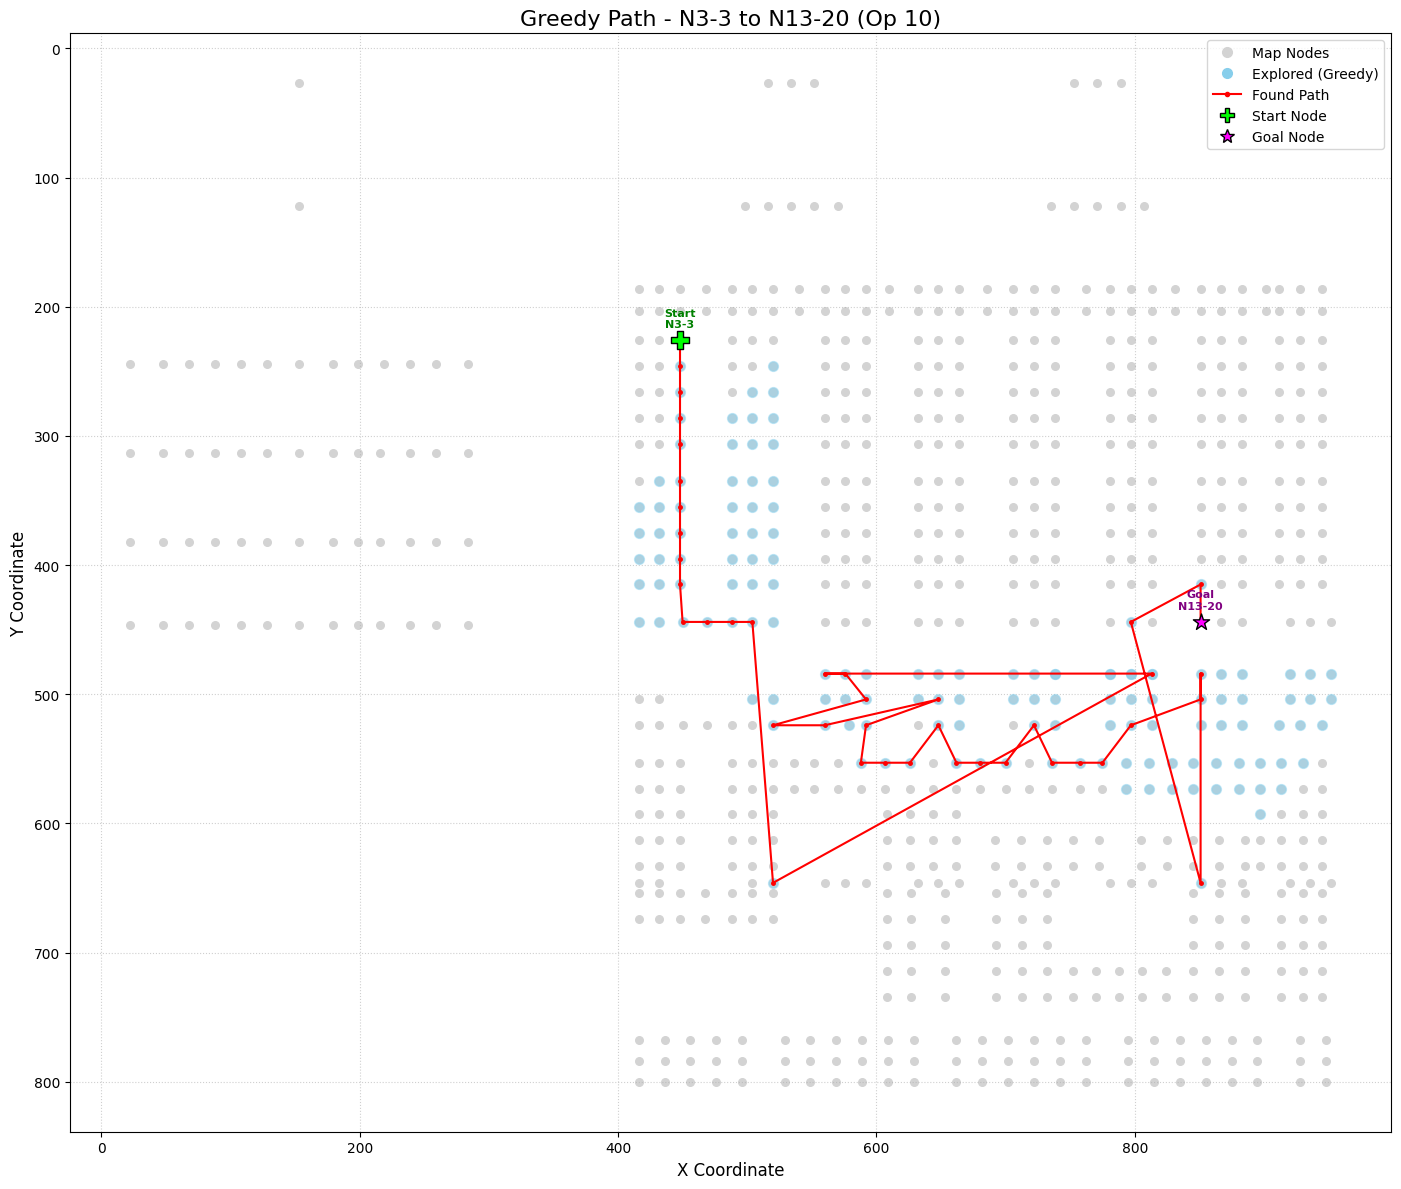

In [ ]:
# import json
# import heapq
# import os
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines # For custom legend handles
# import random

# # --- Helper Functions ---
# def load_json_file(file_path):
#     try:
#         with open(file_path, 'r') as f:
#             return json.load(f)
#     except FileNotFoundError:
#         print(f"Error: File not found at {file_path}")
#         return None
#     except json.JSONDecodeError as e:
#         print(f"Error decoding JSON from {file_path}: {e}")
#         return None
#     except Exception as e:
#         print(f"An unexpected error occurred while loading {file_path}: {e}")
#         return None

# warehouse_map_data = load_json_file('map.json')
# # lookup_table_data = load_json_file('lookup_table.json') # Not used directly now

# def get_node_coordinates(node_id, graph_nodes_data):
#     node = graph_nodes_data.get(node_id)
#     if node:
#         x = node.get('x')
#         y = node.get('y')
#         if isinstance(x, (int, float)) and isinstance(y, (int, float)):
#             return (x, y)
#     return (None, None)

# def heuristic_manhattan(node1_id, node2_id, all_nodes_data):
#     x1, y1 = get_node_coordinates(node1_id, all_nodes_data)
#     x2, y2 = get_node_coordinates(node2_id, all_nodes_data)
#     if x1 is not None and y1 is not None and x2 is not None and y2 is not None:
#         return abs(x1 - x2) + abs(y1 - y2)
#     return float('inf')

# def reconstruct_path(came_from_map, current_node_id):
#     total_path = [current_node_id]
#     while current_node_id in came_from_map and came_from_map[current_node_id] is not None:
#         current_node_id = came_from_map[current_node_id]
#         total_path.append(current_node_id)
#     return total_path[::-1]

# def greedy_best_first_search(start_node_id, goal_node_id, all_nodes_data, heuristic_func):
#     if start_node_id not in all_nodes_data or goal_node_id not in all_nodes_data:
#         # print(f"Warning: Start ({start_node_id}) or Goal ({goal_node_id}) node not in map data for Greedy.")
#         return None, set()

#     open_set_pq = []
#     initial_heuristic = heuristic_func(start_node_id, goal_node_id, all_nodes_data)
#     heapq.heappush(open_set_pq, (initial_heuristic, start_node_id))
    
#     came_from = {start_node_id: None}
#     closed_set = set() # Nodes that have been fully processed

#     while open_set_pq:
#         _, current_node_id = heapq.heappop(open_set_pq)

#         if current_node_id == goal_node_id:
#             return reconstruct_path(came_from, current_node_id), closed_set

#         if current_node_id in closed_set:
#             continue 
#         closed_set.add(current_node_id)
        
#         current_node_details = all_nodes_data.get(current_node_id)
#         if not current_node_details or 'neighbours' not in current_node_details:
#             continue 

#         # Process neighbors. For Greedy, we add them to the priority queue based on their heuristic.
#         for neighbor_id in current_node_details.get("neighbours", []):
#             neighbor_details = all_nodes_data.get(neighbor_id)
#             # Check if neighbor is valid, not locked, and not already processed
#             if neighbor_details and not neighbor_details.get("locked", False) and neighbor_id not in closed_set:
#                 # If we only want to find *a* path and not necessarily the one found by first visit:
#                 if neighbor_id not in came_from: # Ensure we only set parent once
#                     came_from[neighbor_id] = current_node_id
                
#                 # Always push to consider, letting PQ handle if it's a "better" greedy choice
#                 # (though for pure greedy, we typically don't re-add to open if already visited with a path)
#                 # To strictly avoid re-adding to open_set if already considered (even if not closed):
#                 # found_in_open = any(item[1] == neighbor_id for item in open_set_pq)
#                 # if not found_in_open:
#                 h_val = heuristic_func(neighbor_id, goal_node_id, all_nodes_data)
#                 heapq.heappush(open_set_pq, (h_val, neighbor_id))
                    
#     return None, closed_set


# def plot_path_on_map(all_nodes_data, start_node_id_plot, goal_node_id_plot, path_node_ids, title="Warehouse Path", explored_nodes_set=None):
#     if not all_nodes_data:
#         print("Cannot plot: No node data.")
#         return

#     fig, ax = plt.subplots(figsize=(18, 12))

#     all_x = []
#     all_y = []
#     # Plot all nodes first
#     for node_id, node_info in all_nodes_data.items():
#         x, y = get_node_coordinates(node_id, all_nodes_data)
#         if x is not None and y is not None:
#             all_x.append(x)
#             all_y.append(y)
#             ax.scatter(x, y, c='lightgray', s=30, zorder=1)
#             # ax.text(x + 0.5, y + 0.5, node_id, fontsize=6, ha='center', va='bottom', alpha=0.7)

#     # Plot explored nodes
#     if explored_nodes_set:
#         explored_x = [all_nodes_data[n]['x'] for n in explored_nodes_set if n in all_nodes_data and get_node_coordinates(n, all_nodes_data)[0] is not None]
#         explored_y = [all_nodes_data[n]['y'] for n in explored_nodes_set if n in all_nodes_data and get_node_coordinates(n, all_nodes_data)[1] is not None]
#         if explored_x:
#             ax.scatter(explored_x, explored_y, c='skyblue', s=50, label="Explored Nodes", alpha=0.5, zorder=2)

#     # Always plot Start and Goal nodes if they exist
#     start_x, start_y = get_node_coordinates(start_node_id_plot, all_nodes_data)
#     goal_x, goal_y = get_node_coordinates(goal_node_id_plot, all_nodes_data)

#     if start_x is not None:
#         ax.scatter(start_x, start_y, c='lime', s=150, label="Start", zorder=5, marker='P', edgecolors='black')
#         ax.text(start_x, start_y - 10, f"Start\n{start_node_id_plot}", fontsize=8, ha='center', color='green', weight='bold', zorder=6)
#     if goal_x is not None:
#         ax.scatter(goal_x, goal_y, c='magenta', s=150, label="Goal", zorder=5, marker='*', edgecolors='black')
#         ax.text(goal_x, goal_y - 10, f"Goal\n{goal_node_id_plot}", fontsize=8, ha='center', color='purple', weight='bold', zorder=6)


#     # Plot the path if found
#     if path_node_ids and len(path_node_ids) > 0 :
#         path_x, path_y = [], []
#         valid_path_nodes = True
#         for node_id in path_node_ids:
#             x, y = get_node_coordinates(node_id, all_nodes_data)
#             if x is None or y is None: valid_path_nodes = False; break
#             path_x.append(x); path_y.append(y)

#         if valid_path_nodes and path_x:
#             ax.plot(path_x, path_y, marker='.', markersize=5, linestyle='-', color='red', linewidth=1.5, label="Found Path", zorder=4)
#             # Annotate path nodes (can be very cluttered, use sparingly)
#             # for i, node_id in enumerate(path_node_ids):
#             #     if i % (len(path_node_ids)//5 +1) == 0 : # Annotate some nodes on path
#             #       ax.text(path_x[i], path_y[i] - 5, node_id, fontsize=6, ha='center', color='blue', zorder=6)
#     else:
#         print(f"No path to plot for '{title}'. Start/Goal will still be shown if valid.")


#     ax.set_title(title, fontsize=16)
#     ax.set_xlabel("X Coordinate", fontsize=12)
#     ax.set_ylabel("Y Coordinate", fontsize=12)
    
#     legend_elements = [
#         mlines.Line2D([], [], color='lightgray', marker='o', linestyle='None', markersize=7, label='Map Nodes'),
#         mlines.Line2D([], [], color='skyblue', marker='o', linestyle='None', markersize=7, label='Explored (Greedy)'),
#         mlines.Line2D([], [], color='red', marker='.', linestyle='-', markersize=6, linewidth=1.5, label='Found Path'),
#         mlines.Line2D([], [], color='lime', marker='P', linestyle='None', markersize=10, markeredgecolor='black', label='Start Node'),
#         mlines.Line2D([], [], color='magenta', marker='*', linestyle='None', markersize=10, markeredgecolor='black', label='Goal Node')
#     ]
#     ax.legend(handles=legend_elements, loc='best')

#     ax.grid(True, linestyle=':', alpha=0.6)
#     ax.invert_yaxis() 
#     ax.set_aspect('equal', adjustable='box')
#     plt.tight_layout()
#     plt.show()

# # --- Main Execution ---
# def run_pathfinding_simulation(num_operations=10):
#     if not warehouse_map_data:
#         print("Warehouse map data could not be loaded. Exiting simulation.")
#         return

#     all_nodes = warehouse_map_data.get("nodes", {})
#     if not all_nodes:
#         print("No nodes found in warehouse map data. Exiting simulation.")
#         return

#     node_ids_list = list(all_nodes.keys())
#     if len(node_ids_list) < 2:
#         print("Not enough nodes in the map to perform pathfinding operations.")
#         return

#     for i in range(num_operations):
#         print(f"\n--- Operation {i+1}/{num_operations} ---")
        
#         # Select random start and goal nodes that are not locked
#         valid_start_nodes = [nid for nid, ndata in all_nodes.items() if not ndata.get("locked", False)]
#         valid_goal_nodes = valid_start_nodes # Assuming goal can be any non-locked node for this simulation

#         if not valid_start_nodes or len(valid_start_nodes) < 2 :
#              print("Not enough valid (unlocked) nodes to select start/goal. Check map data or locked states.")
#              break # Exit simulation if no valid nodes

#         agent_start_node_id = random.choice(valid_start_nodes)
#         goal_node_id = random.choice(valid_goal_nodes)
#         # Ensure start and goal are different
#         while goal_node_id == agent_start_node_id:
#             goal_node_id = random.choice(valid_goal_nodes)

#         # Check for basic validity (existence)
#         if agent_start_node_id not in all_nodes:
#             print(f"Sim Error: Randomly selected start node '{agent_start_node_id}' not in map.")
#             continue
#         if goal_node_id not in all_nodes:
#             print(f"Sim Error: Randomly selected goal node '{goal_node_id}' not in map.")
#             continue
            
#         # Crucial check for start node neighbors
#         if not all_nodes[agent_start_node_id].get("neighbours") or not all_nodes[agent_start_node_id]["neighbours"]:
#             print(f"Warning: Start node '{agent_start_node_id}' has no defined neighbours. Pathfinding from it is impossible.")
#             plot_path_on_map(all_nodes, agent_start_node_id, goal_node_id, None, 
#                              f"Greedy - No Path (Start Unconnected): {agent_start_node_id} to {goal_node_id}", set())
#             continue

#         print(f"Selected Start: {agent_start_node_id}, Selected Goal: {goal_node_id}")

#         print("\nRunning Greedy Best-First Search...")
#         greedy_path, greedy_explored_set = greedy_best_first_search(agent_start_node_id, goal_node_id, all_nodes, heuristic_manhattan)
        
#         title_suffix = f"{agent_start_node_id} to {goal_node_id} (Op {i+1})"
#         if greedy_path:
#             print(f"✅ Greedy Path: {' -> '.join(greedy_path)}")
#             print(f"   Path Length: {len(greedy_path)-1} edges, Nodes in Closed Set: {len(greedy_explored_set)}")
#             plot_path_on_map(all_nodes, agent_start_node_id, goal_node_id, greedy_path, 
#                              f"Greedy Path - {title_suffix}", greedy_explored_set)
#         else:
#             print(f"❌ Greedy: No path found.")
#             plot_path_on_map(all_nodes, agent_start_node_id, goal_node_id, None, 
#                              f"Greedy - No Path - {title_suffix}", greedy_explored_set)
        
#         # A* Search can be added here later in a similar fashion

# if __name__ == "__main__":
#     run_pathfinding_simulation(num_operations=10)

## A*

DEBUG: Node N1-5 has been manually locked.
DEBUG: Node N7-8 has been manually locked.

--- A* Operation 1/10 ---
Selected Start: N11-2, Selected Goal: N18-19
✅ A* Path: N11-2 -> N12-3 -> N13-5 -> N14-5 -> N15-6 -> N16-6 -> N17-7 -> N18-8 -> N18-9 -> N18-10 -> N18-11 -> N18-12 -> N18-13 -> N18-14 -> N18-15 -> N18-16 -> N18-17 -> N18-18 -> N18-19
   Path Length: 18 edges, Nodes in Closed Set: 226


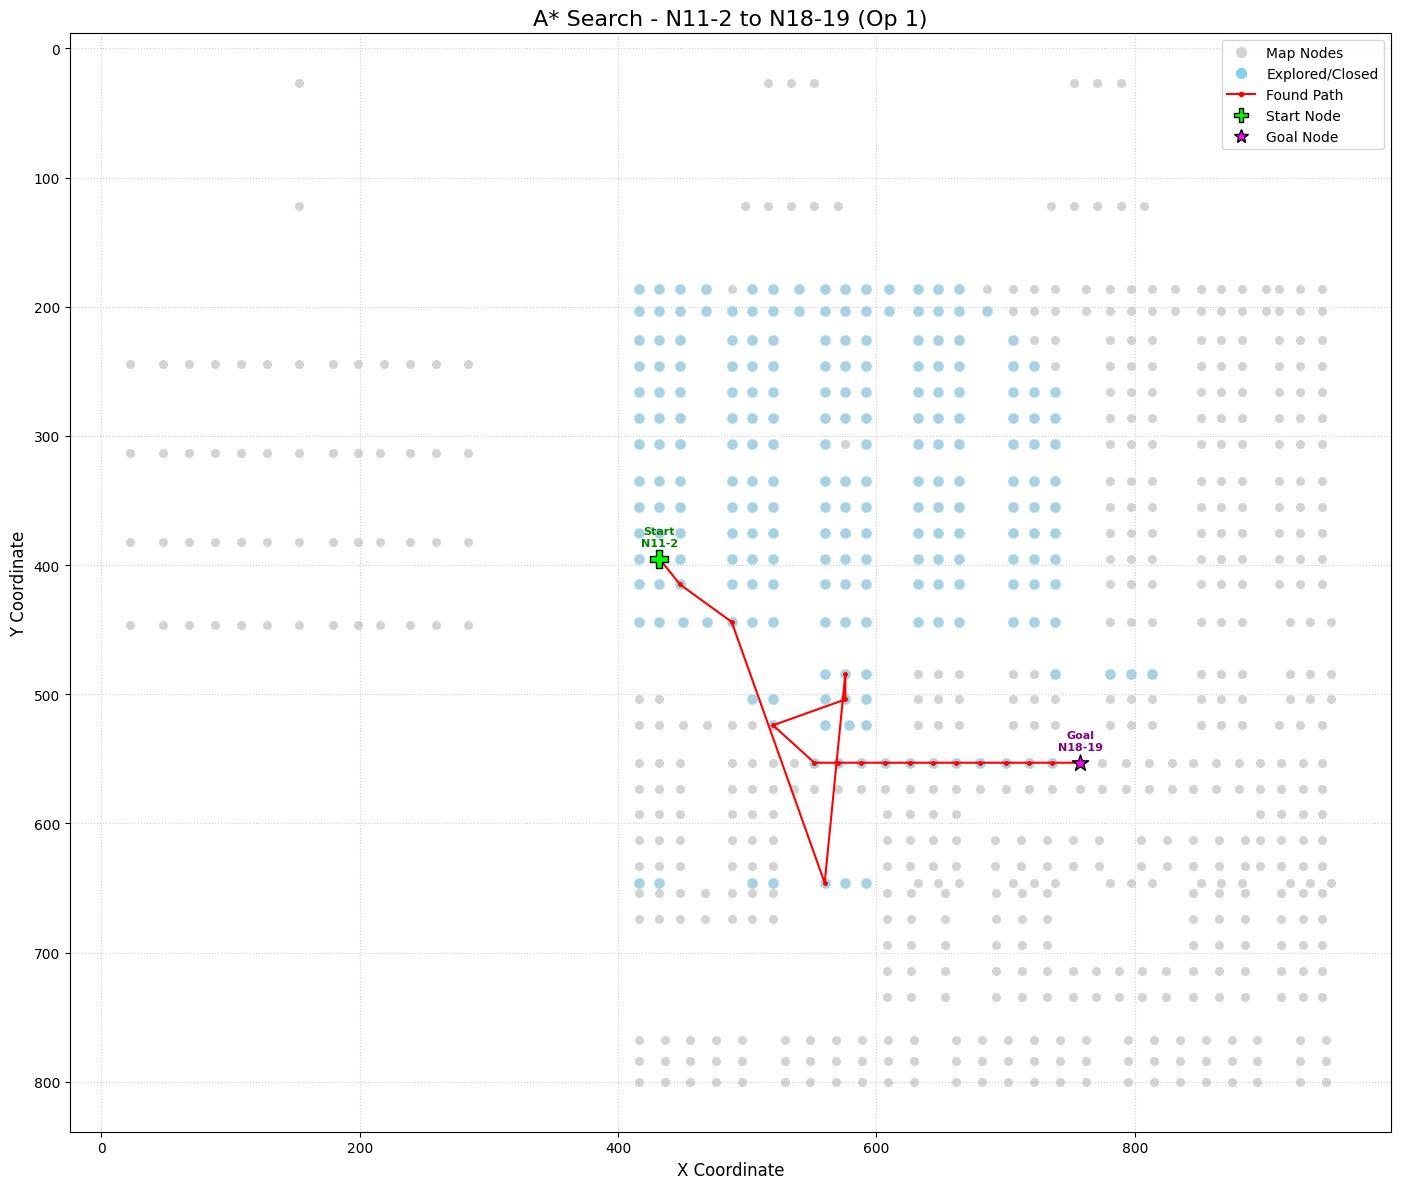


--- A* Operation 2/10 ---
Selected Start: N1-19, Selected Goal: N10-21
✅ A* Path: N1-19 -> N2-20 -> N2-21 -> N2-22 -> N2-23 -> N2-24 -> N2-25 -> N3-20 -> N4-20 -> N5-20 -> N6-20 -> N7-20 -> N8-21 -> N9-21 -> N10-21
   Path Length: 14 edges, Nodes in Closed Set: 63


KeyboardInterrupt: 

In [10]:
# import json
# import heapq
# import os 
# import matplotlib.pyplot as plt
# import matplotlib.lines as mlines
# import math
# import random
# import copy # For deepcopying in simulation if needed

# # --- Node Class Definition ---
# class PathNode:
#     def __init__(self, node_id: str, x: float, y: float, node_type: str = "NORMAL", locked: bool = False):
#         self.id = node_id
#         self.x = x
#         self.y = y
#         self.node_type = node_type
#         self.locked = locked
#         self.neighbours_with_costs: dict[PathNode, float] = {}

#     def add_neighbor(self, neighbor_node: 'PathNode', cost: float):
#         self.neighbours_with_costs[neighbor_node] = cost

#     def __lt__(self, other): # For heapq comparison if nodes are directly stored based on some intrinsic priority
#         # A* typically stores (priority, item) in heapq, so node's __lt__ might not be directly used by A*'s heap
#         # but good to have for general heap usage or sets if needed.
#         return self.id < other.id # Fallback comparison by ID if f_scores are equal

#     def __eq__(self, other):
#         if not isinstance(other, PathNode): return NotImplemented
#         return self.id == other.id

#     def __hash__(self):
#         return hash(self.id)
    
#     def __str__(self):
#         return f"{self.id}({self.x:.0f},{self.y:.0f})"
    
#     def __repr__(self):
#         return f"PathNode(id='{self.id}', x={self.x}, y={self.y}, locked={self.locked}, neighbours={len(self.neighbours_with_costs)})"

# # --- Helper Functions ---
# def load_json_file(file_path):
#     try:
#         with open(file_path, 'r') as f:
#             return json.load(f)
#     except FileNotFoundError:
#         print(f"Error: File not found at {file_path}")
#     except json.JSONDecodeError as e:
#         print(f"Error decoding JSON from {file_path}: {e}")
#     except Exception as e:
#         print(f"An unexpected error occurred while loading {file_path}: {e}")
#     return None

# def create_path_nodes_from_map_data(map_data: dict | None) -> dict[str, PathNode]:
#     if not map_data or "nodes" not in map_data:
#         print("Error: Invalid or empty map_data provided to create_path_nodes.")
#         return {}
    
#     path_nodes_dict: dict[str, PathNode] = {}
#     raw_nodes_data = map_data["nodes"]

#     # First pass: Create all PathNode objects
#     for node_id, node_info in raw_nodes_data.items():
#         x = node_info.get('x')
#         y = node_info.get('y')
#         node_type_str = node_info.get('type', "NORMAL").upper()
#         locked = node_info.get('locked', False)
#         if isinstance(x, (int, float)) and isinstance(y, (int, float)):
#             path_nodes_dict[node_id] = PathNode(node_id, float(x), float(y), node_type_str, locked)
#         else:
#             print(f"Warning: Node {node_id} has invalid/missing coordinates (x:{x}, y:{y}). Skipping.")

#     # Second pass: Populate neighbors_with_costs, ensuring bidirectionality
#     for node_id, node_obj in path_nodes_dict.items():
#         raw_node_info = raw_nodes_data.get(node_id) # Get original data again for neighbors list
#         if raw_node_info and isinstance(raw_node_info.get("neighbours"), list):
#             # DEBUG_NODE_NEIGHBORS = False # Set to True to debug specific node's neighbor processing
#             # if DEBUG_NODE_NEIGHBORS and (node_id == "N13-7" or node_id == "N12-6" or node_id == "N14-7"):
#             # print(f"Processing neighbors for {node_id}: {raw_node_info['neighbours']}")
            
#             for neighbor_id_str in raw_node_info["neighbours"]:
#                 neighbor_obj = path_nodes_dict.get(neighbor_id_str)
#                 if neighbor_obj: # If neighbor_id_str maps to a valid PathNode
#                     cost = ((node_obj.x - neighbor_obj.x)**2 + (node_obj.y - neighbor_obj.y)**2)**0.5
                    
#                     # Add A -> B
#                     if neighbor_obj not in node_obj.neighbours_with_costs or node_obj.neighbours_with_costs[neighbor_obj] != cost :
#                          node_obj.add_neighbor(neighbor_obj, cost)
#                          # if DEBUG_NODE_NEIGHBORS and (node_id == "N13-7"): print(f"  Added link: {node_id} -> {neighbor_id_str} (cost {cost:.2f})")
                    
#                     # Ensure B -> A (bidirectional)
#                     if node_obj not in neighbor_obj.neighbours_with_costs or neighbor_obj.neighbours_with_costs[node_obj] != cost:
#                         neighbor_obj.add_neighbor(node_obj, cost)
#                         # if DEBUG_NODE_NEIGHBORS and (neighbor_id_str == "N13-7"): print(f"  Added reverse link: {neighbor_id_str} -> {node_id} (cost {cost:.2f})")
#                 # elif DEBUG_NODE_NEIGHBORS and (node_id == "N13-7"):
#                     # print(f"  Warning: Neighbor ID '{neighbor_id_str}' listed for {node_id} not found in path_nodes_dict or has no coords.")
#         # elif DEBUG_NODE_NEIGHBORS and (node_id == "N13-7"):
#             # print(f"Node {node_id} has no raw neighbor info or 'neighbours' is not a list.")
            
#     return path_nodes_dict

# def heuristic_euclidean(node1: PathNode | None, node2: PathNode | None) -> float:
#     if node1 is None or node2 is None: return float('inf')
#     return ((node1.x - node2.x)**2 + (node1.y - node2.y)**2)**0.5

# def reconstruct_path_from_came_from(came_from_map: dict[PathNode, PathNode | None], current_node: PathNode) -> list[PathNode]:
#     total_path = [current_node]
#     temp_current = current_node
#     while temp_current in came_from_map and came_from_map[temp_current] is not None:
#         temp_current = came_from_map[temp_current]
#         total_path.append(temp_current)
#     return total_path[::-1]

# # --- A* Search Algorithm ---
# class AStarSearch:
#     def __init__(self, start_node_obj: PathNode, goal_node_obj: PathNode):
#         self.start_node = start_node_obj
#         self.goal_node = goal_node_obj
#         self.open_set_pq: list[tuple[float, PathNode]] = []
#         self.g_scores: dict[PathNode, float] = {}
#         self.came_from: dict[PathNode, PathNode | None] = {}
#         self.closed_set: set[PathNode] = set()
#         # DEBUG:
#         self.DEBUG_SEARCH = False # Set to True for verbose A* trace

#     def _heuristic(self, node_obj: PathNode) -> float:
#         return heuristic_euclidean(node_obj, self.goal_node)

#     def search(self) -> tuple[list[PathNode] | None, set[PathNode]]:
#         if not self.start_node or not self.goal_node:
#             if self.DEBUG_SEARCH: print("  A* PRE-CHECK: Start or Goal node is None.")
#             return None, self.closed_set
        
#         if self.start_node.locked: # Check if start node itself is locked
#             if self.DEBUG_SEARCH: print(f"  A* PRE-CHECK: Start node {self.start_node.id} is locked.")
#             return None, self.closed_set

#         self.g_scores = {node: float('inf') for node in all_path_nodes.values()} # Initialize all g-scores to infinity
#         self.g_scores[self.start_node] = 0.0
        
#         initial_f_score = self._heuristic(self.start_node)
#         heapq.heappush(self.open_set_pq, (initial_f_score, self.start_node))
        
#         open_set_tracker = {self.start_node} # Tracks nodes currently in the priority queue

#         if self.DEBUG_SEARCH: print(f"  A* INIT: Start {self.start_node.id}, Goal {self.goal_node.id}, Initial f_score: {initial_f_score:.2f}")

#         while self.open_set_pq:
#             current_f_score_in_heap, current_node = heapq.heappop(self.open_set_pq)
            
#             if current_node not in open_set_tracker: # Node was already processed via a shorter path found earlier
#                 continue
#             open_set_tracker.remove(current_node)


#             if self.DEBUG_SEARCH:
#                 print(f"    A* POP: {current_node.id} (heap_f={current_f_score_in_heap:.2f}, calc_g={self.g_scores.get(current_node, float('inf')):.2f}, h={self._heuristic(current_node):.2f})")

#             if current_node == self.goal_node:
#                 if self.DEBUG_SEARCH: print(f"    A* GOAL REACHED: {current_node.id}")
#                 return reconstruct_path_from_came_from(self.came_from, current_node), self.closed_set
            
#             self.closed_set.add(current_node)

#             if not current_node.neighbours_with_costs:
#                  if self.DEBUG_SEARCH: print(f"    A* Node {current_node.id} has no neighbors to expand.")
#                  continue

#             for neighbor_node, cost_to_neighbor in current_node.neighbours_with_costs.items():
#                 if self.DEBUG_SEARCH: print(f"      A* CONSIDERING NEIGHBOR: {neighbor_node.id} of {current_node.id} (cost: {cost_to_neighbor:.2f}, locked: {neighbor_node.locked})")
                
#                 if neighbor_node.locked:
#                     if self.DEBUG_SEARCH: print(f"        A* NEIGHBOR LOCKED: {neighbor_node.id}")
#                     continue
                
#                 if neighbor_node in self.closed_set:
#                     if self.DEBUG_SEARCH: print(f"        A* NEIGHBOR IN CLOSED: {neighbor_node.id}")
#                     continue

#                 tentative_g_score = self.g_scores.get(current_node, float('inf')) + cost_to_neighbor

#                 if tentative_g_score < self.g_scores.get(neighbor_node, float('inf')):
#                     if self.DEBUG_SEARCH: print(f"        A* BETTER PATH to {neighbor_node.id} (new_g: {tentative_g_score:.2f})")
#                     self.came_from[neighbor_node] = current_node
#                     self.g_scores[neighbor_node] = tentative_g_score
#                     f_score_neighbor = tentative_g_score + self._heuristic(neighbor_node)
                    
#                     # If neighbor not in open_set_tracker, add it.
#                     # If it is, but we found a better path (lower f_score), standard heapq means we add the new, better one.
#                     # The old one will eventually be popped but likely skipped if node is already closed or f_score check.
#                     heapq.heappush(self.open_set_pq, (f_score_neighbor, neighbor_node))
#                     open_set_tracker.add(neighbor_node)
#                     if self.DEBUG_SEARCH: print(f"          A* PUSHED TO OPEN: {neighbor_node.id} (f={f_score_neighbor:.2f})")
#                 # elif self.DEBUG_SEARCH:
#                     # print(f"        A* NO BETTER PATH to {neighbor_node.id} (current_g: {self.g_scores.get(neighbor_node, float('inf')):.2f} vs tentative_g: {tentative_g_score:.2f})")
        
#         if self.DEBUG_SEARCH: print(f"  A* Open list empty, no path found from {self.start_node.id} to {self.goal_node.id}.")
#         return None, self.closed_set

# def a_star_algorithm_wrapper(start_node_obj: PathNode, goal_node_obj: PathNode) -> tuple[list[PathNode] | None, set[PathNode]]:
#     search_instance = AStarSearch(start_node_obj, goal_node_obj)
#     # search_instance.DEBUG_SEARCH = True # Enable for specific calls if needed
#     return search_instance.search()

# # --- Plotting Function (same as before, ensures it uses PathNode objects) ---
# def plot_path_on_map_generic(
#     all_path_nodes_dict: dict[str, PathNode], 
#     start_node_obj: PathNode | None, 
#     goal_node_obj: PathNode | None, 
#     found_path_nodes: list[PathNode] | None, 
#     search_title:str ="Pathfinding Result", 
#     explored_nodes_set: set[PathNode] | None = None
#     ):

#     if not all_path_nodes_dict: print("Cannot plot: No node data."); return
    
#     fig, ax = plt.subplots(figsize=(18, 12))

#     for node_id, node_obj_plot in all_path_nodes_dict.items():
#         ax.scatter(node_obj_plot.x, node_obj_plot.y, c='lightgray', s=30, zorder=1)

#     if explored_nodes_set:
#         explored_x = [n.x for n in explored_nodes_set]
#         explored_y = [n.y for n in explored_nodes_set]
#         if explored_x:
#              ax.scatter(explored_x, explored_y, c='skyblue', s=50, label="Explored/Closed Set", alpha=0.5, zorder=2)

#     if start_node_obj:
#         ax.scatter(start_node_obj.x, start_node_obj.y, c='lime', s=150, label="Start", zorder=5, marker='P', edgecolors='black')
#         ax.text(start_node_obj.x, start_node_obj.y - 10, f"Start\n{start_node_obj.id}", fontsize=8, ha='center', color='green', weight='bold', zorder=6)
    
#     if goal_node_obj:
#         ax.scatter(goal_node_obj.x, goal_node_obj.y, c='magenta', s=150, label="Goal", zorder=5, marker='*', edgecolors='black')
#         ax.text(goal_node_obj.x, goal_node_obj.y - 10, f"Goal\n{goal_node_obj.id}", fontsize=8, ha='center', color='purple', weight='bold', zorder=6)

#     if found_path_nodes and len(found_path_nodes) > 0:
#         path_x = [node.x for node in found_path_nodes]
#         path_y = [node.y for node in found_path_nodes]
#         ax.plot(path_x, path_y, marker='.', markersize=5, linestyle='-', color='red', linewidth=1.5, label="Found Path", zorder=4)
#     # else: print(f"No path to plot for '{search_title}'.") # Already handled by caller

#     ax.set_title(search_title, fontsize=16); ax.set_xlabel("X Coordinate", fontsize=12); ax.set_ylabel("Y Coordinate", fontsize=12)
#     legend_elements = [
#         mlines.Line2D([], [], color='lightgray', marker='o', ls='None', ms=7, label='Map Nodes'),
#         mlines.Line2D([], [], color='skyblue', marker='o', ls='None', ms=7, label='Explored/Closed'),
#         mlines.Line2D([], [], color='red', marker='.', ls='-', ms=6, lw=1.5, label='Found Path'),
#         mlines.Line2D([], [], color='lime', marker='P', ls='None', ms=10, mec='black', label='Start Node'),
#         mlines.Line2D([], [], color='magenta', marker='*', ls='None', ms=10, mec='black', label='Goal Node')
#     ]
#     ax.legend(handles=legend_elements, loc='best')
#     ax.grid(True, linestyle=':', alpha=0.6); ax.invert_yaxis(); ax.set_aspect('equal', adjustable='box')
#     plt.tight_layout(); plt.show()

# # --- Main Execution ---
# warehouse_map_data = load_json_file('map.json') # Load once globally
# all_path_nodes = create_path_nodes_from_map_data(warehouse_map_data) # Create node objects once

# def run_astar_simulation(num_operations=10):
#     global all_path_nodes # Use the globally created node objects

#     if not all_path_nodes:
#         print("Node objects not created. Cannot run simulation.")
#         return

#     node_ids_list = list(all_path_nodes.keys())
#     if len(node_ids_list) < 2:
#         print("Not enough nodes to perform pathfinding."); return

#     for i in range(num_operations):
#         print(f"\n--- A* Operation {i+1}/{num_operations} ---")
        
#         valid_node_ids = [nid for nid, node_obj in all_path_nodes.items() if not node_obj.locked]
#         if len(valid_node_ids) < 2: print("Not enough unlocked nodes."); break

#         start_node_id_sim = random.choice(valid_node_ids)
#         goal_node_id_sim = random.choice(valid_node_ids)
#         while goal_node_id_sim == start_node_id_sim:
#             goal_node_id_sim = random.choice(valid_node_ids)

#         start_node_obj_sim = all_path_nodes.get(start_node_id_sim)
#         goal_node_obj_sim = all_path_nodes.get(goal_node_id_sim)

#         if not start_node_obj_sim or not goal_node_obj_sim: continue # Should not happen if IDs from list
            
#         if not start_node_obj_sim.neighbours_with_costs:
#              print(f"Warning: Start node '{start_node_obj_sim.id}' (Op {i+1}) has no processed neighbours. Pathfinding impossible from here.")
#              plot_path_on_map_generic(all_path_nodes, start_node_obj_sim, goal_node_obj_sim, None, 
#                               f"A* - No Path (Start Unconnected): {start_node_obj_sim.id} to {goal_node_obj_sim.id}", set())
#              continue

#         print(f"Selected Start: {start_node_obj_sim.id}, Selected Goal: {goal_node_obj_sim.id}")

#         astar_path_nodes_list, astar_closed_set_nodes = a_star_algorithm_wrapper(start_node_obj_sim, goal_node_obj_sim)
        
#         title_suffix_astar = f"{start_node_obj_sim.id} to {goal_node_obj_sim.id} (Op {i+1})"
#         if astar_path_nodes_list:
#             path_ids = [node.id for node in astar_path_nodes_list]
#             print(f"✅ A* Path: {' -> '.join(path_ids)}")
#             print(f"   Path Length: {len(astar_path_nodes_list)-1} edges, Nodes in Closed Set: {len(astar_closed_set_nodes)}")
#         else:
#             print(f"❌ A*: No path found.")
        
#         plot_path_on_map_generic(all_path_nodes, start_node_obj_sim, goal_node_obj_sim, astar_path_nodes_list,
#                                  f"A* Search - {title_suffix_astar}", astar_closed_set_nodes)


# if __name__ == "__main__":
#     # Example: Lock some nodes before running simulation
#     if all_path_nodes and "N1-5" in all_path_nodes:
#          all_path_nodes["N1-5"].locked = True
#          print("DEBUG: Node N1-5 has been manually locked.")
#     if all_path_nodes and "N7-8" in all_path_nodes: # A node N12-8 might want to go through
#          all_path_nodes["N7-8"].locked = True
#          print("DEBUG: Node N7-8 has been manually locked.")


#     run_astar_simulation(num_operations=10)

# Layout Optimization

## Genetic Algorithm

Generated 200 dummy items.
Configured 30 racks (8 frozen, 22 non-frozen).
--- Generating Initial Warehouse Layout ---
Generated initial layout with 200 / 200 items placed.


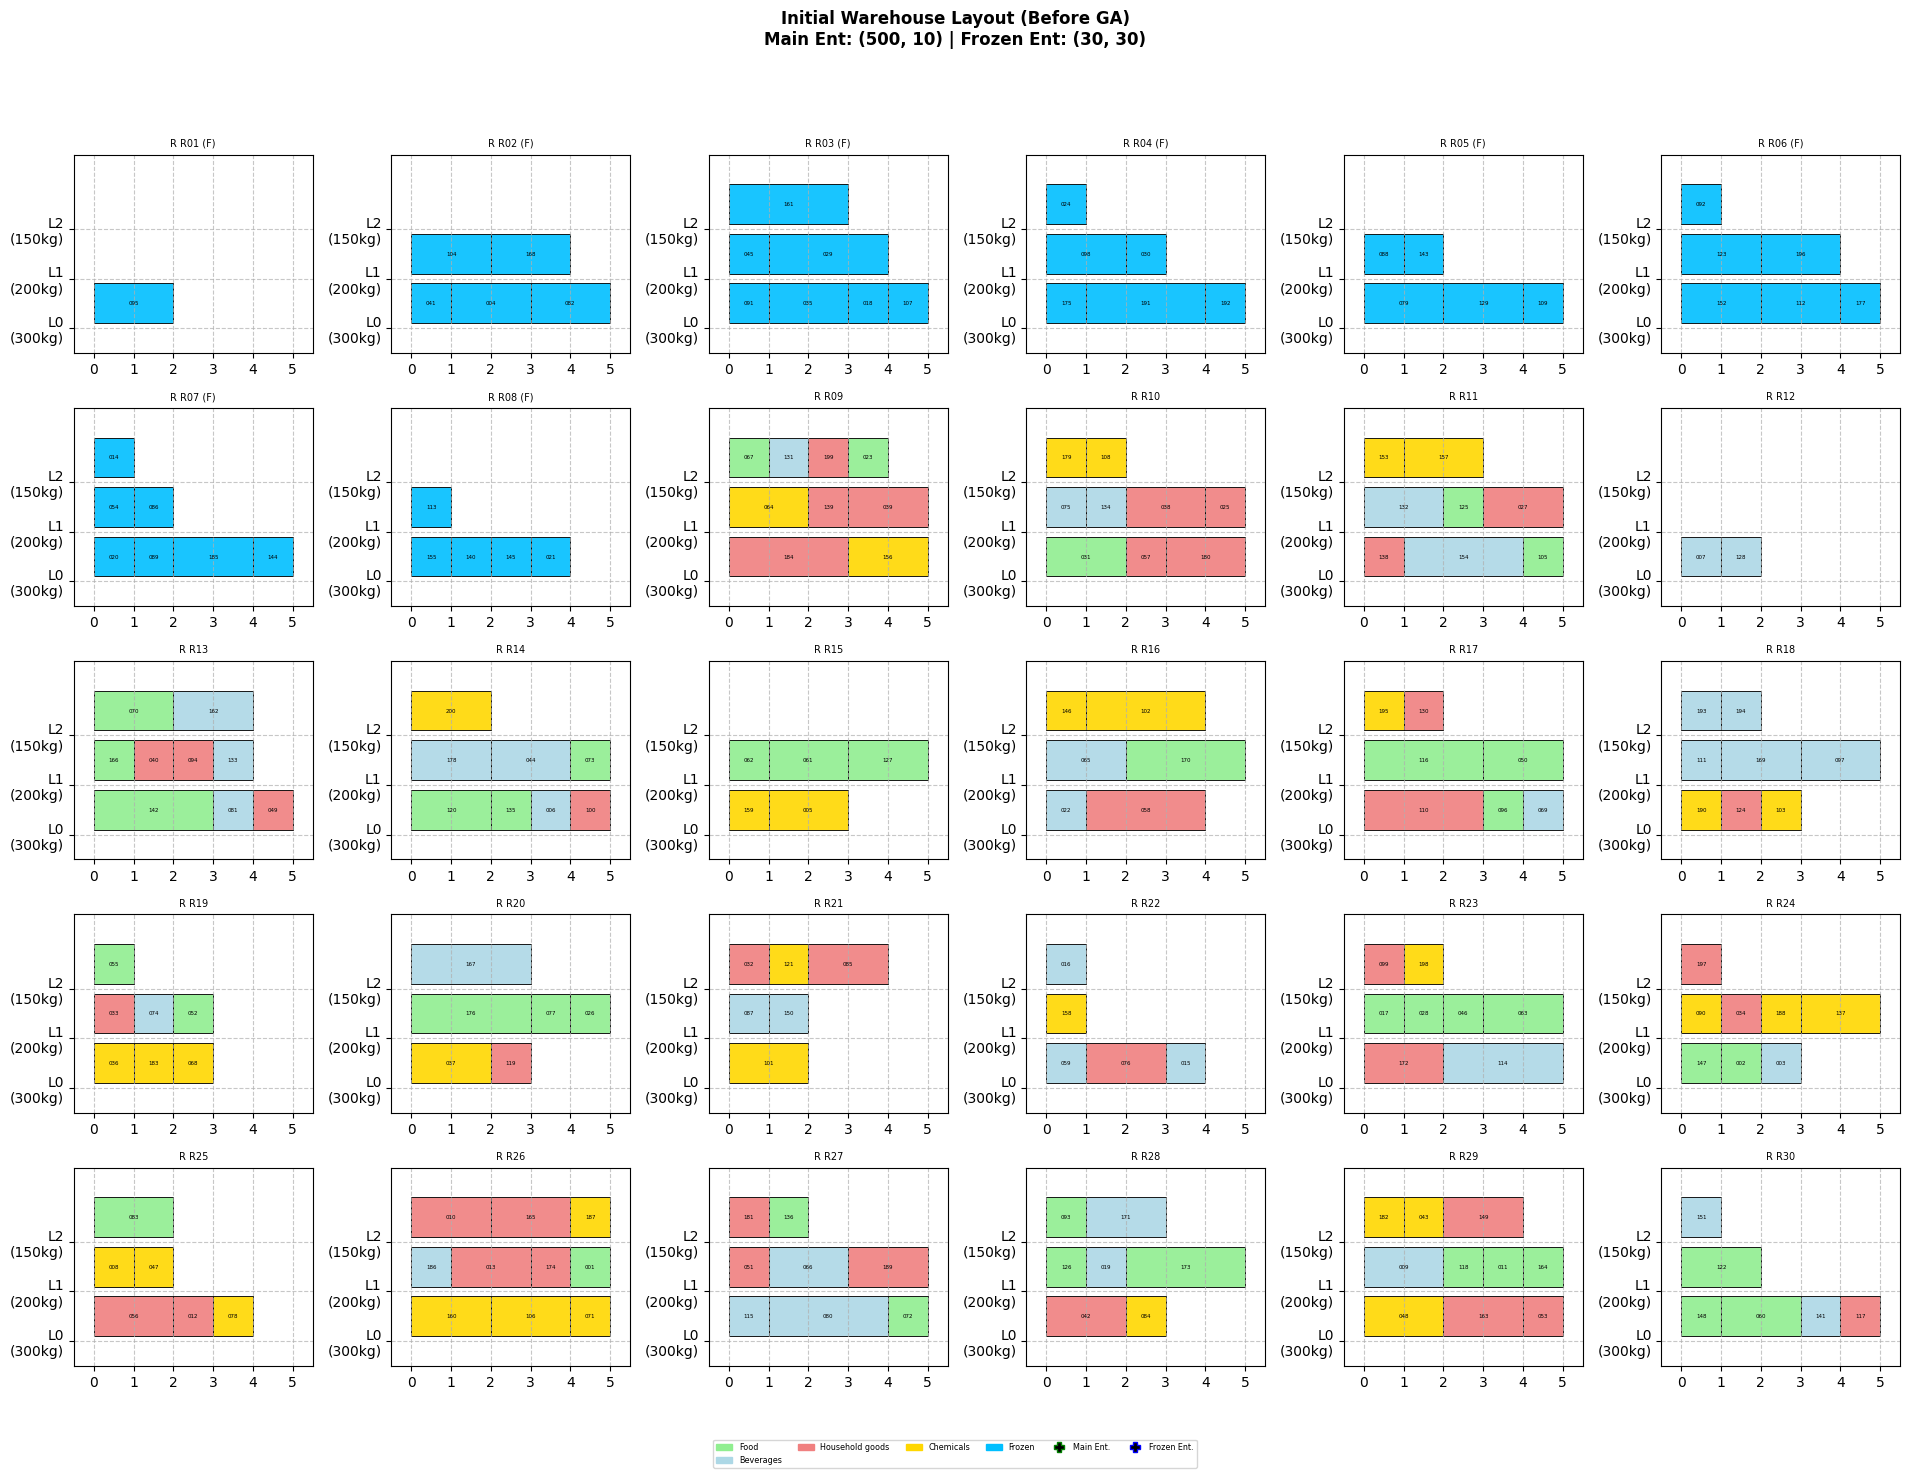

Initial Layout Fitness Score: 62.50

--- Starting GA Optimization ---
Initial Best Layout Fitness: 63.02
  Gen 1/50: Best Overall Fit = 63.02 (Pop best: 63.02, Pop size: 30)
  Gen 6/50: Best Overall Fit = 63.56 (Pop best: 63.56, Pop size: 30)
  Gen 11/50: Best Overall Fit = 63.64 (Pop best: 63.64, Pop size: 30)
  Gen 16/50: Best Overall Fit = 64.40 (Pop best: 64.40, Pop size: 30)
  Gen 21/50: Best Overall Fit = 64.41 (Pop best: 64.41, Pop size: 30)
  Gen 26/50: Best Overall Fit = 64.41 (Pop best: 64.41, Pop size: 30)
  Gen 31/50: Best Overall Fit = 64.63 (Pop best: 64.63, Pop size: 30)
  Gen 36/50: Best Overall Fit = 65.12 (Pop best: 65.12, Pop size: 30)
  Gen 41/50: Best Overall Fit = 65.76 (Pop best: 65.76, Pop size: 30)
  Gen 46/50: Best Overall Fit = 66.19 (Pop best: 66.19, Pop size: 30)
  Gen 50/50: Best Overall Fit = 66.28 (Pop best: 66.28, Pop size: 30)
Finished GA. Final Best Layout Fitness: 66.28

--- Final Optimized Layout ---


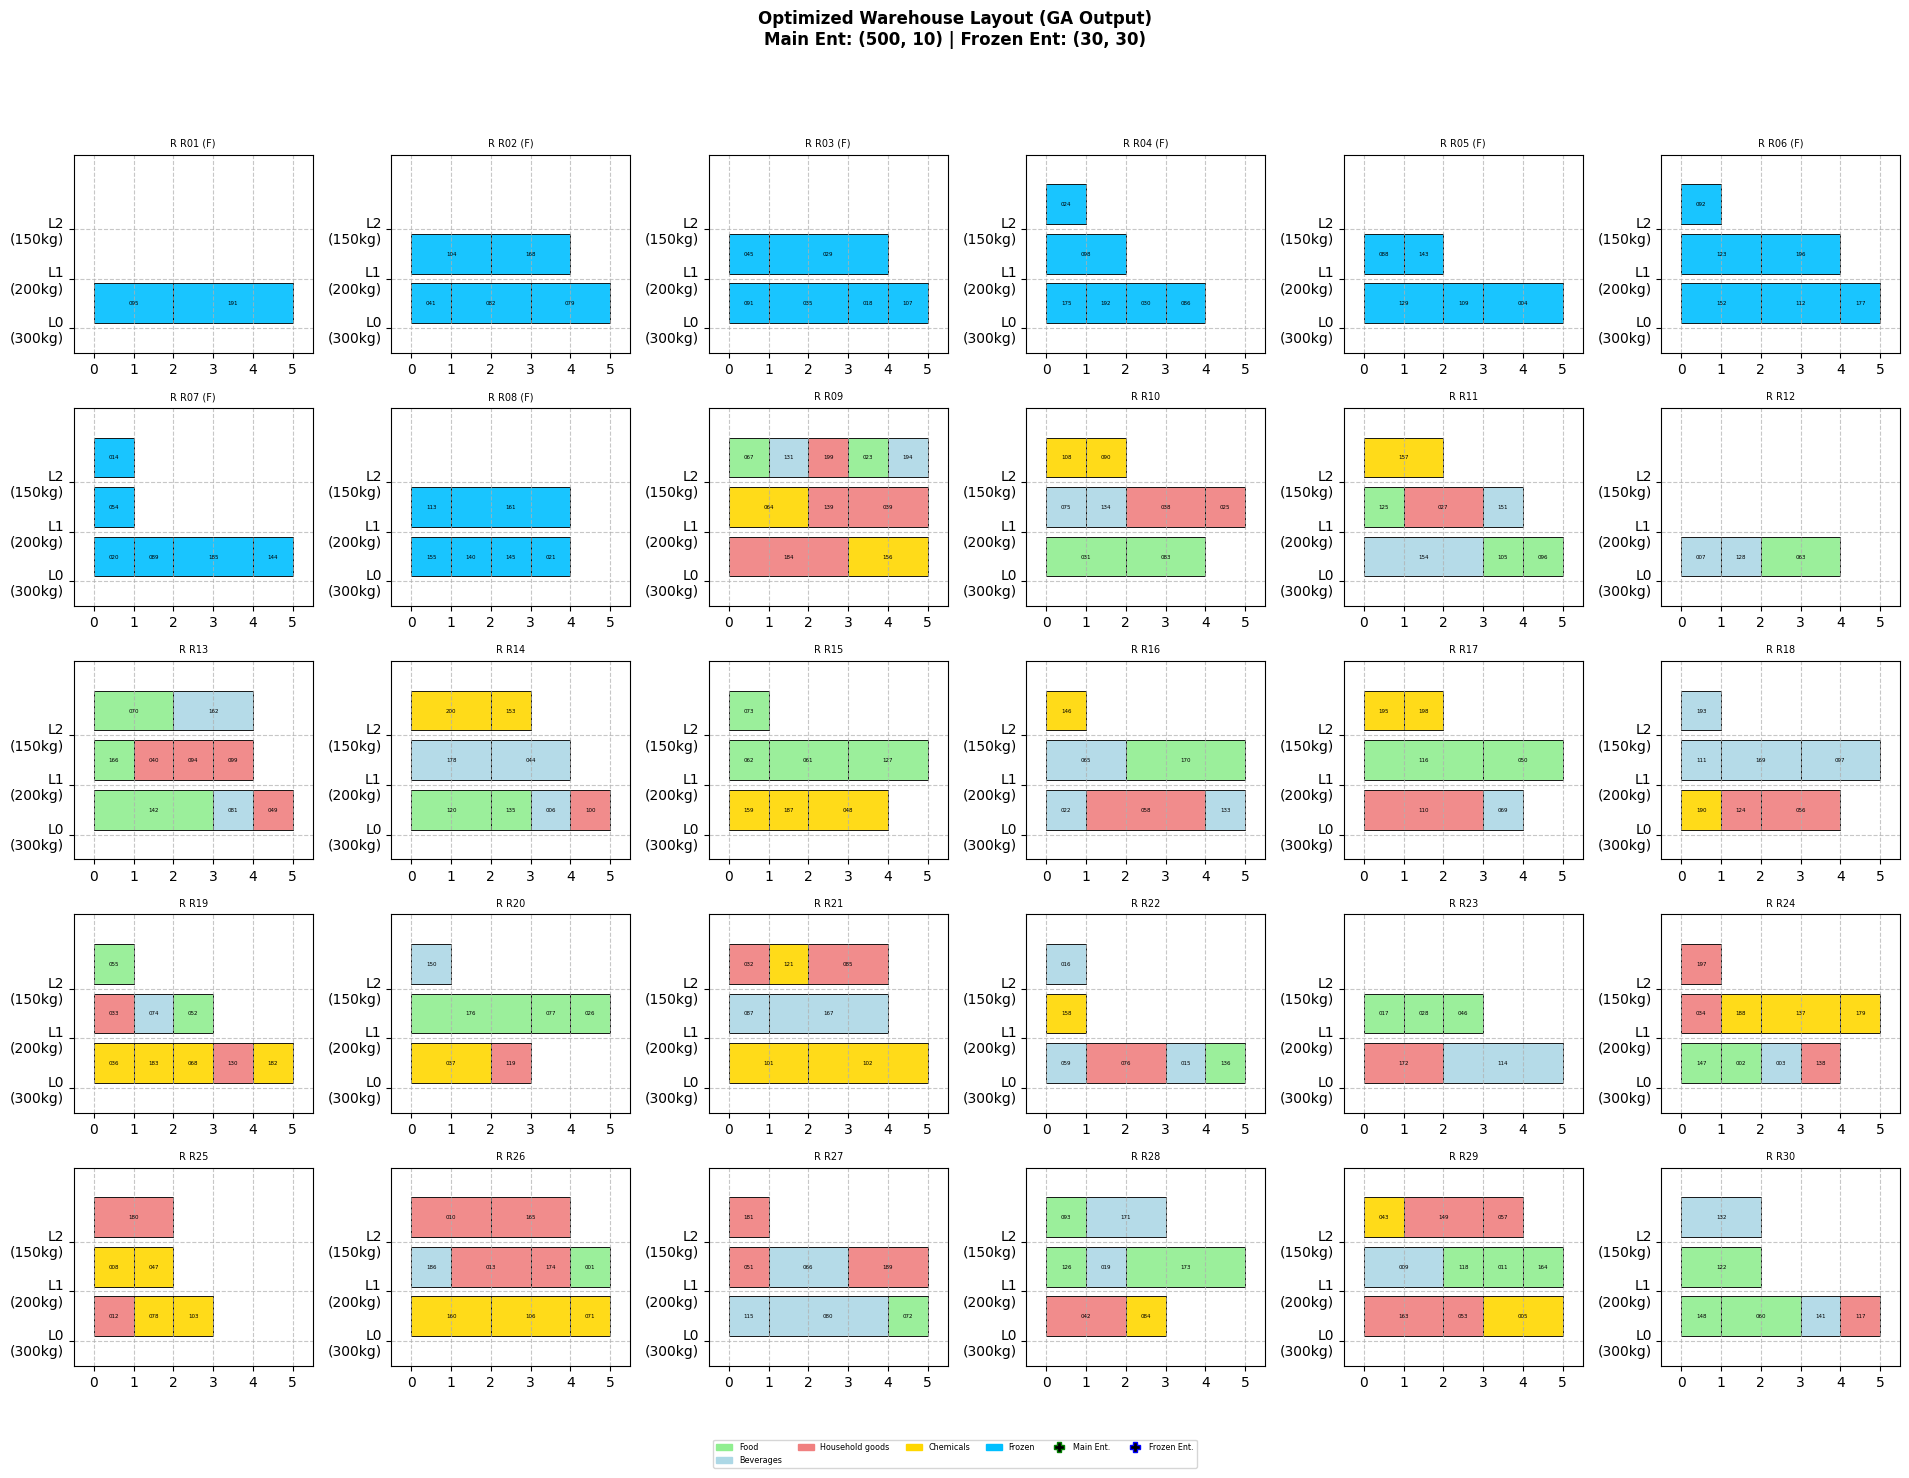

Optimized Layout Fitness Score: 66.28

--- Generating Simplified Move Instructions ---
  1: Item item004: RR02-L0 -> RR05-L0
  2: Item item005: RR15-L0 -> RR29-L0
  3: Item item030: RR04-L1 -> RR04-L0
  4: Item item048: RR29-L0 -> RR15-L0
  5: Item item056: RR25-L0 -> RR18-L0
  6: Item item057: RR10-L0 -> RR29-L2
  7: Item item063: RR23-L1 -> RR12-L0
  8: Item item073: RR14-L1 -> RR15-L2
  9: Item item079: RR05-L0 -> RR02-L0
  10: Item item083: RR25-L2 -> RR10-L0
  11: Item item086: RR07-L1 -> RR04-L0
  12: Item item090: RR24-L1 -> RR10-L2
  13: Item item096: RR17-L0 -> RR11-L0
  14: Item item099: RR23-L2 -> RR13-L1
  15: Item item102: RR16-L2 -> RR21-L0
  16: Item item103: RR18-L0 -> RR25-L0
  17: Item item130: RR17-L2 -> RR19-L0
  18: Item item132: RR11-L1 -> RR30-L2
  19: Item item133: RR13-L1 -> RR16-L0
  20: Item item136: RR27-L2 -> RR22-L0
  21: Item item138: RR11-L0 -> RR24-L0
  22: Item item150: RR21-L1 -> RR20-L2
  23: Item item151: RR30-L2 -> RR11-L1
  24: Item item153: RR11-

In [26]:
import random
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines # Added for legend
import json

# --- Global Configuration ---
WAREHOUSE_CONFIG = {
    "MAX_SLOTS_PER_SHELF": 5,
    "SHELF_LEVELS": 3,
    "HEAVY_ITEM_THRESHOLD": 20,
    "MAX_WEIGHT_PER_LEVEL": [250, 180, 120],
    "ENTRANCE_COORDS_MAIN": (0,0),
    "ENTRANCE_COORDS_FROZEN": (0,0),
    "RACK_CENTERS": {}, "ITEM_DB": {}, "RACK_FROZEN_STATUS": {},
    "COMPATIBILITY_MATRIX": {
        'food':     {'food':1.0, 'beverages':0.8, 'household goods':0.2, 'chemicals':0.0, 'frozen':0.1},
        'beverages':{'food':0.8, 'beverages':1.0, 'household goods':0.3, 'chemicals':0.0, 'frozen':0.1},
        'household goods':{'food':0.2, 'beverages':0.3, 'household goods':1.0, 'chemicals':0.1, 'frozen':0.05},
        'chemicals':{'food':0.0, 'beverages':0.0, 'household goods':0.05,'chemicals':1.0, 'frozen':0.0},
        'frozen':   {'food':0.1, 'beverages':0.1, 'household goods':0.05,'chemicals':0.0, 'frozen':1.0},
    },
    "CATEGORY_CONFLICTS_ON_SHELF": {
        'food': ['chemicals'], 'beverages': ['chemicals'], 'chemicals': ['food', 'beverages'],
    },
    "CATEGORY_COLORS": {
        'food': 'lightgreen', 'beverages': 'lightblue', 'household goods': 'lightcoral',
        'chemicals': 'gold', 'frozen': 'deepskyblue', 'default': 'lightgrey'
    }
}

class ItemData:
    def __init__(self, item_id, name, category, weight, slots, frequency=0):
        self.id = item_id; self.name = name; self.category = category.lower()
        self.weight = float(weight); self.slots = int(slots)
        self.is_frozen = (self.category == 'frozen'); self.frequency = float(frequency)
    def __repr__(self): return f"Item({self.id}, {self.category}, W:{self.weight}, S:{self.slots})"

def euclidean_distance(p1, p2):
    if p1 is None or p2 is None: return float('inf')
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def load_actual_facts_and_items(): # Same as before
    global WAREHOUSE_CONFIG
    facts_content = {
        "entrance_coords": [500, 10],"frozen_entrance_coords": [30, 30],
        "max_weight_per_level": [300, 200, 150],"shelfs_max_height": [60, 60, 1200],"racks_info": {}
    }
    num_racks_total = 30; num_frozen_racks = 8
    frozen_rack_ids_list = [f"R{str(r_idx+1).zfill(2)}" for r_idx in range(num_frozen_racks)]
    frozen_racks_per_row = 4; fx_start, fy_start = 50, 50; f_x_spacing, f_y_spacing = 60, 80
    for r_idx in range(num_frozen_racks):
        rack_id = frozen_rack_ids_list[r_idx]; row = r_idx // frozen_racks_per_row; col = r_idx % frozen_racks_per_row
        center_x = fx_start + col * f_x_spacing; center_y = fy_start + row * f_y_spacing
        facts_content["racks_info"][rack_id] = {"center_coords": [center_x, center_y], "is_frozen": True}
    num_non_frozen_racks = num_racks_total - num_frozen_racks
    non_frozen_racks_per_row = 6; nfx_start, nfy_start = 300, 50; nf_x_spacing, nf_y_spacing = 60, 80
    for r_idx in range(num_non_frozen_racks):
        rack_id = f"R{str(num_frozen_racks + r_idx + 1).zfill(2)}"
        row = r_idx // non_frozen_racks_per_row; col = r_idx % non_frozen_racks_per_row
        center_x = nfx_start + col * nf_x_spacing; center_y = nfy_start + row * nf_y_spacing
        facts_content["racks_info"][rack_id] = {"center_coords": [center_x, center_y], "is_frozen": False}
    WAREHOUSE_CONFIG["ENTRANCE_COORDS_MAIN"] = tuple(facts_content["entrance_coords"])
    WAREHOUSE_CONFIG["ENTRANCE_COORDS_FROZEN"] = tuple(facts_content["frozen_entrance_coords"])
    WAREHOUSE_CONFIG["MAX_WEIGHT_PER_LEVEL"] = facts_content["max_weight_per_level"]
    for r_id, r_info in facts_content["racks_info"].items():
        WAREHOUSE_CONFIG["RACK_CENTERS"][r_id] = tuple(r_info["center_coords"])
        WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"][r_id] = r_info["is_frozen"]
    categories = list(WAREHOUSE_CONFIG["COMPATIBILITY_MATRIX"].keys())
    avg_item_slots = 1.8
    total_slots_cap = num_racks_total * WAREHOUSE_CONFIG["SHELF_LEVELS"] * WAREHOUSE_CONFIG["MAX_SLOTS_PER_SHELF"]
    num_items_to_generate = int(total_slots_cap / avg_item_slots * 0.80) # Target 80% fill by item count
    WAREHOUSE_CONFIG["ITEM_DB"] = {}
    for i in range(num_items_to_generate):
        item_id = f"item{str(i+1).zfill(3)}"
        category = random.choice(categories); name = f"{random.choice(['Std', 'Bulk', 'Val'])} {category.capitalize()} {random.choice(['A', 'B', 'C'])}"
        slots = random.choices([1,2,3], weights=[0.6, 0.3, 0.1], k=1)[0]
        weight = round(random.uniform(5, 40) * slots, 1); frequency = random.randint(1, 30)
        WAREHOUSE_CONFIG["ITEM_DB"][item_id] = ItemData(item_id, name, category, weight, slots, frequency)
    print(f"Generated {len(WAREHOUSE_CONFIG['ITEM_DB'])} dummy items.")
    print(f"Configured {len(WAREHOUSE_CONFIG['RACK_CENTERS'])} racks ({num_frozen_racks} frozen, {num_non_frozen_racks} non-frozen).")

class GeneticLayoutOptimizer:
    def __init__(self, initial_full_layout, config, generations=100, population_size=50,
                 tournament_size=5, crossover_rate=0.85, mutation_rate=0.15, elite_size=3):
        self.config = config
        self.all_item_ids_in_initial_layout = [] # Items to be rearranged by GA
        for rack_data_init in initial_full_layout.values():
            for shelf_items_init in rack_data_init['layout']:
                self.all_item_ids_in_initial_layout.extend(shelf_items_init)
        # Ensure this list contains only unique item IDs from the initial layout, sorted for consistent manifest check
        self.all_item_ids_in_initial_layout = sorted(list(set(self.all_item_ids_in_initial_layout)))

        if not self.all_item_ids_in_initial_layout:
            print("Warning: GA initialized with an empty layout (no items to optimize).")

        self.generations = generations
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.fitness_cache = {}
        self.w_hard_penalty = 10000.0; self.w_space_util = 0.25
        self.w_shelf_category_purity = 0.10; self.w_rack_compatibility = 0.25
        self.w_weight_dist = 0.15; self.w_accessibility = 0.30

        self.population = self._initialize_population(population_size, initial_full_layout)

    def _get_item_obj(self, item_id): return self.config["ITEM_DB"].get(item_id) # Allow None return

    def _calculate_fitness(self, individual_layout):
        tuple_form_parts = []
        for rack_id_key in sorted(individual_layout.keys()):
            rack_content = individual_layout[rack_id_key]['layout']
            shelves_tuple = tuple(tuple(sorted(shelf)) for shelf in rack_content)
            tuple_form_parts.append((rack_id_key, shelves_tuple))
        individual_tuple = tuple(tuple_form_parts)

        if individual_tuple in self.fitness_cache: return self.fitness_cache[individual_tuple]

        penalty = 0.0
        actual_item_ids_in_individual_for_manifest = [] # For manifest check

        total_slots_used_overall = 0.0
        total_shelf_category_purity_score = 0.0; total_rack_compatibility_score = 0.0
        total_weight_dist_score = 0.0; total_accessibility_score = 0.0
        num_racks_in_layout = len(individual_layout); num_shelves_with_items = 0

        for rack_id, rack_data in individual_layout.items():
            is_rack_frozen = rack_data['is_frozen']
            rack_center = self.config["RACK_CENTERS"].get(rack_id, (0,0))
            items_on_this_rack_objs = []
            for shelf_level_idx, shelf_item_ids in enumerate(rack_data['layout']):
                shelf_slots_used = 0.0; shelf_weight = 0.0; shelf_categories_present = set()
                current_shelf_item_objs = []
                actual_item_ids_in_individual_for_manifest.extend(shelf_item_ids) # Collect all items

                for item_id in shelf_item_ids:
                    item_obj = self._get_item_obj(item_id)
                    if item_obj is None:
                        penalty += self.w_hard_penalty * 500 # Extremely high penalty for unknown item
                        continue # Skip further processing for this non-existent item
                    current_shelf_item_objs.append(item_obj); items_on_this_rack_objs.append(item_obj)
                    shelf_slots_used += item_obj.slots; shelf_weight += item_obj.weight
                    shelf_categories_present.add(item_obj.category)
                    if item_obj.is_frozen != is_rack_frozen: penalty += self.w_hard_penalty
                if shelf_slots_used > self.config["MAX_SLOTS_PER_SHELF"]: penalty += self.w_hard_penalty * (shelf_slots_used - self.config["MAX_SLOTS_PER_SHELF"])
                if shelf_weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: penalty += self.w_hard_penalty * (shelf_weight - self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]) / 20.0
                shelf_cats_list = list(shelf_categories_present)
                for c1_idx in range(len(shelf_cats_list)):
                    for c2_idx in range(c1_idx + 1, len(shelf_cats_list)):
                        cat1, cat2 = shelf_cats_list[c1_idx], shelf_cats_list[c2_idx]
                        if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): penalty += self.w_hard_penalty * 0.5
                total_slots_used_overall += shelf_slots_used
                if shelf_categories_present:
                    num_shelves_with_items +=1
                    total_shelf_category_purity_score += (1.0 / len(shelf_categories_present)) if len(shelf_categories_present) > 0 else 1.0
                target_entrance = self.config["ENTRANCE_COORDS_FROZEN"] if is_rack_frozen else self.config["ENTRANCE_COORDS_MAIN"]
                dist_to_entrance = euclidean_distance(rack_center, target_entrance); dist_to_entrance = max(dist_to_entrance, 1.0)
                for item_obj in current_shelf_item_objs: # item_obj guaranteed to be not None here
                    if item_obj.weight > self.config["HEAVY_ITEM_THRESHOLD"]:
                        if shelf_level_idx == 0: total_weight_dist_score += 2.0
                        elif shelf_level_idx == 1: total_weight_dist_score += 0.5
                        else: total_weight_dist_score -= 1.0
                    elif shelf_level_idx == 2: total_weight_dist_score += 0.2
                    total_accessibility_score += (item_obj.frequency / (dist_to_entrance * (shelf_level_idx + 1.0))) * 0.1
            current_rack_compat_score = 0.0; rack_pair_count = 0
            if len(items_on_this_rack_objs) > 1:
                for i_idx in range(len(items_on_this_rack_objs)):
                    for j_idx in range(i_idx + 1, len(items_on_this_rack_objs)):
                        item_i_obj = items_on_this_rack_objs[i_idx]; item_j_obj = items_on_this_rack_objs[j_idx]
                        compat_val = self.config["COMPATIBILITY_MATRIX"].get(item_i_obj.category, {}).get(item_j_obj.category, 0.0)
                        current_rack_compat_score += compat_val; rack_pair_count +=1
                if rack_pair_count > 0: total_rack_compatibility_score += (current_rack_compat_score / rack_pair_count)
            elif items_on_this_rack_objs: total_rack_compatibility_score += 1.0

        # --- Item Manifest Validation ---
        if self.all_item_ids_in_initial_layout: # Only if there are specific items to track from init
            actual_item_ids_in_individual_for_manifest.sort() # Sort for consistent comparison
            if actual_item_ids_in_individual_for_manifest != self.all_item_ids_in_initial_layout:
                 penalty += self.w_hard_penalty * 200 # Very large penalty for incorrect item manifest
                 # Optional: print a warning or detailed difference for debugging manifest issues
                 # print(f"Manifest mismatch! Expected {len(self.all_item_ids_in_initial_layout)} items, got {len(actual_item_ids_in_individual_for_manifest)}.")
                 # print(f"Expected: {self.all_item_ids_in_initial_layout}")
                 # print(f"Actual:   {actual_item_ids_in_individual_for_manifest}")


        total_possible_slots_overall = len(self.config["RACK_CENTERS"]) * self.config["SHELF_LEVELS"] * self.config["MAX_SLOTS_PER_SHELF"]
        overall_space_utilization = total_slots_used_overall / total_possible_slots_overall if total_possible_slots_overall > 0 else 0.0
        avg_shelf_purity = total_shelf_category_purity_score / num_shelves_with_items if num_shelves_with_items > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)
        avg_rack_compatibility = total_rack_compatibility_score / num_racks_in_layout if num_racks_in_layout > 0 else (1.0 if total_slots_used_overall == 0 else 0.0)

        fitness = (self.w_space_util * overall_space_utilization * 100.0) + \
                  (self.w_shelf_category_purity * avg_shelf_purity * 100.0) + \
                  (self.w_rack_compatibility * avg_rack_compatibility * 100.0) + \
                  (self.w_weight_dist * total_weight_dist_score) + \
                  (self.w_accessibility * total_accessibility_score) - penalty

        self.fitness_cache[individual_tuple] = fitness
        return fitness

    def _can_place_item_on_shelf(self, existing_item_ids_on_shelf, item_to_add_obj, shelf_level_idx, rack_is_frozen):
        current_slots = 0
        current_weight = 0
        current_categories = set()

        for id_val in existing_item_ids_on_shelf:
            item_obj = self._get_item_obj(id_val)
            if item_obj is None: return False # Cannot validate if an existing item is unknown
            current_slots += item_obj.slots
            current_weight += item_obj.weight
            current_categories.add(item_obj.category)

        if current_slots + item_to_add_obj.slots > self.config["MAX_SLOTS_PER_SHELF"]: return False
        if current_weight + item_to_add_obj.weight > self.config["MAX_WEIGHT_PER_LEVEL"][shelf_level_idx]: return False
        if item_to_add_obj.is_frozen != rack_is_frozen: return False
        
        current_categories.add(item_to_add_obj.category)
        temp_cats_list = list(current_categories)
        for c1_idx in range(len(temp_cats_list)):
            for c2_idx in range(c1_idx + 1, len(temp_cats_list)):
                cat1, cat2 = temp_cats_list[c1_idx], temp_cats_list[c2_idx]
                if cat2 in self.config["CATEGORY_CONFLICTS_ON_SHELF"].get(cat1, []): return False
        return True

    def _initialize_population(self, population_size, initial_full_layout):
        population = [copy.deepcopy(initial_full_layout)]
        # Ensure the initial layout itself has the correct manifest before mutating from it
        initial_items_check = []
        for r_data in initial_full_layout.values():
            for s_items in r_data['layout']:
                initial_items_check.extend(s_items)
        initial_items_check.sort()
        if initial_items_check != self.all_item_ids_in_initial_layout:
            print("CRITICAL WARNING: _initialize_population received an initial_full_layout with an INCORRECT item manifest compared to self.all_item_ids_in_initial_layout.")
            # This could happen if initial_full_layout was modified externally or if all_item_ids_in_initial_layout
            # was derived from a different source/state of initial_full_layout.
            # For safety, one might want to re-derive all_item_ids_in_initial_layout here, or ensure consistency upstream.

        while len(population) < population_size:
            mutated_individual = self._mutate(copy.deepcopy(initial_full_layout))
            population.append(mutated_individual)
        return population

    def _tournament_selection(self):
        if not self.population: raise ValueError("Population empty for tournament.")
        sample_size = min(len(self.population), self.tournament_size)
        if sample_size == 0: raise ValueError("Population is empty, cannot select for tournament.")
        contenders = random.sample(self.population, sample_size)
        return copy.deepcopy(max(contenders, key=self._calculate_fitness))

    def _crossover(self, parent1_layout, parent2_layout):
        child1_layout = copy.deepcopy(parent1_layout); child2_layout = copy.deepcopy(parent2_layout)
        if random.random() < self.crossover_rate:
            all_r_ids = list(self.config["RACK_CENTERS"].keys())
            if len(all_r_ids) > 1:
                num_swap = random.randint(1, max(1, len(all_r_ids)//2)); racks_swap_ids = random.sample(all_r_ids, num_swap)
                for r_id_co in racks_swap_ids:
                    p1_rack_data = parent1_layout.get(r_id_co)
                    p2_rack_data = parent2_layout.get(r_id_co)
                    if p1_rack_data is not None and p2_rack_data is not None:
                        child1_layout[r_id_co] = copy.deepcopy(p2_rack_data)
                        child2_layout[r_id_co] = copy.deepcopy(p1_rack_data)
        return child1_layout, child2_layout

    def _mutate(self, individual_layout):
        mutated_layout = copy.deepcopy(individual_layout)
        if random.random() > self.mutation_rate: return mutated_layout

        num_mutation_ops = random.randint(1, 3) # Perform a few swaps/moves

        for _ in range(num_mutation_ops):
            # Option 1: Try to swap two items
            if random.random() < 0.5:
                ids_in_layout = []
                loc_map = {} # item_id -> (rack_id, shelf_idx, list_idx_on_shelf)
                for r_id, r_data in mutated_layout.items():
                    for s_idx, s_items in enumerate(r_data['layout']):
                        for item_list_idx, item_id in enumerate(s_items):
                            ids_in_layout.append(item_id)
                            loc_map[item_id + f"_{r_id}_{s_idx}_{item_list_idx}"] = (item_id, r_id, s_idx, item_list_idx) # Unique key for loc_map

                if len(ids_in_layout) < 2: continue # Need at least two items to swap

                # Choose two distinct items to try swapping
                # Ensure we are picking from unique locations if items can be duplicated (though manifest should prevent)
                unique_loc_keys = list(loc_map.keys())
                if len(unique_loc_keys) < 2: continue

                key1, key2 = random.sample(unique_loc_keys, 2)
                item1_id, r1, s1, l1_idx = loc_map[key1]
                item2_id, r2, s2, l2_idx = loc_map[key2]
                
                item1_obj = self._get_item_obj(item1_id)
                item2_obj = self._get_item_obj(item2_id)

                if item1_obj is None or item2_obj is None: continue

                # Temporarily remove both for validation
                mutated_layout[r1]['layout'][s1].pop(l1_idx)
                # Adjust l2_idx if item2 was on the same shelf and after item1
                if r1 == r2 and s1 == s2 and l2_idx > l1_idx:
                    l2_idx_adjusted = l2_idx -1
                else:
                    l2_idx_adjusted = l2_idx
                try:
                    mutated_layout[r2]['layout'][s2].pop(l2_idx_adjusted)
                except IndexError: # Item might have been removed if it was a duplicate or error in logic
                    mutated_layout[r1]['layout'][s1].insert(l1_idx, item1_id) # Put item1 back
                    continue


                # Check if item1 can go to item2's old spot
                can_place_item1_at_loc2 = self._can_place_item_on_shelf(
                    mutated_layout[r2]['layout'][s2], item1_obj, s2, mutated_layout[r2]['is_frozen'])
                # Check if item2 can go to item1's old spot
                can_place_item2_at_loc1 = self._can_place_item_on_shelf(
                    mutated_layout[r1]['layout'][s1], item2_obj, s1, mutated_layout[r1]['is_frozen'])

                if can_place_item1_at_loc2 and can_place_item2_at_loc1:
                    mutated_layout[r2]['layout'][s2].append(item1_id) # No specific index, just add
                    mutated_layout[r1]['layout'][s1].append(item2_id) # No specific index, just add
                else:
                    # Rollback: put items back to their original (pre-pop) locations
                    mutated_layout[r2]['layout'][s2].insert(l2_idx_adjusted, item2_id)
                    mutated_layout[r1]['layout'][s1].insert(l1_idx, item1_id)

            # Option 2: Move a single item (original mutation logic)
            else:
                currently_placed_ids = []
                for r_data_mut_check in mutated_layout.values():
                    for s_items_mut_check in r_data_mut_check['layout']:
                        currently_placed_ids.extend(s_items_mut_check)
                if not currently_placed_ids: continue

                item_id_mut = random.choice(currently_placed_ids)
                item_obj_mut = self._get_item_obj(item_id_mut)
                if item_obj_mut is None: continue

                curr_r, curr_s = None, None; found_item_for_mut = False
                # Find and remove item
                for r_id_m, r_data_m in mutated_layout.items():
                    for s_idx_m, s_items_m in enumerate(r_data_m['layout']):
                        if item_id_mut in s_items_m:
                            curr_r, curr_s = r_id_m, s_idx_m
                            mutated_layout[r_id_m]['layout'][s_idx_m].remove(item_id_mut)
                            found_item_for_mut = True; break
                    if found_item_for_mut: break
                if not found_item_for_mut: continue

                placed_mut = False
                possible_target_racks_mut = [rid for rid, r_data in mutated_layout.items() if r_data['is_frozen'] == item_obj_mut.is_frozen]
                if not possible_target_racks_mut:
                    mutated_layout[curr_r]['layout'][curr_s].append(item_id_mut); continue

                random.shuffle(possible_target_racks_mut)
                for _att_mut in range(10): # Reduced attempts for single move
                    new_r = random.choice(possible_target_racks_mut)
                    new_s = random.randrange(self.config["SHELF_LEVELS"])
                    shelf_items_for_check = list(mutated_layout[new_r]['layout'][new_s]) # Fresh copy
                    if self._can_place_item_on_shelf(shelf_items_for_check, item_obj_mut, new_s, mutated_layout[new_r]['is_frozen']):
                        mutated_layout[new_r]['layout'][new_s].append(item_id_mut)
                        placed_mut = True; break
                if not placed_mut:
                    mutated_layout[curr_r]['layout'][curr_s].append(item_id_mut)
        return mutated_layout

    def run(self):
        self.fitness_cache = {};
        if not self.population: print("GA Error: Population empty at start of run."); return {}, -float('inf')

        pop_w_fit = []
        for ind_idx, ind in enumerate(self.population):
            # print(f"Calculating initial fitness for individual {ind_idx}") # Debug
            pop_w_fit.append((self._calculate_fitness(ind), ind))

        if not pop_w_fit:
            print("GA Error: Population with fitness is empty after initial calculation.")
            return {}, -float('inf')
        pop_w_fit.sort(key=lambda x: x[0], reverse=True)

        best_indiv = copy.deepcopy(pop_w_fit[0][1]); best_fit = pop_w_fit[0][0]
        print(f"Initial Best Layout Fitness: {best_fit:.2f}")

        for gen in range(self.generations):
            current_gen_population_for_selection = [ind for _, ind in pop_w_fit]

            curr_gen_best_fit = pop_w_fit[0][0]
            if curr_gen_best_fit > best_fit:
                best_fit = curr_gen_best_fit
                best_indiv = copy.deepcopy(pop_w_fit[0][1])

            if gen % (max(1,self.generations // 10)) == 0 or gen == self.generations -1 :
                 print(f"  Gen {gen+1}/{self.generations}: Best Overall Fit = {best_fit:.2f} (Pop best: {curr_gen_best_fit:.2f}, Pop size: {len(self.population)})")

            next_pop = []
            if self.elite_size > 0 and current_gen_population_for_selection:
                next_pop.extend(copy.deepcopy(current_gen_population_for_selection[:self.elite_size]))

            # Update self.population to the pool from which tournament selection will draw
            self.population = current_gen_population_for_selection
            
            while len(next_pop) < self.population_size:
                if not self.population : # Check if population for selection is exhausted
                    # print(f"Warning: Population for selection exhausted at gen {gen+1}, next_pop size {len(next_pop)}")
                    break
                p1 = self._tournament_selection(); p2 = self._tournament_selection()
                c1, c2 = self._crossover(p1, p2)
                next_pop.append(self._mutate(c1))
                if len(next_pop) < self.population_size: next_pop.append(self._mutate(c2))

            self.population = next_pop[:self.population_size]; self.fitness_cache = {}
            if not self.population:
                print(f"Warn: Population became empty after generating next generation {gen+1}. Stopping.");
                break # Stop GA if population collapses

            pop_w_fit = []
            for ind_idx, ind in enumerate(self.population):
                # print(f"Calculating fitness for gen {gen+1}, individual {ind_idx}") # Debug
                pop_w_fit.append((self._calculate_fitness(ind), ind))
            
            if not pop_w_fit:
                print(f"Warn: Population with fitness became empty after processing gen {gen+1}. Stopping.")
                break
            pop_w_fit.sort(key=lambda x: x[0], reverse=True)

        print(f"Finished GA. Final Best Layout Fitness: {best_fit:.2f}")
        return best_indiv, best_fit

# --- Visualization (Modified for entrances) ---
def visualize_layout(layout_individual_dict, config, title="Warehouse Layout"):
    num_racks = len(config["RACK_CENTERS"])
    if num_racks == 0: print("No racks to visualize."); return
    
    # Filter out empty racks from layout_individual_dict if they are not in RACK_CENTERS (should not happen with current logic)
    racks_to_plot_ids = sorted([r_id for r_id in layout_individual_dict.keys() if r_id in config["RACK_CENTERS"]])
    if not racks_to_plot_ids: # If filtering results in no racks (e.g. layout_individual_dict is empty or only has unknown racks)
        racks_to_plot_ids = sorted(config["RACK_CENTERS"].keys()) # Fallback to all configured racks (will show as empty)
        if not racks_to_plot_ids: # Still no racks
            print("No racks configured or found in layout to visualize.")
            return


    num_racks_to_display = len(racks_to_plot_ids)
    cols = 6 ; rows = (num_racks_to_display + cols - 1) // cols
    if rows == 0 : rows = 1 # Ensure at least one row if there are any cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.0), squeeze=False)
    axes_flat = axes.flatten()
    plot_idx = 0

    for rack_id_viz in racks_to_plot_ids:
        if plot_idx >= len(axes_flat): break # Should not happen if rows/cols calculated correctly
        ax = axes_flat[plot_idx]
        rack_data_viz = layout_individual_dict.get(rack_id_viz) # Get data for this specific rack
        is_rack_frozen_viz = config["RACK_FROZEN_STATUS"].get(rack_id_viz, False)
        
        # If rack_data_viz is None (e.g. rack_id_viz from RACK_CENTERS but not in layout_individual_dict), create empty layout
        rack_layout_viz = rack_data_viz['layout'] if rack_data_viz and 'layout' in rack_data_viz else [[] for _ in range(config["SHELF_LEVELS"])]

        ax.set_xlim(-0.5, config["MAX_SLOTS_PER_SHELF"] + 0.5); ax.set_ylim(-0.5, config["SHELF_LEVELS"] - 0.5 + 1)
        ax.set_xticks(range(config["MAX_SLOTS_PER_SHELF"] + 1)); ax.set_yticks(range(config["SHELF_LEVELS"]))
        ax.set_yticklabels([f"L{j}\n({config['MAX_WEIGHT_PER_LEVEL'][j]}kg)" for j in range(config["SHELF_LEVELS"])])
        ax.grid(True, linestyle='--', alpha=0.7); title_str_viz = f"R {rack_id_viz}{' (F)' if is_rack_frozen_viz else ''}"
        ax.set_title(title_str_viz, fontsize=7)
        for shelf_level_viz, shelf_item_ids_viz in enumerate(rack_layout_viz):
            current_bin_pos = 0
            for item_id_viz in shelf_item_ids_viz:
                item_obj_viz = config["ITEM_DB"].get(item_id_viz);
                if not item_obj_viz:
                    # print(f"Warning: Item {item_id_viz} not in ITEM_DB, cannot visualize.")
                    continue # Skip visualizing this unknown item
                item_slots_viz = item_obj_viz.slots; item_height_viz = 0.8
                rect_color = config["CATEGORY_COLORS"].get(item_obj_viz.category, config["CATEGORY_COLORS"]['default'])
                rect = patches.Rectangle((current_bin_pos, shelf_level_viz+(1-item_height_viz)/2), item_slots_viz, item_height_viz,
                                         fc=rect_color, ec='black', lw=0.7, alpha=0.9, label=f"_{item_obj_viz.category}")
                ax.add_patch(rect)
                ax.text(current_bin_pos+item_slots_viz/2, shelf_level_viz+0.5, f"{item_obj_viz.id[-3:]}",
                        ha='center', va='center', fontsize=4, color='black')
                current_bin_pos += item_slots_viz
        plot_idx +=1
    for j in range(plot_idx, len(axes_flat)): fig.delaxes(axes_flat[j]) # Remove unused subplots

    legend_handles = [patches.Patch(color=color, label=category.capitalize()) for category, color in config["CATEGORY_COLORS"].items() if category != 'default']
    # Check if ENTRANCE_COORDS_MAIN and ENTRANCE_COORDS_FROZEN are defined
    if config.get('ENTRANCE_COORDS_MAIN'):
        legend_handles.append(mlines.Line2D([], [], color='black', marker='P',markeredgecolor='g', linestyle='None', markersize=7, label='Main Ent.'))
    if config.get('ENTRANCE_COORDS_FROZEN'):
        legend_handles.append(mlines.Line2D([], [], color='black', marker='P',markeredgecolor='b', linestyle='None', markersize=7, label='Frozen Ent.'))

    if legend_handles:
        fig.legend(handles=legend_handles, loc='lower center', ncol=min(len(legend_handles), 6), bbox_to_anchor=(0.5, 0.005), fontsize='xx-small')
    
    main_ent_str = str(config.get('ENTRANCE_COORDS_MAIN', 'N/A'))
    frozen_ent_str = str(config.get('ENTRANCE_COORDS_FROZEN', 'N/A'))
    fig.suptitle(f"{title}\nMain Ent: {main_ent_str} | Frozen Ent: {frozen_ent_str}",
                 fontsize=12, weight='bold');
    plt.tight_layout(rect=[0, 0.05, 1, 0.94]); # Adjust rect to make space for legend and suptitle
    plt.show()

# --- Generate Move Instructions (Simplified for new layout) ---
def generate_move_instructions_simplified(initial_layout_dict, final_layout_dict): # Same as before
    instructions = []; initial_item_locs = {}
    for r_id, r_data in initial_layout_dict.items():
        for s_idx, s_items in enumerate(r_data['layout']):
            for item_id in s_items: initial_item_locs[item_id] = (r_id, s_idx)
    final_item_locs = {}
    for r_id, r_data in final_layout_dict.items():
        for s_idx, s_items in enumerate(r_data['layout']):
            for item_id in s_items: final_item_locs[item_id] = (r_id, s_idx)
    
    # Use the items from the initial layout as the definitive list of items to track.
    # This ensures that only moves of originally placed items are reported.
    tracked_item_ids = sorted(list(initial_item_locs.keys()))

    for item_id in tracked_item_ids:
        init_loc = initial_item_locs.get(item_id); # Should always exist by definition of tracked_item_ids
        final_loc = final_item_locs.get(item_id) # Might be None if item was "lost" (should be penalized by GA)

        if init_loc != final_loc: # This covers item moved, or item "lost" (final_loc is None)
            from_str = f"R{init_loc[0]}-L{init_loc[1]}"
            to_str = f"R{final_loc[0]}-L{final_loc[1]}" if final_loc else "MISSING_IN_FINAL"
            instructions.append(f"Item {item_id}: {from_str} -> {to_str}")
    
    # Additionally, check for items in final layout that weren't in initial (should not happen with manifest penalty)
    # for item_id in final_item_locs:
    #     if item_id not in initial_item_locs:
    #         final_loc = final_item_locs[item_id]
    #         instructions.append(f"Item {item_id}: NEWLY_APPEARED -> R{final_loc[0]}-L{final_loc[1]}")


    if not instructions: instructions.append("No net item location changes for initially placed items.")
    return instructions

# --- Main Orchestration Logic ---
if __name__ == "__main__":
    load_actual_facts_and_items()
    initial_full_layout = {}
    for rack_id_main, is_frz_main in WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"].items():
        initial_full_layout[rack_id_main] = {'is_frozen': is_frz_main, 'layout': [[] for _ in range(WAREHOUSE_CONFIG["SHELF_LEVELS"])]}

    all_item_ids_for_placement = list(WAREHOUSE_CONFIG["ITEM_DB"].keys())
    random.shuffle(all_item_ids_for_placement)
    placed_item_count_main = 0

    print("--- Generating Initial Warehouse Layout ---")
    # Create a temporary GA instance just to use its _can_place_item_on_shelf method.
    # The initial_full_layout for this dummy GA does not matter as much as its config.
    # We pass an empty-like structure for its initial_full_layout.
    dummy_layout_for_validation_ga = {r_id: {'is_frozen': WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"][r_id],
                                              'layout': [[] for _ in range(WAREHOUSE_CONFIG["SHELF_LEVELS"])]}
                                      for r_id in WAREHOUSE_CONFIG["RACK_CENTERS"]}
    temp_ga_for_val = GeneticLayoutOptimizer(dummy_layout_for_validation_ga, WAREHOUSE_CONFIG, generations=1, population_size=1)


    for item_id_main in all_item_ids_for_placement:
        item_obj_main = WAREHOUSE_CONFIG["ITEM_DB"].get(item_id_main)
        if not item_obj_main: continue
        placed_this_item_main = False
        possible_racks_main = [rid for rid, r_is_frozen in WAREHOUSE_CONFIG["RACK_FROZEN_STATUS"].items()
                               if r_is_frozen == item_obj_main.is_frozen]
        if not possible_racks_main: continue
        random.shuffle(possible_racks_main)

        shelf_order_priority = list(range(WAREHOUSE_CONFIG["SHELF_LEVELS"]))
        if item_obj_main.weight > WAREHOUSE_CONFIG["HEAVY_ITEM_THRESHOLD"]:
            shelf_order_priority = sorted(shelf_order_priority, key=lambda x: x)
        else:
            random.shuffle(shelf_order_priority)

        for rack_id_init_main in possible_racks_main:
            for shelf_level_init_main in shelf_order_priority:
                # Use the temp_ga_for_val's method with the *actual* current state of initial_full_layout
                current_shelf_items = initial_full_layout[rack_id_init_main]['layout'][shelf_level_init_main]
                is_rack_frozen_main = initial_full_layout[rack_id_init_main]['is_frozen']
                if temp_ga_for_val._can_place_item_on_shelf(list(current_shelf_items), item_obj_main, shelf_level_init_main, is_rack_frozen_main):
                    initial_full_layout[rack_id_init_main]['layout'][shelf_level_init_main].append(item_id_main)
                    placed_this_item_main = True; placed_item_count_main +=1; break
            if placed_this_item_main: break
        if not placed_this_item_main:
            print(f"Warning: Could not place item {item_id_main} ({item_obj_main.category}, W:{item_obj_main.weight}, S:{item_obj_main.slots}) in initial layout.")

    print(f"Generated initial layout with {placed_item_count_main} / {len(all_item_ids_for_placement)} items placed.")

    # --- Visualize Initial Layout ---
    visualize_layout(initial_full_layout, WAREHOUSE_CONFIG, title="Initial Warehouse Layout (Before GA)")

    # Calculate fitness of the actual initial layout
    # Need a GA instance that is aware of the items in *this specific* initial_full_layout
    # The all_item_ids_in_initial_layout member will be correctly set by this constructor.
    ga_instance_for_initial_fitness = GeneticLayoutOptimizer(initial_full_layout, WAREHOUSE_CONFIG, generations=1, population_size=1)
    initial_fitness_val = ga_instance_for_initial_fitness._calculate_fitness(initial_full_layout)
    print(f"Initial Layout Fitness Score: {initial_fitness_val:.2f}")

    # --- Configure and Run Main GA Optimizer ---
    # This GA instance will also be initialized with initial_full_layout,
    # so its self.all_item_ids_in_initial_layout will be set based on what was actually placed.
    ga_optimizer = GeneticLayoutOptimizer(
        initial_full_layout=initial_full_layout,
        config=WAREHOUSE_CONFIG,
        generations=50, population_size=30, tournament_size=5, # Adjusted for typical runs
        crossover_rate=0.85, mutation_rate=0.20, elite_size=3   # Adjusted for typical runs
    )
    print("\n--- Starting GA Optimization ---")
    best_final_layout_ga, best_final_fitness_ga = ga_optimizer.run()

    if best_final_layout_ga and best_final_layout_ga.keys(): # Check if GA returned a valid, non-empty layout
        print("\n--- Final Optimized Layout ---")
        visualize_layout(best_final_layout_ga, WAREHOUSE_CONFIG, title="Optimized Warehouse Layout (GA Output)")
        print(f"Optimized Layout Fitness Score: {best_final_fitness_ga:.2f}")
        print("\n--- Generating Simplified Move Instructions ---")
        move_instructions_list = generate_move_instructions_simplified(initial_full_layout, best_final_layout_ga)
        if move_instructions_list:
            for idx, instruction in enumerate(move_instructions_list): print(f"  {idx+1}: {instruction}")
        else: print("No item position changes detected or GA failed to find a solution.")
    else:
        print("GA optimization did not produce a valid final layout, or the layout was empty.")